# **SEL-NNML Tuning - UCI Heart Disease Dataset**

This notebook implements several tuning methods on the `Stacking Ensemble Learning with a Neural Network Meta-Learner (SEL-NNML)` model using the `UCI Heart Disease Dataset (UCHDD)`.

## **0. Global Configuration**

In [46]:
# Random state for reproducibility
RANDOM_STATE = 42

# Data splitting configuration
TEST_SIZE = 0.2

# Cross-validation configuration
CV_FOLDS = 5

# Hyperparameter tuning configuration
OPTIMIZATION_ITERATIONS = 100
OPTIMIZATION_METRIC = 'accuracy'
OPTIMIZATION_DIRECTION='maximize'

# Parallel processing configuration
N_JOBS = -1 

# Dataset configuration
DATASET_PATH = '../datasets/processed/ds2_uci_heart_clean.csv'
TARGET_COLUMN = 'num'

# Training configuration
SKIP_TRAINING = False  # Set to True to load pre-existing models instead of training

print('Global configuration loaded successfully!')
print(f'Random State: {RANDOM_STATE}')
print(f'Test Size: {TEST_SIZE}')
print(f'CV Folds: {CV_FOLDS}')
print(f'Optimization Iterations: {OPTIMIZATION_ITERATIONS}')
print(f'Optimization Metric: {OPTIMIZATION_METRIC}')
print(f'Optimization Direction: {OPTIMIZATION_DIRECTION}')
print(f'Skip Training: {SKIP_TRAINING}')

Global configuration loaded successfully!
Random State: 42
Test Size: 0.2
CV Folds: 5
Optimization Iterations: 100
Optimization Metric: accuracy
Optimization Direction: maximize
Skip Training: False


## **1. Import Library**

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from src import base_model_tuning, meta_model_tuning
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.inspection import permutation_importance
import joblib

## **2. Load Dataset**

In [48]:
df = pd.read_csv(DATASET_PATH)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    bool   
 2   trestbps   297 non-null    int64  
 3   chol       297 non-null    int64  
 4   fbs        297 non-null    bool   
 5   thalach    297 non-null    int64  
 6   exang      297 non-null    bool   
 7   oldpeak    297 non-null    float64
 8   num        297 non-null    bool   
 9   cp_1       297 non-null    bool   
 10  cp_2       297 non-null    bool   
 11  cp_3       297 non-null    bool   
 12  cp_4       297 non-null    bool   
 13  restecg_0  297 non-null    bool   
 14  restecg_1  297 non-null    bool   
 15  restecg_2  297 non-null    bool   
 16  slope_1    297 non-null    bool   
 17  slope_2    297 non-null    bool   
 18  slope_3    297 non-null    bool   
 19  ca_0.0     297 non-null    bool   
 20  ca_1.0    

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,num,cp_1,...,slope_1,slope_2,slope_3,ca_0.0,ca_1.0,ca_2.0,ca_3.0,thal_3.0,thal_6.0,thal_7.0
0,63,True,145,233,True,150,False,2.3,False,True,...,False,False,True,True,False,False,False,False,True,False
1,67,True,160,286,False,108,True,1.5,True,False,...,False,True,False,False,False,False,True,True,False,False
2,67,True,120,229,False,129,True,2.6,True,False,...,False,True,False,False,False,True,False,False,False,True
3,37,True,130,250,False,187,False,3.5,False,False,...,False,False,True,True,False,False,False,True,False,False
4,41,False,130,204,False,172,False,1.4,False,False,...,True,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,57,False,140,241,False,123,True,0.2,True,False,...,False,True,False,True,False,False,False,False,False,True
293,45,True,110,264,False,132,False,1.2,True,True,...,False,True,False,True,False,False,False,False,False,True
294,68,True,144,193,True,141,False,3.4,True,False,...,False,True,False,False,False,True,False,False,False,True
295,57,True,130,131,False,115,True,1.2,True,False,...,False,True,False,False,True,False,False,False,False,True


## **3. Data Preparation**

- Split the data into desired training and testing
- After that, Scaling the data using Min-Max Normalization

In [49]:
# Split dataset
X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [50]:
# Min-Max Scaling
# Separate numeric and boolean columns
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
bool_cols = X_train.select_dtypes(include=['bool', 'uint8']).columns  # includes one-hot from get_dummies

# Initialize scaler and fit_transform only on numeric data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_cols, index=X_test.index)

# Concatenate back with boolean features (without modification)
X_train = pd.concat([X_train_scaled, X_train[bool_cols]], axis=1)
X_test = pd.concat([X_test_scaled, X_test[bool_cols]], axis=1)

# Save Min-Max Scaler
scaler_filename = '../artifacts/ds2/models/min_max_scaler.pkl'
joblib.dump(scaler, scaler_filename)
print(f'Saved Min-Max Scaler function for this dataset to {scaler_filename}')

Saved Min-Max Scaler function for this dataset to ../artifacts/ds2/models/min_max_scaler.pkl


## **3.1 Default Base Models (Baseline)**

Create base models with default parameters as a baseline for comparison.

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

if not SKIP_TRAINING:
    default_models_training_start = time.time()
    
    # Initialize base models with default parameters
    default_logistic_regression = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
    default_decision_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
    default_random_forest = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=N_JOBS)
    default_knn = KNeighborsClassifier(n_jobs=N_JOBS)
    default_svc = SVC(random_state=RANDOM_STATE, probability=True)  # probability=True for predict_proba
    default_adaboost = AdaBoostClassifier(random_state=RANDOM_STATE)
    default_gradient_boosting = GradientBoostingClassifier(random_state=RANDOM_STATE)
    
    # Fit all default models
    print("Training default base models...")
    default_logistic_regression.fit(X_train, y_train)
    default_decision_tree.fit(X_train, y_train)
    default_random_forest.fit(X_train, y_train)
    default_knn.fit(X_train, y_train)
    default_svc.fit(X_train, y_train)
    default_adaboost.fit(X_train, y_train)
    default_gradient_boosting.fit(X_train, y_train)
    
    default_models_training_end = time.time()
    default_models_training_time = default_models_training_end - default_models_training_start
    
    print(f'Default Base Models Training Time: {default_models_training_time:.2f} seconds')
    
    # Store in dictionary
    default_base_models = {
        'Logistic Regression': default_logistic_regression,
        'Decision Tree': default_decision_tree,
        'Random Forest': default_random_forest,
        'K-Nearest Neighbors': default_knn,
        'Support Vector Machine': default_svc,
        'AdaBoost': default_adaboost,
        'Gradient Boosting': default_gradient_boosting
    }
else:
    print("Skipping default base models training (SKIP_TRAINING = True)")

Training default base models...
Default Base Models Training Time: 0.42 seconds


## **3.2 Stacking with Default Base Models + Linear Regression**

Create a stacking ensemble using default base learners with Linear Regression as the meta-learner.

In [52]:
from sklearn.ensemble import StackingClassifier

if not SKIP_TRAINING:
    stack_lr_training_start = time.time()
    
    # Create stacking ensemble with Linear Regression as meta-learner
    base_estimators = [
        ('Logistic Regression', default_logistic_regression),
        ('Decision Tree', default_decision_tree),
        ('Random Forest', default_random_forest),
        ('K-Nearest Neighbors', default_knn),
        ('Support Vector Machine', default_svc),
        ('AdaBoost', default_adaboost),
        ('Gradient Boosting', default_gradient_boosting)
    ]
    
    # Linear Regression meta-learner (using LogisticRegression for classification)
    meta_lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
    
    stacking_lr = StackingClassifier(
        estimators=base_estimators,
        final_estimator=meta_lr,
        n_jobs=N_JOBS
    )
    
    print("Training Stacking model with Linear Regression meta-learner...")
    stacking_lr.fit(X_train, y_train)
    
    stack_lr_training_end = time.time()
    stack_lr_training_time = stack_lr_training_end - stack_lr_training_start
    
    print(f'Stacking + Linear Regression Training Time: {stack_lr_training_time:.2f} seconds')
else:
    print("Skipping Stacking + LR training (SKIP_TRAINING = True)")

Training Stacking model with Linear Regression meta-learner...
Stacking + Linear Regression Training Time: 4.84 seconds


## **3.3 Stacking with Default Base Models + Default MLP**

Create a stacking ensemble using default base learners with a default MLP (Multi-Layer Perceptron) as the meta-learner.

In [53]:
from sklearn.neural_network import MLPClassifier

if not SKIP_TRAINING:
    stack_mlp_training_start = time.time()
    
    # Create stacking ensemble with default MLP as meta-learner
    # Using default MLP with just random_state for reproducibility
    meta_mlp = MLPClassifier(random_state=RANDOM_STATE, max_iter=300)
    
    stacking_mlp = StackingClassifier(
        estimators=base_estimators,
        final_estimator=meta_mlp,
        n_jobs=N_JOBS
    )
    
    print("Training Stacking model with default MLP meta-learner...")
    stacking_mlp.fit(X_train, y_train)
    
    stack_mlp_training_end = time.time()
    stack_mlp_training_time = stack_mlp_training_end - stack_mlp_training_start
    
    print(f'Stacking + Default MLP Training Time: {stack_mlp_training_time:.2f} seconds')
else:
    print("Skipping Stacking + MLP training (SKIP_TRAINING = True)")

Training Stacking model with default MLP meta-learner...
Stacking + Default MLP Training Time: 2.06 seconds


## **4. Base Model Hyperparameter Tuning**

**Note:** Set `SKIP_TRAINING = True` in the global configuration to skip steps 4 and 5 and load pre-existing models instead.

### **4.1 TPE & CV Hyperparameter Tuning**

In [54]:
if not SKIP_TRAINING:
    tpe_base_models_training_start = time.time()

    # TPE Hyperparameter Tuning with Cross Validation
    tpe_logistic_regression = base_model_tuning('Logistic Regression', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_decision_tree = base_model_tuning('Decision Tree', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_random_forest = base_model_tuning('Random Forest', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_knn = base_model_tuning('K-Nearest Neighbors', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_svc = base_model_tuning('Support Vector Machine', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_adaboost = base_model_tuning('AdaBoost', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_gradient_boosting = base_model_tuning('Gradient Boosting', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)

    # Model Fitting with best parameters
    tpe_logistic_regression.fit(X_train, y_train)
    tpe_decision_tree.fit(X_train, y_train)
    tpe_random_forest.fit(X_train, y_train)
    tpe_knn.fit(X_train, y_train)
    tpe_svc.fit(X_train, y_train)
    tpe_adaboost.fit(X_train, y_train)
    tpe_gradient_boosting.fit(X_train, y_train)

    tpe_base_models_training_end = time.time()

    # Time taken for TPE base models training
    tpe_base_models_training_time = tpe_base_models_training_end - tpe_base_models_training_start
    print(f'TPE Base Models Training Time: {tpe_base_models_training_time:.2f} seconds')
else:
    print("Skipping TPE base models training (SKIP_TRAINING = True)")

[I 2025-11-06 06:24:47,062] A new study created in memory with name: Logistic Regression Model Fine Tuning with TPESampler
Best trial: 4. Best value: 0.839628:   6%|▌         | 6/100 [00:00<00:02, 36.81it/s]

[I 2025-11-06 06:24:47,097] Trial 0 finished with value: 0.52322695035461 and parameters: {'solver': 'newton-cg', 'C': 0.0006026889128682511}. Best is trial 0 with value: 0.52322695035461.
[I 2025-11-06 06:24:47,121] Trial 1 finished with value: 0.8313829787234042 and parameters: {'solver': 'newton-cholesky', 'C': 0.3470266988650412}. Best is trial 1 with value: 0.8313829787234042.
[I 2025-11-06 06:24:47,146] Trial 2 finished with value: 0.52322695035461 and parameters: {'solver': 'newton-cg', 'C': 0.0008111941985431928}. Best is trial 1 with value: 0.8313829787234042.
[I 2025-11-06 06:24:47,170] Trial 3 finished with value: 0.8015070921985815 and parameters: {'solver': 'newton-cholesky', 'C': 0.0028585493941961923}. Best is trial 1 with value: 0.8313829787234042.
[I 2025-11-06 06:24:47,195] Trial 4 finished with value: 0.839627659574468 and parameters: {'solver': 'lbfgs', 'C': 0.019069966103000432}. Best is trial 4 with value: 0.839627659574468.
[I 2025-11-06 06:24:47,219] Trial 5 fin

Best trial: 4. Best value: 0.839628:   9%|▉         | 9/100 [00:00<00:02, 39.31it/s]

[I 2025-11-06 06:24:47,269] Trial 7 finished with value: 0.835372340425532 and parameters: {'solver': 'lbfgs', 'C': 0.015876781526923997}. Best is trial 4 with value: 0.839627659574468.
[I 2025-11-06 06:24:47,293] Trial 8 finished with value: 0.7340425531914894 and parameters: {'solver': 'sag', 'C': 0.0019674328025306126}. Best is trial 4 with value: 0.839627659574468.


Best trial: 4. Best value: 0.839628:  14%|█▍        | 14/100 [00:00<00:02, 39.15it/s]

[I 2025-11-06 06:24:47,318] Trial 9 finished with value: 0.52322695035461 and parameters: {'solver': 'lbfgs', 'C': 0.0008399864445957502}. Best is trial 4 with value: 0.839627659574468.
[I 2025-11-06 06:24:47,343] Trial 10 finished with value: 0.8313829787234042 and parameters: {'solver': 'lbfgs', 'C': 0.23114272501983432}. Best is trial 4 with value: 0.839627659574468.
[I 2025-11-06 06:24:47,369] Trial 11 finished with value: 0.839627659574468 and parameters: {'solver': 'lbfgs', 'C': 0.022212906398276677}. Best is trial 4 with value: 0.839627659574468.
[I 2025-11-06 06:24:47,396] Trial 12 finished with value: 0.8354609929078014 and parameters: {'solver': 'lbfgs', 'C': 0.03127454434877545}. Best is trial 4 with value: 0.839627659574468.
[I 2025-11-06 06:24:47,421] Trial 13 finished with value: 0.8313829787234042 and parameters: {'solver': 'lbfgs', 'C': 0.23547164170627424}. Best is trial 4 with value: 0.839627659574468.
[I 2025-11-06 06:24:47,447] Trial 14 finished with value: 0.818262

Best trial: 4. Best value: 0.839628:  17%|█▋        | 17/100 [00:00<00:02, 39.13it/s]

[I 2025-11-06 06:24:47,472] Trial 15 finished with value: 0.8356382978723405 and parameters: {'solver': 'lbfgs', 'C': 0.06203312414676462}. Best is trial 4 with value: 0.839627659574468.
[I 2025-11-06 06:24:47,498] Trial 16 finished with value: 0.8101063829787234 and parameters: {'solver': 'newton-cg', 'C': 2.8359603155870277}. Best is trial 4 with value: 0.839627659574468.


Best trial: 20. Best value: 0.843972:  22%|██▏       | 22/100 [00:00<00:01, 39.04it/s]

[I 2025-11-06 06:24:47,524] Trial 17 finished with value: 0.8356382978723405 and parameters: {'solver': 'sag', 'C': 0.053955285200606204}. Best is trial 4 with value: 0.839627659574468.
[I 2025-11-06 06:24:47,549] Trial 18 finished with value: 0.8186170212765959 and parameters: {'solver': 'newton-cholesky', 'C': 0.7133775108174086}. Best is trial 4 with value: 0.839627659574468.
[I 2025-11-06 06:24:47,575] Trial 19 finished with value: 0.8140070921985816 and parameters: {'solver': 'lbfgs', 'C': 0.008669040269005453}. Best is trial 4 with value: 0.839627659574468.
[I 2025-11-06 06:24:47,601] Trial 20 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.10511058777298005}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:47,627] Trial 21 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.09579478382298535}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:47,652] Trial 22 finished with v

Best trial: 20. Best value: 0.843972:  25%|██▌       | 25/100 [00:00<00:01, 38.99it/s]

[I 2025-11-06 06:24:47,678] Trial 23 finished with value: 0.8397163120567376 and parameters: {'solver': 'lbfgs', 'C': 0.12349417486709269}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:47,704] Trial 24 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.10253916297490517}. Best is trial 20 with value: 0.8439716312056736.


Best trial: 20. Best value: 0.843972:  30%|███       | 30/100 [00:00<00:01, 38.91it/s]

[I 2025-11-06 06:24:47,730] Trial 25 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.08885514862395398}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:47,755] Trial 26 finished with value: 0.8185283687943261 and parameters: {'solver': 'newton-cholesky', 'C': 1.229754745715595}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:47,781] Trial 27 finished with value: 0.8397163120567376 and parameters: {'solver': 'newton-cg', 'C': 0.16725088571097363}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:47,807] Trial 28 finished with value: 0.8144503546099291 and parameters: {'solver': 'sag', 'C': 0.4736470304686322}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:47,833] Trial 29 finished with value: 0.81427304964539 and parameters: {'solver': 'newton-cg', 'C': 2.5007462926228223}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:47,859] Trial 30 finished

Best trial: 20. Best value: 0.843972:  33%|███▎      | 33/100 [00:00<00:01, 38.80it/s]

[I 2025-11-06 06:24:47,885] Trial 31 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.1051562442050576}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:47,910] Trial 32 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.08518448699621499}. Best is trial 20 with value: 0.8439716312056736.


Best trial: 20. Best value: 0.843972:  38%|███▊      | 38/100 [00:01<00:01, 38.18it/s]

[I 2025-11-06 06:24:47,937] Trial 33 finished with value: 0.8144503546099291 and parameters: {'solver': 'lbfgs', 'C': 0.43788841152586455}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:47,965] Trial 34 finished with value: 0.8312943262411346 and parameters: {'solver': 'newton-cholesky', 'C': 0.04196869393013225}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:47,993] Trial 35 finished with value: 0.8310283687943262 and parameters: {'solver': 'lbfgs', 'C': 0.011162708528043254}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:48,019] Trial 36 finished with value: 0.8355496453900708 and parameters: {'solver': 'lbfgs', 'C': 0.2746906094129639}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:48,045] Trial 37 finished with value: 0.8182624113475176 and parameters: {'solver': 'newton-cg', 'C': 0.005126053594044327}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:48,071] Trial 38 fin

Best trial: 20. Best value: 0.843972:  41%|████      | 41/100 [00:01<00:01, 38.16it/s]

[I 2025-11-06 06:24:48,097] Trial 39 finished with value: 0.8397163120567376 and parameters: {'solver': 'newton-cholesky', 'C': 0.13920172098641323}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:48,124] Trial 40 finished with value: 0.81427304964539 and parameters: {'solver': 'sag', 'C': 1.770905390465969}. Best is trial 20 with value: 0.8439716312056736.


Best trial: 20. Best value: 0.843972:  46%|████▌     | 46/100 [00:01<00:01, 38.27it/s]

[I 2025-11-06 06:24:48,150] Trial 41 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.08251966742856091}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:48,176] Trial 42 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.10564361374841388}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:48,202] Trial 43 finished with value: 0.8397163120567376 and parameters: {'solver': 'lbfgs', 'C': 0.1621470257811459}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:48,228] Trial 44 finished with value: 0.8354609929078014 and parameters: {'solver': 'lbfgs', 'C': 0.03841695038643264}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:48,254] Trial 45 finished with value: 0.8144503546099291 and parameters: {'solver': 'lbfgs', 'C': 0.42512471220864123}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:48,280] Trial 46 finished with value

Best trial: 20. Best value: 0.843972:  49%|████▉     | 49/100 [00:01<00:01, 38.31it/s]

[I 2025-11-06 06:24:48,306] Trial 47 finished with value: 0.8313829787234042 and parameters: {'solver': 'lbfgs', 'C': 0.31585692799539056}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:48,332] Trial 48 finished with value: 0.52322695035461 and parameters: {'solver': 'lbfgs', 'C': 0.00030963608898612317}. Best is trial 20 with value: 0.8439716312056736.


Best trial: 20. Best value: 0.843972:  54%|█████▍    | 54/100 [00:01<00:01, 38.37it/s]

[I 2025-11-06 06:24:48,358] Trial 49 finished with value: 0.8313829787234042 and parameters: {'solver': 'lbfgs', 'C': 0.19395834496761946}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:48,384] Trial 50 finished with value: 0.7847517730496454 and parameters: {'solver': 'sag', 'C': 0.002328144608186501}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:48,410] Trial 51 finished with value: 0.8355496453900709 and parameters: {'solver': 'lbfgs', 'C': 0.0741802307850962}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:48,436] Trial 52 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.10511491633211648}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:48,462] Trial 53 finished with value: 0.8354609929078014 and parameters: {'solver': 'lbfgs', 'C': 0.024872239475357626}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:48,488] Trial 54 finished with value

Best trial: 20. Best value: 0.843972:  57%|█████▋    | 57/100 [00:01<00:01, 38.43it/s]

[I 2025-11-06 06:24:48,514] Trial 55 finished with value: 0.8312943262411346 and parameters: {'solver': 'lbfgs', 'C': 0.04868294843229427}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:48,540] Trial 56 finished with value: 0.8313829787234042 and parameters: {'solver': 'lbfgs', 'C': 0.21863439681562882}. Best is trial 20 with value: 0.8439716312056736.


Best trial: 20. Best value: 0.843972:  62%|██████▏   | 62/100 [00:01<00:00, 38.33it/s]

[I 2025-11-06 06:24:48,566] Trial 57 finished with value: 0.8186170212765959 and parameters: {'solver': 'newton-cg', 'C': 0.6295030042778788}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:48,592] Trial 58 finished with value: 0.8184397163120568 and parameters: {'solver': 'lbfgs', 'C': 8.064276941408533}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:48,618] Trial 59 finished with value: 0.8310283687943262 and parameters: {'solver': 'lbfgs', 'C': 0.012316932035532682}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:48,645] Trial 60 finished with value: 0.8354609929078014 and parameters: {'solver': 'newton-cholesky', 'C': 0.030925289212526134}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:48,671] Trial 61 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.08853632427734964}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:48,697] Trial 62 finis

Best trial: 20. Best value: 0.843972:  65%|██████▌   | 65/100 [00:01<00:00, 38.32it/s]

[I 2025-11-06 06:24:48,723] Trial 63 finished with value: 0.8397163120567376 and parameters: {'solver': 'lbfgs', 'C': 0.15362378697035195}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:48,749] Trial 64 finished with value: 0.8355496453900709 and parameters: {'solver': 'lbfgs', 'C': 0.04506818984856132}. Best is trial 20 with value: 0.8439716312056736.


Best trial: 20. Best value: 0.843972:  70%|███████   | 70/100 [00:01<00:00, 38.43it/s]

[I 2025-11-06 06:24:48,775] Trial 65 finished with value: 0.8397163120567376 and parameters: {'solver': 'lbfgs', 'C': 0.1140831372017329}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:48,801] Trial 66 finished with value: 0.8355496453900708 and parameters: {'solver': 'sag', 'C': 0.28116441107444445}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:48,827] Trial 67 finished with value: 0.839627659574468 and parameters: {'solver': 'lbfgs', 'C': 0.01804098804341828}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:48,852] Trial 68 finished with value: 0.8356382978723405 and parameters: {'solver': 'newton-cg', 'C': 0.059201552891107706}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:48,879] Trial 69 finished with value: 0.8312943262411346 and parameters: {'solver': 'lbfgs', 'C': 0.0393844636099575}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:48,905] Trial 70 finished with valu

Best trial: 20. Best value: 0.843972:  73%|███████▎  | 73/100 [00:01<00:00, 38.40it/s]

[I 2025-11-06 06:24:48,931] Trial 71 finished with value: 0.8397163120567376 and parameters: {'solver': 'lbfgs', 'C': 0.14355530900596972}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:48,957] Trial 72 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.10698375278383011}. Best is trial 20 with value: 0.8439716312056736.


Best trial: 20. Best value: 0.843972:  78%|███████▊  | 78/100 [00:02<00:00, 38.28it/s]

[I 2025-11-06 06:24:48,983] Trial 73 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.0772960099182596}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:49,009] Trial 74 finished with value: 0.8313829787234042 and parameters: {'solver': 'newton-cholesky', 'C': 0.19790476722000644}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:49,035] Trial 75 finished with value: 0.8228723404255319 and parameters: {'solver': 'lbfgs', 'C': 0.3812109096826946}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:49,062] Trial 76 finished with value: 0.8144503546099291 and parameters: {'solver': 'lbfgs', 'C': 0.5897039046263629}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:49,099] Trial 77 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.08729253481392708}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:49,128] Trial 78 finished wi

Best trial: 20. Best value: 0.843972:  81%|████████  | 81/100 [00:02<00:00, 36.80it/s]

[I 2025-11-06 06:24:49,154] Trial 79 finished with value: 0.8356382978723405 and parameters: {'solver': 'sag', 'C': 0.056751303933456516}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:49,181] Trial 80 finished with value: 0.8355496453900708 and parameters: {'solver': 'lbfgs', 'C': 0.2720741578493304}. Best is trial 20 with value: 0.8439716312056736.


Best trial: 20. Best value: 0.843972:  86%|████████▌ | 86/100 [00:02<00:00, 37.15it/s]

[I 2025-11-06 06:24:49,207] Trial 81 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.09121340995989048}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:49,233] Trial 82 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.10186383447078869}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:49,259] Trial 83 finished with value: 0.8397163120567376 and parameters: {'solver': 'lbfgs', 'C': 0.1249146055927837}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:49,286] Trial 84 finished with value: 0.8313829787234042 and parameters: {'solver': 'lbfgs', 'C': 0.18536731439158974}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:49,312] Trial 85 finished with value: 0.8397163120567376 and parameters: {'solver': 'lbfgs', 'C': 0.12652424834137094}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:49,338] Trial 86 finished with value

Best trial: 20. Best value: 0.843972:  89%|████████▉ | 89/100 [00:02<00:00, 37.47it/s]

[I 2025-11-06 06:24:49,364] Trial 87 finished with value: 0.8356382978723405 and parameters: {'solver': 'lbfgs', 'C': 0.054043970065939737}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:49,390] Trial 88 finished with value: 0.52322695035461 and parameters: {'solver': 'lbfgs', 'C': 0.00011100251313161686}. Best is trial 20 with value: 0.8439716312056736.


Best trial: 20. Best value: 0.843972:  94%|█████████▍| 94/100 [00:02<00:00, 37.68it/s]

[I 2025-11-06 06:24:49,417] Trial 89 finished with value: 0.8313829787234042 and parameters: {'solver': 'newton-cholesky', 'C': 0.2340918627120445}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:49,443] Trial 90 finished with value: 0.8355496453900709 and parameters: {'solver': 'lbfgs', 'C': 0.0699535510044556}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:49,469] Trial 91 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.0868769679981894}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:49,495] Trial 92 finished with value: 0.8355496453900709 and parameters: {'solver': 'lbfgs', 'C': 0.04637444561012601}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:49,522] Trial 93 finished with value: 0.8355496453900708 and parameters: {'solver': 'lbfgs', 'C': 0.17061586020492692}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:49,548] Trial 94 finished wi

Best trial: 20. Best value: 0.843972:  97%|█████████▋| 97/100 [00:02<00:00, 37.84it/s]

[I 2025-11-06 06:24:49,574] Trial 95 finished with value: 0.8354609929078014 and parameters: {'solver': 'lbfgs', 'C': 0.02753968773222125}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:49,600] Trial 96 finished with value: 0.8355496453900709 and parameters: {'solver': 'lbfgs', 'C': 0.07224124204935566}. Best is trial 20 with value: 0.8439716312056736.


Best trial: 20. Best value: 0.843972: 100%|██████████| 100/100 [00:02<00:00, 38.21it/s]
[I 2025-11-06 06:24:49,681] A new study created in memory with name: Decision Tree Model Fine Tuning with TPESampler


[I 2025-11-06 06:24:49,626] Trial 97 finished with value: 0.8354609929078014 and parameters: {'solver': 'lbfgs', 'C': 0.037666506145331076}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:49,653] Trial 98 finished with value: 0.8313829787234042 and parameters: {'solver': 'sag', 'C': 0.3384830621544237}. Best is trial 20 with value: 0.8439716312056736.
[I 2025-11-06 06:24:49,679] Trial 99 finished with value: 0.8397163120567376 and parameters: {'solver': 'lbfgs', 'C': 0.13622362260566842}. Best is trial 20 with value: 0.8439716312056736.

Best Hyperparameters for Logistic Regression Using TPESampler: {'solver': 'lbfgs', 'C': 0.10511058777298005}
Best accuracy: 0.8440, at trial: 20


Best trial: 0. Best value: 0.780585:   4%|▍         | 4/100 [00:00<00:01, 48.12it/s]

[I 2025-11-06 06:24:49,706] Trial 0 finished with value: 0.7805851063829786 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-11-06 06:24:49,720] Trial 1 finished with value: 0.7296099290780143 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-11-06 06:24:49,735] Trial 2 finished with value: 0.7087765957446808 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-11-06 06:24:49,750] Trial 3 finished with value: 0.725886524822695 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.78058

Best trial: 0. Best value: 0.780585:   8%|▊         | 8/100 [00:00<00:01, 62.46it/s]

[I 2025-11-06 06:24:49,778] Trial 5 finished with value: 0.7257092198581561 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-11-06 06:24:49,793] Trial 6 finished with value: 0.7383865248226951 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-11-06 06:24:49,807] Trial 7 finished with value: 0.7044326241134753 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-11-06 06:24:49,822] Trial 8 finished with value: 0.7467198581560284 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.7805851063

Best trial: 0. Best value: 0.780585:  12%|█▏        | 12/100 [00:00<00:01, 62.46it/s]

[I 2025-11-06 06:24:49,836] Trial 9 finished with value: 0.713209219858156 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-11-06 06:24:49,855] Trial 10 finished with value: 0.7805851063829786 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-11-06 06:24:49,873] Trial 11 finished with value: 0.7805851063829786 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-11-06 06:24:49,891] Trial 12 finished with value: 0.7422872340425533 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.780585106

Best trial: 0. Best value: 0.780585:  16%|█▌        | 16/100 [00:00<00:01, 61.14it/s]

[I 2025-11-06 06:24:49,909] Trial 13 finished with value: 0.7425531914893617 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-11-06 06:24:49,927] Trial 14 finished with value: 0.763918439716312 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-11-06 06:24:49,944] Trial 15 finished with value: 0.7680851063829788 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-11-06 06:24:49,962] Trial 16 finished with value: 0.7339539007092198 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.780585

Best trial: 0. Best value: 0.780585:  21%|██        | 21/100 [00:00<00:01, 58.61it/s]

[I 2025-11-06 06:24:49,980] Trial 17 finished with value: 0.7508865248226949 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-11-06 06:24:49,998] Trial 18 finished with value: 0.7091312056737589 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-11-06 06:24:50,016] Trial 19 finished with value: 0.7553191489361702 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-11-06 06:24:50,034] Trial 20 finished with value: 0.7045212765957447 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.7805

Best trial: 0. Best value: 0.780585:  24%|██▍       | 24/100 [00:00<00:01, 58.61it/s]

[I 2025-11-06 06:24:50,052] Trial 21 finished with value: 0.7805851063829786 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-11-06 06:24:50,071] Trial 22 finished with value: 0.7805851063829786 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-11-06 06:24:50,090] Trial 23 finished with value: 0.7425531914893617 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-11-06 06:24:50,109] Trial 24 finished with value: 0.7426418439716311 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.78

Best trial: 0. Best value: 0.780585:  27%|██▋       | 27/100 [00:00<00:01, 56.68it/s]

[I 2025-11-06 06:24:50,127] Trial 25 finished with value: 0.7764184397163121 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-11-06 06:24:50,146] Trial 26 finished with value: 0.7260638297872339 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-11-06 06:24:50,165] Trial 27 finished with value: 0.7465425531914894 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7805851063829786.


Best trial: 29. Best value: 0.796986:  31%|███       | 31/100 [00:00<00:01, 56.68it/s]

[I 2025-11-06 06:24:50,183] Trial 28 finished with value: 0.7676418439716312 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-11-06 06:24:50,202] Trial 29 finished with value: 0.7969858156028369 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 29 with value: 0.7969858156028369.
[I 2025-11-06 06:24:50,220] Trial 30 finished with value: 0.7969858156028369 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 29 with value: 0.7969858156028369.
[I 2025-11-06 06:24:50,240] Trial 31 finished with value: 0.7969858156028369 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 29 with value: 0.7969858

Best trial: 29. Best value: 0.796986:  35%|███▌      | 35/100 [00:00<00:01, 55.53it/s]

[I 2025-11-06 06:24:50,258] Trial 32 finished with value: 0.7552304964539007 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 29 with value: 0.7969858156028369.
[I 2025-11-06 06:24:50,277] Trial 33 finished with value: 0.7421985815602838 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 29 with value: 0.7969858156028369.
[I 2025-11-06 06:24:50,295] Trial 34 finished with value: 0.7552304964539007 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 29 with value: 0.7969858156028369.
[I 2025-11-06 06:24:50,313] Trial 35 finished with value: 0.7298758865248226 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 29 with value: 0.796985815

Best trial: 29. Best value: 0.796986:  39%|███▉      | 39/100 [00:00<00:01, 55.46it/s]

[I 2025-11-06 06:24:50,331] Trial 36 finished with value: 0.7969858156028369 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 29 with value: 0.7969858156028369.
[I 2025-11-06 06:24:50,349] Trial 37 finished with value: 0.7421985815602838 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 29 with value: 0.7969858156028369.
[I 2025-11-06 06:24:50,367] Trial 38 finished with value: 0.7638297872340425 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 29 with value: 0.7969858156028369.


Best trial: 29. Best value: 0.796986:  42%|████▏     | 42/100 [00:00<00:01, 55.46it/s]

[I 2025-11-06 06:24:50,385] Trial 39 finished with value: 0.7344858156028369 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 29 with value: 0.7969858156028369.
[I 2025-11-06 06:24:50,404] Trial 40 finished with value: 0.7510638297872341 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 29 with value: 0.7969858156028369.
[I 2025-11-06 06:24:50,423] Trial 41 finished with value: 0.7969858156028369 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 29 with value: 0.7969858156028369.
[I 2025-11-06 06:24:50,441] Trial 42 finished with value: 0.7969858156028369 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 29 with value: 0.796985815

Best trial: 29. Best value: 0.796986:  46%|████▌     | 46/100 [00:00<00:00, 54.93it/s]

[I 2025-11-06 06:24:50,460] Trial 43 finished with value: 0.7638297872340425 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 29 with value: 0.7969858156028369.
[I 2025-11-06 06:24:50,478] Trial 44 finished with value: 0.7130319148936171 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 29 with value: 0.7969858156028369.
[I 2025-11-06 06:24:50,497] Trial 45 finished with value: 0.7343085106382978 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 29 with value: 0.7969858156028369.
[I 2025-11-06 06:24:50,515] Trial 46 finished with value: 0.7252659574468084 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 29 with value: 0.7969858

Best trial: 48. Best value: 0.801152:  49%|████▉     | 49/100 [00:00<00:00, 54.93it/s]

[I 2025-11-06 06:24:50,534] Trial 47 finished with value: 0.7257978723404255 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 29 with value: 0.7969858156028369.
[I 2025-11-06 06:24:50,552] Trial 48 finished with value: 0.8011524822695035 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:50,571] Trial 49 finished with value: 0.7428191489361702 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 48 with value: 0.8011524822695035.


Best trial: 48. Best value: 0.801152:  53%|█████▎    | 53/100 [00:00<00:00, 54.74it/s]

[I 2025-11-06 06:24:50,589] Trial 50 finished with value: 0.7297872340425531 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:50,608] Trial 51 finished with value: 0.7969858156028369 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:50,626] Trial 52 finished with value: 0.8011524822695035 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:50,644] Trial 53 finished with value: 0.763563829787234 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 48 with value: 0.801152

Best trial: 48. Best value: 0.801152:  57%|█████▋    | 57/100 [00:01<00:00, 54.60it/s]

[I 2025-11-06 06:24:50,662] Trial 54 finished with value: 0.7507978723404255 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:50,680] Trial 55 finished with value: 0.8011524822695035 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:50,699] Trial 56 finished with value: 0.763386524822695 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:50,718] Trial 57 finished with value: 0.7725177304964539 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 48 with value: 0.801152482269

Best trial: 48. Best value: 0.801152:  60%|██████    | 60/100 [00:01<00:00, 54.60it/s]

[I 2025-11-06 06:24:50,736] Trial 58 finished with value: 0.7424645390070923 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:50,755] Trial 59 finished with value: 0.7676418439716312 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:50,774] Trial 60 finished with value: 0.7297872340425531 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 48 with value: 0.8011524822695035.


Best trial: 48. Best value: 0.801152:  64%|██████▍   | 64/100 [00:01<00:00, 54.38it/s]

[I 2025-11-06 06:24:50,792] Trial 61 finished with value: 0.8011524822695035 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:50,810] Trial 62 finished with value: 0.8011524822695035 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:50,829] Trial 63 finished with value: 0.8011524822695035 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:50,848] Trial 64 finished with value: 0.763563829787234 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 48 with value: 0.80115248226

Best trial: 48. Best value: 0.801152:  69%|██████▉   | 69/100 [00:01<00:00, 54.27it/s]

[I 2025-11-06 06:24:50,866] Trial 65 finished with value: 0.7507978723404255 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:50,884] Trial 66 finished with value: 0.8011524822695035 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:50,903] Trial 67 finished with value: 0.8011524822695035 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:50,921] Trial 68 finished with value: 0.7555851063829786 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 48 with value: 0.801152482269

Best trial: 48. Best value: 0.801152:  71%|███████   | 71/100 [00:01<00:00, 54.27it/s]

[I 2025-11-06 06:24:50,940] Trial 69 finished with value: 0.7174645390070922 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:50,958] Trial 70 finished with value: 0.7716312056737589 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:50,977] Trial 71 finished with value: 0.8011524822695035 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 48 with value: 0.8011524822695035.


Best trial: 48. Best value: 0.801152:  75%|███████▌  | 75/100 [00:01<00:00, 54.36it/s]

[I 2025-11-06 06:24:50,995] Trial 72 finished with value: 0.8011524822695035 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:51,013] Trial 73 finished with value: 0.8011524822695035 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:51,032] Trial 74 finished with value: 0.763563829787234 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:51,050] Trial 75 finished with value: 0.7716312056737589 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 48 with value: 0.80115248226

Best trial: 48. Best value: 0.801152:  79%|███████▉  | 79/100 [00:01<00:00, 54.36it/s]

[I 2025-11-06 06:24:51,068] Trial 76 finished with value: 0.7379432624113476 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:51,087] Trial 77 finished with value: 0.7174645390070922 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:51,106] Trial 78 finished with value: 0.7676418439716312 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 8}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:51,124] Trial 79 finished with value: 0.7424645390070923 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 48 with value: 0.801152

Best trial: 48. Best value: 0.801152:  82%|████████▏ | 82/100 [00:01<00:00, 54.13it/s]

[I 2025-11-06 06:24:51,143] Trial 80 finished with value: 0.7465425531914893 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 8}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:51,162] Trial 81 finished with value: 0.8011524822695035 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:51,182] Trial 82 finished with value: 0.8011524822695035 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 48 with value: 0.8011524822695035.


Best trial: 48. Best value: 0.801152:  87%|████████▋ | 87/100 [00:01<00:00, 53.89it/s]

[I 2025-11-06 06:24:51,200] Trial 83 finished with value: 0.8011524822695035 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:51,219] Trial 84 finished with value: 0.8011524822695035 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:51,238] Trial 85 finished with value: 0.7969858156028369 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:51,256] Trial 86 finished with value: 0.7553191489361702 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 48 with value: 0.801152482

Best trial: 48. Best value: 0.801152:  90%|█████████ | 90/100 [00:01<00:00, 53.89it/s]

[I 2025-11-06 06:24:51,275] Trial 87 finished with value: 0.7555851063829786 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:51,294] Trial 88 finished with value: 0.8011524822695035 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:51,312] Trial 89 finished with value: 0.7969858156028369 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:51,331] Trial 90 finished with value: 0.7635638297872339 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 48 with value: 0.8011524

Best trial: 48. Best value: 0.801152:  93%|█████████▎| 93/100 [00:01<00:00, 53.79it/s]

[I 2025-11-06 06:24:51,349] Trial 91 finished with value: 0.8011524822695035 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:51,368] Trial 92 finished with value: 0.7716312056737589 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:51,387] Trial 93 finished with value: 0.8011524822695035 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 48 with value: 0.8011524822695035.


Best trial: 48. Best value: 0.801152:  97%|█████████▋| 97/100 [00:01<00:00, 53.79it/s]

[I 2025-11-06 06:24:51,406] Trial 94 finished with value: 0.8011524822695035 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:51,425] Trial 95 finished with value: 0.7422872340425531 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 10}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:51,444] Trial 96 finished with value: 0.7174645390070922 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:51,462] Trial 97 finished with value: 0.7130319148936171 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 48 with value: 0.801152482

Best trial: 48. Best value: 0.801152: 100%|██████████| 100/100 [00:01<00:00, 54.94it/s]
[I 2025-11-06 06:24:51,503] A new study created in memory with name: Random Forest Model Fine Tuning with TPESampler


[I 2025-11-06 06:24:51,481] Trial 98 finished with value: 0.7507978723404255 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 48 with value: 0.8011524822695035.
[I 2025-11-06 06:24:51,500] Trial 99 finished with value: 0.8011524822695035 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 48 with value: 0.8011524822695035.

Best Hyperparameters for Decision Tree Using TPESampler: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 6}
Best accuracy: 0.8012, at trial: 48


Best trial: 0. Best value: 0.784929:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-06 06:24:51,557] Trial 0 finished with value: 0.7849290780141844 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 15, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7849290780141844.


Best trial: 1. Best value: 0.79734:   2%|▏         | 2/100 [00:00<00:06, 15.35it/s] 

[I 2025-11-06 06:24:51,633] Trial 1 finished with value: 0.797340425531915 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 37, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.797340425531915.


Best trial: 1. Best value: 0.79734:   2%|▏         | 2/100 [00:00<00:06, 15.35it/s]

[I 2025-11-06 06:24:51,698] Trial 2 finished with value: 0.7762411347517729 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 28, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.797340425531915.


Best trial: 3. Best value: 0.801684:   4%|▍         | 4/100 [00:00<00:06, 14.64it/s]

[I 2025-11-06 06:24:51,773] Trial 3 finished with value: 0.8016843971631206 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 37, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.8016843971631206.


Best trial: 3. Best value: 0.801684:   4%|▍         | 4/100 [00:00<00:06, 14.64it/s]

[I 2025-11-06 06:24:51,859] Trial 4 finished with value: 0.7930851063829787 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 38, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8016843971631206.


Best trial: 3. Best value: 0.801684:   6%|▌         | 6/100 [00:00<00:06, 14.43it/s]

[I 2025-11-06 06:24:51,915] Trial 5 finished with value: 0.788918439716312 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 18, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.8016843971631206.
[I 2025-11-06 06:24:51,970] Trial 6 finished with value: 0.7847517730496454 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 22, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.8016843971631206.


Best trial: 7. Best value: 0.814362:   8%|▊         | 8/100 [00:00<00:06, 13.22it/s]

[I 2025-11-06 06:24:52,085] Trial 7 finished with value: 0.8143617021276596 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 80, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:   8%|▊         | 8/100 [00:00<00:06, 13.22it/s]

[I 2025-11-06 06:24:52,201] Trial 8 finished with value: 0.7933510638297873 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 76, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  10%|█         | 10/100 [00:00<00:07, 11.57it/s]

[I 2025-11-06 06:24:52,296] Trial 9 finished with value: 0.801595744680851 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 57, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  10%|█         | 10/100 [00:00<00:07, 11.57it/s]

[I 2025-11-06 06:24:52,427] Trial 10 finished with value: 0.810017730496454 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 98, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  12%|█▏        | 12/100 [00:01<00:09,  9.68it/s]

[I 2025-11-06 06:24:52,568] Trial 11 finished with value: 0.810017730496454 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 97, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  12%|█▏        | 12/100 [00:01<00:09,  9.68it/s]

[I 2025-11-06 06:24:52,714] Trial 12 finished with value: 0.8057624113475178 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  14%|█▍        | 14/100 [00:01<00:09,  8.83it/s]

[I 2025-11-06 06:24:52,835] Trial 13 finished with value: 0.7972517730496455 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 82, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 9}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  15%|█▌        | 15/100 [00:01<00:09,  8.58it/s]

[I 2025-11-06 06:24:52,966] Trial 14 finished with value: 0.7718971631205674 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 80, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  16%|█▌        | 16/100 [00:01<00:09,  8.68it/s]

[I 2025-11-06 06:24:53,077] Trial 15 finished with value: 0.8056737588652483 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 66, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  17%|█▋        | 17/100 [00:01<00:09,  8.41it/s]

[I 2025-11-06 06:24:53,207] Trial 16 finished with value: 0.810017730496454 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 90, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  18%|█▊        | 18/100 [00:01<00:09,  8.39it/s]

[I 2025-11-06 06:24:53,328] Trial 17 finished with value: 0.7975177304964539 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 69, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  19%|█▉        | 19/100 [00:01<00:09,  8.18it/s]

[I 2025-11-06 06:24:53,458] Trial 18 finished with value: 0.797340425531915 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 90, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  20%|██        | 20/100 [00:02<00:09,  8.60it/s]

[I 2025-11-06 06:24:53,559] Trial 19 finished with value: 0.8016843971631206 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 54, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  21%|██        | 21/100 [00:02<00:09,  8.31it/s]

[I 2025-11-06 06:24:53,690] Trial 20 finished with value: 0.801595744680851 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 90, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  22%|██▏       | 22/100 [00:02<00:10,  7.58it/s]

[I 2025-11-06 06:24:53,851] Trial 21 finished with value: 0.810017730496454 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  23%|██▎       | 23/100 [00:02<00:10,  7.59it/s]

[I 2025-11-06 06:24:53,982] Trial 22 finished with value: 0.7931737588652482 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 94, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  24%|██▍       | 24/100 [00:02<00:09,  7.78it/s]

[I 2025-11-06 06:24:54,102] Trial 23 finished with value: 0.7931737588652482 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 85, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  25%|██▌       | 25/100 [00:02<00:09,  7.92it/s]

[I 2025-11-06 06:24:54,223] Trial 24 finished with value: 0.7890070921985817 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 68, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  26%|██▌       | 26/100 [00:02<00:09,  8.22it/s]

[I 2025-11-06 06:24:54,334] Trial 25 finished with value: 0.8057624113475177 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 74, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  27%|██▋       | 27/100 [00:02<00:09,  7.67it/s]

[I 2025-11-06 06:24:54,485] Trial 26 finished with value: 0.801595744680851 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  28%|██▊       | 28/100 [00:03<00:08,  8.24it/s]

[I 2025-11-06 06:24:54,585] Trial 27 finished with value: 0.7932624113475177 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 58, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 9}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  29%|██▉       | 29/100 [00:03<00:08,  8.04it/s]

[I 2025-11-06 06:24:54,717] Trial 28 finished with value: 0.7847517730496454 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 84, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  30%|███       | 30/100 [00:03<00:09,  7.73it/s]

[I 2025-11-06 06:24:54,858] Trial 29 finished with value: 0.8099290780141842 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 92, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 8}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  31%|███       | 31/100 [00:03<00:09,  7.52it/s]

[I 2025-11-06 06:24:54,999] Trial 30 finished with value: 0.8057624113475177 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 95, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  32%|███▏      | 32/100 [00:03<00:09,  7.55it/s]

[I 2025-11-06 06:24:55,130] Trial 31 finished with value: 0.8058510638297871 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 88, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  33%|███▎      | 33/100 [00:03<00:08,  7.58it/s]

[I 2025-11-06 06:24:55,261] Trial 32 finished with value: 0.801595744680851 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 95, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  34%|███▍      | 34/100 [00:03<00:08,  7.60it/s]

[I 2025-11-06 06:24:55,392] Trial 33 finished with value: 0.8015070921985815 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 78, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  35%|███▌      | 35/100 [00:04<00:08,  7.61it/s]

[I 2025-11-06 06:24:55,523] Trial 34 finished with value: 0.797340425531915 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 85, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 10}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  36%|███▌      | 36/100 [00:04<00:08,  7.79it/s]

[I 2025-11-06 06:24:55,644] Trial 35 finished with value: 0.7931737588652481 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 74, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  36%|███▌      | 36/100 [00:04<00:08,  7.79it/s]

[I 2025-11-06 06:24:55,735] Trial 36 finished with value: 0.7847517730496454 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 50, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  38%|███▊      | 38/100 [00:04<00:07,  8.31it/s]

[I 2025-11-06 06:24:55,866] Trial 37 finished with value: 0.7805851063829787 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 88, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  40%|████      | 40/100 [00:04<00:06,  9.37it/s]

[I 2025-11-06 06:24:55,957] Trial 38 finished with value: 0.8102836879432624 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 44, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 7 with value: 0.8143617021276596.
[I 2025-11-06 06:24:56,038] Trial 39 finished with value: 0.7976063829787234 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 31, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  40%|████      | 40/100 [00:04<00:06,  9.37it/s]

[I 2025-11-06 06:24:56,129] Trial 40 finished with value: 0.7764184397163121 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 41, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  42%|████▏     | 42/100 [00:04<00:05,  9.73it/s]

[I 2025-11-06 06:24:56,230] Trial 41 finished with value: 0.8017730496453901 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 49, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  43%|████▎     | 43/100 [00:04<00:06,  8.87it/s]

[I 2025-11-06 06:24:56,381] Trial 42 finished with value: 0.7890070921985816 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 96, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  45%|████▌     | 45/100 [00:05<00:05, 10.09it/s]

[I 2025-11-06 06:24:56,442] Trial 43 finished with value: 0.7845744680851063 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 12, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 7 with value: 0.8143617021276596.
[I 2025-11-06 06:24:56,533] Trial 44 finished with value: 0.7973404255319149 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 42, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  45%|████▌     | 45/100 [00:05<00:05, 10.09it/s]

[I 2025-11-06 06:24:56,614] Trial 45 finished with value: 0.7847517730496454 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 31, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  47%|████▋     | 47/100 [00:05<00:05, 10.19it/s]

[I 2025-11-06 06:24:56,726] Trial 46 finished with value: 0.7929964539007093 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 64, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  47%|████▋     | 47/100 [00:05<00:05, 10.19it/s]

[I 2025-11-06 06:24:56,877] Trial 47 finished with value: 0.7931737588652481 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 97, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  50%|█████     | 50/100 [00:05<00:05,  9.61it/s]

[I 2025-11-06 06:24:56,948] Trial 48 finished with value: 0.7677304964539007 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 22, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 7 with value: 0.8143617021276596.
[I 2025-11-06 06:24:57,059] Trial 49 finished with value: 0.7888297872340425 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 62, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 9}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  52%|█████▏    | 52/100 [00:05<00:05,  8.44it/s]

[I 2025-11-06 06:24:57,190] Trial 50 finished with value: 0.8057624113475177 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 81, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 7 with value: 0.8143617021276596.
[I 2025-11-06 06:24:57,337] Trial 51 finished with value: 0.810017730496454 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  54%|█████▍    | 54/100 [00:06<00:05,  7.89it/s]

[I 2025-11-06 06:24:57,468] Trial 52 finished with value: 0.8141843971631205 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 91, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 7 with value: 0.8143617021276596.
[I 2025-11-06 06:24:57,609] Trial 53 finished with value: 0.810017730496454 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 91, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  56%|█████▌    | 56/100 [00:06<00:05,  8.12it/s]

[I 2025-11-06 06:24:57,740] Trial 54 finished with value: 0.7931737588652482 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 87, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 7 with value: 0.8143617021276596.
[I 2025-11-06 06:24:57,851] Trial 55 finished with value: 0.8099290780141845 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 71, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  58%|█████▊    | 58/100 [00:06<00:05,  7.87it/s]

[I 2025-11-06 06:24:57,982] Trial 56 finished with value: 0.8141843971631205 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 93, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 7 with value: 0.8143617021276596.
[I 2025-11-06 06:24:58,113] Trial 57 finished with value: 0.7805851063829787 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 93, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  60%|██████    | 60/100 [00:06<00:04,  9.04it/s]

[I 2025-11-06 06:24:58,204] Trial 58 finished with value: 0.8101063829787234 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 46, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 7 with value: 0.8143617021276596.
[I 2025-11-06 06:24:58,295] Trial 59 finished with value: 0.8059397163120569 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 44, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 7 with value: 0.8143617021276596.
[I 2025-11-06 06:24:58,386] Trial 60 finished with value: 0.7677304964539007 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 46, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  63%|██████▎   | 63/100 [00:07<00:03,  9.92it/s]

[I 2025-11-06 06:24:58,466] Trial 61 finished with value: 0.788918439716312 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 35, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 7 with value: 0.8143617021276596.
[I 2025-11-06 06:24:58,567] Trial 62 finished with value: 0.8101063829787234 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 53, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 7 with value: 0.8143617021276596.
[I 2025-11-06 06:24:58,658] Trial 63 finished with value: 0.7932624113475178 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 52, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  66%|██████▌   | 66/100 [00:07<00:03,  9.84it/s]

[I 2025-11-06 06:24:58,759] Trial 64 finished with value: 0.8101063829787234 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 60, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 7 with value: 0.8143617021276596.
[I 2025-11-06 06:24:58,870] Trial 65 finished with value: 0.8016843971631206 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 59, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  69%|██████▉   | 69/100 [00:07<00:03, 10.25it/s]

[I 2025-11-06 06:24:58,972] Trial 66 finished with value: 0.8017730496453902 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 54, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 7 with value: 0.8143617021276596.
[I 2025-11-06 06:24:59,064] Trial 67 finished with value: 0.7848404255319149 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 48, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 7 with value: 0.8143617021276596.
[I 2025-11-06 06:24:59,155] Trial 68 finished with value: 0.7890957446808511 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 39, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  71%|███████   | 71/100 [00:07<00:02, 10.12it/s]

[I 2025-11-06 06:24:59,256] Trial 69 finished with value: 0.8058510638297873 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 56, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 7 with value: 0.8143617021276596.
[I 2025-11-06 06:24:59,357] Trial 70 finished with value: 0.7932624113475176 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 61, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 72. Best value: 0.818351:  73%|███████▎  | 73/100 [00:08<00:02,  9.70it/s]

[I 2025-11-06 06:24:59,458] Trial 71 finished with value: 0.8058510638297873 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 51, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 7 with value: 0.8143617021276596.
[I 2025-11-06 06:24:59,580] Trial 72 finished with value: 0.8183510638297873 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 78, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 72 with value: 0.8183510638297873.


Best trial: 72. Best value: 0.818351:  74%|███████▍  | 74/100 [00:08<00:02,  9.37it/s]

[I 2025-11-06 06:24:59,701] Trial 73 finished with value: 0.810017730496454 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 75, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 72 with value: 0.8183510638297873.
[I 2025-11-06 06:24:59,792] Trial 74 finished with value: 0.8101063829787234 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 46, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 72 with value: 0.8183510638297873.


Best trial: 72. Best value: 0.818351:  77%|███████▋  | 77/100 [00:08<00:02,  8.85it/s]

[I 2025-11-06 06:24:59,923] Trial 75 finished with value: 0.7932624113475176 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 78, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 72 with value: 0.8183510638297873.
[I 2025-11-06 06:25:00,055] Trial 76 finished with value: 0.814095744680851 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 83, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 72 with value: 0.8183510638297873.


Best trial: 72. Best value: 0.818351:  79%|███████▉  | 79/100 [00:08<00:02,  8.46it/s]

[I 2025-11-06 06:25:00,186] Trial 77 finished with value: 0.8183510638297873 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 78, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 72 with value: 0.8183510638297873.
[I 2025-11-06 06:25:00,308] Trial 78 finished with value: 0.8056737588652482 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 78, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 72 with value: 0.8183510638297873.


Best trial: 72. Best value: 0.818351:  81%|████████  | 81/100 [00:09<00:02,  8.42it/s]

[I 2025-11-06 06:25:00,439] Trial 79 finished with value: 0.801595744680851 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 83, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 72 with value: 0.8183510638297873.
[I 2025-11-06 06:25:00,550] Trial 80 finished with value: 0.7720744680851064 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 71, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 72 with value: 0.8183510638297873.


Best trial: 72. Best value: 0.818351:  83%|████████▎ | 83/100 [00:09<00:02,  8.06it/s]

[I 2025-11-06 06:25:00,692] Trial 81 finished with value: 0.8183510638297873 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 86, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 72 with value: 0.8183510638297873.
[I 2025-11-06 06:25:00,813] Trial 82 finished with value: 0.8183510638297873 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 86, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 72 with value: 0.8183510638297873.


Best trial: 72. Best value: 0.818351:  85%|████████▌ | 85/100 [00:09<00:01,  7.83it/s]

[I 2025-11-06 06:25:00,945] Trial 83 finished with value: 0.8183510638297873 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 88, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 72 with value: 0.8183510638297873.
[I 2025-11-06 06:25:01,076] Trial 84 finished with value: 0.8183510638297873 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 86, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 72 with value: 0.8183510638297873.


Best trial: 72. Best value: 0.818351:  87%|████████▋ | 87/100 [00:09<00:01,  7.90it/s]

[I 2025-11-06 06:25:01,208] Trial 85 finished with value: 0.7975177304964538 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 86, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 72 with value: 0.8183510638297873.
[I 2025-11-06 06:25:01,329] Trial 86 finished with value: 0.8183510638297873 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 88, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 72 with value: 0.8183510638297873.


Best trial: 72. Best value: 0.818351:  89%|████████▉ | 89/100 [00:10<00:01,  7.80it/s]

[I 2025-11-06 06:25:01,470] Trial 87 finished with value: 0.8142730496453903 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 90, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 72 with value: 0.8183510638297873.
[I 2025-11-06 06:25:01,592] Trial 88 finished with value: 0.8058510638297871 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 80, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 72 with value: 0.8183510638297873.


Best trial: 72. Best value: 0.818351:  91%|█████████ | 91/100 [00:10<00:01,  7.89it/s]

[I 2025-11-06 06:25:01,723] Trial 89 finished with value: 0.8015070921985815 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 89, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 72 with value: 0.8183510638297873.
[I 2025-11-06 06:25:01,844] Trial 90 finished with value: 0.8015070921985815 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 85, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 72 with value: 0.8183510638297873.


Best trial: 92. Best value: 0.822606:  93%|█████████▎| 93/100 [00:10<00:00,  7.75it/s]

[I 2025-11-06 06:25:01,976] Trial 91 finished with value: 0.8184397163120568 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 91, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 91 with value: 0.8184397163120568.
[I 2025-11-06 06:25:02,107] Trial 92 finished with value: 0.8226063829787235 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 80, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 92 with value: 0.8226063829787235.


Best trial: 92. Best value: 0.822606:  95%|█████████▌| 95/100 [00:10<00:00,  7.99it/s]

[I 2025-11-06 06:25:02,228] Trial 93 finished with value: 0.8141843971631207 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 77, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 92 with value: 0.8226063829787235.
[I 2025-11-06 06:25:02,350] Trial 94 finished with value: 0.8058510638297871 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 80, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 92 with value: 0.8226063829787235.


Best trial: 92. Best value: 0.822606:  97%|█████████▋| 97/100 [00:11<00:00,  7.95it/s]

[I 2025-11-06 06:25:02,482] Trial 95 finished with value: 0.814095744680851 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 82, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 92 with value: 0.8226063829787235.
[I 2025-11-06 06:25:02,604] Trial 96 finished with value: 0.8099290780141845 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 72, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 92 with value: 0.8226063829787235.


Best trial: 92. Best value: 0.822606:  99%|█████████▉| 99/100 [00:11<00:00,  7.62it/s]

[I 2025-11-06 06:25:02,747] Trial 97 finished with value: 0.801595744680851 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 87, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 92 with value: 0.8226063829787235.
[I 2025-11-06 06:25:02,879] Trial 98 finished with value: 0.7973404255319149 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 84, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 92 with value: 0.8226063829787235.


Best trial: 92. Best value: 0.822606: 100%|██████████| 100/100 [00:11<00:00,  8.70it/s]
[I 2025-11-06 06:25:03,003] A new study created in memory with name: K-Nearest Neighbors Model Fine Tuning with TPESampler


[I 2025-11-06 06:25:03,000] Trial 99 finished with value: 0.7718971631205674 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 80, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 92 with value: 0.8226063829787235.

Best Hyperparameters for Random Forest Using TPESampler: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 80, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 6}
Best accuracy: 0.8226, at trial: 92


Best trial: 0. Best value: 0.835727:   5%|▌         | 5/100 [00:00<00:03, 28.84it/s]

[I 2025-11-06 06:25:03,037] Trial 0 finished with value: 0.83572695035461 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[I 2025-11-06 06:25:03,072] Trial 1 finished with value: 0.8313829787234042 and parameters: {'algorithm': 'brute', 'n_neighbors': 31, 'p': 2}. Best is trial 0 with value: 0.83572695035461.
[I 2025-11-06 06:25:03,106] Trial 2 finished with value: 0.8356382978723405 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 13, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[I 2025-11-06 06:25:03,131] Trial 3 finished with value: 0.8356382978723402 and parameters: {'algorithm': 'brute', 'n_neighbors': 23, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[I 2025-11-06 06:25:03,155] Trial 4 finished with value: 0.83572695035461 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[I 2025-11-06 06:25:03,189] Trial 5 finished with v

Best trial: 0. Best value: 0.835727:   7%|▋         | 7/100 [00:00<00:02, 31.95it/s]

[I 2025-11-06 06:25:03,224] Trial 6 finished with value: 0.835372340425532 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 48, 'p': 2}. Best is trial 0 with value: 0.83572695035461.


Best trial: 8. Best value: 0.843706:  12%|█▏        | 12/100 [00:00<00:02, 33.89it/s]

[I 2025-11-06 06:25:03,249] Trial 7 finished with value: 0.8271276595744681 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 35, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[I 2025-11-06 06:25:03,283] Trial 8 finished with value: 0.8437056737588653 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 46, 'p': 1}. Best is trial 8 with value: 0.8437056737588653.
[I 2025-11-06 06:25:03,308] Trial 9 finished with value: 0.83572695035461 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 29, 'p': 1}. Best is trial 8 with value: 0.8437056737588653.
[I 2025-11-06 06:25:03,334] Trial 10 finished with value: 0.835372340425532 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 47, 'p': 2}. Best is trial 8 with value: 0.8437056737588653.
[I 2025-11-06 06:25:03,372] Trial 11 finished with value: 0.8354609929078014 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 40, 'p': 1}. Best is trial 8 with value: 0.8437056737588653.
[I 2025-11-06 06:25:03,399] Trial 

Best trial: 8. Best value: 0.843706:  13%|█▎        | 13/100 [00:00<00:02, 33.89it/s]

[I 2025-11-06 06:25:03,426] Trial 13 finished with value: 0.835372340425532 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 41, 'p': 1}. Best is trial 8 with value: 0.8437056737588653.


Best trial: 17. Best value: 0.843794:  19%|█▉        | 19/100 [00:00<00:02, 32.91it/s]

[I 2025-11-06 06:25:03,453] Trial 14 finished with value: 0.8270390070921986 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 40, 'p': 2}. Best is trial 8 with value: 0.8437056737588653.
[I 2025-11-06 06:25:03,490] Trial 15 finished with value: 0.8395390070921988 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 50, 'p': 1}. Best is trial 8 with value: 0.8437056737588653.
[I 2025-11-06 06:25:03,516] Trial 16 finished with value: 0.8395390070921988 and parameters: {'algorithm': 'brute', 'n_neighbors': 49, 'p': 1}. Best is trial 8 with value: 0.8437056737588653.
[I 2025-11-06 06:25:03,543] Trial 17 finished with value: 0.8437943262411348 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 44, 'p': 2}. Best is trial 17 with value: 0.8437943262411348.
[I 2025-11-06 06:25:03,580] Trial 18 finished with value: 0.8395390070921985 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 43, 'p': 2}. Best is trial 17 with value: 0.8437943262411348.
[I 2025-11-06 06:25:03,617] Tr

Best trial: 17. Best value: 0.843794:  20%|██        | 20/100 [00:00<00:02, 32.91it/s]

[I 2025-11-06 06:25:03,644] Trial 20 finished with value: 0.8437943262411348 and parameters: {'algorithm': 'brute', 'n_neighbors': 44, 'p': 2}. Best is trial 17 with value: 0.8437943262411348.


Best trial: 17. Best value: 0.843794:  31%|███       | 31/100 [00:00<00:01, 42.80it/s]

[I 2025-11-06 06:25:03,671] Trial 21 finished with value: 0.8437943262411348 and parameters: {'algorithm': 'brute', 'n_neighbors': 44, 'p': 2}. Best is trial 17 with value: 0.8437943262411348.
[I 2025-11-06 06:25:03,688] Trial 22 finished with value: 0.8186170212765959 and parameters: {'algorithm': 'brute', 'n_neighbors': 37, 'p': 2}. Best is trial 17 with value: 0.8437943262411348.
[I 2025-11-06 06:25:03,705] Trial 23 finished with value: 0.8437943262411348 and parameters: {'algorithm': 'brute', 'n_neighbors': 44, 'p': 2}. Best is trial 17 with value: 0.8437943262411348.
[I 2025-11-06 06:25:03,721] Trial 24 finished with value: 0.8271276595744681 and parameters: {'algorithm': 'brute', 'n_neighbors': 36, 'p': 2}. Best is trial 17 with value: 0.8437943262411348.
[I 2025-11-06 06:25:03,737] Trial 25 finished with value: 0.8272163120567375 and parameters: {'algorithm': 'brute', 'n_neighbors': 25, 'p': 2}. Best is trial 17 with value: 0.8437943262411348.
[I 2025-11-06 06:25:03,754] Trial 2

Best trial: 17. Best value: 0.843794:  33%|███▎      | 33/100 [00:00<00:01, 42.80it/s]

[I 2025-11-06 06:25:03,854] Trial 32 finished with value: 0.839627659574468 and parameters: {'algorithm': 'brute', 'n_neighbors': 42, 'p': 2}. Best is trial 17 with value: 0.8437943262411348.
[I 2025-11-06 06:25:03,870] Trial 33 finished with value: 0.8395390070921988 and parameters: {'algorithm': 'brute', 'n_neighbors': 50, 'p': 2}. Best is trial 17 with value: 0.8437943262411348.


Best trial: 17. Best value: 0.843794:  42%|████▏     | 42/100 [00:01<00:01, 45.70it/s]

[I 2025-11-06 06:25:03,887] Trial 34 finished with value: 0.8228723404255319 and parameters: {'algorithm': 'brute', 'n_neighbors': 38, 'p': 2}. Best is trial 17 with value: 0.8437943262411348.
[I 2025-11-06 06:25:03,904] Trial 35 finished with value: 0.8395390070921985 and parameters: {'algorithm': 'brute', 'n_neighbors': 46, 'p': 2}. Best is trial 17 with value: 0.8437943262411348.
[I 2025-11-06 06:25:03,921] Trial 36 finished with value: 0.8271276595744681 and parameters: {'algorithm': 'brute', 'n_neighbors': 33, 'p': 2}. Best is trial 17 with value: 0.8437943262411348.
[I 2025-11-06 06:25:03,937] Trial 37 finished with value: 0.8313829787234042 and parameters: {'algorithm': 'brute', 'n_neighbors': 28, 'p': 2}. Best is trial 17 with value: 0.8437943262411348.
[I 2025-11-06 06:25:03,974] Trial 38 finished with value: 0.8101063829787234 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 6, 'p': 2}. Best is trial 17 with value: 0.8437943262411348.
[I 2025-11-06 06:25:03,991] Tria

Best trial: 17. Best value: 0.843794:  43%|████▎     | 43/100 [00:01<00:01, 45.70it/s]

[I 2025-11-06 06:25:04,062] Trial 42 finished with value: 0.8437943262411348 and parameters: {'algorithm': 'brute', 'n_neighbors': 44, 'p': 2}. Best is trial 17 with value: 0.8437943262411348.
[I 2025-11-06 06:25:04,078] Trial 43 finished with value: 0.8270390070921986 and parameters: {'algorithm': 'brute', 'n_neighbors': 41, 'p': 2}. Best is trial 17 with value: 0.8437943262411348.


Best trial: 47. Best value: 0.84406:  49%|████▉     | 49/100 [00:01<00:01, 43.94it/s] 

[I 2025-11-06 06:25:04,095] Trial 44 finished with value: 0.835372340425532 and parameters: {'algorithm': 'brute', 'n_neighbors': 48, 'p': 2}. Best is trial 17 with value: 0.8437943262411348.
[I 2025-11-06 06:25:04,132] Trial 45 finished with value: 0.8395390070921985 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 46, 'p': 2}. Best is trial 17 with value: 0.8437943262411348.
[I 2025-11-06 06:25:04,169] Trial 46 finished with value: 0.8270390070921986 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 39, 'p': 2}. Best is trial 17 with value: 0.8437943262411348.
[I 2025-11-06 06:25:04,186] Trial 47 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'brute', 'n_neighbors': 20, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:04,224] Trial 48 finished with value: 0.839982269503546 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 21, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:04,241] T

Best trial: 47. Best value: 0.84406:  52%|█████▏    | 52/100 [00:01<00:01, 42.65it/s]

[I 2025-11-06 06:25:04,278] Trial 50 finished with value: 0.823049645390071 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 24, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:04,295] Trial 51 finished with value: 0.8355496453900709 and parameters: {'algorithm': 'brute', 'n_neighbors': 10, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.


Best trial: 47. Best value: 0.84406:  58%|█████▊    | 58/100 [00:01<00:00, 43.99it/s]

[I 2025-11-06 06:25:04,312] Trial 52 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'brute', 'n_neighbors': 20, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:04,328] Trial 53 finished with value: 0.839982269503546 and parameters: {'algorithm': 'brute', 'n_neighbors': 21, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:04,345] Trial 54 finished with value: 0.8313829787234042 and parameters: {'algorithm': 'brute', 'n_neighbors': 18, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:04,362] Trial 55 finished with value: 0.8312943262411349 and parameters: {'algorithm': 'brute', 'n_neighbors': 14, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:04,400] Trial 56 finished with value: 0.8272163120567375 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 11, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:04,438] Trial 

Best trial: 47. Best value: 0.84406:  59%|█████▉    | 59/100 [00:01<00:00, 43.99it/s]

[I 2025-11-06 06:25:04,492] Trial 59 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 20, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.


Best trial: 47. Best value: 0.84406:  64%|██████▍   | 64/100 [00:01<00:00, 38.62it/s]

[I 2025-11-06 06:25:04,529] Trial 60 finished with value: 0.8314716312056737 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 19, 'p': 1}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:04,566] Trial 61 finished with value: 0.8354609929078014 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 16, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:04,594] Trial 62 finished with value: 0.8314716312056737 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 23, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:04,631] Trial 63 finished with value: 0.839982269503546 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 21, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:04,668] Trial 64 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 20, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.


Best trial: 47. Best value: 0.84406:  66%|██████▌   | 66/100 [00:01<00:00, 36.46it/s]

[I 2025-11-06 06:25:04,694] Trial 65 finished with value: 0.83572695035461 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 19, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.


Best trial: 47. Best value: 0.84406:  71%|███████   | 71/100 [00:01<00:00, 34.03it/s]

[I 2025-11-06 06:25:04,731] Trial 66 finished with value: 0.8314716312056737 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 22, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:04,769] Trial 67 finished with value: 0.8229609929078014 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 12, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:04,796] Trial 68 finished with value: 0.8315602836879433 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 17, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:04,833] Trial 69 finished with value: 0.8272163120567375 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 25, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:04,871] Trial 70 finished with value: 0.8356382978723405 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 27, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:04,88

Best trial: 47. Best value: 0.84406:  73%|███████▎  | 73/100 [00:01<00:00, 34.03it/s]

[I 2025-11-06 06:25:04,905] Trial 72 finished with value: 0.83572695035461 and parameters: {'algorithm': 'brute', 'n_neighbors': 19, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:04,922] Trial 73 finished with value: 0.8395390070921985 and parameters: {'algorithm': 'brute', 'n_neighbors': 43, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.


Best trial: 47. Best value: 0.84406:  81%|████████  | 81/100 [00:02<00:00, 38.97it/s]

[I 2025-11-06 06:25:04,940] Trial 74 finished with value: 0.835372340425532 and parameters: {'algorithm': 'brute', 'n_neighbors': 48, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:04,958] Trial 75 finished with value: 0.8314716312056737 and parameters: {'algorithm': 'brute', 'n_neighbors': 23, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:04,984] Trial 76 finished with value: 0.8271276595744681 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 9, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:05,002] Trial 77 finished with value: 0.8315602836879433 and parameters: {'algorithm': 'brute', 'n_neighbors': 17, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:05,039] Trial 78 finished with value: 0.7972517730496453 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 3, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:05,056] Tria

Best trial: 47. Best value: 0.84406:  83%|████████▎ | 83/100 [00:02<00:00, 38.97it/s]

[I 2025-11-06 06:25:05,119] Trial 82 finished with value: 0.839627659574468 and parameters: {'algorithm': 'brute', 'n_neighbors': 42, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:05,136] Trial 83 finished with value: 0.8395390070921985 and parameters: {'algorithm': 'brute', 'n_neighbors': 45, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.


Best trial: 47. Best value: 0.84406:  92%|█████████▏| 92/100 [00:02<00:00, 43.90it/s]

[I 2025-11-06 06:25:05,153] Trial 84 finished with value: 0.8270390070921986 and parameters: {'algorithm': 'brute', 'n_neighbors': 39, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:05,170] Trial 85 finished with value: 0.8186170212765959 and parameters: {'algorithm': 'brute', 'n_neighbors': 37, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:05,188] Trial 86 finished with value: 0.835372340425532 and parameters: {'algorithm': 'brute', 'n_neighbors': 49, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:05,206] Trial 87 finished with value: 0.835372340425532 and parameters: {'algorithm': 'brute', 'n_neighbors': 47, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:05,223] Trial 88 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'brute', 'n_neighbors': 20, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:05,260] Trial 89 

Best trial: 47. Best value: 0.84406:  94%|█████████▍| 94/100 [00:02<00:00, 43.90it/s]

[I 2025-11-06 06:25:05,329] Trial 93 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'brute', 'n_neighbors': 20, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:05,346] Trial 94 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'brute', 'n_neighbors': 20, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.


Best trial: 47. Best value: 0.84406: 100%|██████████| 100/100 [00:02<00:00, 41.16it/s]
[I 2025-11-06 06:25:05,434] A new study created in memory with name: Support Vector Machine Model Fine Tuning with TPESampler


[I 2025-11-06 06:25:05,363] Trial 95 finished with value: 0.8314716312056737 and parameters: {'algorithm': 'brute', 'n_neighbors': 22, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:05,380] Trial 96 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'brute', 'n_neighbors': 20, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:05,398] Trial 97 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'brute', 'n_neighbors': 20, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:05,415] Trial 98 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'brute', 'n_neighbors': 20, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.
[I 2025-11-06 06:25:05,432] Trial 99 finished with value: 0.8313829787234042 and parameters: {'algorithm': 'brute', 'n_neighbors': 18, 'p': 2}. Best is trial 47 with value: 0.8440602836879432.

Best Hyperparameters for K-Nearest

Best trial: 0. Best value: 0.523227:   5%|▌         | 5/100 [00:00<00:01, 58.10it/s]

[I 2025-11-06 06:25:05,448] Trial 0 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0015751320499779737}. Best is trial 0 with value: 0.52322695035461.
[I 2025-11-06 06:25:05,462] Trial 1 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.005399484409787433}. Best is trial 0 with value: 0.52322695035461.
[I 2025-11-06 06:25:05,477] Trial 2 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.008706020878304856}. Best is trial 0 with value: 0.52322695035461.
[I 2025-11-06 06:25:05,491] Trial 3 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.00023270677083837802}. Best is trial 0 with value: 0.52322695035461.
[I 2025-11-06 06:25:05,505] Trial 4 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0003823475224675188}. Best is trial 0 with value: 0.52322695035461.
[I 2025-11-06 06:25:05,519] Trial 5 finished with value: 0.52322695035461 

Best trial: 0. Best value: 0.523227:   8%|▊         | 8/100 [00:00<00:01, 69.69it/s]

[I 2025-11-06 06:25:05,533] Trial 6 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0010677482709481358}. Best is trial 0 with value: 0.52322695035461.
[I 2025-11-06 06:25:05,548] Trial 7 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.00021930485556643703, 'degree': 2}. Best is trial 0 with value: 0.52322695035461.
[I 2025-11-06 06:25:05,562] Trial 8 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0004066563313514797}. Best is trial 0 with value: 0.52322695035461.


Best trial: 0. Best value: 0.523227:  14%|█▍        | 14/100 [00:00<00:01, 67.26it/s]

[I 2025-11-06 06:25:05,577] Trial 9 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.00017541893487450815}. Best is trial 0 with value: 0.52322695035461.
[I 2025-11-06 06:25:05,594] Trial 10 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.0021291805287692966, 'degree': 5}. Best is trial 0 with value: 0.52322695035461.
[I 2025-11-06 06:25:05,609] Trial 11 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.004617357948442613}. Best is trial 0 with value: 0.52322695035461.
[I 2025-11-06 06:25:05,625] Trial 12 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.0025603761492914478}. Best is trial 0 with value: 0.52322695035461.
[I 2025-11-06 06:25:05,640] Trial 13 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.0013838713864867114}. Best is trial 0 with value: 0.52322695035461.


Best trial: 14. Best value: 0.772074:  18%|█▊        | 18/100 [00:00<00:01, 67.26it/s]

[I 2025-11-06 06:25:05,657] Trial 14 finished with value: 0.7720744680851064 and parameters: {'kernel': 'poly', 'C': 0.009698829035069871, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:05,673] Trial 15 finished with value: 0.7720744680851064 and parameters: {'kernel': 'poly', 'C': 0.009243135778676023, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:05,690] Trial 16 finished with value: 0.7720744680851064 and parameters: {'kernel': 'poly', 'C': 0.009591652681969536, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:05,707] Trial 17 finished with value: 0.5823581560283687 and parameters: {'kernel': 'poly', 'C': 0.0038978191279307075, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:05,723] Trial 18 finished with value: 0.7299645390070921 and parameters: {'kernel': 'poly', 'C': 0.0070096527538010284, 'degree': 4}. Best is trial 14 with value: 0.772074

Best trial: 14. Best value: 0.772074:  21%|██        | 21/100 [00:00<00:01, 63.90it/s]

[I 2025-11-06 06:25:05,739] Trial 19 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.0032095843081439033, 'degree': 4}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:05,756] Trial 20 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.005334614573162788, 'degree': 3}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:05,773] Trial 21 finished with value: 0.7720744680851064 and parameters: {'kernel': 'poly', 'C': 0.009164010871969929, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.


Best trial: 14. Best value: 0.772074:  25%|██▌       | 25/100 [00:00<00:01, 63.90it/s]

[I 2025-11-06 06:25:05,790] Trial 22 finished with value: 0.7720744680851064 and parameters: {'kernel': 'poly', 'C': 0.009906571221598617, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:05,807] Trial 23 finished with value: 0.6665780141843971 and parameters: {'kernel': 'poly', 'C': 0.006314160024729558, 'degree': 4}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:05,824] Trial 24 finished with value: 0.5738475177304965 and parameters: {'kernel': 'poly', 'C': 0.00359271863830679, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:05,857] Trial 25 finished with value: 0.7088652482269503 and parameters: {'kernel': 'poly', 'C': 0.006745334021762559, 'degree': 4}. Best is trial 14 with value: 0.7720744680851064.


Best trial: 14. Best value: 0.772074:  28%|██▊       | 28/100 [00:00<00:01, 52.88it/s]

[I 2025-11-06 06:25:05,889] Trial 26 finished with value: 0.7720744680851064 and parameters: {'kernel': 'poly', 'C': 0.009946059445623757, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:05,922] Trial 27 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.0025285626060545944, 'degree': 3}. Best is trial 14 with value: 0.7720744680851064.


Best trial: 14. Best value: 0.772074:  29%|██▉       | 29/100 [00:00<00:01, 52.88it/s]

[I 2025-11-06 06:25:05,955] Trial 28 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.0001074040761915771, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:05,989] Trial 29 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.0017112566505466196, 'degree': 4}. Best is trial 14 with value: 0.7720744680851064.


Best trial: 14. Best value: 0.772074:  32%|███▏      | 32/100 [00:00<00:01, 52.88it/s]

[I 2025-11-06 06:25:06,022] Trial 30 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.0009029245888295052, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:06,055] Trial 31 finished with value: 0.7593971631205674 and parameters: {'kernel': 'poly', 'C': 0.0076111487792171395, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:06,087] Trial 32 finished with value: 0.7171099290780141 and parameters: {'kernel': 'poly', 'C': 0.005511324751284091, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.


Best trial: 14. Best value: 0.772074:  34%|███▍      | 34/100 [00:00<00:01, 42.54it/s]

[I 2025-11-06 06:25:06,120] Trial 33 finished with value: 0.7593971631205674 and parameters: {'kernel': 'poly', 'C': 0.007378825990834327, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:06,154] Trial 34 finished with value: 0.552836879432624 and parameters: {'kernel': 'poly', 'C': 0.0045072119355838835, 'degree': 4}. Best is trial 14 with value: 0.7720744680851064.


Best trial: 14. Best value: 0.772074:  36%|███▌      | 36/100 [00:00<00:01, 42.54it/s]

[I 2025-11-06 06:25:06,186] Trial 35 finished with value: 0.7678191489361701 and parameters: {'kernel': 'poly', 'C': 0.008684621403197049, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:06,217] Trial 36 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.005325928898424257}. Best is trial 14 with value: 0.7720744680851064.


Best trial: 14. Best value: 0.772074:  39%|███▉      | 39/100 [00:00<00:01, 38.57it/s]

[I 2025-11-06 06:25:06,250] Trial 37 finished with value: 0.7720744680851064 and parameters: {'kernel': 'poly', 'C': 0.009799041159431022, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:06,281] Trial 38 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.0029602963537663537}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:06,314] Trial 39 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.0042029592864566345, 'degree': 2}. Best is trial 14 with value: 0.7720744680851064.


Best trial: 14. Best value: 0.772074:  41%|████      | 41/100 [00:00<00:01, 38.57it/s]

[I 2025-11-06 06:25:06,346] Trial 40 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.007387402107120954}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:06,379] Trial 41 finished with value: 0.7720744680851064 and parameters: {'kernel': 'poly', 'C': 0.009980486980480482, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.


Best trial: 14. Best value: 0.772074:  44%|████▍     | 44/100 [00:01<00:01, 35.66it/s]

[I 2025-11-06 06:25:06,413] Trial 42 finished with value: 0.7129432624113475 and parameters: {'kernel': 'poly', 'C': 0.005622660874494249, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:06,448] Trial 43 finished with value: 0.7677304964539008 and parameters: {'kernel': 'poly', 'C': 0.008288750841815545, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.


Best trial: 14. Best value: 0.772074:  46%|████▌     | 46/100 [00:01<00:01, 35.66it/s]

[I 2025-11-06 06:25:06,481] Trial 44 finished with value: 0.7382978723404255 and parameters: {'kernel': 'poly', 'C': 0.006394345026452608, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:06,513] Trial 45 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.008392622590289639}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:06,544] Trial 46 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.0007137245092957824}. Best is trial 14 with value: 0.7720744680851064.


Best trial: 14. Best value: 0.772074:  48%|████▊     | 48/100 [00:01<00:01, 34.27it/s]

[I 2025-11-06 06:25:06,578] Trial 47 finished with value: 0.5653368794326241 and parameters: {'kernel': 'poly', 'C': 0.004570247386545831, 'degree': 4}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:06,612] Trial 48 finished with value: 0.7720744680851064 and parameters: {'kernel': 'poly', 'C': 0.009869548994934009, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.


Best trial: 14. Best value: 0.772074:  50%|█████     | 50/100 [00:01<00:01, 34.27it/s]

[I 2025-11-06 06:25:06,645] Trial 49 finished with value: 0.7340425531914894 and parameters: {'kernel': 'poly', 'C': 0.006068258294314838, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:06,677] Trial 50 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.00039224762863456663}. Best is trial 14 with value: 0.7720744680851064.


Best trial: 14. Best value: 0.772074:  53%|█████▎    | 53/100 [00:01<00:01, 33.14it/s]

[I 2025-11-06 06:25:06,710] Trial 51 finished with value: 0.7720744680851064 and parameters: {'kernel': 'poly', 'C': 0.009884157497090014, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:06,743] Trial 52 finished with value: 0.7593971631205674 and parameters: {'kernel': 'poly', 'C': 0.007844316302537855, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:06,776] Trial 53 finished with value: 0.7678191489361701 and parameters: {'kernel': 'poly', 'C': 0.008492331697270946, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.


Best trial: 14. Best value: 0.772074:  56%|█████▌    | 56/100 [00:01<00:01, 32.28it/s]

[I 2025-11-06 06:25:06,811] Trial 54 finished with value: 0.7467198581560284 and parameters: {'kernel': 'poly', 'C': 0.0065837046954408335, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:06,843] Trial 55 finished with value: 0.6960992907801419 and parameters: {'kernel': 'poly', 'C': 0.005187418641052477, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.


Best trial: 14. Best value: 0.772074:  57%|█████▋    | 57/100 [00:01<00:01, 32.28it/s]

[I 2025-11-06 06:25:06,876] Trial 56 finished with value: 0.5653368794326241 and parameters: {'kernel': 'poly', 'C': 0.003453388574706888, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:06,908] Trial 57 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.006608857062354491}. Best is trial 14 with value: 0.7720744680851064.


Best trial: 14. Best value: 0.772074:  60%|██████    | 60/100 [00:01<00:01, 31.76it/s]

[I 2025-11-06 06:25:06,941] Trial 58 finished with value: 0.6159574468085107 and parameters: {'kernel': 'poly', 'C': 0.009989167941012688, 'degree': 2}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:06,974] Trial 59 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.0005041470618034526, 'degree': 4}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:07,008] Trial 60 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.0002848573994502198, 'degree': 3}. Best is trial 14 with value: 0.7720744680851064.


Best trial: 14. Best value: 0.772074:  62%|██████▏   | 62/100 [00:01<00:01, 31.76it/s]

[I 2025-11-06 06:25:07,042] Trial 61 finished with value: 0.7678191489361701 and parameters: {'kernel': 'poly', 'C': 0.008836112927678462, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:07,075] Trial 62 finished with value: 0.7593971631205674 and parameters: {'kernel': 'poly', 'C': 0.007703337437665804, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.


[I 2025-11-06 06:25:07,109] Trial 63 finished with value: 0.7720744680851064 and parameters: {'kernel': 'poly', 'C': 0.008884170470076553, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.


Best trial: 14. Best value: 0.772074:  68%|██████▊   | 68/100 [00:01<00:01, 31.04it/s]

[I 2025-11-06 06:25:07,142] Trial 64 finished with value: 0.6835106382978724 and parameters: {'kernel': 'poly', 'C': 0.005080332824539498, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:07,175] Trial 65 finished with value: 0.7341312056737588 and parameters: {'kernel': 'poly', 'C': 0.007060567667366143, 'degree': 4}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:07,206] Trial 66 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.006136146232564987}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:07,239] Trial 67 finished with value: 0.5907801418439717 and parameters: {'kernel': 'poly', 'C': 0.003968310544165005, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.


Best trial: 14. Best value: 0.772074:  69%|██████▉   | 69/100 [00:01<00:00, 31.04it/s]

[I 2025-11-06 06:25:07,273] Trial 68 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.0017204252816481742, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:07,307] Trial 69 finished with value: 0.7720744680851064 and parameters: {'kernel': 'poly', 'C': 0.009105281127431135, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.


Best trial: 14. Best value: 0.772074:  70%|███████   | 70/100 [00:01<00:00, 31.04it/s]

[I 2025-11-06 06:25:07,337] Trial 70 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0075049408219470095}. Best is trial 14 with value: 0.7720744680851064.


Best trial: 14. Best value: 0.772074:  74%|███████▍  | 74/100 [00:02<00:00, 30.81it/s]

[I 2025-11-06 06:25:07,371] Trial 71 finished with value: 0.7720744680851064 and parameters: {'kernel': 'poly', 'C': 0.009823519228937632, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:07,406] Trial 72 finished with value: 0.7720744680851064 and parameters: {'kernel': 'poly', 'C': 0.009917388098986568, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:07,438] Trial 73 finished with value: 0.763563829787234 and parameters: {'kernel': 'poly', 'C': 0.008201291214172289, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:07,471] Trial 74 finished with value: 0.7171099290780141 and parameters: {'kernel': 'poly', 'C': 0.00580741362777212, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.


Best trial: 14. Best value: 0.772074:  76%|███████▌  | 76/100 [00:02<00:00, 30.47it/s]

[I 2025-11-06 06:25:07,506] Trial 75 finished with value: 0.7467198581560284 and parameters: {'kernel': 'poly', 'C': 0.006905432578652641, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.


Best trial: 14. Best value: 0.772074:  76%|███████▌  | 76/100 [00:02<00:00, 30.47it/s]

[I 2025-11-06 06:25:07,539] Trial 76 finished with value: 0.7593971631205674 and parameters: {'kernel': 'poly', 'C': 0.007962298189691503, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.


Best trial: 14. Best value: 0.772074:  81%|████████  | 81/100 [00:02<00:00, 30.52it/s]

[I 2025-11-06 06:25:07,572] Trial 77 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.0012157325452700546, 'degree': 4}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:07,606] Trial 78 finished with value: 0.675 and parameters: {'kernel': 'poly', 'C': 0.004964120314395357, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:07,636] Trial 79 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.009214531286847658}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:07,670] Trial 80 finished with value: 0.7509751773049645 and parameters: {'kernel': 'poly', 'C': 0.007084183443578367, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:07,703] Trial 81 finished with value: 0.7720744680851064 and parameters: {'kernel': 'poly', 'C': 0.009819347568563916, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.


Best trial: 14. Best value: 0.772074:  82%|████████▏ | 82/100 [00:02<00:00, 30.52it/s]

[I 2025-11-06 06:25:07,737] Trial 82 finished with value: 0.7678191489361701 and parameters: {'kernel': 'poly', 'C': 0.008386210155253445, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.


Best trial: 14. Best value: 0.772074:  84%|████████▍ | 84/100 [00:02<00:00, 30.40it/s]

[I 2025-11-06 06:25:07,769] Trial 83 finished with value: 0.7720744680851064 and parameters: {'kernel': 'poly', 'C': 0.009081015771546528, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.


Best trial: 14. Best value: 0.772074:  88%|████████▊ | 88/100 [00:02<00:00, 30.32it/s]

[I 2025-11-06 06:25:07,803] Trial 84 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.00014315812169486274, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:07,837] Trial 85 finished with value: 0.7382978723404255 and parameters: {'kernel': 'poly', 'C': 0.006189989468634703, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:07,870] Trial 86 finished with value: 0.7593971631205674 and parameters: {'kernel': 'poly', 'C': 0.007551191137263011, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:07,901] Trial 87 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.008075842484607448}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:07,935] Trial 88 finished with value: 0.7131205673758865 and parameters: {'kernel': 'poly', 'C': 0.006821020189343932, 'degree': 4}. Best is trial 14 with value: 0.7720744680851064.


[I 2025-11-06 06:25:07,970] Trial 89 finished with value: 0.7171099290780141 and parameters: {'kernel': 'poly', 'C': 0.0057997789226281425, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.


Best trial: 14. Best value: 0.772074:  95%|█████████▌| 95/100 [00:02<00:00, 30.04it/s]

[I 2025-11-06 06:25:08,003] Trial 90 finished with value: 0.7720744680851064 and parameters: {'kernel': 'poly', 'C': 0.009159691639502936, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:08,037] Trial 91 finished with value: 0.7720744680851064 and parameters: {'kernel': 'poly', 'C': 0.009980671473945298, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:08,071] Trial 92 finished with value: 0.7678191489361701 and parameters: {'kernel': 'poly', 'C': 0.008667774919792422, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:08,104] Trial 93 finished with value: 0.7720744680851064 and parameters: {'kernel': 'poly', 'C': 0.009908660533377902, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:08,137] Trial 94 finished with value: 0.7593971631205674 and parameters: {'kernel': 'poly', 'C': 0.007863922859009345, 'degree': 5}. Best is trial 14 with value: 0.77207446

Best trial: 14. Best value: 0.772074: 100%|██████████| 100/100 [00:02<00:00, 34.83it/s]
[I 2025-11-06 06:25:08,307] A new study created in memory with name: AdaBoost Model Fine Tuning with TPESampler


[I 2025-11-06 06:25:08,205] Trial 96 finished with value: 0.7678191489361701 and parameters: {'kernel': 'poly', 'C': 0.008737568944705978, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:08,236] Trial 97 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.006318712335150674}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:08,269] Trial 98 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.004768196106785711, 'degree': 3}. Best is trial 14 with value: 0.7720744680851064.
[I 2025-11-06 06:25:08,302] Trial 99 finished with value: 0.7593971631205674 and parameters: {'kernel': 'poly', 'C': 0.007588155560844574, 'degree': 5}. Best is trial 14 with value: 0.7720744680851064.

Best Hyperparameters for Support Vector Machine Using TPESampler: {'kernel': 'poly', 'C': 0.009698829035069871, 'degree': 5}
Best accuracy: 0.7721, at trial: 14


Best trial: 0. Best value: 0.805851:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-06 06:25:08,394] Trial 0 finished with value: 0.8058510638297871 and parameters: {'n_estimators': 44, 'learning_rate': 0.711447600934342}. Best is trial 0 with value: 0.8058510638297871.


Best trial: 1. Best value: 0.80594:   2%|▏         | 2/100 [00:00<00:11,  8.39it/s] 

[I 2025-11-06 06:25:08,544] Trial 1 finished with value: 0.8059397163120569 and parameters: {'n_estimators': 76, 'learning_rate': 0.06251373574521749}. Best is trial 1 with value: 0.8059397163120569.


Best trial: 1. Best value: 0.80594:   4%|▍         | 4/100 [00:00<00:08, 12.00it/s]

[I 2025-11-06 06:25:08,613] Trial 2 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 24, 'learning_rate': 0.0029375384576328283}. Best is trial 1 with value: 0.8059397163120569.
[I 2025-11-06 06:25:08,661] Trial 3 finished with value: 0.8057624113475178 and parameters: {'n_estimators': 15, 'learning_rate': 0.39676050770529875}. Best is trial 1 with value: 0.8059397163120569.


Best trial: 4. Best value: 0.831117:   4%|▍         | 4/100 [00:00<00:08, 12.00it/s]

[I 2025-11-06 06:25:08,811] Trial 4 finished with value: 0.8311170212765957 and parameters: {'n_estimators': 64, 'learning_rate': 0.13311216080736885}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:   6%|▌         | 6/100 [00:00<00:08, 11.32it/s]

[I 2025-11-06 06:25:08,849] Trial 5 finished with value: 0.7929964539007092 and parameters: {'n_estimators': 11, 'learning_rate': 0.8123245085588685}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:   6%|▌         | 6/100 [00:00<00:08, 11.32it/s]

[I 2025-11-06 06:25:09,029] Trial 6 finished with value: 0.725531914893617 and parameters: {'n_estimators': 85, 'learning_rate': 0.004335281794951566}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:   8%|▊         | 8/100 [00:00<00:09,  9.77it/s]

[I 2025-11-06 06:25:09,097] Trial 7 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 26, 'learning_rate': 0.0035498788321965025}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:09,206] Trial 8 finished with value: 0.7933510638297872 and parameters: {'n_estimators': 37, 'learning_rate': 0.03752055855124281}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  10%|█         | 10/100 [00:01<00:09,  9.73it/s]

[I 2025-11-06 06:25:09,304] Trial 9 finished with value: 0.725531914893617 and parameters: {'n_estimators': 49, 'learning_rate': 0.007476312062252299}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:09,437] Trial 10 finished with value: 0.8143617021276596 and parameters: {'n_estimators': 67, 'learning_rate': 0.14171731252095018}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  13%|█▎        | 13/100 [00:01<00:10,  8.09it/s]

[I 2025-11-06 06:25:09,590] Trial 11 finished with value: 0.8185283687943261 and parameters: {'n_estimators': 63, 'learning_rate': 0.14519765494874046}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:09,743] Trial 12 finished with value: 0.8185283687943261 and parameters: {'n_estimators': 62, 'learning_rate': 0.15834160151554535}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  16%|█▌        | 16/100 [00:01<00:09,  8.63it/s]

[I 2025-11-06 06:25:09,937] Trial 13 finished with value: 0.7933510638297872 and parameters: {'n_estimators': 94, 'learning_rate': 0.015043838978395781}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:10,019] Trial 14 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 59, 'learning_rate': 0.0010952927106776835}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:10,096] Trial 15 finished with value: 0.810017730496454 and parameters: {'n_estimators': 75, 'learning_rate': 0.15354298025792262}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  18%|█▊        | 18/100 [00:02<00:09,  9.00it/s]

[I 2025-11-06 06:25:10,194] Trial 16 finished with value: 0.8059397163120569 and parameters: {'n_estimators': 73, 'learning_rate': 0.06363660047282137}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:10,301] Trial 17 finished with value: 0.810017730496454 and parameters: {'n_estimators': 99, 'learning_rate': 0.27765180871683465}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:10,358] Trial 18 finished with value: 0.7976063829787232 and parameters: {'n_estimators': 48, 'learning_rate': 0.023612893083708977}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  22%|██▏       | 22/100 [00:02<00:07, 10.70it/s]

[I 2025-11-06 06:25:10,466] Trial 19 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 84, 'learning_rate': 0.07478858887592477}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:10,533] Trial 20 finished with value: 0.7931737588652482 and parameters: {'n_estimators': 54, 'learning_rate': 0.3366038653393072}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:10,620] Trial 21 finished with value: 0.8185283687943261 and parameters: {'n_estimators': 63, 'learning_rate': 0.1432915406984101}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  24%|██▍       | 24/100 [00:02<00:06, 11.52it/s]

[I 2025-11-06 06:25:10,697] Trial 22 finished with value: 0.7930851063829787 and parameters: {'n_estimators': 67, 'learning_rate': 0.2051479984729013}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:10,764] Trial 23 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 56, 'learning_rate': 0.08597726148544399}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:10,821] Trial 24 finished with value: 0.8015070921985815 and parameters: {'n_estimators': 42, 'learning_rate': 0.458597477027323}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  26%|██▌       | 26/100 [00:02<00:06, 12.18it/s]

[I 2025-11-06 06:25:10,908] Trial 25 finished with value: 0.8185283687943263 and parameters: {'n_estimators': 82, 'learning_rate': 0.03577667363195623}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:11,015] Trial 26 finished with value: 0.8185283687943263 and parameters: {'n_estimators': 85, 'learning_rate': 0.034232392653927836}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  28%|██▊       | 28/100 [00:02<00:06, 11.12it/s]

[I 2025-11-06 06:25:11,123] Trial 27 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 86, 'learning_rate': 0.014477862347217946}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:11,221] Trial 28 finished with value: 0.8101063829787234 and parameters: {'n_estimators': 91, 'learning_rate': 0.024954580018812945}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  32%|███▏      | 32/100 [00:03<00:06, 10.54it/s]

[I 2025-11-06 06:25:11,329] Trial 29 finished with value: 0.810017730496454 and parameters: {'n_estimators': 79, 'learning_rate': 0.04108472435839631}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:11,436] Trial 30 finished with value: 0.7933510638297872 and parameters: {'n_estimators': 100, 'learning_rate': 0.014006232991181797}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:11,523] Trial 31 finished with value: 0.8143617021276596 and parameters: {'n_estimators': 81, 'learning_rate': 0.10278011585338237}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  34%|███▍      | 34/100 [00:03<00:06, 10.62it/s]

[I 2025-11-06 06:25:11,621] Trial 32 finished with value: 0.8101063829787234 and parameters: {'n_estimators': 70, 'learning_rate': 0.053750832362116065}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:11,708] Trial 33 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 77, 'learning_rate': 0.02248679231680479}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:11,805] Trial 34 finished with value: 0.8101063829787234 and parameters: {'n_estimators': 88, 'learning_rate': 0.046688223454718465}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  38%|███▊      | 38/100 [00:03<00:05, 10.69it/s]

[I 2025-11-06 06:25:11,882] Trial 35 finished with value: 0.810017730496454 and parameters: {'n_estimators': 70, 'learning_rate': 0.5275559662447783}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:11,989] Trial 36 finished with value: 0.7676418439716312 and parameters: {'n_estimators': 94, 'learning_rate': 0.007895535275576068}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:12,076] Trial 37 finished with value: 0.801595744680851 and parameters: {'n_estimators': 81, 'learning_rate': 0.25777786513163387}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  40%|████      | 40/100 [00:03<00:05, 11.68it/s]

[I 2025-11-06 06:25:12,144] Trial 38 finished with value: 0.8101063829787234 and parameters: {'n_estimators': 36, 'learning_rate': 0.1020235808425621}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:12,211] Trial 39 finished with value: 0.8184397163120568 and parameters: {'n_estimators': 53, 'learning_rate': 0.6438413712993}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:12,298] Trial 40 finished with value: 0.7468085106382979 and parameters: {'n_estimators': 64, 'learning_rate': 0.009939353720090376}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  44%|████▍     | 44/100 [00:04<00:04, 12.05it/s]

[I 2025-11-06 06:25:12,364] Trial 41 finished with value: 0.810017730496454 and parameters: {'n_estimators': 61, 'learning_rate': 0.19878617673930798}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:12,463] Trial 42 finished with value: 0.8101063829787234 and parameters: {'n_estimators': 71, 'learning_rate': 0.0325453233745472}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:12,530] Trial 43 finished with value: 0.8057624113475178 and parameters: {'n_estimators': 59, 'learning_rate': 0.11705523033367005}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  48%|████▊     | 48/100 [00:04<00:03, 14.14it/s]

[I 2025-11-06 06:25:12,608] Trial 44 finished with value: 0.8185283687943263 and parameters: {'n_estimators': 49, 'learning_rate': 0.05968916427489038}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:12,654] Trial 45 finished with value: 0.7974290780141844 and parameters: {'n_estimators': 30, 'learning_rate': 0.06299415671179275}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:12,711] Trial 46 finished with value: 0.7933510638297872 and parameters: {'n_estimators': 47, 'learning_rate': 0.0294719453643297}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:12,768] Trial 47 finished with value: 0.7676418439716312 and parameters: {'n_estimators': 43, 'learning_rate': 0.018325350753580927}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:12,805] Trial 48 finished with value: 0.7974290780141844 and parameters: {'n_estimators': 20, 'learning_rate': 0.07110669744068665}. Best is trial 4 with value: 0.8311170212765

Best trial: 4. Best value: 0.831117:  53%|█████▎    | 53/100 [00:04<00:02, 15.86it/s]

[I 2025-11-06 06:25:12,862] Trial 49 finished with value: 0.8185283687943263 and parameters: {'n_estimators': 51, 'learning_rate': 0.05380884249380706}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:12,910] Trial 50 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 38, 'learning_rate': 0.04013053508130877}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:12,977] Trial 51 finished with value: 0.8185283687943263 and parameters: {'n_estimators': 50, 'learning_rate': 0.052462651772580235}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:13,044] Trial 52 finished with value: 0.8185283687943263 and parameters: {'n_estimators': 50, 'learning_rate': 0.051542212587787996}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  56%|█████▌    | 56/100 [00:04<00:02, 15.55it/s]

[I 2025-11-06 06:25:13,101] Trial 53 finished with value: 0.797340425531915 and parameters: {'n_estimators': 51, 'learning_rate': 0.08564273352310818}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:13,179] Trial 54 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 57, 'learning_rate': 0.034025089563224385}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:13,226] Trial 55 finished with value: 0.8101063829787234 and parameters: {'n_estimators': 40, 'learning_rate': 0.054594505730072705}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:13,273] Trial 56 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 31, 'learning_rate': 0.03097650244697758}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  60%|██████    | 60/100 [00:05<00:02, 14.36it/s]

[I 2025-11-06 06:25:13,351] Trial 57 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 46, 'learning_rate': 0.020122609081300733}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:13,448] Trial 58 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 66, 'learning_rate': 0.001717788084031653}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:13,535] Trial 59 finished with value: 0.801595744680851 and parameters: {'n_estimators': 54, 'learning_rate': 0.11107578728681909}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  64%|██████▍   | 64/100 [00:05<00:02, 14.51it/s]

[I 2025-11-06 06:25:13,632] Trial 60 finished with value: 0.81427304964539 and parameters: {'n_estimators': 96, 'learning_rate': 0.07990082418655123}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:13,689] Trial 61 finished with value: 0.8142730496453903 and parameters: {'n_estimators': 50, 'learning_rate': 0.049442603498202474}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:13,746] Trial 62 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 45, 'learning_rate': 0.04470391531451046}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:13,813] Trial 63 finished with value: 0.8185283687943263 and parameters: {'n_estimators': 52, 'learning_rate': 0.056484086689320964}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  66%|██████▌   | 66/100 [00:05<00:02, 14.64it/s]

[I 2025-11-06 06:25:13,900] Trial 64 finished with value: 0.7933510638297872 and parameters: {'n_estimators': 49, 'learning_rate': 0.02647228648950589}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:13,946] Trial 65 finished with value: 0.8058510638297871 and parameters: {'n_estimators': 34, 'learning_rate': 0.19624920724733758}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:14,013] Trial 66 finished with value: 0.8101063829787234 and parameters: {'n_estimators': 57, 'learning_rate': 0.03700174187344634}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  70%|███████   | 70/100 [00:06<00:02, 14.63it/s]

[I 2025-11-06 06:25:14,131] Trial 67 finished with value: 0.7844858156028369 and parameters: {'n_estimators': 88, 'learning_rate': 0.9826740452177574}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:14,188] Trial 68 finished with value: 0.7468085106382979 and parameters: {'n_estimators': 43, 'learning_rate': 0.011688794748653414}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:14,234] Trial 69 finished with value: 0.8101063829787234 and parameters: {'n_estimators': 40, 'learning_rate': 0.06776335136575974}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:14,322] Trial 70 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 83, 'learning_rate': 0.017029071154169313}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  74%|███████▍  | 74/100 [00:06<00:01, 14.63it/s]

[I 2025-11-06 06:25:14,389] Trial 71 finished with value: 0.8227836879432624 and parameters: {'n_estimators': 52, 'learning_rate': 0.12352811983175215}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:14,456] Trial 72 finished with value: 0.8101950354609929 and parameters: {'n_estimators': 59, 'learning_rate': 0.13171133143615338}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:14,513] Trial 73 finished with value: 0.8059397163120569 and parameters: {'n_estimators': 48, 'learning_rate': 0.09259846727990735}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  78%|███████▊  | 78/100 [00:06<00:01, 14.74it/s]

[I 2025-11-06 06:25:14,611] Trial 74 finished with value: 0.8057624113475178 and parameters: {'n_estimators': 75, 'learning_rate': 0.15919499934282894}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:14,678] Trial 75 finished with value: 0.8101063829787234 and parameters: {'n_estimators': 54, 'learning_rate': 0.04474150883681144}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:14,734] Trial 76 finished with value: 0.8227836879432624 and parameters: {'n_estimators': 45, 'learning_rate': 0.25792095854554087}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:14,791] Trial 77 finished with value: 0.7974290780141844 and parameters: {'n_estimators': 45, 'learning_rate': 0.34124758171191627}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  80%|████████  | 80/100 [00:06<00:01, 15.14it/s]

[I 2025-11-06 06:25:14,848] Trial 78 finished with value: 0.8141843971631205 and parameters: {'n_estimators': 41, 'learning_rate': 0.2625433120168584}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:14,915] Trial 79 finished with value: 0.81427304964539 and parameters: {'n_estimators': 61, 'learning_rate': 0.17504750493738225}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:15,033] Trial 80 finished with value: 0.8141843971631205 and parameters: {'n_estimators': 90, 'learning_rate': 0.12495645158403093}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  84%|████████▍ | 84/100 [00:06<00:01, 13.35it/s]

[I 2025-11-06 06:25:15,100] Trial 81 finished with value: 0.8185283687943263 and parameters: {'n_estimators': 51, 'learning_rate': 0.06078280038642739}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:15,177] Trial 82 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 56, 'learning_rate': 0.02553807766488305}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:15,254] Trial 83 finished with value: 0.8058510638297871 and parameters: {'n_estimators': 48, 'learning_rate': 0.22721067008231294}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  86%|████████▌ | 86/100 [00:07<00:01, 13.22it/s]

[I 2025-11-06 06:25:15,321] Trial 84 finished with value: 0.81427304964539 and parameters: {'n_estimators': 52, 'learning_rate': 0.07176687208876112}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:15,409] Trial 85 finished with value: 0.8143617021276596 and parameters: {'n_estimators': 78, 'learning_rate': 0.09938399669753346}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:15,466] Trial 86 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 44, 'learning_rate': 0.037752045288750515}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  90%|█████████ | 90/100 [00:07<00:00, 14.34it/s]

[I 2025-11-06 06:25:15,544] Trial 87 finished with value: 0.7974290780141844 and parameters: {'n_estimators': 65, 'learning_rate': 0.08363986841504954}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:15,611] Trial 88 finished with value: 0.8058510638297871 and parameters: {'n_estimators': 58, 'learning_rate': 0.30290192583914766}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:15,668] Trial 89 finished with value: 0.8185283687943263 and parameters: {'n_estimators': 47, 'learning_rate': 0.04970785521206454}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  92%|█████████▏| 92/100 [00:07<00:00, 13.06it/s]

[I 2025-11-06 06:25:15,775] Trial 90 finished with value: 0.8101950354609929 and parameters: {'n_estimators': 68, 'learning_rate': 0.030140071168207966}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:15,852] Trial 91 finished with value: 0.8185283687943263 and parameters: {'n_estimators': 49, 'learning_rate': 0.05957292622922849}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:15,910] Trial 92 finished with value: 0.8101063829787234 and parameters: {'n_estimators': 53, 'learning_rate': 0.04297567710650187}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  96%|█████████▌| 96/100 [00:07<00:00, 14.43it/s]

[I 2025-11-06 06:25:15,977] Trial 93 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 55, 'learning_rate': 0.036112220675644686}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:16,054] Trial 94 finished with value: 0.8185283687943263 and parameters: {'n_estimators': 52, 'learning_rate': 0.05692725271703608}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:16,101] Trial 95 finished with value: 0.7974290780141844 and parameters: {'n_estimators': 38, 'learning_rate': 0.022765247138603503}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:16,169] Trial 96 finished with value: 0.8015070921985815 and parameters: {'n_estimators': 50, 'learning_rate': 0.4553735333779346}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117: 100%|██████████| 100/100 [00:08<00:00, 12.35it/s]
[I 2025-11-06 06:25:16,405] A new study created in memory with name: Gradient Boosting Model Fine Tuning with TPESampler


[I 2025-11-06 06:25:16,258] Trial 97 finished with value: 0.8101063829787234 and parameters: {'n_estimators': 86, 'learning_rate': 0.07607950233281925}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:16,315] Trial 98 finished with value: 0.8143617021276596 and parameters: {'n_estimators': 46, 'learning_rate': 0.05215227937099662}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:25:16,402] Trial 99 finished with value: 0.801595744680851 and parameters: {'n_estimators': 61, 'learning_rate': 0.10870095414687722}. Best is trial 4 with value: 0.8311170212765957.

Best Hyperparameters for AdaBoost Using TPESampler: {'n_estimators': 64, 'learning_rate': 0.13311216080736885}
Best accuracy: 0.8311, at trial: 4


Best trial: 1. Best value: 0.797518:   3%|▎         | 3/100 [00:00<00:08, 11.68it/s]

[I 2025-11-06 06:25:16,490] Trial 0 finished with value: 0.788741134751773 and parameters: {'max_features': 'log2', 'n_estimators': 64, 'learning_rate': 0.0020513382630874496, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9, 'subsample': 0.8005575058716043}. Best is trial 0 with value: 0.788741134751773.
[I 2025-11-06 06:25:16,576] Trial 1 finished with value: 0.7975177304964538 and parameters: {'max_features': None, 'n_estimators': 85, 'learning_rate': 0.0026587543983272706, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.762378215816119}. Best is trial 1 with value: 0.7975177304964538.
[I 2025-11-06 06:25:16,611] Trial 2 finished with value: 0.7295212765957447 and parameters: {'max_features': None, 'n_estimators': 22, 'learning_rate': 0.00383962929980417, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 8, 'subsample': 0.5998368910791798}. Best is trial 1 with value: 0.7975177304964538.
[I 2025-11-06 06:25:16,656] Trial 3 finishe

Best trial: 1. Best value: 0.797518:   8%|▊         | 8/100 [00:00<00:04, 19.76it/s]

[I 2025-11-06 06:25:16,731] Trial 4 finished with value: 0.6957446808510639 and parameters: {'max_features': None, 'n_estimators': 50, 'learning_rate': 0.0017541893487450805, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.6293899908000085}. Best is trial 1 with value: 0.7975177304964538.
[I 2025-11-06 06:25:16,786] Trial 5 finished with value: 0.7929964539007093 and parameters: {'max_features': 'sqrt', 'n_estimators': 59, 'learning_rate': 0.0023426581058204046, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 10, 'subsample': 0.9474136752138245}. Best is trial 1 with value: 0.7975177304964538.
[I 2025-11-06 06:25:16,821] Trial 6 finished with value: 0.52322695035461 and parameters: {'max_features': 'log2', 'n_estimators': 27, 'learning_rate': 0.0012315571723666018, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3, 'subsample': 0.9143687545759647}. Best is trial 1 with value: 0.7975177304964538.
[I 2025-11-06 06:25:16,847] Trial 7

Best trial: 11. Best value: 0.810018:  11%|█         | 11/100 [00:00<00:04, 19.29it/s]

[I 2025-11-06 06:25:16,957] Trial 9 finished with value: 0.8015070921985815 and parameters: {'max_features': 'sqrt', 'n_estimators': 38, 'learning_rate': 0.004470608546778492, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 9, 'subsample': 0.7361074625809747}. Best is trial 9 with value: 0.8015070921985815.
[I 2025-11-06 06:25:17,007] Trial 10 finished with value: 0.797340425531915 and parameters: {'max_features': 'sqrt', 'n_estimators': 43, 'learning_rate': 0.00987911289017848, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 6, 'subsample': 0.507797399829228}. Best is trial 9 with value: 0.8015070921985815.
[I 2025-11-06 06:25:17,118] Trial 11 finished with value: 0.810017730496454 and parameters: {'max_features': 'sqrt', 'n_estimators': 98, 'learning_rate': 0.0057439213796957695, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 5, 'subsample': 0.7592692723198686}. Best is trial 11 with value: 0.810017730496454.


Best trial: 11. Best value: 0.810018:  13%|█▎        | 13/100 [00:00<00:05, 15.19it/s]

[I 2025-11-06 06:25:17,210] Trial 12 finished with value: 0.8099290780141845 and parameters: {'max_features': 'sqrt', 'n_estimators': 95, 'learning_rate': 0.007452376220377403, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 6, 'subsample': 0.6859059745865284}. Best is trial 11 with value: 0.810017730496454.
[I 2025-11-06 06:25:17,301] Trial 13 finished with value: 0.7975177304964538 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.011334227303984852, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 6, 'subsample': 0.6768155336130149}. Best is trial 11 with value: 0.810017730496454.


Best trial: 11. Best value: 0.810018:  15%|█▌        | 15/100 [00:01<00:06, 13.16it/s]

[I 2025-11-06 06:25:17,412] Trial 14 finished with value: 0.7973404255319149 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.012486080101915624, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 5, 'subsample': 0.8441147559750996}. Best is trial 11 with value: 0.810017730496454.
[I 2025-11-06 06:25:17,524] Trial 15 finished with value: 0.7888297872340425 and parameters: {'max_features': 'sqrt', 'n_estimators': 83, 'learning_rate': 0.08524636948952188, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 5, 'subsample': 0.6858365802969704}. Best is trial 11 with value: 0.810017730496454.


Best trial: 11. Best value: 0.810018:  19%|█▉        | 19/100 [00:01<00:07, 10.25it/s]

[I 2025-11-06 06:25:17,716] Trial 16 finished with value: 0.7846631205673759 and parameters: {'max_features': 'sqrt', 'n_estimators': 89, 'learning_rate': 0.008028836717487805, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.837993597256527}. Best is trial 11 with value: 0.810017730496454.
[I 2025-11-06 06:25:17,797] Trial 17 finished with value: 0.7848404255319149 and parameters: {'max_features': 'sqrt', 'n_estimators': 75, 'learning_rate': 0.018818674226775734, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 7, 'subsample': 0.52954878905716}. Best is trial 11 with value: 0.810017730496454.
[I 2025-11-06 06:25:17,908] Trial 18 finished with value: 0.810017730496454 and parameters: {'max_features': 'sqrt', 'n_estimators': 94, 'learning_rate': 0.0052234452800069215, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.7168133062655663}. Best is trial 11 with value: 0.810017730496454.


Best trial: 11. Best value: 0.810018:  21%|██        | 21/100 [00:01<00:07, 10.80it/s]

[I 2025-11-06 06:25:17,949] Trial 19 finished with value: 0.6328014184397163 and parameters: {'max_features': 'sqrt', 'n_estimators': 11, 'learning_rate': 0.005121929484914879, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.7533881284358336}. Best is trial 11 with value: 0.810017730496454.
[I 2025-11-06 06:25:18,070] Trial 20 finished with value: 0.7931737588652482 and parameters: {'max_features': 'sqrt', 'n_estimators': 74, 'learning_rate': 0.018989349451529167, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 3, 'subsample': 0.8572932346769414}. Best is trial 11 with value: 0.810017730496454.


Best trial: 11. Best value: 0.810018:  23%|██▎       | 23/100 [00:01<00:07, 10.84it/s]

[I 2025-11-06 06:25:18,171] Trial 21 finished with value: 0.8058510638297873 and parameters: {'max_features': 'sqrt', 'n_estimators': 91, 'learning_rate': 0.00574965620127886, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.6953241085155935}. Best is trial 11 with value: 0.810017730496454.
[I 2025-11-06 06:25:18,253] Trial 22 finished with value: 0.801595744680851 and parameters: {'max_features': 'sqrt', 'n_estimators': 92, 'learning_rate': 0.00688085302276439, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 7, 'subsample': 0.7220700096712316}. Best is trial 11 with value: 0.810017730496454.


Best trial: 23. Best value: 0.822784:  25%|██▌       | 25/100 [00:02<00:07,  9.76it/s]

[I 2025-11-06 06:25:18,374] Trial 23 finished with value: 0.8227836879432623 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.003378391807246315, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 5, 'subsample': 0.9906565433791468}. Best is trial 23 with value: 0.8227836879432623.
[I 2025-11-06 06:25:18,506] Trial 24 finished with value: 0.7930851063829787 and parameters: {'max_features': 'sqrt', 'n_estimators': 82, 'learning_rate': 0.0036531236053328267, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 3, 'subsample': 0.9912602565810652}. Best is trial 23 with value: 0.8227836879432623.


Best trial: 23. Best value: 0.822784:  27%|██▋       | 27/100 [00:02<00:07,  9.51it/s]

[I 2025-11-06 06:25:18,608] Trial 25 finished with value: 0.7803191489361703 and parameters: {'max_features': 'sqrt', 'n_estimators': 97, 'learning_rate': 0.0011032818428537245, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 5, 'subsample': 0.8007950362919651}. Best is trial 23 with value: 0.8227836879432623.
[I 2025-11-06 06:25:18,729] Trial 26 finished with value: 0.7930851063829787 and parameters: {'max_features': 'sqrt', 'n_estimators': 87, 'learning_rate': 0.0030298108899048984, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 4, 'subsample': 0.9913842220836626}. Best is trial 23 with value: 0.8227836879432623.


Best trial: 23. Best value: 0.822784:  29%|██▉       | 29/100 [00:02<00:06, 10.20it/s]

[I 2025-11-06 06:25:18,820] Trial 27 finished with value: 0.7930851063829787 and parameters: {'max_features': 'sqrt', 'n_estimators': 69, 'learning_rate': 0.015255438297936023, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 2, 'subsample': 0.6352337498868214}. Best is trial 23 with value: 0.8227836879432623.
[I 2025-11-06 06:25:18,891] Trial 28 finished with value: 0.8058510638297871 and parameters: {'max_features': 'log2', 'n_estimators': 80, 'learning_rate': 0.00460054391155809, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 7, 'subsample': 0.7917976260128761}. Best is trial 23 with value: 0.8227836879432623.


Best trial: 23. Best value: 0.822784:  31%|███       | 31/100 [00:02<00:07,  9.24it/s]

[I 2025-11-06 06:25:19,023] Trial 29 finished with value: 0.7804964539007092 and parameters: {'max_features': None, 'n_estimators': 93, 'learning_rate': 0.0017039339153582993, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 5, 'subsample': 0.8707039740245431}. Best is trial 23 with value: 0.8227836879432623.
[I 2025-11-06 06:25:19,155] Trial 30 finished with value: 0.7973404255319148 and parameters: {'max_features': 'log2', 'n_estimators': 68, 'learning_rate': 0.0030758015816264865, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 2, 'subsample': 0.7904096547549602}. Best is trial 23 with value: 0.8227836879432623.


Best trial: 23. Best value: 0.822784:  33%|███▎      | 33/100 [00:03<00:07,  9.32it/s]

[I 2025-11-06 06:25:19,267] Trial 31 finished with value: 0.7973404255319149 and parameters: {'max_features': 'sqrt', 'n_estimators': 95, 'learning_rate': 0.007552674037801371, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 6, 'subsample': 0.6445033802496886}. Best is trial 23 with value: 0.8227836879432623.
[I 2025-11-06 06:25:19,368] Trial 32 finished with value: 0.8013297872340426 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.006358825648503239, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 6, 'subsample': 0.5663991139086255}. Best is trial 23 with value: 0.8227836879432623.
[I 2025-11-06 06:25:19,460] Trial 33 finished with value: 0.7931737588652481 and parameters: {'max_features': 'sqrt', 'n_estimators': 88, 'learning_rate': 0.009790846892423788, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 5, 'subsample': 0.7149887604703802}. Best is trial 23 with value: 0.8227836879432623.


Best trial: 23. Best value: 0.822784:  37%|███▋      | 37/100 [00:03<00:06,  9.81it/s]

[I 2025-11-06 06:25:19,612] Trial 34 finished with value: 0.8058510638297873 and parameters: {'max_features': None, 'n_estimators': 93, 'learning_rate': 0.0038490028018537846, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 4, 'subsample': 0.6553375425644798}. Best is trial 23 with value: 0.8227836879432623.
[I 2025-11-06 06:25:19,693] Trial 35 finished with value: 0.822695035460993 and parameters: {'max_features': 'sqrt', 'n_estimators': 80, 'learning_rate': 0.0027308445965038533, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 7, 'subsample': 0.7715274265949783}. Best is trial 23 with value: 0.8227836879432623.
[I 2025-11-06 06:25:19,775] Trial 36 finished with value: 0.776063829787234 and parameters: {'max_features': 'sqrt', 'n_estimators': 86, 'learning_rate': 0.0015872908910586794, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 8, 'subsample': 0.7690027671667149}. Best is trial 23 with value: 0.8227836879432623.


Best trial: 23. Best value: 0.822784:  39%|███▉      | 39/100 [00:03<00:05, 10.86it/s]

[I 2025-11-06 06:25:19,847] Trial 37 finished with value: 0.7973404255319149 and parameters: {'max_features': None, 'n_estimators': 59, 'learning_rate': 0.0027099959579552292, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 7, 'subsample': 0.7735316843981858}. Best is trial 23 with value: 0.8227836879432623.
[I 2025-11-06 06:25:19,919] Trial 38 finished with value: 0.7972517730496455 and parameters: {'max_features': 'log2', 'n_estimators': 79, 'learning_rate': 0.00204038807713878, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 8, 'subsample': 0.8141849191169476}. Best is trial 23 with value: 0.8227836879432623.
[I 2025-11-06 06:25:20,021] Trial 39 finished with value: 0.810017730496454 and parameters: {'max_features': 'sqrt', 'n_estimators': 86, 'learning_rate': 0.0035758510780876164, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 9, 'subsample': 0.8836454504869727}. Best is trial 23 with value: 0.8227836879432623.


Best trial: 23. Best value: 0.822784:  43%|████▎     | 43/100 [00:03<00:05, 10.88it/s]

[I 2025-11-06 06:25:20,133] Trial 40 finished with value: 0.7972517730496455 and parameters: {'max_features': 'sqrt', 'n_estimators': 71, 'learning_rate': 0.002186816116865515, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 3, 'subsample': 0.9514880938453775}. Best is trial 23 with value: 0.8227836879432623.
[I 2025-11-06 06:25:20,214] Trial 41 finished with value: 0.8142730496453903 and parameters: {'max_features': 'sqrt', 'n_estimators': 85, 'learning_rate': 0.003713059659140203, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 9, 'subsample': 0.8841235401211051}. Best is trial 23 with value: 0.8227836879432623.
[I 2025-11-06 06:25:20,295] Trial 42 finished with value: 0.8185283687943263 and parameters: {'max_features': 'sqrt', 'n_estimators': 97, 'learning_rate': 0.004809814175210637, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 10, 'subsample': 0.8998498611433006}. Best is trial 23 with value: 0.8227836879432623.


Best trial: 23. Best value: 0.822784:  45%|████▌     | 45/100 [00:04<00:04, 11.06it/s]

[I 2025-11-06 06:25:20,377] Trial 43 finished with value: 0.7888297872340425 and parameters: {'max_features': 'sqrt', 'n_estimators': 97, 'learning_rate': 0.0013816136783004656, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 10, 'subsample': 0.902251456549253}. Best is trial 23 with value: 0.8227836879432623.
[I 2025-11-06 06:25:20,469] Trial 44 finished with value: 0.8098404255319147 and parameters: {'max_features': 'sqrt', 'n_estimators': 79, 'learning_rate': 0.002485611884324481, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 9, 'subsample': 0.9644124340544303}. Best is trial 23 with value: 0.8227836879432623.
[I 2025-11-06 06:25:20,541] Trial 45 finished with value: 0.7808510638297872 and parameters: {'max_features': None, 'n_estimators': 62, 'learning_rate': 0.004069268110117069, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 10, 'subsample': 0.9201441090353772}. Best is trial 23 with value: 0.8227836879432623.


Best trial: 46. Best value: 0.82695:  49%|████▉     | 49/100 [00:04<00:03, 13.16it/s] 

[I 2025-11-06 06:25:20,612] Trial 46 finished with value: 0.826950354609929 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.0028769765886323614, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 9, 'subsample': 0.8943787540901293}. Best is trial 46 with value: 0.826950354609929.
[I 2025-11-06 06:25:20,663] Trial 47 finished with value: 0.7171099290780143 and parameters: {'max_features': 'log2', 'n_estimators': 52, 'learning_rate': 0.0019965924132952723, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 9, 'subsample': 0.893315978636475}. Best is trial 46 with value: 0.826950354609929.
[I 2025-11-06 06:25:20,725] Trial 48 finished with value: 0.7803191489361703 and parameters: {'max_features': 'sqrt', 'n_estimators': 40, 'learning_rate': 0.0031606130909522735, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 9, 'subsample': 0.9670229215004812}. Best is trial 46 with value: 0.826950354609929.
[I 2025-11-06 06:25:20,797] Tri

Best trial: 46. Best value: 0.82695:  53%|█████▎    | 53/100 [00:04<00:03, 13.54it/s]

[I 2025-11-06 06:25:20,869] Trial 50 finished with value: 0.822695035460993 and parameters: {'max_features': 'sqrt', 'n_estimators': 89, 'learning_rate': 0.002422097547404484, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 10, 'subsample': 0.9355072156521063}. Best is trial 46 with value: 0.826950354609929.
[I 2025-11-06 06:25:20,941] Trial 51 finished with value: 0.8184397163120567 and parameters: {'max_features': 'sqrt', 'n_estimators': 89, 'learning_rate': 0.0024779600122865606, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 10, 'subsample': 0.9478768379550769}. Best is trial 46 with value: 0.826950354609929.
[I 2025-11-06 06:25:21,012] Trial 52 finished with value: 0.7888297872340425 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.0014929059918854751, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.9317561714099232}. Best is trial 46 with value: 0.826950354609929.


Best trial: 54. Best value: 0.831117:  55%|█████▌    | 55/100 [00:04<00:03, 12.45it/s]

[I 2025-11-06 06:25:21,084] Trial 53 finished with value: 0.8183510638297873 and parameters: {'max_features': 'sqrt', 'n_estimators': 91, 'learning_rate': 0.001811946932891349, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 10, 'subsample': 0.9736498170127927}. Best is trial 46 with value: 0.826950354609929.
[I 2025-11-06 06:25:21,202] Trial 54 finished with value: 0.8311170212765958 and parameters: {'max_features': 'sqrt', 'n_estimators': 96, 'learning_rate': 0.0027868540213174843, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 8, 'subsample': 0.8281880702195445}. Best is trial 54 with value: 0.8311170212765958.
[I 2025-11-06 06:25:21,275] Trial 55 finished with value: 0.7169326241134752 and parameters: {'max_features': 'sqrt', 'n_estimators': 83, 'learning_rate': 0.0011792767420439024, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 8, 'subsample': 0.8298361499931958}. Best is trial 54 with value: 0.8311170212765958.


Best trial: 54. Best value: 0.831117:  59%|█████▉    | 59/100 [00:05<00:03, 13.30it/s]

[I 2025-11-06 06:25:21,367] Trial 56 finished with value: 0.822695035460993 and parameters: {'max_features': 'sqrt', 'n_estimators': 95, 'learning_rate': 0.0026833308558952113, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 8, 'subsample': 0.9275690071720689}. Best is trial 54 with value: 0.8311170212765958.
[I 2025-11-06 06:25:21,409] Trial 57 finished with value: 0.6243794326241134 and parameters: {'max_features': 'sqrt', 'n_estimators': 29, 'learning_rate': 0.0022098374835355502, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 9, 'subsample': 0.8638077858999604}. Best is trial 54 with value: 0.8311170212765958.
[I 2025-11-06 06:25:21,491] Trial 58 finished with value: 0.8185283687943263 and parameters: {'max_features': 'sqrt', 'n_estimators': 90, 'learning_rate': 0.0031465720186502426, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 8, 'subsample': 0.8236042464722608}. Best is trial 54 with value: 0.8311170212765958.


Best trial: 54. Best value: 0.831117:  61%|██████    | 61/100 [00:05<00:03, 12.44it/s]

[I 2025-11-06 06:25:21,573] Trial 59 finished with value: 0.788918439716312 and parameters: {'max_features': 'sqrt', 'n_estimators': 77, 'learning_rate': 0.03407853739721627, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 7, 'subsample': 0.9806225060563308}. Best is trial 54 with value: 0.8311170212765958.
[I 2025-11-06 06:25:21,675] Trial 60 finished with value: 0.7891843971631205 and parameters: {'max_features': None, 'n_estimators': 96, 'learning_rate': 0.0017686471624367476, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 9, 'subsample': 0.8472413664509637}. Best is trial 54 with value: 0.8311170212765958.
[I 2025-11-06 06:25:21,768] Trial 61 finished with value: 0.822695035460993 and parameters: {'max_features': 'sqrt', 'n_estimators': 94, 'learning_rate': 0.0028103152711341796, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 8, 'subsample': 0.9225274207744861}. Best is trial 54 with value: 0.8311170212765958.


Best trial: 54. Best value: 0.831117:  65%|██████▌   | 65/100 [00:05<00:02, 12.27it/s]

[I 2025-11-06 06:25:21,842] Trial 62 finished with value: 0.797340425531915 and parameters: {'max_features': 'sqrt', 'n_estimators': 99, 'learning_rate': 0.0013340898939612678, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 7, 'subsample': 0.9430437842453354}. Best is trial 54 with value: 0.8311170212765958.
[I 2025-11-06 06:25:21,934] Trial 63 finished with value: 0.8141843971631205 and parameters: {'max_features': 'sqrt', 'n_estimators': 91, 'learning_rate': 0.0025793100964135703, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 8, 'subsample': 0.9995959781778365}. Best is trial 54 with value: 0.8311170212765958.
[I 2025-11-06 06:25:22,006] Trial 64 finished with value: 0.8141843971631207 and parameters: {'max_features': 'sqrt', 'n_estimators': 83, 'learning_rate': 0.004361708233486543, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 9, 'subsample': 0.9153176545407965}. Best is trial 54 with value: 0.8311170212765958.


Best trial: 65. Best value: 0.835372:  67%|██████▋   | 67/100 [00:05<00:02, 12.71it/s]

[I 2025-11-06 06:25:22,078] Trial 65 finished with value: 0.835372340425532 and parameters: {'max_features': 'sqrt', 'n_estimators': 95, 'learning_rate': 0.0033525304702396877, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 8, 'subsample': 0.9564434737000937}. Best is trial 65 with value: 0.835372340425532.
[I 2025-11-06 06:25:22,150] Trial 66 finished with value: 0.826950354609929 and parameters: {'max_features': 'log2', 'n_estimators': 89, 'learning_rate': 0.005726288263206385, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 9, 'subsample': 0.9509840494967138}. Best is trial 65 with value: 0.835372340425532.
[I 2025-11-06 06:25:22,232] Trial 67 finished with value: 0.8143617021276596 and parameters: {'max_features': 'log2', 'n_estimators': 97, 'learning_rate': 0.005964380707269815, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 8, 'subsample': 0.9535521571389544}. Best is trial 65 with value: 0.835372340425532.


Best trial: 65. Best value: 0.835372:  71%|███████   | 71/100 [00:06<00:02, 13.01it/s]

[I 2025-11-06 06:25:22,325] Trial 68 finished with value: 0.8143617021276596 and parameters: {'max_features': 'log2', 'n_estimators': 93, 'learning_rate': 0.005265228582975173, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 9, 'subsample': 0.962583391509565}. Best is trial 65 with value: 0.835372340425532.
[I 2025-11-06 06:25:22,417] Trial 69 finished with value: 0.8185283687943261 and parameters: {'max_features': 'log2', 'n_estimators': 87, 'learning_rate': 0.003323124803856804, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 7, 'subsample': 0.874958932561219}. Best is trial 65 with value: 0.835372340425532.
[I 2025-11-06 06:25:22,458] Trial 70 finished with value: 0.7973404255319149 and parameters: {'max_features': 'log2', 'n_estimators': 47, 'learning_rate': 0.004110169988837199, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 6, 'subsample': 0.7383886570924527}. Best is trial 65 with value: 0.835372340425532.


Best trial: 65. Best value: 0.835372:  73%|███████▎  | 73/100 [00:06<00:02, 12.75it/s]

[I 2025-11-06 06:25:22,540] Trial 71 finished with value: 0.7930851063829787 and parameters: {'max_features': 'sqrt', 'n_estimators': 89, 'learning_rate': 0.008508576924880763, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 10, 'subsample': 0.9371783752286654}. Best is trial 65 with value: 0.835372340425532.
[I 2025-11-06 06:25:22,622] Trial 72 finished with value: 0.8141843971631205 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.0034611630821123887, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 10, 'subsample': 0.9890383479487725}. Best is trial 65 with value: 0.835372340425532.
[I 2025-11-06 06:25:22,704] Trial 73 finished with value: 0.8182624113475176 and parameters: {'max_features': 'sqrt', 'n_estimators': 92, 'learning_rate': 0.0023017816285538163, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 9, 'subsample': 0.9777281675032541}. Best is trial 65 with value: 0.835372340425532.


Best trial: 65. Best value: 0.835372:  77%|███████▋  | 77/100 [00:06<00:01, 12.40it/s]

[I 2025-11-06 06:25:22,776] Trial 74 finished with value: 0.810017730496454 and parameters: {'max_features': 'sqrt', 'n_estimators': 81, 'learning_rate': 0.0021031295313974447, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 8, 'subsample': 0.9043305661537642}. Best is trial 65 with value: 0.835372340425532.
[I 2025-11-06 06:25:22,838] Trial 75 finished with value: 0.8226063829787235 and parameters: {'max_features': 'sqrt', 'n_estimators': 84, 'learning_rate': 0.0027832087646821745, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 9, 'subsample': 0.8525163318840621}. Best is trial 65 with value: 0.835372340425532.
[I 2025-11-06 06:25:22,950] Trial 76 finished with value: 0.8056737588652483 and parameters: {'max_features': 'sqrt', 'n_estimators': 95, 'learning_rate': 0.0019031205178482039, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 10, 'subsample': 0.9581655893787335}. Best is trial 65 with value: 0.835372340425532.


Best trial: 65. Best value: 0.835372:  81%|████████  | 81/100 [00:06<00:01, 13.86it/s]

[I 2025-11-06 06:25:23,032] Trial 77 finished with value: 0.8057624113475177 and parameters: {'max_features': 'log2', 'n_estimators': 98, 'learning_rate': 0.00455434257930009, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 7, 'subsample': 0.8072152051815068}. Best is trial 65 with value: 0.835372340425532.
[I 2025-11-06 06:25:23,113] Trial 78 finished with value: 0.8058510638297871 and parameters: {'max_features': 'sqrt', 'n_estimators': 88, 'learning_rate': 0.006740599543890973, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 9, 'subsample': 0.9384418524980742}. Best is trial 65 with value: 0.835372340425532.
[I 2025-11-06 06:25:23,185] Trial 79 finished with value: 0.8141843971631205 and parameters: {'max_features': None, 'n_estimators': 74, 'learning_rate': 0.09421024060519746, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 8, 'subsample': 0.9104320659877533}. Best is trial 65 with value: 0.835372340425532.
[I 2025-11-06 06:25:23,216] Trial 80 f

Best trial: 65. Best value: 0.835372:  83%|████████▎ | 83/100 [00:07<00:01, 13.29it/s]

[I 2025-11-06 06:25:23,309] Trial 81 finished with value: 0.822695035460993 and parameters: {'max_features': 'sqrt', 'n_estimators': 94, 'learning_rate': 0.0028820018413760963, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 8, 'subsample': 0.929629369400342}. Best is trial 65 with value: 0.835372340425532.
[I 2025-11-06 06:25:23,381] Trial 82 finished with value: 0.8183510638297872 and parameters: {'max_features': 'sqrt', 'n_estimators': 96, 'learning_rate': 0.0023374954985583875, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 8, 'subsample': 0.9808588550173118}. Best is trial 65 with value: 0.835372340425532.
[I 2025-11-06 06:25:23,454] Trial 83 finished with value: 0.8227836879432624 and parameters: {'max_features': 'sqrt', 'n_estimators': 91, 'learning_rate': 0.0034693617781041803, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5, 'subsample': 0.7819865399724453}. Best is trial 65 with value: 0.835372340425532.


Best trial: 85. Best value: 0.839628:  87%|████████▋ | 87/100 [00:07<00:00, 13.38it/s]

[I 2025-11-06 06:25:23,535] Trial 84 finished with value: 0.784663120567376 and parameters: {'max_features': 'sqrt', 'n_estimators': 86, 'learning_rate': 0.004150076852004396, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 5, 'subsample': 0.7902905580448243}. Best is trial 65 with value: 0.835372340425532.
[I 2025-11-06 06:25:23,608] Trial 85 finished with value: 0.839627659574468 and parameters: {'max_features': 'sqrt', 'n_estimators': 91, 'learning_rate': 0.0034249940165485583, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 5, 'subsample': 0.7442028252651967}. Best is trial 85 with value: 0.839627659574468.
[I 2025-11-06 06:25:23,680] Trial 86 finished with value: 0.826950354609929 and parameters: {'max_features': 'sqrt', 'n_estimators': 92, 'learning_rate': 0.003602021594903822, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5, 'subsample': 0.7767608576213424}. Best is trial 85 with value: 0.839627659574468.


Best trial: 85. Best value: 0.839628:  89%|████████▉ | 89/100 [00:07<00:00, 12.97it/s]

[I 2025-11-06 06:25:23,753] Trial 87 finished with value: 0.835372340425532 and parameters: {'max_features': 'sqrt', 'n_estimators': 92, 'learning_rate': 0.0036282063683052072, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5, 'subsample': 0.7381739271602878}. Best is trial 85 with value: 0.839627659574468.
[I 2025-11-06 06:25:23,845] Trial 88 finished with value: 0.822695035460993 and parameters: {'max_features': 'sqrt', 'n_estimators': 91, 'learning_rate': 0.003705093539478629, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6, 'subsample': 0.7500297446067911}. Best is trial 85 with value: 0.839627659574468.
[I 2025-11-06 06:25:23,917] Trial 89 finished with value: 0.8185283687943261 and parameters: {'max_features': 'sqrt', 'n_estimators': 93, 'learning_rate': 0.004869900358600688, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 4, 'subsample': 0.7254383141189439}. Best is trial 85 with value: 0.839627659574468.


Best trial: 85. Best value: 0.839628:  93%|█████████▎| 93/100 [00:07<00:00, 13.04it/s]

[I 2025-11-06 06:25:23,980] Trial 90 finished with value: 0.8057624113475178 and parameters: {'max_features': 'log2', 'n_estimators': 85, 'learning_rate': 0.005713783232190761, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5, 'subsample': 0.7053153355998029}. Best is trial 85 with value: 0.839627659574468.
[I 2025-11-06 06:25:24,052] Trial 91 finished with value: 0.8312056737588651 and parameters: {'max_features': 'sqrt', 'n_estimators': 98, 'learning_rate': 0.003331997149186912, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 5, 'subsample': 0.7624161056050573}. Best is trial 85 with value: 0.839627659574468.
[I 2025-11-06 06:25:24,145] Trial 92 finished with value: 0.8311170212765957 and parameters: {'max_features': 'sqrt', 'n_estimators': 98, 'learning_rate': 0.0033159980672263644, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 5, 'subsample': 0.739643037232118}. Best is trial 85 with value: 0.839627659574468.


Best trial: 85. Best value: 0.839628:  95%|█████████▌| 95/100 [00:07<00:00, 13.28it/s]

[I 2025-11-06 06:25:24,217] Trial 93 finished with value: 0.8312056737588651 and parameters: {'max_features': 'sqrt', 'n_estimators': 98, 'learning_rate': 0.003157957297936027, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 4, 'subsample': 0.760739587280832}. Best is trial 85 with value: 0.839627659574468.
[I 2025-11-06 06:25:24,289] Trial 94 finished with value: 0.8185283687943263 and parameters: {'max_features': 'sqrt', 'n_estimators': 97, 'learning_rate': 0.0029627308011648426, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 4, 'subsample': 0.7394840587893712}. Best is trial 85 with value: 0.839627659574468.
[I 2025-11-06 06:25:24,361] Trial 95 finished with value: 0.826950354609929 and parameters: {'max_features': 'sqrt', 'n_estimators': 98, 'learning_rate': 0.003158777926783814, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 6, 'subsample': 0.762756586179461}. Best is trial 85 with value: 0.839627659574468.


Best trial: 85. Best value: 0.839628:  99%|█████████▉| 99/100 [00:08<00:00, 13.02it/s]

[I 2025-11-06 06:25:24,433] Trial 96 finished with value: 0.8057624113475178 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.004317509806351271, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 4, 'subsample': 0.6686973659459237}. Best is trial 85 with value: 0.839627659574468.
[I 2025-11-06 06:25:24,526] Trial 97 finished with value: 0.835372340425532 and parameters: {'max_features': 'sqrt', 'n_estimators': 95, 'learning_rate': 0.0038782354863166456, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 3, 'subsample': 0.7278021621164488}. Best is trial 85 with value: 0.839627659574468.
[I 2025-11-06 06:25:24,598] Trial 98 finished with value: 0.835372340425532 and parameters: {'max_features': 'sqrt', 'n_estimators': 98, 'learning_rate': 0.003906144860937146, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 3, 'subsample': 0.7297197694755325}. Best is trial 85 with value: 0.839627659574468.


Best trial: 85. Best value: 0.839628: 100%|██████████| 100/100 [00:08<00:00, 12.10it/s]


[I 2025-11-06 06:25:24,671] Trial 99 finished with value: 0.8312056737588653 and parameters: {'max_features': 'sqrt', 'n_estimators': 95, 'learning_rate': 0.0039006477802142315, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 3, 'subsample': 0.6991537199957262}. Best is trial 85 with value: 0.839627659574468.

Best Hyperparameters for Gradient Boosting Using TPESampler: {'max_features': 'sqrt', 'n_estimators': 91, 'learning_rate': 0.0034249940165485583, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 5, 'subsample': 0.7442028252651967}
Best accuracy: 0.8396, at trial: 85
TPE Base Models Training Time: 37.80 seconds


### **4.2 GP & CV Hyperparameter Tuning**

In [55]:
if not SKIP_TRAINING:
    gp_base_models_training_start = time.time()

    # GP Hyperparameter Tuning with Cross Validation
    gp_logistic_regression = base_model_tuning('Logistic Regression', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_decision_tree = base_model_tuning('Decision Tree', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_random_forest = base_model_tuning('Random Forest', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_knn = base_model_tuning('K-Nearest Neighbors', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_svc = base_model_tuning('Support Vector Machine', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_adaboost = base_model_tuning('AdaBoost', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_gradient_boosting = base_model_tuning('Gradient Boosting', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)

    # Model Fitting with best parameters
    gp_logistic_regression.fit(X_train, y_train)
    gp_decision_tree.fit(X_train, y_train)
    gp_random_forest.fit(X_train, y_train)
    gp_knn.fit(X_train, y_train)
    gp_svc.fit(X_train, y_train)
    gp_adaboost.fit(X_train, y_train)
    gp_gradient_boosting.fit(X_train, y_train)

    gp_base_models_training_end = time.time()

    # Time taken for GP base models training
    gp_base_models_training_time = gp_base_models_training_end - gp_base_models_training_start
    print(f'GP Base Models Training Time: {gp_base_models_training_time:.2f} seconds')
else:
    print("Skipping GP base models training (SKIP_TRAINING = True)")

/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 06:25:24,865] A new study created in memory with name: Logistic Regression Model Fine Tuning with GPSampler
Best trial: 4. Best value: 0.839628:   8%|▊         | 8/100 [00:00<00:02, 40.35it/s]

[I 2025-11-06 06:25:24,890] Trial 0 finished with value: 0.52322695035461 and parameters: {'solver': 'newton-cg', 'C': 0.0006026889128682511}. Best is trial 0 with value: 0.52322695035461.
[I 2025-11-06 06:25:24,915] Trial 1 finished with value: 0.8313829787234042 and parameters: {'solver': 'newton-cholesky', 'C': 0.3470266988650412}. Best is trial 1 with value: 0.8313829787234042.
[I 2025-11-06 06:25:24,939] Trial 2 finished with value: 0.52322695035461 and parameters: {'solver': 'newton-cg', 'C': 0.0008111941985431928}. Best is trial 1 with value: 0.8313829787234042.
[I 2025-11-06 06:25:24,964] Trial 3 finished with value: 0.8015070921985815 and parameters: {'solver': 'newton-cholesky', 'C': 0.0028585493941961923}. Best is trial 1 with value: 0.8313829787234042.
[I 2025-11-06 06:25:24,989] Trial 4 finished with value: 0.839627659574468 and parameters: {'solver': 'lbfgs', 'C': 0.019069966103000432}. Best is trial 4 with value: 0.839627659574468.
[I 2025-11-06 06:25:25,014] Trial 5 fin

Best trial: 4. Best value: 0.839628:  10%|█         | 10/100 [00:00<00:02, 40.51it/s]

[I 2025-11-06 06:25:25,112] Trial 9 finished with value: 0.52322695035461 and parameters: {'solver': 'lbfgs', 'C': 0.0008399864445957502}. Best is trial 4 with value: 0.839627659574468.
[I 2025-11-06 06:25:25,245] Trial 10 finished with value: 0.8354609929078014 and parameters: {'solver': 'newton-cholesky', 'C': 0.025697362618501363}. Best is trial 4 with value: 0.839627659574468.


Best trial: 11. Best value: 0.839716:  13%|█▎        | 13/100 [00:00<00:02, 40.51it/s]

[I 2025-11-06 06:25:25,358] Trial 11 finished with value: 0.8397163120567376 and parameters: {'solver': 'sag', 'C': 0.1163811905199968}. Best is trial 11 with value: 0.8397163120567376.
[I 2025-11-06 06:25:25,442] Trial 12 finished with value: 0.8313829787234042 and parameters: {'solver': 'lbfgs', 'C': 0.2959164819035333}. Best is trial 11 with value: 0.8397163120567376.
[I 2025-11-06 06:25:25,521] Trial 13 finished with value: 0.81427304964539 and parameters: {'solver': 'newton-cg', 'C': 1.7970570815702642}. Best is trial 11 with value: 0.8397163120567376.


Best trial: 11. Best value: 0.839716:  16%|█▌        | 16/100 [00:00<00:04, 17.14it/s]

[I 2025-11-06 06:25:25,604] Trial 14 finished with value: 0.839627659574468 and parameters: {'solver': 'sag', 'C': 0.022447811804779606}. Best is trial 11 with value: 0.8397163120567376.
[I 2025-11-06 06:25:25,685] Trial 15 finished with value: 0.8226063829787235 and parameters: {'solver': 'newton-cholesky', 'C': 9.999999999999993}. Best is trial 11 with value: 0.8397163120567376.
[I 2025-11-06 06:25:25,773] Trial 16 finished with value: 0.8226063829787235 and parameters: {'solver': 'lbfgs', 'C': 9.999999999999993}. Best is trial 11 with value: 0.8397163120567376.


Best trial: 11. Best value: 0.839716:  19%|█▉        | 19/100 [00:01<00:05, 14.97it/s]

[I 2025-11-06 06:25:25,869] Trial 17 finished with value: 0.8356382978723405 and parameters: {'solver': 'lbfgs', 'C': 0.052821305713521706}. Best is trial 11 with value: 0.8397163120567376.
[I 2025-11-06 06:25:25,968] Trial 18 finished with value: 0.8143617021276596 and parameters: {'solver': 'sag', 'C': 0.7556584128038789}. Best is trial 11 with value: 0.8397163120567376.
[I 2025-11-06 06:25:26,059] Trial 19 finished with value: 0.8226063829787235 and parameters: {'solver': 'newton-cg', 'C': 9.999999999999993}. Best is trial 11 with value: 0.8397163120567376.


Best trial: 11. Best value: 0.839716:  23%|██▎       | 23/100 [00:01<00:06, 12.59it/s]

[I 2025-11-06 06:25:26,156] Trial 20 finished with value: 0.8310283687943262 and parameters: {'solver': 'newton-cholesky', 'C': 0.009990183372381573}. Best is trial 11 with value: 0.8397163120567376.
[I 2025-11-06 06:25:26,252] Trial 21 finished with value: 0.81427304964539 and parameters: {'solver': 'lbfgs', 'C': 1.7558054304254396}. Best is trial 11 with value: 0.8397163120567376.
[I 2025-11-06 06:25:26,347] Trial 22 finished with value: 0.8271276595744681 and parameters: {'solver': 'sag', 'C': 0.049217202149813434}. Best is trial 11 with value: 0.8397163120567376.


Best trial: 24. Best value: 0.843972:  25%|██▌       | 25/100 [00:01<00:06, 11.98it/s]

[I 2025-11-06 06:25:26,448] Trial 23 finished with value: 0.8313829787234042 and parameters: {'solver': 'newton-cg', 'C': 0.18456570239252293}. Best is trial 11 with value: 0.8397163120567376.
[I 2025-11-06 06:25:26,540] Trial 24 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cholesky', 'C': 0.10971272926344011}. Best is trial 24 with value: 0.8439716312056736.
[I 2025-11-06 06:25:26,631] Trial 25 finished with value: 0.8310283687943262 and parameters: {'solver': 'sag', 'C': 0.011648425461013112}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  29%|██▉       | 29/100 [00:02<00:06, 11.49it/s]

[I 2025-11-06 06:25:26,727] Trial 26 finished with value: 0.8313829787234042 and parameters: {'solver': 'sag', 'C': 0.21815400112275474}. Best is trial 24 with value: 0.8439716312056736.
[I 2025-11-06 06:25:26,812] Trial 27 finished with value: 0.8271276595744681 and parameters: {'solver': 'newton-cg', 'C': 0.05046797316327348}. Best is trial 24 with value: 0.8439716312056736.
[I 2025-11-06 06:25:26,907] Trial 28 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cholesky', 'C': 0.08090789514919684}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  31%|███       | 31/100 [00:02<00:06, 11.06it/s]

[I 2025-11-06 06:25:27,008] Trial 29 finished with value: 0.81427304964539 and parameters: {'solver': 'newton-cholesky', 'C': 2.3042374715678835}. Best is trial 24 with value: 0.8439716312056736.
[I 2025-11-06 06:25:27,106] Trial 30 finished with value: 0.8397163120567376 and parameters: {'solver': 'newton-cholesky', 'C': 0.12375935852539598}. Best is trial 24 with value: 0.8439716312056736.
[I 2025-11-06 06:25:27,197] Trial 31 finished with value: 0.8354609929078014 and parameters: {'solver': 'lbfgs', 'C': 0.02777582919881995}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  33%|███▎      | 33/100 [00:02<00:06, 11.01it/s]

[I 2025-11-06 06:25:27,290] Trial 32 finished with value: 0.8355496453900709 and parameters: {'solver': 'newton-cholesky', 'C': 0.06574395909777245}. Best is trial 24 with value: 0.8439716312056736.
[I 2025-11-06 06:25:27,405] Trial 33 finished with value: 0.8397163120567376 and parameters: {'solver': 'lbfgs', 'C': 0.12544390535467573}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  35%|███▌      | 35/100 [00:02<00:06, 10.44it/s]

[I 2025-11-06 06:25:27,506] Trial 34 finished with value: 0.8397163120567376 and parameters: {'solver': 'newton-cholesky', 'C': 0.14780260990047533}. Best is trial 24 with value: 0.8439716312056736.
[I 2025-11-06 06:25:27,615] Trial 35 finished with value: 0.8144503546099291 and parameters: {'solver': 'newton-cg', 'C': 0.4772616802094891}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  37%|███▋      | 37/100 [00:02<00:06, 10.20it/s]

[I 2025-11-06 06:25:27,713] Trial 36 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cg', 'C': 0.10008652883555448}. Best is trial 24 with value: 0.8439716312056736.
[I 2025-11-06 06:25:27,817] Trial 37 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cg', 'C': 0.10013188493423297}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  41%|████      | 41/100 [00:03<00:05, 10.09it/s]

[I 2025-11-06 06:25:27,923] Trial 38 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cg', 'C': 0.09935592846940286}. Best is trial 24 with value: 0.8439716312056736.
[I 2025-11-06 06:25:28,019] Trial 39 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cg', 'C': 0.0987477893651346}. Best is trial 24 with value: 0.8439716312056736.
[I 2025-11-06 06:25:28,117] Trial 40 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cg', 'C': 0.09850893824628326}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  43%|████▎     | 43/100 [00:03<00:06,  9.49it/s]

[I 2025-11-06 06:25:28,222] Trial 41 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cg', 'C': 0.09949932059615788}. Best is trial 24 with value: 0.8439716312056736.
[I 2025-11-06 06:25:28,357] Trial 42 finished with value: 0.8182624113475176 and parameters: {'solver': 'sag', 'C': 0.0050791675622079285}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  45%|████▌     | 45/100 [00:03<00:06,  8.86it/s]

[I 2025-11-06 06:25:28,495] Trial 43 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.09125641022741322}. Best is trial 24 with value: 0.8439716312056736.
[I 2025-11-06 06:25:28,615] Trial 44 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cholesky', 'C': 0.09457176397176661}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  47%|████▋     | 47/100 [00:03<00:06,  8.55it/s]

[I 2025-11-06 06:25:28,746] Trial 45 finished with value: 0.839627659574468 and parameters: {'solver': 'newton-cg', 'C': 0.0189523114405682}. Best is trial 24 with value: 0.8439716312056736.
[I 2025-11-06 06:25:28,864] Trial 46 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.07724989626472145}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  49%|████▉     | 49/100 [00:04<00:06,  7.64it/s]

[I 2025-11-06 06:25:28,993] Trial 47 finished with value: 0.839627659574468 and parameters: {'solver': 'newton-cholesky', 'C': 0.01762875305129782}. Best is trial 24 with value: 0.8439716312056736.
[I 2025-11-06 06:25:29,153] Trial 48 finished with value: 0.8313829787234042 and parameters: {'solver': 'newton-cholesky', 'C': 0.20729696860630437}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  51%|█████     | 51/100 [00:04<00:06,  8.04it/s]

[I 2025-11-06 06:25:29,277] Trial 49 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cholesky', 'C': 0.10358977386129918}. Best is trial 24 with value: 0.8439716312056736.
[I 2025-11-06 06:25:29,390] Trial 50 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.08309722731294893}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  53%|█████▎    | 53/100 [00:04<00:06,  7.05it/s]

[I 2025-11-06 06:25:29,564] Trial 51 finished with value: 0.81427304964539 and parameters: {'solver': 'newton-cg', 'C': 3.891460953290257}. Best is trial 24 with value: 0.8439716312056736.
[I 2025-11-06 06:25:29,714] Trial 52 finished with value: 0.8439716312056736 and parameters: {'solver': 'sag', 'C': 0.08226626209816193}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  54%|█████▍    | 54/100 [00:05<00:07,  6.48it/s]

[I 2025-11-06 06:25:29,898] Trial 53 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cg', 'C': 0.0825498319146874}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  56%|█████▌    | 56/100 [00:05<00:06,  6.32it/s]

[I 2025-11-06 06:25:30,107] Trial 54 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cholesky', 'C': 0.08588698622627583}. Best is trial 24 with value: 0.8439716312056736.
[I 2025-11-06 06:25:30,236] Trial 55 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.10272767546051982}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  58%|█████▊    | 58/100 [00:05<00:07,  5.80it/s]

[I 2025-11-06 06:25:30,434] Trial 56 finished with value: 0.8182624113475179 and parameters: {'solver': 'newton-cg', 'C': 0.007631780825623669}. Best is trial 24 with value: 0.8439716312056736.
[I 2025-11-06 06:25:30,612] Trial 57 finished with value: 0.8185283687943261 and parameters: {'solver': 'newton-cholesky', 'C': 1.1553624838546013}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  60%|██████    | 60/100 [00:06<00:07,  5.62it/s]

[I 2025-11-06 06:25:30,831] Trial 58 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cg', 'C': 0.08862311232361351}. Best is trial 24 with value: 0.8439716312056736.
[I 2025-11-06 06:25:30,989] Trial 59 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cholesky', 'C': 0.10572309824970437}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  62%|██████▏   | 62/100 [00:06<00:06,  5.79it/s]

[I 2025-11-06 06:25:31,168] Trial 60 finished with value: 0.8439716312056736 and parameters: {'solver': 'sag', 'C': 0.09022364718152284}. Best is trial 24 with value: 0.8439716312056736.
[I 2025-11-06 06:25:31,328] Trial 61 finished with value: 0.8439716312056736 and parameters: {'solver': 'sag', 'C': 0.08580148772811967}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  64%|██████▍   | 64/100 [00:06<00:05,  6.24it/s]

[I 2025-11-06 06:25:31,519] Trial 62 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.09769526261833246}. Best is trial 24 with value: 0.8439716312056736.
[I 2025-11-06 06:25:31,638] Trial 63 finished with value: 0.8397163120567376 and parameters: {'solver': 'lbfgs', 'C': 0.1681377212442786}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  66%|██████▌   | 66/100 [00:07<00:05,  5.97it/s]

[I 2025-11-06 06:25:31,792] Trial 64 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.07987328967979145}. Best is trial 24 with value: 0.8439716312056736.
[I 2025-11-06 06:25:31,980] Trial 65 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cholesky', 'C': 0.10586609622249607}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  67%|██████▋   | 67/100 [00:07<00:05,  5.88it/s]

[I 2025-11-06 06:25:32,156] Trial 66 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cholesky', 'C': 0.08363108340966771}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  69%|██████▉   | 69/100 [00:07<00:05,  5.35it/s]

[I 2025-11-06 06:25:32,373] Trial 67 finished with value: 0.839627659574468 and parameters: {'solver': 'sag', 'C': 0.018093856831964805}. Best is trial 24 with value: 0.8439716312056736.
[I 2025-11-06 06:25:32,567] Trial 68 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cholesky', 'C': 0.10592828778923767}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  71%|███████   | 71/100 [00:08<00:05,  5.11it/s]

[I 2025-11-06 06:25:32,831] Trial 69 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cg', 'C': 0.09425727818033505}. Best is trial 24 with value: 0.8439716312056736.
[I 2025-11-06 06:25:32,993] Trial 70 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cg', 'C': 0.0851709872771721}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  72%|███████▏  | 72/100 [00:08<00:05,  4.99it/s]

[I 2025-11-06 06:25:33,204] Trial 71 finished with value: 0.8271276595744681 and parameters: {'solver': 'sag', 'C': 0.3652022565304681}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  73%|███████▎  | 73/100 [00:08<00:05,  4.82it/s]

[I 2025-11-06 06:25:33,428] Trial 72 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cholesky', 'C': 0.10599038988108861}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  74%|███████▍  | 74/100 [00:08<00:06,  4.13it/s]

[I 2025-11-06 06:25:33,751] Trial 73 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cholesky', 'C': 0.08352081976314668}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  75%|███████▌  | 75/100 [00:09<00:06,  3.92it/s]

[I 2025-11-06 06:25:34,037] Trial 74 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.07964566815318568}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  76%|███████▌  | 76/100 [00:09<00:06,  3.80it/s]

[I 2025-11-06 06:25:34,318] Trial 75 finished with value: 0.8439716312056736 and parameters: {'solver': 'sag', 'C': 0.08569801779774477}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  77%|███████▋  | 77/100 [00:09<00:06,  3.60it/s]

[I 2025-11-06 06:25:34,631] Trial 76 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.09948040219251993}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  78%|███████▊  | 78/100 [00:10<00:06,  3.44it/s]

[I 2025-11-06 06:25:34,951] Trial 77 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cholesky', 'C': 0.10610534905517682}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  79%|███████▉  | 79/100 [00:10<00:06,  3.47it/s]

[I 2025-11-06 06:25:35,234] Trial 78 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cholesky', 'C': 0.0901887086582257}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  80%|████████  | 80/100 [00:10<00:05,  3.37it/s]

[I 2025-11-06 06:25:35,552] Trial 79 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cholesky', 'C': 0.0835689138506506}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  81%|████████  | 81/100 [00:10<00:05,  3.33it/s]

[I 2025-11-06 06:25:35,861] Trial 80 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cholesky', 'C': 0.10615007557845642}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  82%|████████▏ | 82/100 [00:11<00:05,  3.21it/s]

[I 2025-11-06 06:25:36,198] Trial 81 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.07951133233658868}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  83%|████████▎ | 83/100 [00:11<00:05,  3.33it/s]

[I 2025-11-06 06:25:36,471] Trial 82 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cg', 'C': 0.09575491127458732}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  84%|████████▍ | 84/100 [00:11<00:05,  3.12it/s]

[I 2025-11-06 06:25:36,838] Trial 83 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.09477466905496908}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  85%|████████▌ | 85/100 [00:12<00:05,  2.95it/s]

[I 2025-11-06 06:25:37,220] Trial 84 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cg', 'C': 0.08488989750940844}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  86%|████████▌ | 86/100 [00:12<00:04,  3.30it/s]

[I 2025-11-06 06:25:37,439] Trial 85 finished with value: 0.8439716312056736 and parameters: {'solver': 'sag', 'C': 0.08551898461154864}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  87%|████████▋ | 87/100 [00:12<00:04,  3.23it/s]

[I 2025-11-06 06:25:37,766] Trial 86 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cholesky', 'C': 0.1062473966465566}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  88%|████████▊ | 88/100 [00:13<00:03,  3.27it/s]

[I 2025-11-06 06:25:38,062] Trial 87 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cg', 'C': 0.07989074369423282}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  89%|████████▉ | 89/100 [00:13<00:03,  3.38it/s]

[I 2025-11-06 06:25:38,334] Trial 88 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cg', 'C': 0.08196198647848192}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  90%|█████████ | 90/100 [00:13<00:02,  3.51it/s]

[I 2025-11-06 06:25:38,593] Trial 89 finished with value: 0.8439716312056736 and parameters: {'solver': 'sag', 'C': 0.07909883782421814}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  91%|█████████ | 91/100 [00:13<00:02,  3.67it/s]

[I 2025-11-06 06:25:38,836] Trial 90 finished with value: 0.8439716312056736 and parameters: {'solver': 'sag', 'C': 0.08124426692355881}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  92%|█████████▏| 92/100 [00:14<00:02,  3.64it/s]

[I 2025-11-06 06:25:39,117] Trial 91 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.0878954867311858}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  93%|█████████▎| 93/100 [00:14<00:01,  3.64it/s]

[I 2025-11-06 06:25:39,392] Trial 92 finished with value: 0.8439716312056736 and parameters: {'solver': 'sag', 'C': 0.09474780636406611}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  94%|█████████▍| 94/100 [00:14<00:01,  3.95it/s]

[I 2025-11-06 06:25:39,594] Trial 93 finished with value: 0.8439716312056736 and parameters: {'solver': 'sag', 'C': 0.0917113164645483}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  95%|█████████▌| 95/100 [00:14<00:01,  4.17it/s]

[I 2025-11-06 06:25:39,804] Trial 94 finished with value: 0.8439716312056736 and parameters: {'solver': 'sag', 'C': 0.08127841473992051}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  96%|█████████▌| 96/100 [00:15<00:01,  3.93it/s]

[I 2025-11-06 06:25:40,092] Trial 95 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.10043272726694648}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  97%|█████████▋| 97/100 [00:15<00:00,  4.10it/s]

[I 2025-11-06 06:25:40,311] Trial 96 finished with value: 0.8439716312056736 and parameters: {'solver': 'sag', 'C': 0.09179137706654357}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  98%|█████████▊| 98/100 [00:15<00:00,  3.76it/s]

[I 2025-11-06 06:25:40,629] Trial 97 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cg', 'C': 0.08189564000396075}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972:  99%|█████████▉| 99/100 [00:16<00:00,  3.63it/s]

[I 2025-11-06 06:25:40,925] Trial 98 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cg', 'C': 0.09173472118810806}. Best is trial 24 with value: 0.8439716312056736.


Best trial: 24. Best value: 0.843972: 100%|██████████| 100/100 [00:16<00:00,  6.10it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 06:25:41,273] A new study created in memory with name: Decision Tree Model Fine Tuning with GPSampler


[I 2025-11-06 06:25:41,271] Trial 99 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cholesky', 'C': 0.08323035780543316}. Best is trial 24 with value: 0.8439716312056736.

Best Hyperparameters for Logistic Regression Using GPSampler: {'solver': 'newton-cholesky', 'C': 0.10971272926344011}
Best accuracy: 0.8440, at trial: 24


Best trial: 0. Best value: 0.780585:   9%|▉         | 9/100 [00:00<00:01, 69.23it/s]

[I 2025-11-06 06:25:41,287] Trial 0 finished with value: 0.7805851063829786 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-11-06 06:25:41,302] Trial 1 finished with value: 0.7296099290780143 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-11-06 06:25:41,316] Trial 2 finished with value: 0.7087765957446808 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-11-06 06:25:41,330] Trial 3 finished with value: 0.725886524822695 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.78058

Best trial: 0. Best value: 0.780585:  10%|█         | 10/100 [00:00<00:01, 69.23it/s]

[I 2025-11-06 06:25:41,475] Trial 10 finished with value: 0.7382978723404255 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.7805851063829786.


Best trial: 0. Best value: 0.780585:  14%|█▍        | 14/100 [00:00<00:02, 34.64it/s]

[I 2025-11-06 06:25:41,530] Trial 11 finished with value: 0.7805851063829786 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-11-06 06:25:41,584] Trial 12 finished with value: 0.7805851063829786 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-11-06 06:25:41,646] Trial 13 finished with value: 0.7297872340425531 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7805851063829786.


Best trial: 0. Best value: 0.780585:  14%|█▍        | 14/100 [00:00<00:02, 34.64it/s]

[I 2025-11-06 06:25:41,714] Trial 14 finished with value: 0.7296099290780143 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7805851063829786.


Best trial: 0. Best value: 0.780585:  17%|█▋        | 17/100 [00:00<00:02, 34.64it/s]

[I 2025-11-06 06:25:41,777] Trial 15 finished with value: 0.7680851063829788 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-11-06 06:25:41,834] Trial 16 finished with value: 0.7805851063829786 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-11-06 06:25:41,889] Trial 17 finished with value: 0.7766843971631205 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7805851063829786.


Best trial: 0. Best value: 0.780585:  19%|█▉        | 19/100 [00:00<00:03, 24.83it/s]

[I 2025-11-06 06:25:41,943] Trial 18 finished with value: 0.7766843971631205 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.7805851063829786.


Best trial: 20. Best value: 0.785195:  21%|██        | 21/100 [00:00<00:03, 24.83it/s]

[I 2025-11-06 06:25:41,993] Trial 19 finished with value: 0.7725177304964539 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7805851063829786.
[I 2025-11-06 06:25:42,055] Trial 20 finished with value: 0.7851950354609929 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:42,106] Trial 21 finished with value: 0.7851950354609929 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195:  23%|██▎       | 23/100 [00:00<00:03, 22.36it/s]

[I 2025-11-06 06:25:42,163] Trial 22 finished with value: 0.7851950354609929 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195:  26%|██▌       | 26/100 [00:01<00:03, 20.36it/s]

[I 2025-11-06 06:25:42,217] Trial 23 finished with value: 0.7766843971631205 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:42,274] Trial 24 finished with value: 0.7851950354609929 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:42,351] Trial 25 finished with value: 0.7851950354609929 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195:  26%|██▌       | 26/100 [00:01<00:03, 20.36it/s]

[I 2025-11-06 06:25:42,404] Trial 26 finished with value: 0.7851950354609929 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195:  29%|██▉       | 29/100 [00:01<00:03, 19.83it/s]

[I 2025-11-06 06:25:42,460] Trial 27 finished with value: 0.7725177304964539 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:42,514] Trial 28 finished with value: 0.7851950354609929 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:42,568] Trial 29 finished with value: 0.763918439716312 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195:  30%|███       | 30/100 [00:01<00:03, 19.83it/s]

[I 2025-11-06 06:25:42,621] Trial 30 finished with value: 0.7085992907801418 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195:  33%|███▎      | 33/100 [00:01<00:03, 19.47it/s]

[I 2025-11-06 06:25:42,676] Trial 31 finished with value: 0.7722517730496454 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:42,731] Trial 32 finished with value: 0.7851950354609929 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:42,787] Trial 33 finished with value: 0.7297872340425531 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195:  35%|███▌      | 35/100 [00:01<00:03, 19.01it/s]

[I 2025-11-06 06:25:42,843] Trial 34 finished with value: 0.7214539007092198 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195:  37%|███▋      | 37/100 [00:01<00:03, 18.77it/s]

[I 2025-11-06 06:25:42,898] Trial 35 finished with value: 0.7722517730496454 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:42,955] Trial 36 finished with value: 0.7851950354609929 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:43,018] Trial 37 finished with value: 0.7597517730496455 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195:  39%|███▉      | 39/100 [00:01<00:03, 18.24it/s]

[I 2025-11-06 06:25:43,075] Trial 38 finished with value: 0.7851950354609929 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195:  41%|████      | 41/100 [00:01<00:03, 17.84it/s]

[I 2025-11-06 06:25:43,138] Trial 39 finished with value: 0.7805851063829786 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:43,195] Trial 40 finished with value: 0.7722517730496454 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:43,249] Trial 41 finished with value: 0.7683510638297871 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195:  43%|████▎     | 43/100 [00:02<00:03, 17.82it/s]

[I 2025-11-06 06:25:43,307] Trial 42 finished with value: 0.7851950354609929 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195:  45%|████▌     | 45/100 [00:02<00:03, 17.33it/s]

[I 2025-11-06 06:25:43,375] Trial 43 finished with value: 0.700531914893617 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:43,431] Trial 44 finished with value: 0.7851950354609929 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195:  45%|████▌     | 45/100 [00:02<00:03, 17.33it/s]

[I 2025-11-06 06:25:43,533] Trial 45 finished with value: 0.7675531914893616 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195:  49%|████▉     | 49/100 [00:02<00:03, 16.22it/s]

[I 2025-11-06 06:25:43,590] Trial 46 finished with value: 0.7500886524822695 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:43,649] Trial 47 finished with value: 0.7427304964539008 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:43,703] Trial 48 finished with value: 0.7805851063829786 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195:  49%|████▉     | 49/100 [00:02<00:03, 16.22it/s]

[I 2025-11-06 06:25:43,759] Trial 49 finished with value: 0.7468971631205674 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195:  53%|█████▎    | 53/100 [00:02<00:02, 15.98it/s]

[I 2025-11-06 06:25:43,816] Trial 50 finished with value: 0.7045212765957447 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:43,880] Trial 51 finished with value: 0.7851950354609929 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:43,953] Trial 52 finished with value: 0.7851950354609929 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195:  53%|█████▎    | 53/100 [00:02<00:02, 15.98it/s]

[I 2025-11-06 06:25:44,010] Trial 53 finished with value: 0.7085992907801418 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195:  55%|█████▌    | 55/100 [00:02<00:02, 15.60it/s]

[I 2025-11-06 06:25:44,088] Trial 54 finished with value: 0.7554964539007092 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:44,147] Trial 55 finished with value: 0.7425531914893617 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195:  57%|█████▋    | 57/100 [00:03<00:02, 15.53it/s]

[I 2025-11-06 06:25:44,218] Trial 56 finished with value: 0.750709219858156 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:44,279] Trial 57 finished with value: 0.7598404255319149 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195:  59%|█████▉    | 59/100 [00:03<00:02, 15.29it/s]

[I 2025-11-06 06:25:44,354] Trial 58 finished with value: 0.7722517730496454 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:44,414] Trial 59 finished with value: 0.7805851063829786 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195:  61%|██████    | 61/100 [00:03<00:02, 15.17it/s]

[I 2025-11-06 06:25:44,488] Trial 60 finished with value: 0.750709219858156 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:44,548] Trial 61 finished with value: 0.7675531914893616 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195:  63%|██████▎   | 63/100 [00:03<00:02, 14.96it/s]

[I 2025-11-06 06:25:44,626] Trial 62 finished with value: 0.750709219858156 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:44,687] Trial 63 finished with value: 0.7679964539007094 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195:  65%|██████▌   | 65/100 [00:03<00:02, 14.69it/s]

[I 2025-11-06 06:25:44,768] Trial 64 finished with value: 0.7382978723404255 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195:  67%|██████▋   | 67/100 [00:03<00:02, 14.65it/s]

[I 2025-11-06 06:25:44,829] Trial 65 finished with value: 0.763918439716312 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:44,905] Trial 66 finished with value: 0.7762411347517731 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:44,966] Trial 67 finished with value: 0.7550531914893617 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195:  71%|███████   | 71/100 [00:03<00:01, 14.60it/s]

[I 2025-11-06 06:25:45,046] Trial 68 finished with value: 0.7553191489361702 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:45,108] Trial 69 finished with value: 0.7171099290780141 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:45,181] Trial 70 finished with value: 0.7550531914893617 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:45,239] Trial 71 finished with value: 0.7597517730496455 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 20 with value: 0.

Best trial: 20. Best value: 0.785195:  75%|███████▌  | 75/100 [00:04<00:01, 14.80it/s]

[I 2025-11-06 06:25:45,317] Trial 72 finished with value: 0.7425531914893617 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:45,375] Trial 73 finished with value: 0.7469858156028369 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:45,449] Trial 74 finished with value: 0.7469858156028369 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:45,509] Trial 75 finished with value: 0.7675531914893616 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 20 with value: 0.78519503

Best trial: 20. Best value: 0.785195:  79%|███████▉  | 79/100 [00:04<00:01, 14.70it/s]

[I 2025-11-06 06:25:45,584] Trial 76 finished with value: 0.7675531914893616 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:45,643] Trial 77 finished with value: 0.7766843971631205 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:45,722] Trial 78 finished with value: 0.750709219858156 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195:  81%|████████  | 81/100 [00:04<00:01, 13.65it/s]

[I 2025-11-06 06:25:45,807] Trial 79 finished with value: 0.7382978723404255 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:45,893] Trial 80 finished with value: 0.763918439716312 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:45,954] Trial 81 finished with value: 0.7598404255319149 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195:  85%|████████▌ | 85/100 [00:04<00:01, 13.46it/s]

[I 2025-11-06 06:25:46,034] Trial 82 finished with value: 0.7851950354609929 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:46,111] Trial 83 finished with value: 0.7851950354609929 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:46,191] Trial 84 finished with value: 0.7851950354609929 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195:  87%|████████▋ | 87/100 [00:05<00:01, 12.87it/s]

[I 2025-11-06 06:25:46,271] Trial 85 finished with value: 0.7851950354609929 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:46,363] Trial 86 finished with value: 0.7851950354609929 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:46,445] Trial 87 finished with value: 0.7511524822695035 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195:  91%|█████████ | 91/100 [00:05<00:00, 12.22it/s]

[I 2025-11-06 06:25:46,533] Trial 88 finished with value: 0.7597517730496455 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:46,617] Trial 89 finished with value: 0.7851950354609929 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:46,705] Trial 90 finished with value: 0.7851950354609929 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195:  93%|█████████▎| 93/100 [00:05<00:00, 12.08it/s]

[I 2025-11-06 06:25:46,788] Trial 91 finished with value: 0.7764184397163121 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:46,876] Trial 92 finished with value: 0.7764184397163121 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:46,962] Trial 93 finished with value: 0.7851950354609929 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195:  97%|█████████▋| 97/100 [00:05<00:00, 12.11it/s]

[I 2025-11-06 06:25:47,045] Trial 94 finished with value: 0.7766843971631205 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:47,124] Trial 95 finished with value: 0.763918439716312 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:47,206] Trial 96 finished with value: 0.7255319148936169 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 20 with value: 0.7851950354609929.


Best trial: 20. Best value: 0.785195: 100%|██████████| 100/100 [00:06<00:00, 16.15it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 06:25:47,468] A new study created in memory with name: Random Forest Model Fine Tuning with GPSampler


[I 2025-11-06 06:25:47,291] Trial 97 finished with value: 0.7635638297872339 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:47,385] Trial 98 finished with value: 0.7851950354609929 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 20 with value: 0.7851950354609929.
[I 2025-11-06 06:25:47,466] Trial 99 finished with value: 0.7725177304964539 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 20 with value: 0.7851950354609929.

Best Hyperparameters for Decision Tree Using GPSampler: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 7}
Best accuracy: 0.7852, at trial: 20


Best trial: 1. Best value: 0.79734:   2%|▏         | 2/100 [00:00<00:06, 15.35it/s] 

[I 2025-11-06 06:25:47,523] Trial 0 finished with value: 0.7849290780141844 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 15, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7849290780141844.
[I 2025-11-06 06:25:47,598] Trial 1 finished with value: 0.797340425531915 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 37, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.797340425531915.
[I 2025-11-06 06:25:47,664] Trial 2 finished with value: 0.7762411347517729 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 28, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.797340425531915.


Best trial: 3. Best value: 0.801684:   6%|▌         | 6/100 [00:00<00:06, 14.88it/s]

[I 2025-11-06 06:25:47,740] Trial 3 finished with value: 0.8016843971631206 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 37, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.8016843971631206.
[I 2025-11-06 06:25:47,815] Trial 4 finished with value: 0.7930851063829787 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 38, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8016843971631206.
[I 2025-11-06 06:25:47,871] Trial 5 finished with value: 0.788918439716312 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 18, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.8016843971631206.
[I 2025-11-06 06:25:47,927] Trial 6 finished with value: 0.7847517730496454 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 22, 'max_depth': 9, 'min_samples_s

Best trial: 7. Best value: 0.814362:   8%|▊         | 8/100 [00:00<00:06, 13.44it/s]

[I 2025-11-06 06:25:48,042] Trial 7 finished with value: 0.8143617021276596 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 80, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 7 with value: 0.8143617021276596.
[I 2025-11-06 06:25:48,158] Trial 8 finished with value: 0.7933510638297873 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 76, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  10%|█         | 10/100 [00:00<00:07, 11.44it/s]

[I 2025-11-06 06:25:48,263] Trial 9 finished with value: 0.801595744680851 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 57, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  10%|█         | 10/100 [00:01<00:07, 11.44it/s]

[I 2025-11-06 06:25:48,516] Trial 10 finished with value: 0.8057624113475177 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 87, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  12%|█▏        | 12/100 [00:01<00:12,  7.07it/s]

[I 2025-11-06 06:25:48,756] Trial 11 finished with value: 0.8058510638297871 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 94, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  13%|█▎        | 13/100 [00:01<00:14,  6.20it/s]

[I 2025-11-06 06:25:48,998] Trial 12 finished with value: 0.7933510638297873 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 65, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  14%|█▍        | 14/100 [00:01<00:15,  5.41it/s]

[I 2025-11-06 06:25:49,269] Trial 13 finished with value: 0.810017730496454 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 82, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  15%|█▌        | 15/100 [00:02<00:17,  4.83it/s]

[I 2025-11-06 06:25:49,545] Trial 14 finished with value: 0.8059397163120569 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 84, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  16%|█▌        | 16/100 [00:02<00:18,  4.45it/s]

[I 2025-11-06 06:25:49,823] Trial 15 finished with value: 0.8059397163120569 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 88, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  17%|█▋        | 17/100 [00:02<00:18,  4.41it/s]

[I 2025-11-06 06:25:50,055] Trial 16 finished with value: 0.8015070921985815 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 82, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 7. Best value: 0.814362:  18%|█▊        | 18/100 [00:02<00:18,  4.37it/s]

[I 2025-11-06 06:25:50,290] Trial 17 finished with value: 0.788918439716312 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 83, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 7 with value: 0.8143617021276596.


Best trial: 18. Best value: 0.822872:  19%|█▉        | 19/100 [00:03<00:18,  4.44it/s]

[I 2025-11-06 06:25:50,505] Trial 18 finished with value: 0.8228723404255319 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 82, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 18 with value: 0.8228723404255319.


Best trial: 18. Best value: 0.822872:  20%|██        | 20/100 [00:03<00:20,  3.90it/s]

[I 2025-11-06 06:25:50,839] Trial 19 finished with value: 0.7804964539007093 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 81, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 18 with value: 0.8228723404255319.


Best trial: 18. Best value: 0.822872:  21%|██        | 21/100 [00:03<00:19,  4.11it/s]

[I 2025-11-06 06:25:51,051] Trial 20 finished with value: 0.8144503546099291 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 91, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 18 with value: 0.8228723404255319.


Best trial: 18. Best value: 0.822872:  22%|██▏       | 22/100 [00:03<00:18,  4.18it/s]

[I 2025-11-06 06:25:51,280] Trial 21 finished with value: 0.8186170212765956 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 91, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 18 with value: 0.8228723404255319.


Best trial: 18. Best value: 0.822872:  23%|██▎       | 23/100 [00:04<00:17,  4.32it/s]

[I 2025-11-06 06:25:51,493] Trial 22 finished with value: 0.8144503546099291 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 74, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 18 with value: 0.8228723404255319.


Best trial: 18. Best value: 0.822872:  24%|██▍       | 24/100 [00:04<00:17,  4.34it/s]

[I 2025-11-06 06:25:51,722] Trial 23 finished with value: 0.8228723404255319 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 92, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 18 with value: 0.8228723404255319.


Best trial: 18. Best value: 0.822872:  25%|██▌       | 25/100 [00:04<00:16,  4.43it/s]

[I 2025-11-06 06:25:51,937] Trial 24 finished with value: 0.8016843971631206 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 89, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 18 with value: 0.8228723404255319.


Best trial: 25. Best value: 0.82695:  26%|██▌       | 26/100 [00:04<00:17,  4.35it/s] 

[I 2025-11-06 06:25:52,176] Trial 25 finished with value: 0.826950354609929 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 89, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 25 with value: 0.826950354609929.


Best trial: 25. Best value: 0.82695:  27%|██▋       | 27/100 [00:04<00:17,  4.28it/s]

[I 2025-11-06 06:25:52,417] Trial 26 finished with value: 0.7931737588652482 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 25 with value: 0.826950354609929.


Best trial: 25. Best value: 0.82695:  28%|██▊       | 28/100 [00:05<00:17,  4.22it/s]

[I 2025-11-06 06:25:52,662] Trial 27 finished with value: 0.8016843971631206 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.826950354609929.


Best trial: 25. Best value: 0.82695:  29%|██▉       | 29/100 [00:05<00:17,  4.13it/s]

[I 2025-11-06 06:25:52,917] Trial 28 finished with value: 0.8186170212765956 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 84, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 25 with value: 0.826950354609929.


Best trial: 25. Best value: 0.82695:  30%|███       | 30/100 [00:05<00:16,  4.20it/s]

[I 2025-11-06 06:25:53,144] Trial 29 finished with value: 0.8143617021276596 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 81, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 25 with value: 0.826950354609929.


Best trial: 25. Best value: 0.82695:  32%|███▏      | 32/100 [00:06<00:14,  4.79it/s]

[I 2025-11-06 06:25:53,379] Trial 30 finished with value: 0.8016843971631206 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 25 with value: 0.826950354609929.
[I 2025-11-06 06:25:53,522] Trial 31 finished with value: 0.7674645390070921 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 10, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 25 with value: 0.826950354609929.


Best trial: 25. Best value: 0.82695:  33%|███▎      | 33/100 [00:06<00:14,  4.55it/s]

[I 2025-11-06 06:25:53,768] Trial 32 finished with value: 0.7931737588652481 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 25 with value: 0.826950354609929.


Best trial: 25. Best value: 0.82695:  34%|███▍      | 34/100 [00:06<00:14,  4.45it/s]

[I 2025-11-06 06:25:54,003] Trial 33 finished with value: 0.8015070921985815 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 25 with value: 0.826950354609929.


Best trial: 25. Best value: 0.82695:  35%|███▌      | 35/100 [00:06<00:15,  4.24it/s]

[I 2025-11-06 06:25:54,265] Trial 34 finished with value: 0.7931737588652481 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 25 with value: 0.826950354609929.


Best trial: 25. Best value: 0.82695:  37%|███▋      | 37/100 [00:07<00:13,  4.59it/s]

[I 2025-11-06 06:25:54,490] Trial 35 finished with value: 0.7890070921985816 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 68, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 25 with value: 0.826950354609929.
[I 2025-11-06 06:25:54,674] Trial 36 finished with value: 0.8101063829787234 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 52, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 25 with value: 0.826950354609929.


Best trial: 25. Best value: 0.82695:  39%|███▉      | 39/100 [00:07<00:12,  5.03it/s]

[I 2025-11-06 06:25:54,857] Trial 37 finished with value: 0.8058510638297871 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 49, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 25 with value: 0.826950354609929.
[I 2025-11-06 06:25:55,036] Trial 38 finished with value: 0.8101063829787234 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 51, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.826950354609929.


Best trial: 25. Best value: 0.82695:  41%|████      | 41/100 [00:07<00:10,  5.70it/s]

[I 2025-11-06 06:25:55,223] Trial 39 finished with value: 0.7975177304964538 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 51, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 25 with value: 0.826950354609929.
[I 2025-11-06 06:25:55,352] Trial 40 finished with value: 0.7634751773049645 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 10, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 25 with value: 0.826950354609929.


Best trial: 25. Best value: 0.82695:  42%|████▏     | 42/100 [00:08<00:10,  5.46it/s]

[I 2025-11-06 06:25:55,553] Trial 41 finished with value: 0.7934397163120567 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 47, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 25 with value: 0.826950354609929.


Best trial: 25. Best value: 0.82695:  43%|████▎     | 43/100 [00:08<00:10,  5.25it/s]

[I 2025-11-06 06:25:55,760] Trial 42 finished with value: 0.8101063829787234 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 65, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 25 with value: 0.826950354609929.


Best trial: 25. Best value: 0.82695:  44%|████▍     | 44/100 [00:08<00:11,  4.87it/s]

[I 2025-11-06 06:25:56,001] Trial 43 finished with value: 0.7933510638297872 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 25 with value: 0.826950354609929.


Best trial: 25. Best value: 0.82695:  45%|████▌     | 45/100 [00:08<00:11,  4.87it/s]

[I 2025-11-06 06:25:56,206] Trial 44 finished with value: 0.8145390070921987 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 73, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 25 with value: 0.826950354609929.


Best trial: 25. Best value: 0.82695:  46%|████▌     | 46/100 [00:08<00:11,  4.85it/s]

[I 2025-11-06 06:25:56,415] Trial 45 finished with value: 0.8101063829787234 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 67, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 25 with value: 0.826950354609929.


Best trial: 46. Best value: 0.831206:  47%|████▋     | 47/100 [00:09<00:11,  4.66it/s]

[I 2025-11-06 06:25:56,649] Trial 46 finished with value: 0.8312056737588653 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 81, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  48%|████▊     | 48/100 [00:09<00:10,  4.74it/s]

[I 2025-11-06 06:25:56,851] Trial 47 finished with value: 0.8270390070921986 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 81, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  49%|████▉     | 49/100 [00:09<00:11,  4.60it/s]

[I 2025-11-06 06:25:57,084] Trial 48 finished with value: 0.8144503546099291 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 83, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 46 with value: 0.8312056737588653.
[I 2025-11-06 06:25:57,284] Trial 49 finished with value: 0.8144503546099291 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 77, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  52%|█████▏    | 52/100 [00:10<00:09,  4.94it/s]

[I 2025-11-06 06:25:57,483] Trial 50 finished with value: 0.8059397163120566 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 77, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 46 with value: 0.8312056737588653.
[I 2025-11-06 06:25:57,672] Trial 51 finished with value: 0.7804964539007092 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 65, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  54%|█████▍    | 54/100 [00:10<00:09,  5.01it/s]

[I 2025-11-06 06:25:57,879] Trial 52 finished with value: 0.8016843971631206 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 78, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 46 with value: 0.8312056737588653.
[I 2025-11-06 06:25:58,069] Trial 53 finished with value: 0.7974290780141843 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 49, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  56%|█████▌    | 56/100 [00:11<00:09,  4.85it/s]

[I 2025-11-06 06:25:58,315] Trial 54 finished with value: 0.7720744680851064 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 46 with value: 0.8312056737588653.
[I 2025-11-06 06:25:58,504] Trial 55 finished with value: 0.810017730496454 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 52, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  57%|█████▋    | 57/100 [00:11<00:09,  4.71it/s]

[I 2025-11-06 06:25:58,731] Trial 56 finished with value: 0.8143617021276596 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 69, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  58%|█████▊    | 58/100 [00:11<00:08,  4.68it/s]

[I 2025-11-06 06:25:58,947] Trial 57 finished with value: 0.789095744680851 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 40, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  59%|█████▉    | 59/100 [00:11<00:08,  4.63it/s]

[I 2025-11-06 06:25:59,170] Trial 58 finished with value: 0.8015070921985815 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 73, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  61%|██████    | 61/100 [00:12<00:08,  4.73it/s]

[I 2025-11-06 06:25:59,388] Trial 59 finished with value: 0.7890070921985816 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 46 with value: 0.8312056737588653.
[I 2025-11-06 06:25:59,587] Trial 60 finished with value: 0.8101063829787234 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 52, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  62%|██████▏   | 62/100 [00:12<00:07,  5.09it/s]

[I 2025-11-06 06:25:59,749] Trial 61 finished with value: 0.8059397163120569 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 44, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  63%|██████▎   | 63/100 [00:12<00:07,  4.98it/s]

[I 2025-11-06 06:25:59,959] Trial 62 finished with value: 0.7807624113475178 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 55, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  65%|██████▌   | 65/100 [00:12<00:06,  5.11it/s]

[I 2025-11-06 06:26:00,176] Trial 63 finished with value: 0.81427304964539 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 83, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 46 with value: 0.8312056737588653.
[I 2025-11-06 06:26:00,349] Trial 64 finished with value: 0.8099290780141845 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 51, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  67%|██████▋   | 67/100 [00:13<00:06,  5.18it/s]

[I 2025-11-06 06:26:00,552] Trial 65 finished with value: 0.8017730496453901 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 74, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 46 with value: 0.8312056737588653.
[I 2025-11-06 06:26:00,733] Trial 66 finished with value: 0.7932624113475176 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 37, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  68%|██████▊   | 68/100 [00:13<00:06,  5.28it/s]

[I 2025-11-06 06:26:00,915] Trial 67 finished with value: 0.8017730496453901 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 42, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  70%|███████   | 70/100 [00:13<00:05,  5.55it/s]

[I 2025-11-06 06:26:01,147] Trial 68 finished with value: 0.797340425531915 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 46 with value: 0.8312056737588653.
[I 2025-11-06 06:26:01,275] Trial 69 finished with value: 0.7592198581560282 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 10, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  72%|███████▏  | 72/100 [00:14<00:05,  5.47it/s]

[I 2025-11-06 06:26:01,476] Trial 70 finished with value: 0.81427304964539 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 48, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 46 with value: 0.8312056737588653.
[I 2025-11-06 06:26:01,651] Trial 71 finished with value: 0.7931737588652481 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 43, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 46 with value: 0.8312056737588653.


[I 2025-11-06 06:26:01,816] Trial 72 finished with value: 0.7974290780141844 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 38, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  75%|███████▌  | 75/100 [00:14<00:04,  5.31it/s]

[I 2025-11-06 06:26:02,017] Trial 73 finished with value: 0.81427304964539 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 59, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 46 with value: 0.8312056737588653.
[I 2025-11-06 06:26:02,214] Trial 74 finished with value: 0.8016843971631207 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 61, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  76%|███████▌  | 76/100 [00:14<00:04,  5.43it/s]

[I 2025-11-06 06:26:02,388] Trial 75 finished with value: 0.8057624113475178 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 55, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  78%|███████▊  | 78/100 [00:15<00:04,  5.21it/s]

[I 2025-11-06 06:26:02,589] Trial 76 finished with value: 0.7848404255319149 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 43, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 46 with value: 0.8312056737588653.
[I 2025-11-06 06:26:02,787] Trial 77 finished with value: 0.7933510638297872 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 50, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  80%|████████  | 80/100 [00:15<00:03,  5.23it/s]

[I 2025-11-06 06:26:03,001] Trial 78 finished with value: 0.7974290780141843 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 65, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 46 with value: 0.8312056737588653.
[I 2025-11-06 06:26:03,176] Trial 79 finished with value: 0.801595744680851 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 37, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  82%|████████▏ | 82/100 [00:16<00:03,  5.42it/s]

[I 2025-11-06 06:26:03,408] Trial 80 finished with value: 0.8101950354609929 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 80, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 46 with value: 0.8312056737588653.
[I 2025-11-06 06:26:03,548] Trial 81 finished with value: 0.7759751773049646 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 10, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  84%|████████▍ | 84/100 [00:16<00:02,  5.60it/s]

[I 2025-11-06 06:26:03,713] Trial 82 finished with value: 0.8186170212765956 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 54, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 46 with value: 0.8312056737588653.
[I 2025-11-06 06:26:03,891] Trial 83 finished with value: 0.8101063829787234 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 60, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  85%|████████▌ | 85/100 [00:16<00:02,  5.59it/s]

[I 2025-11-06 06:26:04,071] Trial 84 finished with value: 0.8187056737588652 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 47, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  87%|████████▋ | 87/100 [00:17<00:02,  5.11it/s]

[I 2025-11-06 06:26:04,317] Trial 85 finished with value: 0.8101063829787234 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 46 with value: 0.8312056737588653.
[I 2025-11-06 06:26:04,505] Trial 86 finished with value: 0.8101063829787234 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 52, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  88%|████████▊ | 88/100 [00:17<00:02,  5.08it/s]

[I 2025-11-06 06:26:04,704] Trial 87 finished with value: 0.8186170212765956 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 47, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  89%|████████▉ | 89/100 [00:17<00:02,  4.64it/s]

[I 2025-11-06 06:26:04,963] Trial 88 finished with value: 0.7849290780141844 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  91%|█████████ | 91/100 [00:17<00:01,  4.80it/s]

[I 2025-11-06 06:26:05,192] Trial 89 finished with value: 0.8015070921985815 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 46 with value: 0.8312056737588653.
[I 2025-11-06 06:26:05,374] Trial 90 finished with value: 0.8229609929078014 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 40, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  93%|█████████▎| 93/100 [00:18<00:01,  5.07it/s]

[I 2025-11-06 06:26:05,549] Trial 91 finished with value: 0.8143617021276596 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 39, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 46 with value: 0.8312056737588653.
[I 2025-11-06 06:26:05,743] Trial 92 finished with value: 0.8101063829787233 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 42, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  94%|█████████▍| 94/100 [00:18<00:01,  5.07it/s]

[I 2025-11-06 06:26:05,941] Trial 93 finished with value: 0.7930851063829787 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 43, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  95%|█████████▌| 95/100 [00:18<00:01,  4.99it/s]

[I 2025-11-06 06:26:06,149] Trial 94 finished with value: 0.8101063829787233 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 59, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  96%|█████████▌| 96/100 [00:18<00:00,  4.73it/s]

[I 2025-11-06 06:26:06,385] Trial 95 finished with value: 0.810017730496454 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 86, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  98%|█████████▊| 98/100 [00:19<00:00,  5.27it/s]

[I 2025-11-06 06:26:06,594] Trial 96 finished with value: 0.8101063829787233 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 66, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 46 with value: 0.8312056737588653.
[I 2025-11-06 06:26:06,736] Trial 97 finished with value: 0.7929964539007093 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 10, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206:  99%|█████████▉| 99/100 [00:19<00:00,  4.80it/s]

[I 2025-11-06 06:26:06,987] Trial 98 finished with value: 0.8101063829787234 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 46 with value: 0.8312056737588653.


Best trial: 46. Best value: 0.831206: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 06:26:07,193] A new study created in memory with name: K-Nearest Neighbors Model Fine Tuning with GPSampler


[I 2025-11-06 06:26:07,191] Trial 99 finished with value: 0.7890070921985816 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 58, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 46 with value: 0.8312056737588653.

Best Hyperparameters for Random Forest Using GPSampler: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 81, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 2}
Best accuracy: 0.8312, at trial: 46


Best trial: 0. Best value: 0.835727:   6%|▌         | 6/100 [00:00<00:02, 44.28it/s]

[I 2025-11-06 06:26:07,228] Trial 0 finished with value: 0.83572695035461 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[I 2025-11-06 06:26:07,242] Trial 1 finished with value: 0.8313829787234042 and parameters: {'algorithm': 'brute', 'n_neighbors': 31, 'p': 2}. Best is trial 0 with value: 0.83572695035461.
[I 2025-11-06 06:26:07,266] Trial 2 finished with value: 0.8356382978723405 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 13, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[I 2025-11-06 06:26:07,281] Trial 3 finished with value: 0.8356382978723402 and parameters: {'algorithm': 'brute', 'n_neighbors': 23, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[I 2025-11-06 06:26:07,305] Trial 4 finished with value: 0.83572695035461 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[I 2025-11-06 06:26:07,340] Trial 5 finished with v

Best trial: 0. Best value: 0.835727:   7%|▋         | 7/100 [00:00<00:02, 44.28it/s]

[I 2025-11-06 06:26:07,409] Trial 7 finished with value: 0.8271276595744681 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 35, 'p': 1}. Best is trial 0 with value: 0.83572695035461.


Best trial: 8. Best value: 0.843706:  10%|█         | 10/100 [00:00<00:02, 36.67it/s]

[I 2025-11-06 06:26:07,434] Trial 8 finished with value: 0.8437056737588653 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 46, 'p': 1}. Best is trial 8 with value: 0.8437056737588653.
[I 2025-11-06 06:26:07,458] Trial 9 finished with value: 0.83572695035461 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 29, 'p': 1}. Best is trial 8 with value: 0.8437056737588653.
[I 2025-11-06 06:26:07,569] Trial 10 finished with value: 0.8395390070921988 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 50, 'p': 1}. Best is trial 8 with value: 0.8437056737588653.


Best trial: 11. Best value: 0.843794:  14%|█▍        | 14/100 [00:00<00:04, 18.04it/s]

[I 2025-11-06 06:26:07,655] Trial 11 finished with value: 0.8437943262411348 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 44, 'p': 2}. Best is trial 11 with value: 0.8437943262411348.
[I 2025-11-06 06:26:07,748] Trial 12 finished with value: 0.8270390070921987 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 43, 'p': 1}. Best is trial 11 with value: 0.8437943262411348.
[I 2025-11-06 06:26:07,847] Trial 13 finished with value: 0.8395390070921985 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 47, 'p': 1}. Best is trial 11 with value: 0.8437943262411348.


Best trial: 11. Best value: 0.843794:  17%|█▋        | 17/100 [00:00<00:05, 14.41it/s]

[I 2025-11-06 06:26:07,959] Trial 14 finished with value: 0.835372340425532 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 47, 'p': 2}. Best is trial 11 with value: 0.8437943262411348.
[I 2025-11-06 06:26:08,059] Trial 15 finished with value: 0.8270390070921986 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 11 with value: 0.8437943262411348.
[I 2025-11-06 06:26:08,153] Trial 16 finished with value: 0.7972517730496453 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 3, 'p': 2}. Best is trial 11 with value: 0.8437943262411348.


Best trial: 11. Best value: 0.843794:  19%|█▉        | 19/100 [00:01<00:05, 13.87it/s]

[I 2025-11-06 06:26:08,241] Trial 17 finished with value: 0.8314716312056737 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 22, 'p': 2}. Best is trial 11 with value: 0.8437943262411348.
[I 2025-11-06 06:26:08,316] Trial 18 finished with value: 0.8395390070921988 and parameters: {'algorithm': 'brute', 'n_neighbors': 50, 'p': 1}. Best is trial 11 with value: 0.8437943262411348.
[I 2025-11-06 06:26:08,392] Trial 19 finished with value: 0.8395390070921988 and parameters: {'algorithm': 'brute', 'n_neighbors': 50, 'p': 2}. Best is trial 11 with value: 0.8437943262411348.


Best trial: 11. Best value: 0.843794:  23%|██▎       | 23/100 [00:01<00:05, 13.29it/s]

[I 2025-11-06 06:26:08,477] Trial 20 finished with value: 0.8395390070921988 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 50, 'p': 2}. Best is trial 11 with value: 0.8437943262411348.
[I 2025-11-06 06:26:08,549] Trial 21 finished with value: 0.8228723404255319 and parameters: {'algorithm': 'brute', 'n_neighbors': 16, 'p': 1}. Best is trial 11 with value: 0.8437943262411348.
[I 2025-11-06 06:26:08,634] Trial 22 finished with value: 0.8395390070921988 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1}. Best is trial 11 with value: 0.8437943262411348.


Best trial: 11. Best value: 0.843794:  25%|██▌       | 25/100 [00:01<00:05, 12.87it/s]

[I 2025-11-06 06:26:08,731] Trial 23 finished with value: 0.8314716312056738 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 24, 'p': 1}. Best is trial 11 with value: 0.8437943262411348.
[I 2025-11-06 06:26:08,803] Trial 24 finished with value: 0.8395390070921985 and parameters: {'algorithm': 'brute', 'n_neighbors': 47, 'p': 1}. Best is trial 11 with value: 0.8437943262411348.
[I 2025-11-06 06:26:08,891] Trial 25 finished with value: 0.8395390070921988 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 50, 'p': 1}. Best is trial 11 with value: 0.8437943262411348.


Best trial: 11. Best value: 0.843794:  29%|██▉       | 29/100 [00:01<00:05, 12.66it/s]

[I 2025-11-06 06:26:08,954] Trial 26 finished with value: 0.8395390070921985 and parameters: {'algorithm': 'brute', 'n_neighbors': 46, 'p': 2}. Best is trial 11 with value: 0.8437943262411348.
[I 2025-11-06 06:26:09,047] Trial 27 finished with value: 0.8312943262411349 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 26, 'p': 2}. Best is trial 11 with value: 0.8437943262411348.
[I 2025-11-06 06:26:09,121] Trial 28 finished with value: 0.8395390070921988 and parameters: {'algorithm': 'brute', 'n_neighbors': 50, 'p': 1}. Best is trial 11 with value: 0.8437943262411348.


Best trial: 11. Best value: 0.843794:  31%|███       | 31/100 [00:02<00:05, 13.00it/s]

[I 2025-11-06 06:26:09,179] Trial 29 finished with value: 0.8395390070921988 and parameters: {'algorithm': 'brute', 'n_neighbors': 50, 'p': 2}. Best is trial 11 with value: 0.8437943262411348.
[I 2025-11-06 06:26:09,265] Trial 30 finished with value: 0.8437056737588653 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 46, 'p': 1}. Best is trial 11 with value: 0.8437943262411348.
[I 2025-11-06 06:26:09,357] Trial 31 finished with value: 0.8395390070921985 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 47, 'p': 1}. Best is trial 11 with value: 0.8437943262411348.


Best trial: 11. Best value: 0.843794:  35%|███▌      | 35/100 [00:02<00:05, 11.95it/s]

[I 2025-11-06 06:26:09,439] Trial 32 finished with value: 0.8395390070921985 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 45, 'p': 2}. Best is trial 11 with value: 0.8437943262411348.
[I 2025-11-06 06:26:09,557] Trial 33 finished with value: 0.8272163120567375 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 11, 'p': 2}. Best is trial 11 with value: 0.8437943262411348.
[I 2025-11-06 06:26:09,625] Trial 34 finished with value: 0.8437943262411348 and parameters: {'algorithm': 'brute', 'n_neighbors': 44, 'p': 2}. Best is trial 11 with value: 0.8437943262411348.


Best trial: 11. Best value: 0.843794:  37%|███▋      | 37/100 [00:02<00:05, 11.77it/s]

[I 2025-11-06 06:26:09,700] Trial 35 finished with value: 0.8312056737588653 and parameters: {'algorithm': 'brute', 'n_neighbors': 45, 'p': 1}. Best is trial 11 with value: 0.8437943262411348.
[I 2025-11-06 06:26:09,801] Trial 36 finished with value: 0.8270390070921986 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 1}. Best is trial 11 with value: 0.8437943262411348.
[I 2025-11-06 06:26:09,900] Trial 37 finished with value: 0.8313829787234042 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 18, 'p': 2}. Best is trial 11 with value: 0.8437943262411348.


Best trial: 11. Best value: 0.843794:  39%|███▉      | 39/100 [00:02<00:05, 11.14it/s]

[I 2025-11-06 06:26:10,003] Trial 38 finished with value: 0.8312056737588653 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 45, 'p': 1}. Best is trial 11 with value: 0.8437943262411348.
[I 2025-11-06 06:26:10,110] Trial 39 finished with value: 0.8395390070921985 and parameters: {'algorithm': 'brute', 'n_neighbors': 43, 'p': 2}. Best is trial 11 with value: 0.8437943262411348.


Best trial: 11. Best value: 0.843794:  43%|████▎     | 43/100 [00:03<00:05, 10.37it/s]

[I 2025-11-06 06:26:10,224] Trial 40 finished with value: 0.8312943262411349 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 14, 'p': 2}. Best is trial 11 with value: 0.8437943262411348.
[I 2025-11-06 06:26:10,336] Trial 41 finished with value: 0.8271276595744681 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 35, 'p': 2}. Best is trial 11 with value: 0.8437943262411348.
[I 2025-11-06 06:26:10,419] Trial 42 finished with value: 0.8312943262411346 and parameters: {'algorithm': 'brute', 'n_neighbors': 38, 'p': 1}. Best is trial 11 with value: 0.8437943262411348.


Best trial: 11. Best value: 0.843794:  45%|████▌     | 45/100 [00:03<00:05, 10.15it/s]

[I 2025-11-06 06:26:10,541] Trial 43 finished with value: 0.8356382978723405 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 29, 'p': 2}. Best is trial 11 with value: 0.8437943262411348.
[I 2025-11-06 06:26:10,626] Trial 44 finished with value: 0.8229609929078014 and parameters: {'algorithm': 'brute', 'n_neighbors': 27, 'p': 1}. Best is trial 11 with value: 0.8437943262411348.
[I 2025-11-06 06:26:10,726] Trial 45 finished with value: 0.8395390070921985 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 45, 'p': 2}. Best is trial 11 with value: 0.8437943262411348.


Best trial: 48. Best value: 0.84406:  49%|████▉     | 49/100 [00:03<00:04, 10.88it/s] 

[I 2025-11-06 06:26:10,815] Trial 46 finished with value: 0.8437943262411348 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 44, 'p': 2}. Best is trial 11 with value: 0.8437943262411348.
[I 2025-11-06 06:26:10,894] Trial 47 finished with value: 0.8437056737588653 and parameters: {'algorithm': 'brute', 'n_neighbors': 46, 'p': 1}. Best is trial 11 with value: 0.8437943262411348.
[I 2025-11-06 06:26:10,973] Trial 48 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'brute', 'n_neighbors': 20, 'p': 2}. Best is trial 48 with value: 0.8440602836879432.


Best trial: 48. Best value: 0.84406:  51%|█████     | 51/100 [00:04<00:04, 10.76it/s]

[I 2025-11-06 06:26:11,070] Trial 49 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 2}. Best is trial 48 with value: 0.8440602836879432.
[I 2025-11-06 06:26:11,164] Trial 50 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 20, 'p': 2}. Best is trial 48 with value: 0.8440602836879432.
[I 2025-11-06 06:26:11,268] Trial 51 finished with value: 0.8228723404255319 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 38, 'p': 2}. Best is trial 48 with value: 0.8440602836879432.


Best trial: 48. Best value: 0.84406:  54%|█████▍    | 54/100 [00:04<00:04, 10.28it/s]

[I 2025-11-06 06:26:11,379] Trial 52 finished with value: 0.8354609929078014 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 7, 'p': 1}. Best is trial 48 with value: 0.8440602836879432.
[I 2025-11-06 06:26:11,463] Trial 53 finished with value: 0.8312056737588651 and parameters: {'algorithm': 'brute', 'n_neighbors': 8, 'p': 2}. Best is trial 48 with value: 0.8440602836879432.
[I 2025-11-06 06:26:11,579] Trial 54 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 21, 'p': 1}. Best is trial 48 with value: 0.8440602836879432.


Best trial: 57. Best value: 0.84406:  57%|█████▋    | 57/100 [00:04<00:04, 10.46it/s]

[I 2025-11-06 06:26:11,664] Trial 55 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'brute', 'n_neighbors': 21, 'p': 1}. Best is trial 48 with value: 0.8440602836879432.
[I 2025-11-06 06:26:11,759] Trial 56 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 21, 'p': 1}. Best is trial 48 with value: 0.8440602836879432.
[I 2025-11-06 06:26:11,860] Trial 57 finished with value: 0.8440602836879434 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 22, 'p': 1}. Best is trial 57 with value: 0.8440602836879434.


Best trial: 57. Best value: 0.84406:  61%|██████    | 61/100 [00:04<00:03, 10.60it/s]

[I 2025-11-06 06:26:11,954] Trial 58 finished with value: 0.8440602836879434 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 22, 'p': 1}. Best is trial 57 with value: 0.8440602836879434.
[I 2025-11-06 06:26:12,034] Trial 59 finished with value: 0.8440602836879434 and parameters: {'algorithm': 'brute', 'n_neighbors': 22, 'p': 1}. Best is trial 57 with value: 0.8440602836879434.
[I 2025-11-06 06:26:12,134] Trial 60 finished with value: 0.8354609929078014 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1}. Best is trial 57 with value: 0.8440602836879434.


Best trial: 57. Best value: 0.84406:  63%|██████▎   | 63/100 [00:05<00:03, 10.26it/s]

[I 2025-11-06 06:26:12,220] Trial 61 finished with value: 0.8101063829787234 and parameters: {'algorithm': 'brute', 'n_neighbors': 5, 'p': 1}. Best is trial 57 with value: 0.8440602836879434.
[I 2025-11-06 06:26:12,343] Trial 62 finished with value: 0.839982269503546 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 21, 'p': 2}. Best is trial 57 with value: 0.8440602836879434.


Best trial: 57. Best value: 0.84406:  65%|██████▌   | 65/100 [00:05<00:03, 10.36it/s]

[I 2025-11-06 06:26:12,433] Trial 63 finished with value: 0.826950354609929 and parameters: {'algorithm': 'brute', 'n_neighbors': 8, 'p': 1}. Best is trial 57 with value: 0.8440602836879434.
[I 2025-11-06 06:26:12,532] Trial 64 finished with value: 0.8229609929078014 and parameters: {'algorithm': 'brute', 'n_neighbors': 33, 'p': 1}. Best is trial 57 with value: 0.8440602836879434.


Best trial: 57. Best value: 0.84406:  67%|██████▋   | 67/100 [00:05<00:03, 10.24it/s]

[I 2025-11-06 06:26:12,637] Trial 65 finished with value: 0.8186170212765956 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 7, 'p': 2}. Best is trial 57 with value: 0.8440602836879434.
[I 2025-11-06 06:26:12,733] Trial 66 finished with value: 0.8356382978723405 and parameters: {'algorithm': 'brute', 'n_neighbors': 30, 'p': 1}. Best is trial 57 with value: 0.8440602836879434.


Best trial: 57. Best value: 0.84406:  69%|██████▉   | 69/100 [00:05<00:03, 10.32it/s]

[I 2025-11-06 06:26:12,838] Trial 67 finished with value: 0.83572695035461 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 19, 'p': 2}. Best is trial 57 with value: 0.8440602836879434.
[I 2025-11-06 06:26:12,923] Trial 68 finished with value: 0.8354609929078014 and parameters: {'algorithm': 'brute', 'n_neighbors': 16, 'p': 2}. Best is trial 57 with value: 0.8440602836879434.
[I 2025-11-06 06:26:13,027] Trial 69 finished with value: 0.8313829787234042 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 28, 'p': 2}. Best is trial 57 with value: 0.8440602836879434.


Best trial: 57. Best value: 0.84406:  71%|███████   | 71/100 [00:06<00:02, 10.35it/s]

[I 2025-11-06 06:26:13,115] Trial 70 finished with value: 0.8312943262411349 and parameters: {'algorithm': 'brute', 'n_neighbors': 12, 'p': 1}. Best is trial 57 with value: 0.8440602836879434.
[I 2025-11-06 06:26:13,211] Trial 71 finished with value: 0.8271276595744681 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 9, 'p': 2}. Best is trial 57 with value: 0.8440602836879434.


Best trial: 57. Best value: 0.84406:  75%|███████▌  | 75/100 [00:06<00:02, 10.18it/s]

[I 2025-11-06 06:26:13,319] Trial 72 finished with value: 0.835372340425532 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 41, 'p': 1}. Best is trial 57 with value: 0.8440602836879434.
[I 2025-11-06 06:26:13,410] Trial 73 finished with value: 0.8395390070921988 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 2}. Best is trial 57 with value: 0.8440602836879434.
[I 2025-11-06 06:26:13,515] Trial 74 finished with value: 0.8271276595744681 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 33, 'p': 2}. Best is trial 57 with value: 0.8440602836879434.


Best trial: 57. Best value: 0.84406:  77%|███████▋  | 77/100 [00:06<00:02, 10.34it/s]

[I 2025-11-06 06:26:13,597] Trial 75 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'brute', 'n_neighbors': 21, 'p': 1}. Best is trial 57 with value: 0.8440602836879434.
[I 2025-11-06 06:26:13,701] Trial 76 finished with value: 0.8440602836879434 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 22, 'p': 1}. Best is trial 57 with value: 0.8440602836879434.


Best trial: 57. Best value: 0.84406:  79%|███████▉  | 79/100 [00:06<00:01, 10.51it/s]

[I 2025-11-06 06:26:13,800] Trial 77 finished with value: 0.8440602836879434 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 22, 'p': 1}. Best is trial 57 with value: 0.8440602836879434.
[I 2025-11-06 06:26:13,885] Trial 78 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'brute', 'n_neighbors': 20, 'p': 2}. Best is trial 57 with value: 0.8440602836879434.
[I 2025-11-06 06:26:13,980] Trial 79 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 21, 'p': 1}. Best is trial 57 with value: 0.8440602836879434.


Best trial: 57. Best value: 0.84406:  81%|████████  | 81/100 [00:06<00:01, 10.35it/s]

[I 2025-11-06 06:26:14,085] Trial 80 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 2}. Best is trial 57 with value: 0.8440602836879434.
[I 2025-11-06 06:26:14,190] Trial 81 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 21, 'p': 1}. Best is trial 57 with value: 0.8440602836879434.


Best trial: 57. Best value: 0.84406:  85%|████████▌ | 85/100 [00:07<00:01, 10.16it/s]

[I 2025-11-06 06:26:14,293] Trial 82 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 20, 'p': 2}. Best is trial 57 with value: 0.8440602836879434.
[I 2025-11-06 06:26:14,385] Trial 83 finished with value: 0.8440602836879434 and parameters: {'algorithm': 'brute', 'n_neighbors': 22, 'p': 1}. Best is trial 57 with value: 0.8440602836879434.
[I 2025-11-06 06:26:14,488] Trial 84 finished with value: 0.8440602836879434 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 22, 'p': 1}. Best is trial 57 with value: 0.8440602836879434.


Best trial: 57. Best value: 0.84406:  87%|████████▋ | 87/100 [00:07<00:01,  9.81it/s]

[I 2025-11-06 06:26:14,595] Trial 85 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 21, 'p': 1}. Best is trial 57 with value: 0.8440602836879434.
[I 2025-11-06 06:26:14,708] Trial 86 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 21, 'p': 1}. Best is trial 57 with value: 0.8440602836879434.


Best trial: 57. Best value: 0.84406:  89%|████████▉ | 89/100 [00:07<00:01,  9.78it/s]

[I 2025-11-06 06:26:14,797] Trial 87 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'brute', 'n_neighbors': 21, 'p': 1}. Best is trial 57 with value: 0.8440602836879434.
[I 2025-11-06 06:26:14,914] Trial 88 finished with value: 0.8440602836879434 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 22, 'p': 1}. Best is trial 57 with value: 0.8440602836879434.


Best trial: 57. Best value: 0.84406:  91%|█████████ | 91/100 [00:08<00:00,  9.96it/s]

[I 2025-11-06 06:26:15,002] Trial 89 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'brute', 'n_neighbors': 20, 'p': 2}. Best is trial 57 with value: 0.8440602836879434.
[I 2025-11-06 06:26:15,107] Trial 90 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 2}. Best is trial 57 with value: 0.8440602836879434.
[I 2025-11-06 06:26:15,199] Trial 91 finished with value: 0.8440602836879434 and parameters: {'algorithm': 'brute', 'n_neighbors': 22, 'p': 1}. Best is trial 57 with value: 0.8440602836879434.


Best trial: 57. Best value: 0.84406:  93%|█████████▎| 93/100 [00:08<00:00, 10.12it/s]

[I 2025-11-06 06:26:15,297] Trial 92 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 20, 'p': 2}. Best is trial 57 with value: 0.8440602836879434.
[I 2025-11-06 06:26:15,396] Trial 93 finished with value: 0.8271276595744681 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 14, 'p': 1}. Best is trial 57 with value: 0.8440602836879434.


Best trial: 57. Best value: 0.84406:  96%|█████████▌| 96/100 [00:08<00:00,  9.47it/s]

[I 2025-11-06 06:26:15,518] Trial 94 finished with value: 0.8440602836879434 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 22, 'p': 1}. Best is trial 57 with value: 0.8440602836879434.
[I 2025-11-06 06:26:15,639] Trial 95 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 2}. Best is trial 57 with value: 0.8440602836879434.


Best trial: 57. Best value: 0.84406:  99%|█████████▉| 99/100 [00:08<00:00, 10.06it/s]

[I 2025-11-06 06:26:15,747] Trial 96 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 21, 'p': 1}. Best is trial 57 with value: 0.8440602836879434.
[I 2025-11-06 06:26:15,827] Trial 97 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'brute', 'n_neighbors': 21, 'p': 1}. Best is trial 57 with value: 0.8440602836879434.
[I 2025-11-06 06:26:15,922] Trial 98 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'brute', 'n_neighbors': 20, 'p': 2}. Best is trial 57 with value: 0.8440602836879434.


Best trial: 57. Best value: 0.84406: 100%|██████████| 100/100 [00:08<00:00, 11.32it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 06:26:16,030] A new study created in memory with name: Support Vector Machine Model Fine Tuning with GPSampler


[I 2025-11-06 06:26:16,027] Trial 99 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 20, 'p': 2}. Best is trial 57 with value: 0.8440602836879434.

Best Hyperparameters for K-Nearest Neighbors Using GPSampler: {'algorithm': 'ball_tree', 'n_neighbors': 22, 'p': 1}
Best accuracy: 0.8441, at trial: 57


[I 2025-11-06 06:26:16,043] Trial 0 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0015751320499779737}. Best is trial 0 with value: 0.52322695035461.
[I 2025-11-06 06:26:16,058] Trial 1 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.005399484409787433}. Best is trial 0 with value: 0.52322695035461.
[I 2025-11-06 06:26:16,072] Trial 2 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.008706020878304856}. Best is trial 0 with value: 0.52322695035461.
[I 2025-11-06 06:26:16,087] Trial 3 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.00023270677083837802}. Best is trial 0 with value: 0.52322695035461.
[I 2025-11-06 06:26:16,101] Trial 4 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0003823475224675188}. Best is trial 0 with value: 0.52322695035461.
[I 2025-11-06 06:26:16,115] Trial 5 finished with value: 0.52322695035461 

Best trial: 10. Best value: 0.763564:  10%|█         | 10/100 [00:00<00:01, 69.34it/s]

[I 2025-11-06 06:26:16,242] Trial 10 finished with value: 0.763563829787234 and parameters: {'kernel': 'poly', 'C': 0.009999999999999995, 'degree': 3}. Best is trial 10 with value: 0.763563829787234.


Best trial: 10. Best value: 0.763564:  13%|█▎        | 13/100 [00:00<00:01, 69.34it/s]

[W 2025-11-06 06:26:16,314] The parameter `degree` in Trial#11 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:16,328] Trial 11 finished with value: 0.6159574468085107 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 2}. Best is trial 10 with value: 0.763563829787234.
[W 2025-11-06 06:26:16,390] The parameter `degree` in Trial#12 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` 

Best trial: 14. Best value: 0.776241:  14%|█▍        | 14/100 [00:00<00:02, 30.34it/s]

[I 2025-11-06 06:26:16,451] Trial 13 finished with value: 0.763563829787234 and parameters: {'kernel': 'poly', 'C': 0.009999999999999995, 'degree': 3}. Best is trial 10 with value: 0.763563829787234.
[W 2025-11-06 06:26:16,483] The parameter `degree` in Trial#14 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:16,497] Trial 14 finished with value: 0.7762411347517731 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 4}. Best is trial 14 with value: 0.7762411347517731.


Best trial: 14. Best value: 0.776241:  17%|█▋        | 17/100 [00:00<00:02, 30.34it/s]

[W 2025-11-06 06:26:16,527] The parameter `degree` in Trial#15 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:16,541] Trial 15 finished with value: 0.763563829787234 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 3}. Best is trial 14 with value: 0.7762411347517731.
[W 2025-11-06 06:26:16,573] The parameter `degree` in Trial#16 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` 

Best trial: 14. Best value: 0.776241:  19%|█▉        | 19/100 [00:00<00:03, 26.65it/s]

[W 2025-11-06 06:26:16,663] The parameter `degree` in Trial#18 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:16,677] Trial 18 finished with value: 0.6159574468085107 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 2}. Best is trial 14 with value: 0.7762411347517731.
[W 2025-11-06 06:26:16,711] The parameter `degree` in Trial#19 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 14. Best value: 0.776241:  23%|██▎       | 23/100 [00:00<00:03, 25.26it/s]

[W 2025-11-06 06:26:16,754] The parameter `degree` in Trial#20 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:16,768] Trial 20 finished with value: 0.7720744680851064 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 5}. Best is trial 14 with value: 0.7762411347517731.
[W 2025-11-06 06:26:16,798] The parameter `degree` in Trial#21 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 14. Best value: 0.776241:  24%|██▍       | 24/100 [00:00<00:03, 25.26it/s]

[W 2025-11-06 06:26:16,886] The parameter `degree` in Trial#23 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:16,900] Trial 23 finished with value: 0.7762411347517731 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 4}. Best is trial 14 with value: 0.7762411347517731.
[W 2025-11-06 06:26:16,930] The parameter `degree` in Trial#24 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 14. Best value: 0.776241:  26%|██▌       | 26/100 [00:01<00:03, 24.25it/s]

[W 2025-11-06 06:26:16,979] The parameter `degree` in Trial#25 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:16,994] Trial 25 finished with value: 0.6159574468085107 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 2}. Best is trial 14 with value: 0.7762411347517731.
[W 2025-11-06 06:26:17,031] The parameter `degree` in Trial#26 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 14. Best value: 0.776241:  29%|██▉       | 29/100 [00:01<00:03, 22.84it/s]

[I 2025-11-06 06:26:17,099] Trial 27 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.01}. Best is trial 14 with value: 0.7762411347517731.
[I 2025-11-06 06:26:17,147] Trial 28 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.00010000000000000009}. Best is trial 14 with value: 0.7762411347517731.


Best trial: 14. Best value: 0.776241:  30%|███       | 30/100 [00:01<00:03, 22.84it/s]

[W 2025-11-06 06:26:17,184] The parameter `degree` in Trial#29 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:17,198] Trial 29 finished with value: 0.6159574468085107 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 2}. Best is trial 14 with value: 0.7762411347517731.
[W 2025-11-06 06:26:17,248] The parameter `degree` in Trial#30 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 14. Best value: 0.776241:  32%|███▏      | 32/100 [00:01<00:03, 20.44it/s]

[W 2025-11-06 06:26:17,321] The parameter `degree` in Trial#31 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:17,336] Trial 31 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.0026139520087239496, 'degree': 3}. Best is trial 14 with value: 0.7762411347517731.
[I 2025-11-06 06:26:17,384] Trial 32 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.00010000000000000009}. Best is trial 14 with value: 0.7762411347517731.


Best trial: 14. Best value: 0.776241:  35%|███▌      | 35/100 [00:01<00:03, 20.26it/s]

[W 2025-11-06 06:26:17,420] The parameter `degree` in Trial#33 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:17,434] Trial 33 finished with value: 0.763563829787234 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 3}. Best is trial 14 with value: 0.7762411347517731.
[W 2025-11-06 06:26:17,473] The parameter `degree` in Trial#34 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` 

Best trial: 14. Best value: 0.776241:  36%|███▌      | 36/100 [00:01<00:03, 20.26it/s]

[W 2025-11-06 06:26:17,524] The parameter `degree` in Trial#35 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:17,538] Trial 35 finished with value: 0.763563829787234 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 3}. Best is trial 14 with value: 0.7762411347517731.
[W 2025-11-06 06:26:17,572] The parameter `degree` in Trial#36 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` 

Best trial: 14. Best value: 0.776241:  38%|███▊      | 38/100 [00:01<00:03, 20.05it/s]

[W 2025-11-06 06:26:17,626] The parameter `degree` in Trial#37 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:17,640] Trial 37 finished with value: 0.7762411347517731 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 4}. Best is trial 14 with value: 0.7762411347517731.
[W 2025-11-06 06:26:17,679] The parameter `degree` in Trial#38 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 14. Best value: 0.776241:  41%|████      | 41/100 [00:01<00:03, 19.47it/s]

[I 2025-11-06 06:26:17,744] Trial 39 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.01}. Best is trial 14 with value: 0.7762411347517731.
[W 2025-11-06 06:26:17,792] The parameter `degree` in Trial#40 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:17,805] Trial 40 finished with value: 0.7720744680851064 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 5}. Best is trial 14 with value: 0.7762411347517731.


Best trial: 14. Best value: 0.776241:  43%|████▎     | 43/100 [00:01<00:03, 18.78it/s]

[W 2025-11-06 06:26:17,845] The parameter `degree` in Trial#41 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:17,859] Trial 41 finished with value: 0.6159574468085107 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 2}. Best is trial 14 with value: 0.7762411347517731.
[W 2025-11-06 06:26:17,913] The parameter `degree` in Trial#42 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 14. Best value: 0.776241:  45%|████▌     | 45/100 [00:02<00:03, 18.31it/s]

[W 2025-11-06 06:26:17,968] The parameter `degree` in Trial#43 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:17,982] Trial 43 finished with value: 0.7720744680851064 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 5}. Best is trial 14 with value: 0.7762411347517731.
[W 2025-11-06 06:26:18,030] The parameter `degree` in Trial#44 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 14. Best value: 0.776241:  46%|████▌     | 46/100 [00:02<00:02, 18.31it/s]

[W 2025-11-06 06:26:18,093] The parameter `degree` in Trial#45 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:18,107] Trial 45 finished with value: 0.6159574468085107 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 2}. Best is trial 14 with value: 0.7762411347517731.
[W 2025-11-06 06:26:18,161] The parameter `degree` in Trial#46 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 14. Best value: 0.776241:  49%|████▉     | 49/100 [00:02<00:02, 17.89it/s]

[I 2025-11-06 06:26:18,175] Trial 46 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.0008117644534650231, 'degree': 5}. Best is trial 14 with value: 0.7762411347517731.
[I 2025-11-06 06:26:18,230] Trial 47 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.0016874336574755132}. Best is trial 14 with value: 0.7762411347517731.
[W 2025-11-06 06:26:18,265] The parameter `degree` in Trial#48 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:18,279] Trial 48 finished with value: 0.7762411347517731 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 4}. Best is trial 14 with value: 0.77624113475

Best trial: 14. Best value: 0.776241:  50%|█████     | 50/100 [00:02<00:02, 17.89it/s]

[W 2025-11-06 06:26:18,314] The parameter `degree` in Trial#49 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:18,329] Trial 49 finished with value: 0.7762411347517731 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 4}. Best is trial 14 with value: 0.7762411347517731.
[W 2025-11-06 06:26:18,365] The parameter `degree` in Trial#50 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 14. Best value: 0.776241:  53%|█████▎    | 53/100 [00:02<00:02, 18.22it/s]

[I 2025-11-06 06:26:18,379] Trial 50 finished with value: 0.7720744680851064 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 5}. Best is trial 14 with value: 0.7762411347517731.
[W 2025-11-06 06:26:18,417] The parameter `degree` in Trial#51 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:18,432] Trial 51 finished with value: 0.6159574468085107 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 2}. Best is trial 14 with value: 0.7762411347517731.
[I 2025-11-06 06:26:18,492] Trial 52 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.01}. Best is trial 14 with value: 0.7762411347517731.


Best trial: 14. Best value: 0.776241:  53%|█████▎    | 53/100 [00:02<00:02, 18.22it/s]

[I 2025-11-06 06:26:18,545] Trial 53 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.00010000000000000009}. Best is trial 14 with value: 0.7762411347517731.


Best trial: 14. Best value: 0.776241:  57%|█████▋    | 57/100 [00:02<00:02, 18.63it/s]

[W 2025-11-06 06:26:18,581] The parameter `degree` in Trial#54 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:18,595] Trial 54 finished with value: 0.763563829787234 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 3}. Best is trial 14 with value: 0.7762411347517731.
[W 2025-11-06 06:26:18,631] The parameter `degree` in Trial#55 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` 

Best trial: 14. Best value: 0.776241:  57%|█████▋    | 57/100 [00:02<00:02, 18.63it/s]

[W 2025-11-06 06:26:18,755] The parameter `degree` in Trial#57 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:18,768] Trial 57 finished with value: 0.5695035460992908 and parameters: {'kernel': 'poly', 'C': 0.0047628551086103515, 'degree': 4}. Best is trial 14 with value: 0.7762411347517731.


Best trial: 14. Best value: 0.776241:  61%|██████    | 61/100 [00:02<00:02, 17.83it/s]

[I 2025-11-06 06:26:18,826] Trial 58 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.00010000000000000009}. Best is trial 14 with value: 0.7762411347517731.
[W 2025-11-06 06:26:18,872] The parameter `degree` in Trial#59 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:18,885] Trial 59 finished with value: 0.763563829787234 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 3}. Best is trial 14 with value: 0.7762411347517731.
[W 2025-11-06 06:26:18,924] The parameter `degree` in Trial#60 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This

Best trial: 14. Best value: 0.776241:  61%|██████    | 61/100 [00:02<00:02, 17.83it/s]

[I 2025-11-06 06:26:18,998] Trial 61 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.01}. Best is trial 14 with value: 0.7762411347517731.


Best trial: 14. Best value: 0.776241:  65%|██████▌   | 65/100 [00:03<00:02, 16.64it/s]

[W 2025-11-06 06:26:19,053] The parameter `degree` in Trial#62 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:19,066] Trial 62 finished with value: 0.763563829787234 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 3}. Best is trial 14 with value: 0.7762411347517731.
[W 2025-11-06 06:26:19,121] The parameter `degree` in Trial#63 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` 

Best trial: 14. Best value: 0.776241:  65%|██████▌   | 65/100 [00:03<00:02, 16.64it/s]

[W 2025-11-06 06:26:19,240] The parameter `degree` in Trial#65 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.


Best trial: 14. Best value: 0.776241:  69%|██████▉   | 69/100 [00:03<00:01, 17.27it/s]

[I 2025-11-06 06:26:19,254] Trial 65 finished with value: 0.7762411347517731 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 4}. Best is trial 14 with value: 0.7762411347517731.
[W 2025-11-06 06:26:19,297] The parameter `degree` in Trial#66 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:19,312] Trial 66 finished with value: 0.7720744680851064 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 5}. Best is trial 14 with value: 0.7762411347517731.
[W 2025-11-06 06:26:19,351] The parameter `degree` in Trial#67 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fall

Best trial: 14. Best value: 0.776241:  73%|███████▎  | 73/100 [00:03<00:01, 16.53it/s]

[W 2025-11-06 06:26:19,474] The parameter `degree` in Trial#69 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:19,488] Trial 69 finished with value: 0.7762411347517731 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 4}. Best is trial 14 with value: 0.7762411347517731.
[W 2025-11-06 06:26:19,530] The parameter `degree` in Trial#70 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 14. Best value: 0.776241:  77%|███████▋  | 77/100 [00:03<00:01, 16.72it/s]

[W 2025-11-06 06:26:19,715] The parameter `degree` in Trial#73 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:19,729] Trial 73 finished with value: 0.763563829787234 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 3}. Best is trial 14 with value: 0.7762411347517731.
[W 2025-11-06 06:26:19,772] The parameter `degree` in Trial#74 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` 

Best trial: 14. Best value: 0.776241:  79%|███████▉  | 79/100 [00:04<00:01, 15.80it/s]

[W 2025-11-06 06:26:19,955] The parameter `degree` in Trial#77 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:19,968] Trial 77 finished with value: 0.6159574468085107 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 2}. Best is trial 14 with value: 0.7762411347517731.
[W 2025-11-06 06:26:20,036] The parameter `degree` in Trial#78 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 14. Best value: 0.776241:  83%|████████▎ | 83/100 [00:04<00:01, 14.98it/s]

[I 2025-11-06 06:26:20,201] Trial 80 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.0010242918076064098}. Best is trial 14 with value: 0.7762411347517731.
[I 2025-11-06 06:26:20,276] Trial 81 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.003193410109216127}. Best is trial 14 with value: 0.7762411347517731.
[W 2025-11-06 06:26:20,319] The parameter `degree` in Trial#82 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:20,333] Trial 82 finished with value: 0.763563829787234 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 3}. Best is trial 14 with value: 0.7762411347517731.
[W 20

Best trial: 14. Best value: 0.776241:  87%|████████▋ | 87/100 [00:04<00:00, 16.71it/s]

[W 2025-11-06 06:26:20,421] The parameter `degree` in Trial#84 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:20,435] Trial 84 finished with value: 0.7720744680851064 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 5}. Best is trial 14 with value: 0.7762411347517731.
[W 2025-11-06 06:26:20,476] The parameter `degree` in Trial#85 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 14. Best value: 0.776241:  91%|█████████ | 91/100 [00:04<00:00, 17.01it/s]

[W 2025-11-06 06:26:20,650] The parameter `degree` in Trial#88 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:20,664] Trial 88 finished with value: 0.7720744680851064 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 5}. Best is trial 14 with value: 0.7762411347517731.
[W 2025-11-06 06:26:20,706] The parameter `degree` in Trial#89 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 14. Best value: 0.776241:  95%|█████████▌| 95/100 [00:05<00:00, 15.60it/s]

[W 2025-11-06 06:26:20,896] The parameter `degree` in Trial#92 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:20,910] Trial 92 finished with value: 0.763563829787234 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 3}. Best is trial 14 with value: 0.7762411347517731.
[W 2025-11-06 06:26:20,959] The parameter `degree` in Trial#93 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` 

Best trial: 14. Best value: 0.776241:  98%|█████████▊| 98/100 [00:05<00:00, 15.20it/s]

[W 2025-11-06 06:26:21,108] The parameter `degree` in Trial#95 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:21,121] Trial 95 finished with value: 0.7720744680851064 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 5}. Best is trial 14 with value: 0.7762411347517731.
[W 2025-11-06 06:26:21,178] The parameter `degree` in Trial#96 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler`

Best trial: 14. Best value: 0.776241: 100%|██████████| 100/100 [00:05<00:00, 18.67it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 06:26:21,388] A new study created in memory with name: AdaBoost Model Fine Tuning with GPSampler


[I 2025-11-06 06:26:21,320] Trial 98 finished with value: 0.7720744680851064 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 5}. Best is trial 14 with value: 0.7762411347517731.
[W 2025-11-06 06:26:21,372] The parameter `degree` in Trial#99 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:26:21,386] Trial 99 finished with value: 0.6159574468085107 and parameters: {'kernel': 'poly', 'C': 0.01, 'degree': 2}. Best is trial 14 with value: 0.7762411347517731.

Best Hyperparameters for Support Vector Machine Using GPSampler: {'kernel': 'poly', 'C': 0.01, 'degree': 4}
Best accuracy: 0.7762, at trial: 14


Best trial: 0. Best value: 0.805851:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-06 06:26:21,453] Trial 0 finished with value: 0.8058510638297871 and parameters: {'n_estimators': 44, 'learning_rate': 0.711447600934342}. Best is trial 0 with value: 0.8058510638297871.


Best trial: 1. Best value: 0.80594:   3%|▎         | 3/100 [00:00<00:07, 12.47it/s] 

[I 2025-11-06 06:26:21,547] Trial 1 finished with value: 0.8059397163120569 and parameters: {'n_estimators': 76, 'learning_rate': 0.06251373574521749}. Best is trial 1 with value: 0.8059397163120569.
[I 2025-11-06 06:26:21,593] Trial 2 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 24, 'learning_rate': 0.0029375384576328283}. Best is trial 1 with value: 0.8059397163120569.
[I 2025-11-06 06:26:21,627] Trial 3 finished with value: 0.8057624113475178 and parameters: {'n_estimators': 15, 'learning_rate': 0.39676050770529875}. Best is trial 1 with value: 0.8059397163120569.


Best trial: 4. Best value: 0.831117:   5%|▌         | 5/100 [00:00<00:06, 15.33it/s]

[I 2025-11-06 06:26:21,723] Trial 4 finished with value: 0.8311170212765957 and parameters: {'n_estimators': 64, 'learning_rate': 0.13311216080736885}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:   7%|▋         | 7/100 [00:00<00:06, 14.81it/s]

[I 2025-11-06 06:26:21,758] Trial 5 finished with value: 0.7929964539007092 and parameters: {'n_estimators': 11, 'learning_rate': 0.8123245085588685}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:26:21,865] Trial 6 finished with value: 0.725531914893617 and parameters: {'n_estimators': 85, 'learning_rate': 0.004335281794951566}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:26:21,899] Trial 7 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 26, 'learning_rate': 0.0035498788321965025}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  10%|█         | 10/100 [00:00<00:05, 16.20it/s]

[I 2025-11-06 06:26:21,964] Trial 8 finished with value: 0.7933510638297872 and parameters: {'n_estimators': 37, 'learning_rate': 0.03752055855124281}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:26:22,029] Trial 9 finished with value: 0.725531914893617 and parameters: {'n_estimators': 49, 'learning_rate': 0.007476312062252299}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  10%|█         | 10/100 [00:01<00:05, 16.20it/s]

[I 2025-11-06 06:26:22,408] Trial 10 finished with value: 0.8057624113475178 and parameters: {'n_estimators': 100, 'learning_rate': 0.26262617952634343}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  12%|█▏        | 12/100 [00:01<00:12,  7.23it/s]

[I 2025-11-06 06:26:22,657] Trial 11 finished with value: 0.8185283687943261 and parameters: {'n_estimators': 53, 'learning_rate': 0.16323916918863843}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:26:22,842] Trial 12 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 10, 'learning_rate': 0.11961450870069118}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  14%|█▍        | 14/100 [00:01<00:13,  6.32it/s]

[I 2025-11-06 06:26:23,065] Trial 13 finished with value: 0.801418439716312 and parameters: {'n_estimators': 100, 'learning_rate': 1.0}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  15%|█▌        | 15/100 [00:01<00:14,  6.03it/s]

[I 2025-11-06 06:26:23,267] Trial 14 finished with value: 0.801595744680851 and parameters: {'n_estimators': 60, 'learning_rate': 0.21322154134606305}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  16%|█▌        | 16/100 [00:02<00:14,  5.65it/s]

[I 2025-11-06 06:26:23,487] Trial 15 finished with value: 0.8185283687943261 and parameters: {'n_estimators': 100, 'learning_rate': 0.1033692965597566}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  17%|█▋        | 17/100 [00:02<00:16,  5.17it/s]

[I 2025-11-06 06:26:23,737] Trial 16 finished with value: 0.8227836879432624 and parameters: {'n_estimators': 100, 'learning_rate': 0.10533121998120616}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  18%|█▊        | 18/100 [00:02<00:16,  4.83it/s]

[I 2025-11-06 06:26:23,987] Trial 17 finished with value: 0.822695035460993 and parameters: {'n_estimators': 100, 'learning_rate': 0.10588158766762079}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  19%|█▉        | 19/100 [00:02<00:17,  4.71it/s]

[I 2025-11-06 06:26:24,215] Trial 18 finished with value: 0.8227836879432624 and parameters: {'n_estimators': 100, 'learning_rate': 0.0835925784642393}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  20%|██        | 20/100 [00:03<00:17,  4.59it/s]

[I 2025-11-06 06:26:24,448] Trial 19 finished with value: 0.8099290780141845 and parameters: {'n_estimators': 100, 'learning_rate': 0.1345490363480521}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  21%|██        | 21/100 [00:03<00:17,  4.63it/s]

[I 2025-11-06 06:26:24,659] Trial 20 finished with value: 0.8059397163120569 and parameters: {'n_estimators': 100, 'learning_rate': 0.057753914541432694}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  23%|██▎       | 23/100 [00:03<00:16,  4.80it/s]

[I 2025-11-06 06:26:24,913] Trial 21 finished with value: 0.8056737588652482 and parameters: {'n_estimators': 100, 'learning_rate': 0.16518516307806339}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:26:25,075] Trial 22 finished with value: 0.7510638297872341 and parameters: {'n_estimators': 10, 'learning_rate': 0.09121783688838367}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  24%|██▍       | 24/100 [00:03<00:14,  5.20it/s]

[I 2025-11-06 06:26:25,230] Trial 23 finished with value: 0.801418439716312 and parameters: {'n_estimators': 64, 'learning_rate': 1.0}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  25%|██▌       | 25/100 [00:04<00:15,  4.73it/s]

[I 2025-11-06 06:26:25,486] Trial 24 finished with value: 0.8183510638297872 and parameters: {'n_estimators': 72, 'learning_rate': 0.21956846160469315}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  26%|██▌       | 26/100 [00:04<00:16,  4.59it/s]

[I 2025-11-06 06:26:25,719] Trial 25 finished with value: 0.8227836879432624 and parameters: {'n_estimators': 72, 'learning_rate': 0.11981105410635164}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  27%|██▋       | 27/100 [00:04<00:15,  4.57it/s]

[I 2025-11-06 06:26:25,940] Trial 26 finished with value: 0.8185283687943261 and parameters: {'n_estimators': 72, 'learning_rate': 0.11376780804970843}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  28%|██▊       | 28/100 [00:04<00:16,  4.40it/s]

[I 2025-11-06 06:26:26,188] Trial 27 finished with value: 0.8059397163120569 and parameters: {'n_estimators': 100, 'learning_rate': 0.04710579908097126}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  29%|██▉       | 29/100 [00:05<00:15,  4.55it/s]

[I 2025-11-06 06:26:26,390] Trial 28 finished with value: 0.8141843971631205 and parameters: {'n_estimators': 68, 'learning_rate': 0.29265712796352844}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  30%|███       | 30/100 [00:05<00:15,  4.66it/s]

[I 2025-11-06 06:26:26,593] Trial 29 finished with value: 0.8101063829787233 and parameters: {'n_estimators': 72, 'learning_rate': 0.10819593530163897}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  31%|███       | 31/100 [00:05<00:15,  4.42it/s]

[I 2025-11-06 06:26:26,845] Trial 30 finished with value: 0.8141843971631205 and parameters: {'n_estimators': 100, 'learning_rate': 0.33924961878773013}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  33%|███▎      | 33/100 [00:05<00:13,  4.85it/s]

[I 2025-11-06 06:26:27,078] Trial 31 finished with value: 0.801418439716312 and parameters: {'n_estimators': 100, 'learning_rate': 1.0}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:26:27,234] Trial 32 finished with value: 0.784663120567376 and parameters: {'n_estimators': 10, 'learning_rate': 1.0}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  34%|███▍      | 34/100 [00:06<00:14,  4.56it/s]

[I 2025-11-06 06:26:27,484] Trial 33 finished with value: 0.81427304964539 and parameters: {'n_estimators': 100, 'learning_rate': 0.1906783290549595}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  35%|███▌      | 35/100 [00:06<00:14,  4.52it/s]

[I 2025-11-06 06:26:27,710] Trial 34 finished with value: 0.8059397163120566 and parameters: {'n_estimators': 61, 'learning_rate': 0.3118369966542246}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  36%|███▌      | 36/100 [00:06<00:14,  4.35it/s]

[I 2025-11-06 06:26:27,960] Trial 35 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 100, 'learning_rate': 0.0010038061494749985}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  37%|███▋      | 37/100 [00:06<00:15,  4.17it/s]

[I 2025-11-06 06:26:28,223] Trial 36 finished with value: 0.8056737588652482 and parameters: {'n_estimators': 100, 'learning_rate': 0.16457850843671648}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  38%|███▊      | 38/100 [00:07<00:15,  4.02it/s]

[I 2025-11-06 06:26:28,493] Trial 37 finished with value: 0.81427304964539 and parameters: {'n_estimators': 71, 'learning_rate': 0.10283710568906643}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  39%|███▉      | 39/100 [00:07<00:15,  3.96it/s]

[I 2025-11-06 06:26:28,753] Trial 38 finished with value: 0.8059397163120569 and parameters: {'n_estimators': 100, 'learning_rate': 0.0458016235539673}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  40%|████      | 40/100 [00:07<00:16,  3.70it/s]

[I 2025-11-06 06:26:29,066] Trial 39 finished with value: 0.8101063829787233 and parameters: {'n_estimators': 70, 'learning_rate': 0.10536285743899922}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  41%|████      | 41/100 [00:08<00:17,  3.43it/s]

[I 2025-11-06 06:26:29,407] Trial 40 finished with value: 0.8015070921985817 and parameters: {'n_estimators': 100, 'learning_rate': 0.37306066842167823}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  42%|████▏     | 42/100 [00:08<00:15,  3.76it/s]

[I 2025-11-06 06:26:29,613] Trial 41 finished with value: 0.801595744680851 and parameters: {'n_estimators': 49, 'learning_rate': 0.2846129791670697}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  43%|████▎     | 43/100 [00:08<00:15,  3.80it/s]

[I 2025-11-06 06:26:29,870] Trial 42 finished with value: 0.8226950354609928 and parameters: {'n_estimators': 100, 'learning_rate': 0.09672813472218876}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  45%|████▌     | 45/100 [00:08<00:12,  4.25it/s]

[I 2025-11-06 06:26:30,096] Trial 43 finished with value: 0.8226950354609928 and parameters: {'n_estimators': 100, 'learning_rate': 0.09636328521212066}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:26:30,292] Trial 44 finished with value: 0.826950354609929 and parameters: {'n_estimators': 100, 'learning_rate': 0.09560480377493602}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  46%|████▌     | 46/100 [00:09<00:12,  4.39it/s]

[I 2025-11-06 06:26:30,503] Trial 45 finished with value: 0.8226950354609928 and parameters: {'n_estimators': 100, 'learning_rate': 0.09482798551605821}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  47%|████▋     | 47/100 [00:09<00:12,  4.40it/s]

[I 2025-11-06 06:26:30,728] Trial 46 finished with value: 0.8143617021276596 and parameters: {'n_estimators': 100, 'learning_rate': 0.08733993842245123}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  48%|████▊     | 48/100 [00:09<00:11,  4.51it/s]

[I 2025-11-06 06:26:30,938] Trial 47 finished with value: 0.8101063829787234 and parameters: {'n_estimators': 100, 'learning_rate': 0.03574836427634394}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  50%|█████     | 50/100 [00:09<00:10,  4.65it/s]

[I 2025-11-06 06:26:31,159] Trial 48 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 74, 'learning_rate': 0.08183389163787091}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:26:31,358] Trial 49 finished with value: 0.801418439716312 and parameters: {'n_estimators': 100, 'learning_rate': 1.0}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  52%|█████▏    | 52/100 [00:10<00:09,  4.98it/s]

[I 2025-11-06 06:26:31,567] Trial 50 finished with value: 0.8099290780141845 and parameters: {'n_estimators': 100, 'learning_rate': 0.13672123194270416}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:26:31,740] Trial 51 finished with value: 0.8015070921985815 and parameters: {'n_estimators': 57, 'learning_rate': 0.9999999999999992}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  53%|█████▎    | 53/100 [00:10<00:09,  4.71it/s]

[I 2025-11-06 06:26:31,978] Trial 52 finished with value: 0.8101063829787234 and parameters: {'n_estimators': 100, 'learning_rate': 0.06688105697758176}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  54%|█████▍    | 54/100 [00:10<00:11,  4.15it/s]

[I 2025-11-06 06:26:32,287] Trial 53 finished with value: 0.8185283687943263 and parameters: {'n_estimators': 100, 'learning_rate': 0.029560368498601258}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  55%|█████▌    | 55/100 [00:11<00:11,  3.95it/s]

[I 2025-11-06 06:26:32,569] Trial 54 finished with value: 0.8185283687943263 and parameters: {'n_estimators': 100, 'learning_rate': 0.029140616484139164}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  56%|█████▌    | 56/100 [00:11<00:11,  3.89it/s]

[I 2025-11-06 06:26:32,835] Trial 55 finished with value: 0.8142730496453903 and parameters: {'n_estimators': 100, 'learning_rate': 0.023856245183196408}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  57%|█████▋    | 57/100 [00:11<00:10,  4.08it/s]

[I 2025-11-06 06:26:33,051] Trial 56 finished with value: 0.7933510638297872 and parameters: {'n_estimators': 10, 'learning_rate': 0.18307130108687913}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  58%|█████▊    | 58/100 [00:11<00:09,  4.22it/s]

[I 2025-11-06 06:26:33,269] Trial 57 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 10, 'learning_rate': 0.020006179251361465}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  60%|██████    | 60/100 [00:12<00:08,  4.60it/s]

[I 2025-11-06 06:26:33,532] Trial 58 finished with value: 0.8101950354609929 and parameters: {'n_estimators': 74, 'learning_rate': 0.03075155855298122}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:26:33,685] Trial 59 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 10, 'learning_rate': 0.0010000000000000002}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  61%|██████    | 61/100 [00:12<00:09,  4.06it/s]

[I 2025-11-06 06:26:34,000] Trial 60 finished with value: 0.7933510638297872 and parameters: {'n_estimators': 100, 'learning_rate': 0.013785930709995942}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  62%|██████▏   | 62/100 [00:12<00:09,  3.84it/s]

[I 2025-11-06 06:26:34,292] Trial 61 finished with value: 0.8184397163120567 and parameters: {'n_estimators': 100, 'learning_rate': 0.6328324050862184}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  64%|██████▍   | 64/100 [00:13<00:08,  4.23it/s]

[I 2025-11-06 06:26:34,536] Trial 62 finished with value: 0.8015070921985815 and parameters: {'n_estimators': 65, 'learning_rate': 0.5064869134689204}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:26:34,728] Trial 63 finished with value: 0.81427304964539 and parameters: {'n_estimators': 49, 'learning_rate': 0.13761966619300087}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  65%|██████▌   | 65/100 [00:13<00:08,  4.24it/s]

[I 2025-11-06 06:26:34,962] Trial 64 finished with value: 0.8185283687943261 and parameters: {'n_estimators': 70, 'learning_rate': 0.1474421286100078}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  67%|██████▋   | 67/100 [00:14<00:07,  4.51it/s]

[I 2025-11-06 06:26:35,232] Trial 65 finished with value: 0.8185283687943263 and parameters: {'n_estimators': 100, 'learning_rate': 0.7108073665969205}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:26:35,397] Trial 66 finished with value: 0.8101950354609929 and parameters: {'n_estimators': 10, 'learning_rate': 0.5364675631497242}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  68%|██████▊   | 68/100 [00:14<00:07,  4.23it/s]

[I 2025-11-06 06:26:35,667] Trial 67 finished with value: 0.801595744680851 and parameters: {'n_estimators': 80, 'learning_rate': 0.7328173816336683}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  69%|██████▉   | 69/100 [00:14<00:07,  4.12it/s]

[I 2025-11-06 06:26:35,925] Trial 68 finished with value: 0.8184397163120568 and parameters: {'n_estimators': 100, 'learning_rate': 0.5300884700234935}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  70%|███████   | 70/100 [00:14<00:07,  3.98it/s]

[I 2025-11-06 06:26:36,197] Trial 69 finished with value: 0.8101950354609929 and parameters: {'n_estimators': 100, 'learning_rate': 0.02053699170253638}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  71%|███████   | 71/100 [00:15<00:07,  3.98it/s]

[I 2025-11-06 06:26:36,448] Trial 70 finished with value: 0.8143617021276596 and parameters: {'n_estimators': 71, 'learning_rate': 0.0410115090819537}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  72%|███████▏  | 72/100 [00:15<00:07,  3.76it/s]

[I 2025-11-06 06:26:36,748] Trial 71 finished with value: 0.8226950354609928 and parameters: {'n_estimators': 72, 'learning_rate': 0.14834774208059995}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  73%|███████▎  | 73/100 [00:15<00:06,  3.86it/s]

[I 2025-11-06 06:26:36,992] Trial 72 finished with value: 0.7974290780141844 and parameters: {'n_estimators': 100, 'learning_rate': 0.008336792585058518}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  74%|███████▍  | 74/100 [00:15<00:06,  4.09it/s]

[I 2025-11-06 06:26:37,201] Trial 73 finished with value: 0.7974290780141844 and parameters: {'n_estimators': 33, 'learning_rate': 0.49175194859074994}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  75%|███████▌  | 75/100 [00:16<00:06,  4.05it/s]

[I 2025-11-06 06:26:37,456] Trial 74 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 75, 'learning_rate': 0.022828320048284882}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  77%|███████▋  | 77/100 [00:16<00:05,  4.22it/s]

[I 2025-11-06 06:26:37,744] Trial 75 finished with value: 0.8057624113475178 and parameters: {'n_estimators': 74, 'learning_rate': 0.14312265607632982}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:26:37,929] Trial 76 finished with value: 0.8101063829787234 and parameters: {'n_estimators': 10, 'learning_rate': 0.298394165059258}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  78%|███████▊  | 78/100 [00:16<00:05,  4.02it/s]

[I 2025-11-06 06:26:38,206] Trial 77 finished with value: 0.8184397163120568 and parameters: {'n_estimators': 100, 'learning_rate': 0.5297652483335171}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  79%|███████▉  | 79/100 [00:17<00:05,  4.11it/s]

[I 2025-11-06 06:26:38,436] Trial 78 finished with value: 0.8059397163120566 and parameters: {'n_estimators': 42, 'learning_rate': 0.1446733358069372}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  80%|████████  | 80/100 [00:17<00:04,  4.12it/s]

[I 2025-11-06 06:26:38,677] Trial 79 finished with value: 0.8142730496453903 and parameters: {'n_estimators': 78, 'learning_rate': 0.03436565226770024}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  81%|████████  | 81/100 [00:17<00:05,  3.76it/s]

[I 2025-11-06 06:26:38,996] Trial 80 finished with value: 0.8184397163120567 and parameters: {'n_estimators': 100, 'learning_rate': 0.5989663032674443}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  82%|████████▏ | 82/100 [00:17<00:05,  3.35it/s]

[I 2025-11-06 06:26:39,371] Trial 81 finished with value: 0.8056737588652482 and parameters: {'n_estimators': 100, 'learning_rate': 0.4832932937438553}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  83%|████████▎ | 83/100 [00:18<00:04,  3.51it/s]

[I 2025-11-06 06:26:39,623] Trial 82 finished with value: 0.8142730496453903 and parameters: {'n_estimators': 100, 'learning_rate': 0.027196838388508882}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  84%|████████▍ | 84/100 [00:18<00:04,  3.54it/s]

[I 2025-11-06 06:26:39,901] Trial 83 finished with value: 0.8185283687943263 and parameters: {'n_estimators': 62, 'learning_rate': 0.046700245037748285}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  85%|████████▌ | 85/100 [00:18<00:03,  3.76it/s]

[I 2025-11-06 06:26:40,128] Trial 84 finished with value: 0.8101063829787234 and parameters: {'n_estimators': 51, 'learning_rate': 0.07477337186460496}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  86%|████████▌ | 86/100 [00:18<00:03,  3.95it/s]

[I 2025-11-06 06:26:40,352] Trial 85 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 57, 'learning_rate': 0.033728323776073}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  87%|████████▋ | 87/100 [00:19<00:03,  3.74it/s]

[I 2025-11-06 06:26:40,652] Trial 86 finished with value: 0.8141843971631205 and parameters: {'n_estimators': 83, 'learning_rate': 0.3874065195518289}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  88%|████████▊ | 88/100 [00:19<00:03,  3.80it/s]

[I 2025-11-06 06:26:40,906] Trial 87 finished with value: 0.8059397163120569 and parameters: {'n_estimators': 53, 'learning_rate': 0.10155718986191212}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  89%|████████▉ | 89/100 [00:19<00:02,  3.89it/s]

[I 2025-11-06 06:26:41,149] Trial 88 finished with value: 0.81427304964539 and parameters: {'n_estimators': 80, 'learning_rate': 0.19424936051956324}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  90%|█████████ | 90/100 [00:19<00:02,  4.10it/s]

[I 2025-11-06 06:26:41,362] Trial 89 finished with value: 0.8101063829787233 and parameters: {'n_estimators': 30, 'learning_rate': 0.2191845662587091}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  91%|█████████ | 91/100 [00:20<00:02,  3.72it/s]

[I 2025-11-06 06:26:41,690] Trial 90 finished with value: 0.8185283687943261 and parameters: {'n_estimators': 88, 'learning_rate': 0.11218358897631535}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  92%|█████████▏| 92/100 [00:20<00:02,  3.83it/s]

[I 2025-11-06 06:26:41,932] Trial 91 finished with value: 0.8185283687943263 and parameters: {'n_estimators': 55, 'learning_rate': 0.05385735239303683}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  93%|█████████▎| 93/100 [00:20<00:01,  4.09it/s]

[I 2025-11-06 06:26:42,137] Trial 92 finished with value: 0.810017730496454 and parameters: {'n_estimators': 36, 'learning_rate': 0.9992181585951669}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  94%|█████████▍| 94/100 [00:21<00:01,  3.70it/s]

[I 2025-11-06 06:26:42,469] Trial 93 finished with value: 0.801595744680851 and parameters: {'n_estimators': 82, 'learning_rate': 0.26919312797764305}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  95%|█████████▌| 95/100 [00:21<00:01,  3.78it/s]

[I 2025-11-06 06:26:42,719] Trial 94 finished with value: 0.8101063829787234 and parameters: {'n_estimators': 88, 'learning_rate': 0.1113592170663296}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  96%|█████████▌| 96/100 [00:21<00:01,  3.74it/s]

[I 2025-11-06 06:26:42,993] Trial 95 finished with value: 0.8143617021276596 and parameters: {'n_estimators': 53, 'learning_rate': 0.05530902926296311}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  97%|█████████▋| 97/100 [00:21<00:00,  3.89it/s]

[I 2025-11-06 06:26:43,226] Trial 96 finished with value: 0.8184397163120568 and parameters: {'n_estimators': 86, 'learning_rate': 0.5409620114757018}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117:  98%|█████████▊| 98/100 [00:22<00:00,  3.87it/s]

[I 2025-11-06 06:26:43,487] Trial 97 finished with value: 0.8185283687943261 and parameters: {'n_estimators': 61, 'learning_rate': 0.15733086874048816}. Best is trial 4 with value: 0.8311170212765957.


Best trial: 4. Best value: 0.831117: 100%|██████████| 100/100 [00:22<00:00,  4.44it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 06:26:43,904] A new study created in memory with name: Gradient Boosting Model Fine Tuning with GPSampler


[I 2025-11-06 06:26:43,735] Trial 98 finished with value: 0.8142730496453903 and parameters: {'n_estimators': 87, 'learning_rate': 0.031018820797551337}. Best is trial 4 with value: 0.8311170212765957.
[I 2025-11-06 06:26:43,902] Trial 99 finished with value: 0.8058510638297873 and parameters: {'n_estimators': 10, 'learning_rate': 0.3125229570534604}. Best is trial 4 with value: 0.8311170212765957.

Best Hyperparameters for AdaBoost Using GPSampler: {'n_estimators': 64, 'learning_rate': 0.13311216080736885}
Best accuracy: 0.8311, at trial: 4


Best trial: 1. Best value: 0.797518:   4%|▍         | 4/100 [00:00<00:05, 17.05it/s]

[I 2025-11-06 06:26:43,959] Trial 0 finished with value: 0.788741134751773 and parameters: {'max_features': 'log2', 'n_estimators': 64, 'learning_rate': 0.0020513382630874496, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9, 'subsample': 0.8005575058716043}. Best is trial 0 with value: 0.788741134751773.
[I 2025-11-06 06:26:44,045] Trial 1 finished with value: 0.7975177304964538 and parameters: {'max_features': None, 'n_estimators': 85, 'learning_rate': 0.0026587543983272706, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.762378215816119}. Best is trial 1 with value: 0.7975177304964538.
[I 2025-11-06 06:26:44,080] Trial 2 finished with value: 0.7295212765957447 and parameters: {'max_features': None, 'n_estimators': 22, 'learning_rate': 0.00383962929980417, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 8, 'subsample': 0.5998368910791798}. Best is trial 1 with value: 0.7975177304964538.
[I 2025-11-06 06:26:44,146] Trial 3 finishe

Best trial: 1. Best value: 0.797518:   8%|▊         | 8/100 [00:00<00:05, 18.37it/s]

[I 2025-11-06 06:26:44,201] Trial 4 finished with value: 0.6957446808510639 and parameters: {'max_features': None, 'n_estimators': 50, 'learning_rate': 0.0017541893487450805, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.6293899908000085}. Best is trial 1 with value: 0.7975177304964538.
[I 2025-11-06 06:26:44,256] Trial 5 finished with value: 0.7929964539007093 and parameters: {'max_features': 'sqrt', 'n_estimators': 59, 'learning_rate': 0.0023426581058204046, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 10, 'subsample': 0.9474136752138245}. Best is trial 1 with value: 0.7975177304964538.
[I 2025-11-06 06:26:44,322] Trial 6 finished with value: 0.52322695035461 and parameters: {'max_features': 'log2', 'n_estimators': 27, 'learning_rate': 0.0012315571723666018, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3, 'subsample': 0.9143687545759647}. Best is trial 1 with value: 0.7975177304964538.
[I 2025-11-06 06:26:44,357] Trial 7

Best trial: 9. Best value: 0.801507:   9%|▉         | 9/100 [00:00<00:04, 18.37it/s]

[I 2025-11-06 06:26:44,412] Trial 8 finished with value: 0.7888297872340425 and parameters: {'max_features': 'log2', 'n_estimators': 76, 'learning_rate': 0.034877126245459314, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 2, 'subsample': 0.9315517129377968}. Best is trial 1 with value: 0.7975177304964538.
[I 2025-11-06 06:26:44,447] Trial 9 finished with value: 0.8015070921985815 and parameters: {'max_features': 'sqrt', 'n_estimators': 38, 'learning_rate': 0.004470608546778492, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 9, 'subsample': 0.7361074625809747}. Best is trial 9 with value: 0.8015070921985815.


Best trial: 9. Best value: 0.801507:  11%|█         | 11/100 [00:00<00:07, 11.31it/s]

[I 2025-11-06 06:26:44,742] Trial 10 finished with value: 0.7849290780141844 and parameters: {'max_features': 'log2', 'n_estimators': 95, 'learning_rate': 0.019087750975711366, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 8, 'subsample': 0.8018504341254865}. Best is trial 9 with value: 0.8015070921985815.


Best trial: 9. Best value: 0.801507:  11%|█         | 11/100 [00:01<00:07, 11.31it/s]

[I 2025-11-06 06:26:45,048] Trial 11 finished with value: 0.7932624113475178 and parameters: {'max_features': 'sqrt', 'n_estimators': 55, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.6752345464768063}. Best is trial 9 with value: 0.8015070921985815.


Best trial: 9. Best value: 0.801507:  13%|█▎        | 13/100 [00:01<00:13,  6.66it/s]

[I 2025-11-06 06:26:45,325] Trial 12 finished with value: 0.7592198581560283 and parameters: {'max_features': None, 'n_estimators': 100, 'learning_rate': 0.09999999999999998, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 9 with value: 0.8015070921985815.


Best trial: 9. Best value: 0.801507:  13%|█▎        | 13/100 [00:01<00:13,  6.66it/s]

[I 2025-11-06 06:26:45,556] Trial 13 finished with value: 0.6748226950354609 and parameters: {'max_features': 'sqrt', 'n_estimators': 84, 'learning_rate': 0.0010000000000000002, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'subsample': 0.6123338350870956}. Best is trial 9 with value: 0.8015070921985815.


Best trial: 9. Best value: 0.801507:  15%|█▌        | 15/100 [00:01<00:14,  5.74it/s]

[I 2025-11-06 06:26:45,784] Trial 14 finished with value: 0.7929078014184398 and parameters: {'max_features': 'sqrt', 'n_estimators': 42, 'learning_rate': 0.09999999999999998, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 9 with value: 0.8015070921985815.


Best trial: 15. Best value: 0.81844:  17%|█▋        | 17/100 [00:02<00:15,  5.33it/s]

[I 2025-11-06 06:26:46,040] Trial 15 finished with value: 0.8184397163120568 and parameters: {'max_features': 'log2', 'n_estimators': 80, 'learning_rate': 0.007230328343187737, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 15 with value: 0.8184397163120568.
[I 2025-11-06 06:26:46,223] Trial 16 finished with value: 0.7847517730496454 and parameters: {'max_features': 'log2', 'n_estimators': 77, 'learning_rate': 0.1, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 15 with value: 0.8184397163120568.


Best trial: 15. Best value: 0.81844:  18%|█▊        | 18/100 [00:02<00:15,  5.14it/s]

[I 2025-11-06 06:26:46,442] Trial 17 finished with value: 0.6706560283687943 and parameters: {'max_features': 'log2', 'n_estimators': 80, 'learning_rate': 0.0010000000000000002, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 15 with value: 0.8184397163120568.


Best trial: 15. Best value: 0.81844:  19%|█▉        | 19/100 [00:02<00:18,  4.50it/s]

[I 2025-11-06 06:26:46,751] Trial 18 finished with value: 0.8141843971631207 and parameters: {'max_features': 'log2', 'n_estimators': 78, 'learning_rate': 0.0036377460718738405, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.7844053429274629}. Best is trial 15 with value: 0.8184397163120568.


Best trial: 15. Best value: 0.81844:  20%|██        | 20/100 [00:03<00:21,  3.79it/s]

[I 2025-11-06 06:26:47,136] Trial 19 finished with value: 0.8145390070921985 and parameters: {'max_features': 'sqrt', 'n_estimators': 64, 'learning_rate': 0.005369650362509956, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 15 with value: 0.8184397163120568.


Best trial: 20. Best value: 0.818528:  21%|██        | 21/100 [00:03<00:21,  3.75it/s]

[I 2025-11-06 06:26:47,409] Trial 20 finished with value: 0.8185283687943263 and parameters: {'max_features': 'log2', 'n_estimators': 48, 'learning_rate': 0.010921539992491765, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 20 with value: 0.8185283687943263.


Best trial: 20. Best value: 0.818528:  22%|██▏       | 22/100 [00:03<00:23,  3.32it/s]

[I 2025-11-06 06:26:47,799] Trial 21 finished with value: 0.7931737588652481 and parameters: {'max_features': 'sqrt', 'n_estimators': 63, 'learning_rate': 0.00856843365217933, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.5980227210277936}. Best is trial 20 with value: 0.8185283687943263.


Best trial: 22. Best value: 0.826862:  23%|██▎       | 23/100 [00:04<00:22,  3.43it/s]

[I 2025-11-06 06:26:48,067] Trial 22 finished with value: 0.8268617021276595 and parameters: {'max_features': 'log2', 'n_estimators': 58, 'learning_rate': 0.004810214351290735, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 22 with value: 0.8268617021276595.


Best trial: 22. Best value: 0.826862:  24%|██▍       | 24/100 [00:04<00:22,  3.43it/s]

[I 2025-11-06 06:26:48,360] Trial 23 finished with value: 0.8059397163120566 and parameters: {'max_features': 'log2', 'n_estimators': 56, 'learning_rate': 0.006992446036356538, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 22 with value: 0.8268617021276595.


Best trial: 22. Best value: 0.826862:  25%|██▌       | 25/100 [00:04<00:20,  3.72it/s]

[I 2025-11-06 06:26:48,573] Trial 24 finished with value: 0.801418439716312 and parameters: {'max_features': 'log2', 'n_estimators': 55, 'learning_rate': 0.006930223475023836, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 22 with value: 0.8268617021276595.


Best trial: 22. Best value: 0.826862:  26%|██▌       | 26/100 [00:04<00:19,  3.89it/s]

[I 2025-11-06 06:26:48,803] Trial 25 finished with value: 0.8186170212765959 and parameters: {'max_features': 'sqrt', 'n_estimators': 69, 'learning_rate': 0.003486150364294079, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 22 with value: 0.8268617021276595.


Best trial: 22. Best value: 0.826862:  27%|██▋       | 27/100 [00:05<00:18,  4.04it/s]

[I 2025-11-06 06:26:49,027] Trial 26 finished with value: 0.763386524822695 and parameters: {'max_features': 'sqrt', 'n_estimators': 10, 'learning_rate': 0.014287900877689047, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 22 with value: 0.8268617021276595.


Best trial: 22. Best value: 0.826862:  28%|██▊       | 28/100 [00:05<00:17,  4.07it/s]

[I 2025-11-06 06:26:49,268] Trial 27 finished with value: 0.7891843971631206 and parameters: {'max_features': 'log2', 'n_estimators': 10, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 22 with value: 0.8268617021276595.


Best trial: 22. Best value: 0.826862:  29%|██▉       | 29/100 [00:05<00:20,  3.38it/s]

[I 2025-11-06 06:26:49,681] Trial 28 finished with value: 0.7974290780141844 and parameters: {'max_features': 'log2', 'n_estimators': 73, 'learning_rate': 0.003989776510293969, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 22 with value: 0.8268617021276595.


Best trial: 22. Best value: 0.826862:  30%|███       | 30/100 [00:06<00:21,  3.27it/s]

[I 2025-11-06 06:26:50,012] Trial 29 finished with value: 0.7681737588652483 and parameters: {'max_features': None, 'n_estimators': 66, 'learning_rate': 0.01578154058205355, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 22 with value: 0.8268617021276595.


Best trial: 22. Best value: 0.826862:  31%|███       | 31/100 [00:06<00:21,  3.15it/s]

[I 2025-11-06 06:26:50,355] Trial 30 finished with value: 0.8057624113475178 and parameters: {'max_features': 'log2', 'n_estimators': 84, 'learning_rate': 0.002645100255893102, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 22 with value: 0.8268617021276595.


Best trial: 22. Best value: 0.826862:  32%|███▏      | 32/100 [00:06<00:22,  3.00it/s]

[I 2025-11-06 06:26:50,727] Trial 31 finished with value: 0.7974290780141844 and parameters: {'max_features': 'sqrt', 'n_estimators': 47, 'learning_rate': 0.05912081739513025, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 22 with value: 0.8268617021276595.


Best trial: 22. Best value: 0.826862:  33%|███▎      | 33/100 [00:07<00:20,  3.19it/s]

[I 2025-11-06 06:26:50,993] Trial 32 finished with value: 0.810017730496454 and parameters: {'max_features': 'log2', 'n_estimators': 57, 'learning_rate': 0.00709574578126494, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 22 with value: 0.8268617021276595.


Best trial: 22. Best value: 0.826862:  34%|███▍      | 34/100 [00:07<00:19,  3.33it/s]

[I 2025-11-06 06:26:51,263] Trial 33 finished with value: 0.8184397163120568 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.007403514315589446, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 22 with value: 0.8268617021276595.


Best trial: 22. Best value: 0.826862:  35%|███▌      | 35/100 [00:07<00:19,  3.37it/s]

[I 2025-11-06 06:26:51,550] Trial 34 finished with value: 0.822695035460993 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.0061784732539531245, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 22 with value: 0.8268617021276595.


Best trial: 22. Best value: 0.826862:  36%|███▌      | 36/100 [00:07<00:18,  3.38it/s]

[I 2025-11-06 06:26:51,843] Trial 35 finished with value: 0.7974290780141844 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.00741021244896579, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 22 with value: 0.8268617021276595.


Best trial: 22. Best value: 0.826862:  37%|███▋      | 37/100 [00:08<00:17,  3.55it/s]

[I 2025-11-06 06:26:52,092] Trial 36 finished with value: 0.8055851063829789 and parameters: {'max_features': 'log2', 'n_estimators': 61, 'learning_rate': 0.003487578370789309, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 22 with value: 0.8268617021276595.


Best trial: 22. Best value: 0.826862:  38%|███▊      | 38/100 [00:08<00:17,  3.52it/s]

[I 2025-11-06 06:26:52,382] Trial 37 finished with value: 0.8268617021276595 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.002998104811858409, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 22 with value: 0.8268617021276595.


Best trial: 22. Best value: 0.826862:  39%|███▉      | 39/100 [00:08<00:17,  3.51it/s]

[I 2025-11-06 06:26:52,669] Trial 38 finished with value: 0.8184397163120567 and parameters: {'max_features': 'sqrt', 'n_estimators': 85, 'learning_rate': 0.003149694010965294, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 22 with value: 0.8268617021276595.


Best trial: 22. Best value: 0.826862:  40%|████      | 40/100 [00:09<00:18,  3.22it/s]

[I 2025-11-06 06:26:53,039] Trial 39 finished with value: 0.8183510638297872 and parameters: {'max_features': 'sqrt', 'n_estimators': 91, 'learning_rate': 0.002543698843298899, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 22 with value: 0.8268617021276595.


Best trial: 22. Best value: 0.826862:  41%|████      | 41/100 [00:09<00:17,  3.35it/s]

[I 2025-11-06 06:26:53,309] Trial 40 finished with value: 0.8185283687943263 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.003642852858333028, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 22 with value: 0.8268617021276595.


Best trial: 22. Best value: 0.826862:  42%|████▏     | 42/100 [00:09<00:16,  3.42it/s]

[I 2025-11-06 06:26:53,588] Trial 41 finished with value: 0.8015070921985815 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.0068972749530816415, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 22 with value: 0.8268617021276595.


Best trial: 22. Best value: 0.826862:  43%|████▎     | 43/100 [00:09<00:16,  3.47it/s]

[I 2025-11-06 06:26:53,865] Trial 42 finished with value: 0.8226063829787235 and parameters: {'max_features': 'sqrt', 'n_estimators': 79, 'learning_rate': 0.0031163087090279444, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 22 with value: 0.8268617021276595.


Best trial: 22. Best value: 0.826862:  44%|████▍     | 44/100 [00:10<00:16,  3.33it/s]

[I 2025-11-06 06:26:54,193] Trial 43 finished with value: 0.8185283687943263 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.005015339304089338, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 22 with value: 0.8268617021276595.


Best trial: 22. Best value: 0.826862:  45%|████▌     | 45/100 [00:10<00:16,  3.26it/s]

[I 2025-11-06 06:26:54,516] Trial 44 finished with value: 0.7933510638297873 and parameters: {'max_features': 'log2', 'n_estimators': 48, 'learning_rate': 0.017007189355566214, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 22 with value: 0.8268617021276595.


Best trial: 45. Best value: 0.82695:  46%|████▌     | 46/100 [00:10<00:16,  3.34it/s] 

[I 2025-11-06 06:26:54,798] Trial 45 finished with value: 0.826950354609929 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.003091845824637789, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  47%|████▋     | 47/100 [00:11<00:16,  3.28it/s]

[I 2025-11-06 06:26:55,116] Trial 46 finished with value: 0.8016843971631206 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.004425033235269949, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  48%|████▊     | 48/100 [00:11<00:15,  3.34it/s]

[I 2025-11-06 06:26:55,403] Trial 47 finished with value: 0.826950354609929 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.002396896332755805, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  49%|████▉     | 49/100 [00:11<00:15,  3.21it/s]

[I 2025-11-06 06:26:55,742] Trial 48 finished with value: 0.8057624113475177 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.002603686296127063, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  50%|█████     | 50/100 [00:12<00:15,  3.23it/s]

[I 2025-11-06 06:26:56,046] Trial 49 finished with value: 0.8227836879432624 and parameters: {'max_features': 'sqrt', 'n_estimators': 93, 'learning_rate': 0.0027077888565076188, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  51%|█████     | 51/100 [00:12<00:14,  3.33it/s]

[I 2025-11-06 06:26:56,326] Trial 50 finished with value: 0.810017730496454 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.04729969346896234, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  52%|█████▏    | 52/100 [00:12<00:17,  2.68it/s]

[I 2025-11-06 06:26:56,869] Trial 51 finished with value: 0.7886524822695036 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.010508943708100155, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  53%|█████▎    | 53/100 [00:13<00:16,  2.92it/s]

[I 2025-11-06 06:26:57,141] Trial 52 finished with value: 0.7806737588652483 and parameters: {'max_features': 'log2', 'n_estimators': 66, 'learning_rate': 0.05390186859468079, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  54%|█████▍    | 54/100 [00:13<00:15,  2.98it/s]

[I 2025-11-06 06:26:57,460] Trial 53 finished with value: 0.7971631205673759 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.03667997663976982, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  55%|█████▌    | 55/100 [00:13<00:15,  2.93it/s]

[I 2025-11-06 06:26:57,816] Trial 54 finished with value: 0.7724290780141843 and parameters: {'max_features': None, 'n_estimators': 100, 'learning_rate': 0.002742770010971268, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  56%|█████▌    | 56/100 [00:14<00:14,  2.96it/s]

[I 2025-11-06 06:26:58,144] Trial 55 finished with value: 0.8227836879432624 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.003126022760121256, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'subsample': 0.7763654059850309}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  57%|█████▋    | 57/100 [00:14<00:14,  3.02it/s]

[I 2025-11-06 06:26:58,458] Trial 56 finished with value: 0.8056737588652482 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.002617043464841706, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'subsample': 0.5}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  59%|█████▉    | 59/100 [00:15<00:11,  3.42it/s]

[I 2025-11-06 06:26:58,803] Trial 57 finished with value: 0.810017730496454 and parameters: {'max_features': 'sqrt', 'n_estimators': 76, 'learning_rate': 0.004122296678605288, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'subsample': 1.0}. Best is trial 45 with value: 0.826950354609929.
[I 2025-11-06 06:26:58,997] Trial 58 finished with value: 0.801595744680851 and parameters: {'max_features': None, 'n_estimators': 10, 'learning_rate': 0.1, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  60%|██████    | 60/100 [00:15<00:11,  3.41it/s]

[I 2025-11-06 06:26:59,290] Trial 59 finished with value: 0.8185283687943263 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.00613385696621652, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  61%|██████    | 61/100 [00:15<00:11,  3.47it/s]

[I 2025-11-06 06:26:59,566] Trial 60 finished with value: 0.8141843971631205 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.002497970919293644, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  62%|██████▏   | 62/100 [00:15<00:10,  3.52it/s]

[I 2025-11-06 06:26:59,842] Trial 61 finished with value: 0.7804078014184397 and parameters: {'max_features': 'sqrt', 'n_estimators': 10, 'learning_rate': 0.06117638422279158, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  63%|██████▎   | 63/100 [00:16<00:10,  3.65it/s]

[I 2025-11-06 06:27:00,093] Trial 62 finished with value: 0.8268617021276595 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.0027292977310017863, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  64%|██████▍   | 64/100 [00:16<00:10,  3.34it/s]

[I 2025-11-06 06:27:00,450] Trial 63 finished with value: 0.7846631205673759 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.00280423019064222, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 7, 'subsample': 1.0}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  65%|██████▌   | 65/100 [00:16<00:10,  3.44it/s]

[I 2025-11-06 06:27:00,721] Trial 64 finished with value: 0.8101063829787234 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.0037822806758688573, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 2, 'subsample': 0.5}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  66%|██████▌   | 66/100 [00:17<00:09,  3.45it/s]

[I 2025-11-06 06:27:01,009] Trial 65 finished with value: 0.7469858156028369 and parameters: {'max_features': None, 'n_estimators': 100, 'learning_rate': 0.003819929547075193, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 2, 'subsample': 1.0}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  67%|██████▋   | 67/100 [00:17<00:09,  3.51it/s]

[I 2025-11-06 06:27:01,282] Trial 66 finished with value: 0.8141843971631205 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.011532933273049939, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  68%|██████▊   | 68/100 [00:17<00:09,  3.48it/s]

[I 2025-11-06 06:27:01,576] Trial 67 finished with value: 0.7974290780141843 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.06247298339283897, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 6, 'subsample': 0.5}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  69%|██████▉   | 69/100 [00:17<00:08,  3.70it/s]

[I 2025-11-06 06:27:01,806] Trial 68 finished with value: 0.6918439716312056 and parameters: {'max_features': 'log2', 'n_estimators': 10, 'learning_rate': 0.007203530035870526, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  70%|███████   | 70/100 [00:18<00:08,  3.60it/s]

[I 2025-11-06 06:27:02,102] Trial 69 finished with value: 0.801595744680851 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.016654114220590124, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  71%|███████   | 71/100 [00:18<00:07,  3.76it/s]

[I 2025-11-06 06:27:02,339] Trial 70 finished with value: 0.7678191489361701 and parameters: {'max_features': 'sqrt', 'n_estimators': 10, 'learning_rate': 0.02967295758580165, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  72%|███████▏  | 72/100 [00:18<00:07,  3.90it/s]

[I 2025-11-06 06:27:02,573] Trial 71 finished with value: 0.7763297872340426 and parameters: {'max_features': 'sqrt', 'n_estimators': 10, 'learning_rate': 0.1, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 5, 'subsample': 0.5}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  73%|███████▎  | 73/100 [00:19<00:08,  3.28it/s]

[I 2025-11-06 06:27:02,992] Trial 72 finished with value: 0.7933510638297873 and parameters: {'max_features': None, 'n_estimators': 100, 'learning_rate': 0.074576775623439, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  74%|███████▍  | 74/100 [00:19<00:08,  3.25it/s]

[I 2025-11-06 06:27:03,306] Trial 73 finished with value: 0.826950354609929 and parameters: {'max_features': 'sqrt', 'n_estimators': 92, 'learning_rate': 0.00289185018922374, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 4, 'subsample': 0.5}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  75%|███████▌  | 75/100 [00:19<00:07,  3.17it/s]

[I 2025-11-06 06:27:03,638] Trial 74 finished with value: 0.822695035460993 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.00868118707808109, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 6, 'subsample': 0.5}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  76%|███████▌  | 76/100 [00:20<00:07,  3.10it/s]

[I 2025-11-06 06:27:03,977] Trial 75 finished with value: 0.8226063829787235 and parameters: {'max_features': 'sqrt', 'n_estimators': 83, 'learning_rate': 0.0029010896158467546, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5899944476593864}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  77%|███████▋  | 77/100 [00:20<00:07,  3.28it/s]

[I 2025-11-06 06:27:04,241] Trial 76 finished with value: 0.8226063829787235 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.0025276368993055825, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.6428041087489066}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  78%|███████▊  | 78/100 [00:20<00:06,  3.57it/s]

[I 2025-11-06 06:27:04,464] Trial 77 finished with value: 0.801595744680851 and parameters: {'max_features': 'sqrt', 'n_estimators': 65, 'learning_rate': 0.0038981989449994527, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  79%|███████▉  | 79/100 [00:20<00:06,  3.41it/s]

[I 2025-11-06 06:27:04,787] Trial 78 finished with value: 0.810017730496454 and parameters: {'max_features': 'log2', 'n_estimators': 81, 'learning_rate': 0.011051949935679631, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  80%|████████  | 80/100 [00:21<00:06,  3.27it/s]

[I 2025-11-06 06:27:05,121] Trial 79 finished with value: 0.82677304964539 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.0027463880236958957, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.6840631383765221}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  81%|████████  | 81/100 [00:21<00:05,  3.47it/s]

[I 2025-11-06 06:27:05,368] Trial 80 finished with value: 0.822695035460993 and parameters: {'max_features': 'sqrt', 'n_estimators': 90, 'learning_rate': 0.0027045608828537688, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 10, 'subsample': 0.8534078933953573}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  82%|████████▏ | 82/100 [00:21<00:04,  3.61it/s]

[I 2025-11-06 06:27:05,618] Trial 81 finished with value: 0.7172872340425531 and parameters: {'max_features': None, 'n_estimators': 36, 'learning_rate': 0.1, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  83%|████████▎ | 83/100 [00:22<00:04,  3.41it/s]

[I 2025-11-06 06:27:05,950] Trial 82 finished with value: 0.8184397163120568 and parameters: {'max_features': 'sqrt', 'n_estimators': 81, 'learning_rate': 0.0029494032027678222, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.5}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  84%|████████▍ | 84/100 [00:22<00:04,  3.73it/s]

[I 2025-11-06 06:27:06,159] Trial 83 finished with value: 0.8061170212765958 and parameters: {'max_features': 'log2', 'n_estimators': 10, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  85%|████████▌ | 85/100 [00:22<00:04,  3.60it/s]

[I 2025-11-06 06:27:06,461] Trial 84 finished with value: 0.7804964539007092 and parameters: {'max_features': 'sqrt', 'n_estimators': 57, 'learning_rate': 0.031277946203251326, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  86%|████████▌ | 86/100 [00:22<00:04,  3.44it/s]

[I 2025-11-06 06:27:06,783] Trial 85 finished with value: 0.8057624113475178 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.009847270239175258, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  87%|████████▋ | 87/100 [00:23<00:03,  3.47it/s]

[I 2025-11-06 06:27:07,063] Trial 86 finished with value: 0.810017730496454 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 45 with value: 0.826950354609929.


Best trial: 45. Best value: 0.82695:  88%|████████▊ | 88/100 [00:23<00:03,  3.29it/s]

[I 2025-11-06 06:27:07,405] Trial 87 finished with value: 0.8058510638297873 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.05553880125503731, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 45 with value: 0.826950354609929.


Best trial: 88. Best value: 0.839628:  89%|████████▉ | 89/100 [00:23<00:03,  3.13it/s]

[I 2025-11-06 06:27:07,760] Trial 88 finished with value: 0.839627659574468 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.0029245666860120206, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.8365317135448747}. Best is trial 88 with value: 0.839627659574468.


Best trial: 88. Best value: 0.839628:  90%|█████████ | 90/100 [00:24<00:02,  3.36it/s]

[I 2025-11-06 06:27:08,008] Trial 89 finished with value: 0.7846631205673759 and parameters: {'max_features': 'log2', 'n_estimators': 10, 'learning_rate': 0.05254135924649495, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 88 with value: 0.839627659574468.


Best trial: 88. Best value: 0.839628:  91%|█████████ | 91/100 [00:24<00:02,  3.50it/s]

[I 2025-11-06 06:27:08,266] Trial 90 finished with value: 0.801595744680851 and parameters: {'max_features': 'sqrt', 'n_estimators': 55, 'learning_rate': 0.03392402752553898, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 88 with value: 0.839627659574468.


Best trial: 88. Best value: 0.839628:  92%|█████████▏| 92/100 [00:24<00:02,  3.66it/s]

[I 2025-11-06 06:27:08,510] Trial 91 finished with value: 0.8099290780141845 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 88 with value: 0.839627659574468.


Best trial: 88. Best value: 0.839628:  93%|█████████▎| 93/100 [00:24<00:01,  3.88it/s]

[I 2025-11-06 06:27:08,731] Trial 92 finished with value: 0.7808510638297872 and parameters: {'max_features': 'sqrt', 'n_estimators': 10, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 88 with value: 0.839627659574468.


Best trial: 88. Best value: 0.839628:  94%|█████████▍| 94/100 [00:25<00:01,  3.76it/s]

[I 2025-11-06 06:27:09,016] Trial 93 finished with value: 0.8140070921985817 and parameters: {'max_features': None, 'n_estimators': 100, 'learning_rate': 0.061087043183503956, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 88 with value: 0.839627659574468.


Best trial: 88. Best value: 0.839628:  95%|█████████▌| 95/100 [00:25<00:01,  3.02it/s]

[I 2025-11-06 06:27:09,500] Trial 94 finished with value: 0.8015070921985815 and parameters: {'max_features': 'log2', 'n_estimators': 100, 'learning_rate': 0.021922436302462458, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 88 with value: 0.839627659574468.


Best trial: 88. Best value: 0.839628:  96%|█████████▌| 96/100 [00:25<00:01,  3.19it/s]

[I 2025-11-06 06:27:09,770] Trial 95 finished with value: 0.7975177304964539 and parameters: {'max_features': 'log2', 'n_estimators': 10, 'learning_rate': 0.04846965674235993, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 1.0}. Best is trial 88 with value: 0.839627659574468.


Best trial: 88. Best value: 0.839628:  97%|█████████▋| 97/100 [00:26<00:00,  3.44it/s]

[I 2025-11-06 06:27:10,009] Trial 96 finished with value: 0.7972517730496455 and parameters: {'max_features': 'log2', 'n_estimators': 45, 'learning_rate': 0.041993330225827796, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 88 with value: 0.839627659574468.


Best trial: 88. Best value: 0.839628:  98%|█████████▊| 98/100 [00:26<00:00,  3.45it/s]

[I 2025-11-06 06:27:10,297] Trial 97 finished with value: 0.8058510638297871 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.5}. Best is trial 88 with value: 0.839627659574468.


Best trial: 88. Best value: 0.839628:  99%|█████████▉| 99/100 [00:26<00:00,  3.33it/s]

[I 2025-11-06 06:27:10,621] Trial 98 finished with value: 0.8055851063829786 and parameters: {'max_features': None, 'n_estimators': 100, 'learning_rate': 0.03608891540018559, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.5}. Best is trial 88 with value: 0.839627659574468.


Best trial: 88. Best value: 0.839628: 100%|██████████| 100/100 [00:27<00:00,  3.70it/s]

[I 2025-11-06 06:27:10,925] Trial 99 finished with value: 0.797340425531915 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.04121261957661966, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 1.0}. Best is trial 88 with value: 0.839627659574468.

Best Hyperparameters for Gradient Boosting Using GPSampler: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.0029245666860120206, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'subsample': 0.8365317135448747}
Best accuracy: 0.8396, at trial: 88
GP Base Models Training Time: 106.26 seconds


### **4.3 CMA-ES & CV Hyperparameter Tuning**

In [56]:
if not SKIP_TRAINING:
    cmaes_base_models_training_start = time.time()

    # CMA-ES Hyperparameter Tuning with Cross Validation
    cmaes_logistic_regression = base_model_tuning('Logistic Regression', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    cmaes_decision_tree = base_model_tuning('Decision Tree', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    cmaes_random_forest = base_model_tuning('Random Forest', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    cmaes_knn = base_model_tuning('K-Nearest Neighbors', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    cmaes_svc = base_model_tuning('Support Vector Machine', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    cmaes_adaboost = base_model_tuning('AdaBoost', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    cmaes_gradient_boosting = base_model_tuning('Gradient Boosting', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)

    # Model Fitting with best parameters
    cmaes_logistic_regression.fit(X_train, y_train)
    cmaes_decision_tree.fit(X_train, y_train)
    cmaes_random_forest.fit(X_train, y_train)
    cmaes_knn.fit(X_train, y_train)
    cmaes_svc.fit(X_train, y_train)
    cmaes_adaboost.fit(X_train, y_train)
    cmaes_gradient_boosting.fit(X_train, y_train)

    cmaes_base_models_training_end = time.time()

    # Time taken for CMA-ES base models training
    cmaes_base_models_training_time = cmaes_base_models_training_end - cmaes_base_models_training_start
    print(f'CMA-ES Base Models Training Time: {cmaes_base_models_training_time:.2f} seconds')
else:
    print("Skipping CMA-ES base models training (SKIP_TRAINING = True)")

[I 2025-11-06 06:27:11,132] A new study created in memory with name: Logistic Regression Model Fine Tuning with CmaEsSampler
Best trial: 1. Best value: 0.839628:   8%|▊         | 8/100 [00:00<00:02, 38.45it/s]

[I 2025-11-06 06:27:11,156] Trial 0 finished with value: 0.52322695035461 and parameters: {'solver': 'newton-cg', 'C': 0.0006026889128682511}. Best is trial 0 with value: 0.52322695035461.
[W 2025-11-06 06:27:11,158] The parameter `solver` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:11,182] Trial 1 finished with value: 0.839627659574468 and parameters: {'solver': 'newton-cholesky', 'C': 0.02205741280502818}. Best is trial 1 with value: 0.839627659574468.
[W 2025-11-06 06:27:11,184] The parameter `solver` in Trial#2 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potent

Best trial: 8. Best value: 0.839716:  16%|█▌        | 16/100 [00:00<00:02, 38.09it/s]

[I 2025-11-06 06:27:11,366] Trial 8 finished with value: 0.8397163120567376 and parameters: {'solver': 'newton-cg', 'C': 0.1160198820749854}. Best is trial 8 with value: 0.8397163120567376.
[W 2025-11-06 06:27:11,369] The parameter `solver` in Trial#9 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:11,393] Trial 9 finished with value: 0.8228723404255319 and parameters: {'solver': 'newton-cg', 'C': 0.3880328417753178}. Best is trial 8 with value: 0.8397163120567376.
[W 2025-11-06 06:27:11,395] The parameter `solver` in Trial#10 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potential

Best trial: 16. Best value: 0.843972:  24%|██▍       | 24/100 [00:00<00:01, 38.13it/s]

[I 2025-11-06 06:27:11,577] Trial 16 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cholesky', 'C': 0.084423328736445}. Best is trial 16 with value: 0.8439716312056736.
[W 2025-11-06 06:27:11,579] The parameter `solver` in Trial#17 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:11,604] Trial 17 finished with value: 0.8354609929078014 and parameters: {'solver': 'lbfgs', 'C': 0.03717088460887574}. Best is trial 16 with value: 0.8439716312056736.
[W 2025-11-06 06:27:11,606] The parameter `solver` in Trial#18 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, po

Best trial: 16. Best value: 0.843972:  32%|███▏      | 32/100 [00:00<00:01, 38.07it/s]

[I 2025-11-06 06:27:11,786] Trial 24 finished with value: 0.8353723404255318 and parameters: {'solver': 'lbfgs', 'C': 0.02124891145963997}. Best is trial 16 with value: 0.8439716312056736.
[W 2025-11-06 06:27:11,789] The parameter `solver` in Trial#25 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:11,813] Trial 25 finished with value: 0.8354609929078014 and parameters: {'solver': 'sag', 'C': 0.036824245226642384}. Best is trial 16 with value: 0.8439716312056736.
[W 2025-11-06 06:27:11,815] The parameter `solver` in Trial#26 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially

Best trial: 16. Best value: 0.843972:  40%|████      | 40/100 [00:01<00:01, 38.06it/s]

[I 2025-11-06 06:27:11,996] Trial 32 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.07915167313888147}. Best is trial 16 with value: 0.8439716312056736.
[W 2025-11-06 06:27:11,999] The parameter `solver` in Trial#33 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:12,023] Trial 33 finished with value: 0.8312943262411346 and parameters: {'solver': 'newton-cg', 'C': 0.04886253217869538}. Best is trial 16 with value: 0.8439716312056736.
[W 2025-11-06 06:27:12,025] The parameter `solver` in Trial#34 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potent

Best trial: 16. Best value: 0.843972:  48%|████▊     | 48/100 [00:01<00:01, 38.25it/s]

[I 2025-11-06 06:27:12,206] Trial 40 finished with value: 0.8355496453900709 and parameters: {'solver': 'newton-cg', 'C': 0.07207998090995199}. Best is trial 16 with value: 0.8439716312056736.
[W 2025-11-06 06:27:12,209] The parameter `solver` in Trial#41 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:12,234] Trial 41 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.07863336331849552}. Best is trial 16 with value: 0.8439716312056736.
[W 2025-11-06 06:27:12,236] The parameter `solver` in Trial#42 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potent

Best trial: 16. Best value: 0.843972:  56%|█████▌    | 56/100 [00:01<00:01, 38.16it/s]

[I 2025-11-06 06:27:12,415] Trial 48 finished with value: 0.8439716312056736 and parameters: {'solver': 'sag', 'C': 0.09346690688661936}. Best is trial 16 with value: 0.8439716312056736.
[W 2025-11-06 06:27:12,418] The parameter `solver` in Trial#49 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:12,442] Trial 49 finished with value: 0.8355496453900709 and parameters: {'solver': 'lbfgs', 'C': 0.07444486722445255}. Best is trial 16 with value: 0.8439716312056736.
[W 2025-11-06 06:27:12,444] The parameter `solver` in Trial#50 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially 

Best trial: 16. Best value: 0.843972:  64%|██████▍   | 64/100 [00:01<00:00, 38.17it/s]

[I 2025-11-06 06:27:12,625] Trial 56 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cg', 'C': 0.085538421888607}. Best is trial 16 with value: 0.8439716312056736.
[W 2025-11-06 06:27:12,627] The parameter `solver` in Trial#57 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:12,651] Trial 57 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cg', 'C': 0.08742353591407073}. Best is trial 16 with value: 0.8439716312056736.
[W 2025-11-06 06:27:12,654] The parameter `solver` in Trial#58 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, pote

Best trial: 16. Best value: 0.843972:  72%|███████▏  | 72/100 [00:01<00:00, 38.28it/s]

[I 2025-11-06 06:27:12,835] Trial 64 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.08567536443505055}. Best is trial 16 with value: 0.8439716312056736.
[W 2025-11-06 06:27:12,837] The parameter `solver` in Trial#65 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:12,861] Trial 65 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.08873499325932102}. Best is trial 16 with value: 0.8439716312056736.
[W 2025-11-06 06:27:12,864] The parameter `solver` in Trial#66 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentiall

Best trial: 16. Best value: 0.843972:  79%|███████▉  | 79/100 [00:02<00:00, 38.19it/s]

[I 2025-11-06 06:27:13,043] Trial 72 finished with value: 0.8439716312056736 and parameters: {'solver': 'sag', 'C': 0.08050760753040123}. Best is trial 16 with value: 0.8439716312056736.
[W 2025-11-06 06:27:13,046] The parameter `solver` in Trial#73 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:13,070] Trial 73 finished with value: 0.8439716312056736 and parameters: {'solver': 'sag', 'C': 0.08666132220576862}. Best is trial 16 with value: 0.8439716312056736.
[W 2025-11-06 06:27:13,072] The parameter `solver` in Trial#74 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially de

Best trial: 16. Best value: 0.843972:  84%|████████▍ | 84/100 [00:02<00:00, 30.95it/s]

[I 2025-11-06 06:27:13,258] Trial 79 finished with value: 0.8439716312056736 and parameters: {'solver': 'sag', 'C': 0.08744309608040758}. Best is trial 16 with value: 0.8439716312056736.
[W 2025-11-06 06:27:13,262] The parameter `solver` in Trial#80 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:13,299] Trial 80 finished with value: 0.8439716312056736 and parameters: {'solver': 'sag', 'C': 0.08575969230432749}. Best is trial 16 with value: 0.8439716312056736.
[W 2025-11-06 06:27:13,304] The parameter `solver` in Trial#81 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially de

Best trial: 16. Best value: 0.843972:  89%|████████▉ | 89/100 [00:02<00:00, 28.65it/s]

[I 2025-11-06 06:27:13,463] Trial 84 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.08392494967099264}. Best is trial 16 with value: 0.8439716312056736.
[W 2025-11-06 06:27:13,467] The parameter `solver` in Trial#85 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:13,504] Trial 85 finished with value: 0.8439716312056736 and parameters: {'solver': 'lbfgs', 'C': 0.08560657697831835}. Best is trial 16 with value: 0.8439716312056736.
[W 2025-11-06 06:27:13,508] The parameter `solver` in Trial#86 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentiall

Best trial: 16. Best value: 0.843972:  94%|█████████▍| 94/100 [00:02<00:00, 26.09it/s]

[I 2025-11-06 06:27:13,680] Trial 89 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cg', 'C': 0.08373283304613448}. Best is trial 16 with value: 0.8439716312056736.
[W 2025-11-06 06:27:13,684] The parameter `solver` in Trial#90 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:13,720] Trial 90 finished with value: 0.8439716312056736 and parameters: {'solver': 'sag', 'C': 0.08469042037747362}. Best is trial 16 with value: 0.8439716312056736.
[W 2025-11-06 06:27:13,725] The parameter `solver` in Trial#91 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentia

Best trial: 16. Best value: 0.843972:  99%|█████████▉| 99/100 [00:02<00:00, 25.63it/s]

[I 2025-11-06 06:27:13,885] Trial 94 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cg', 'C': 0.08440953804266085}. Best is trial 16 with value: 0.8439716312056736.
[W 2025-11-06 06:27:13,889] The parameter `solver` in Trial#95 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:13,926] Trial 95 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cholesky', 'C': 0.08501344834058681}. Best is trial 16 with value: 0.8439716312056736.
[W 2025-11-06 06:27:13,929] The parameter `solver` in Trial#96 is sampled independently using `RandomSampler` instead of `CmaEsSample

Best trial: 16. Best value: 0.843972: 100%|██████████| 100/100 [00:02<00:00, 33.79it/s]
[I 2025-11-06 06:27:14,095] A new study created in memory with name: Decision Tree Model Fine Tuning with CmaEsSampler


[I 2025-11-06 06:27:14,090] Trial 99 finished with value: 0.8439716312056736 and parameters: {'solver': 'newton-cholesky', 'C': 0.0864677648916376}. Best is trial 16 with value: 0.8439716312056736.

Best Hyperparameters for Logistic Regression Using CmaEsSampler: {'solver': 'newton-cholesky', 'C': 0.084423328736445}
Best accuracy: 0.8440, at trial: 16


Best trial: 0. Best value: 0.780585:   6%|▌         | 6/100 [00:00<00:02, 31.79it/s]

[I 2025-11-06 06:27:14,122] Trial 0 finished with value: 0.7805851063829786 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7805851063829786.
[W 2025-11-06 06:27:14,126] The parameter `criterion` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:14,128] The parameter `max_features` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribut

Best trial: 0. Best value: 0.780585:   7%|▋         | 7/100 [00:00<00:02, 31.79it/s]

[I 2025-11-06 06:27:14,300] Trial 6 finished with value: 0.674822695035461 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7805851063829786.
[W 2025-11-06 06:27:14,304] The parameter `criterion` in Trial#7 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:14,305] The parameter `max_features` in Trial#7 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribut

Best trial: 0. Best value: 0.780585:  13%|█▎        | 13/100 [00:00<00:02, 33.06it/s]

[I 2025-11-06 06:27:14,331] Trial 7 finished with value: 0.7089539007092199 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7805851063829786.
[W 2025-11-06 06:27:14,337] The parameter `criterion` in Trial#8 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:14,339] The parameter `max_features` in Trial#8 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` 

Best trial: 0. Best value: 0.780585:  14%|█▍        | 14/100 [00:00<00:02, 33.06it/s]

[I 2025-11-06 06:27:14,523] Trial 13 finished with value: 0.7469858156028369 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7805851063829786.
[W 2025-11-06 06:27:14,527] The parameter `criterion` in Trial#14 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:14,529] The parameter `max_features` in Trial#14 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistributio

Best trial: 0. Best value: 0.780585:  20%|██        | 20/100 [00:00<00:02, 32.79it/s]

[I 2025-11-06 06:27:14,546] Trial 14 finished with value: 0.7426418439716312 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7805851063829786.
[W 2025-11-06 06:27:14,551] The parameter `criterion` in Trial#15 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:14,553] The parameter `max_features` in Trial#15 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribu

Best trial: 0. Best value: 0.780585:  21%|██        | 21/100 [00:00<00:02, 32.79it/s]

[I 2025-11-06 06:27:14,735] Trial 20 finished with value: 0.7297872340425531 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7805851063829786.
[W 2025-11-06 06:27:14,739] The parameter `criterion` in Trial#21 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:14,741] The parameter `max_features` in Trial#21 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistr

Best trial: 0. Best value: 0.780585:  27%|██▋       | 27/100 [00:00<00:02, 31.63it/s]

[I 2025-11-06 06:27:14,768] Trial 21 finished with value: 0.7725177304964539 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7805851063829786.
[W 2025-11-06 06:27:14,773] The parameter `criterion` in Trial#22 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:14,775] The parameter `max_features` in Trial#22 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistributio

Best trial: 0. Best value: 0.780585:  29%|██▉       | 29/100 [00:00<00:02, 33.84it/s]

[I 2025-11-06 06:27:14,939] Trial 27 finished with value: 0.7725177304964539 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7805851063829786.
[W 2025-11-06 06:27:14,943] The parameter `criterion` in Trial#28 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:14,945] The parameter `max_features` in Trial#28 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistributio

[I 2025-11-06 06:27:14,985] Trial 29 finished with value: 0.7640070921985815 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7805851063829786.
[W 2025-11-06 06:27:14,989] The parameter `criterion` in Trial#30 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:14,991] The parameter `max_features` in Trial#30 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribu

Best trial: 34. Best value: 0.796986:  36%|███▌      | 36/100 [00:01<00:01, 35.06it/s]

[W 2025-11-06 06:27:15,140] The parameter `max_features` in Trial#35 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:15,157] Trial 35 finished with value: 0.7421985815602836 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 34 with value: 0.7969858156028369.
[W 2025-11-06 06:27:15,163] The parameter `criterion` in Trial#36 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistr

Best trial: 34. Best value: 0.796986:  42%|████▏     | 42/100 [00:01<00:01, 35.27it/s]

[I 2025-11-06 06:27:15,192] Trial 36 finished with value: 0.7510638297872341 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 34 with value: 0.7969858156028369.
[W 2025-11-06 06:27:15,196] The parameter `criterion` in Trial#37 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:15,197] The parameter `max_features` in Trial#37 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribu

Best trial: 34. Best value: 0.796986:  43%|████▎     | 43/100 [00:01<00:01, 35.27it/s]

[I 2025-11-06 06:27:15,358] Trial 42 finished with value: 0.7299645390070921 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 34 with value: 0.7969858156028369.
[W 2025-11-06 06:27:15,363] The parameter `criterion` in Trial#43 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:15,365] The parameter `max_features` in Trial#43 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistrib

Best trial: 34. Best value: 0.796986:  49%|████▉     | 49/100 [00:01<00:01, 33.99it/s]

[W 2025-11-06 06:27:15,396] The parameter `criterion` in Trial#44 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:15,398] The parameter `max_features` in Trial#44 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:15,415] Trial 44 fini

Best trial: 34. Best value: 0.796986:  50%|█████     | 50/100 [00:01<00:01, 33.99it/s]

[I 2025-11-06 06:27:15,579] Trial 49 finished with value: 0.7640070921985815 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 34 with value: 0.7969858156028369.
[W 2025-11-06 06:27:15,584] The parameter `criterion` in Trial#50 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:15,586] The parameter `max_features` in Trial#50 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistrib

Best trial: 34. Best value: 0.796986:  56%|█████▌    | 56/100 [00:01<00:01, 33.31it/s]

[I 2025-11-06 06:27:15,612] Trial 50 finished with value: 0.7086879432624114 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 34 with value: 0.7969858156028369.
[W 2025-11-06 06:27:15,616] The parameter `criterion` in Trial#51 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:15,619] The parameter `max_features` in Trial#51 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistri

Best trial: 34. Best value: 0.796986:  57%|█████▋    | 57/100 [00:01<00:01, 33.31it/s]

[I 2025-11-06 06:27:15,791] Trial 56 finished with value: 0.7297872340425531 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 34 with value: 0.7969858156028369.
[W 2025-11-06 06:27:15,796] The parameter `criterion` in Trial#57 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:15,798] The parameter `max_features` in Trial#57 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistr

Best trial: 34. Best value: 0.796986:  63%|██████▎   | 63/100 [00:01<00:01, 32.29it/s]

[I 2025-11-06 06:27:15,826] Trial 57 finished with value: 0.7379432624113476 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 34 with value: 0.7969858156028369.
[W 2025-11-06 06:27:15,830] The parameter `criterion` in Trial#58 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:15,832] The parameter `max_features` in Trial#58 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistr

Best trial: 34. Best value: 0.796986:  64%|██████▍   | 64/100 [00:01<00:01, 34.00it/s]

[I 2025-11-06 06:27:15,993] Trial 63 finished with value: 0.687677304964539 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 34 with value: 0.7969858156028369.
[W 2025-11-06 06:27:15,999] The parameter `criterion` in Trial#64 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:16,001] The parameter `max_features` in Trial#64 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistr

Best trial: 34. Best value: 0.796986:  70%|███████   | 70/100 [00:02<00:00, 34.43it/s]

[I 2025-11-06 06:27:16,027] Trial 64 finished with value: 0.7465425531914894 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 34 with value: 0.7969858156028369.
[W 2025-11-06 06:27:16,032] The parameter `criterion` in Trial#65 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:16,034] The parameter `max_features` in Trial#65 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDist

Best trial: 34. Best value: 0.796986:  71%|███████   | 71/100 [00:02<00:00, 34.43it/s]

[I 2025-11-06 06:27:16,196] Trial 70 finished with value: 0.7297872340425531 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 34 with value: 0.7969858156028369.
[W 2025-11-06 06:27:16,202] The parameter `criterion` in Trial#71 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:16,204] The parameter `max_features` in Trial#71 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDist

Best trial: 34. Best value: 0.796986:  77%|███████▋  | 77/100 [00:02<00:00, 34.23it/s]

[I 2025-11-06 06:27:16,231] Trial 71 finished with value: 0.7296099290780143 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 34 with value: 0.7969858156028369.
[W 2025-11-06 06:27:16,236] The parameter `criterion` in Trial#72 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:16,239] The parameter `max_features` in Trial#72 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDist

Best trial: 34. Best value: 0.796986:  78%|███████▊  | 78/100 [00:02<00:00, 34.23it/s]

[I 2025-11-06 06:27:16,402] Trial 77 finished with value: 0.7297872340425531 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 34 with value: 0.7969858156028369.
[W 2025-11-06 06:27:16,407] The parameter `criterion` in Trial#78 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:16,409] The parameter `max_features` in Trial#78 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDist

[I 2025-11-06 06:27:16,436] Trial 78 finished with value: 0.7174645390070922 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 34 with value: 0.7969858156028369.
[W 2025-11-06 06:27:16,439] The parameter `criterion` in Trial#79 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:16,441] The parameter `max_features` in Trial#79 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribu

Best trial: 34. Best value: 0.796986:  85%|████████▌ | 85/100 [00:02<00:00, 35.16it/s]

[I 2025-11-06 06:27:16,603] Trial 84 finished with value: 0.7171985815602838 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 34 with value: 0.7969858156028369.
[W 2025-11-06 06:27:16,609] The parameter `criterion` in Trial#85 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:16,611] The parameter `max_features` in Trial#85 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistrib

Best trial: 34. Best value: 0.796986:  93%|█████████▎| 93/100 [00:02<00:00, 37.46it/s]

[I 2025-11-06 06:27:16,637] Trial 85 finished with value: 0.7215425531914893 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 34 with value: 0.7969858156028369.
[W 2025-11-06 06:27:16,642] The parameter `criterion` in Trial#86 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:16,645] The parameter `max_features` in Trial#86 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistributi

Best trial: 34. Best value: 0.796986:  93%|█████████▎| 93/100 [00:02<00:00, 37.46it/s]

[W 2025-11-06 06:27:16,806] The parameter `criterion` in Trial#93 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:16,808] The parameter `max_features` in Trial#93 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:16,836] Trial 93 fini

Best trial: 34. Best value: 0.796986: 100%|██████████| 100/100 [00:02<00:00, 34.42it/s]
[I 2025-11-06 06:27:17,003] A new study created in memory with name: Random Forest Model Fine Tuning with CmaEsSampler


[W 2025-11-06 06:27:16,841] The parameter `criterion` in Trial#94 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:16,843] The parameter `max_features` in Trial#94 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:16,860] Trial 94 fini

Best trial: 0. Best value: 0.784929:   2%|▏         | 2/100 [00:00<00:10,  9.36it/s]

[I 2025-11-06 06:27:17,082] Trial 0 finished with value: 0.7849290780141844 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 15, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7849290780141844.
[W 2025-11-06 06:27:17,086] The parameter `criterion` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:17,088] The parameter `max_features` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `

Best trial: 2. Best value: 0.797429:   5%|▌         | 5/100 [00:00<00:09,  9.50it/s]

[I 2025-11-06 06:27:17,370] Trial 2 finished with value: 0.7974290780141844 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 72, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.7974290780141844.
[W 2025-11-06 06:27:17,372] The parameter `criterion` in Trial#3 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:17,373] The parameter `max_features` in Trial#3 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `

Best trial: 2. Best value: 0.797429:   8%|▊         | 8/100 [00:00<00:08, 10.34it/s]

[I 2025-11-06 06:27:17,674] Trial 5 finished with value: 0.7803191489361702 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 79, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.7974290780141844.
[W 2025-11-06 06:27:17,676] The parameter `criterion` in Trial#6 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:17,677] The parameter `max_features` in Trial#6 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cat

Best trial: 8. Best value: 0.822695:  11%|█         | 11/100 [00:01<00:08, 10.08it/s]

[I 2025-11-06 06:27:17,937] Trial 8 finished with value: 0.822695035460993 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 60, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:17,941] The parameter `criterion` in Trial#9 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:17,942] The parameter `max_features` in Trial#9 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categ

Best trial: 8. Best value: 0.822695:  14%|█▍        | 14/100 [00:01<00:08,  9.91it/s]

[I 2025-11-06 06:27:18,252] Trial 11 finished with value: 0.8057624113475177 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 73, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:18,255] The parameter `criterion` in Trial#12 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:18,256] The parameter `max_features` in Trial#12 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `C

Best trial: 8. Best value: 0.822695:  16%|█▌        | 16/100 [00:01<00:08,  9.76it/s]

[I 2025-11-06 06:27:18,557] Trial 14 finished with value: 0.8184397163120567 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 68, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:18,560] The parameter `criterion` in Trial#15 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:18,560] The parameter `max_features` in Trial#15 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `C

Best trial: 8. Best value: 0.822695:  18%|█▊        | 18/100 [00:01<00:08,  9.72it/s]

[I 2025-11-06 06:27:18,764] Trial 16 finished with value: 0.8141843971631205 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 80, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:18,767] The parameter `criterion` in Trial#17 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:18,768] The parameter `max_features` in Trial#17 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and

Best trial: 8. Best value: 0.822695:  20%|██        | 20/100 [00:02<00:08,  9.19it/s]

[I 2025-11-06 06:27:18,991] Trial 18 finished with value: 0.7930851063829787 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 84, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:18,994] The parameter `criterion` in Trial#19 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:18,995] The parameter `max_features` in Trial#19 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `C

Best trial: 8. Best value: 0.822695:  22%|██▏       | 22/100 [00:02<00:08,  9.54it/s]

[I 2025-11-06 06:27:19,198] Trial 20 finished with value: 0.7849290780141844 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 50, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:19,200] The parameter `criterion` in Trial#21 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:19,201] The parameter `max_features` in Trial#21 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space an

Best trial: 8. Best value: 0.822695:  24%|██▍       | 24/100 [00:02<00:08,  9.42it/s]

[I 2025-11-06 06:27:19,414] Trial 22 finished with value: 0.7930851063829787 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 62, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:19,416] The parameter `criterion` in Trial#23 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:19,417] The parameter `max_features` in Trial#23 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and

Best trial: 8. Best value: 0.822695:  26%|██▌       | 26/100 [00:02<00:07,  9.34it/s]

[I 2025-11-06 06:27:19,620] Trial 24 finished with value: 0.7805851063829786 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 52, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:19,622] The parameter `criterion` in Trial#25 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:19,623] The parameter `max_features` in Trial#25 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and 

Best trial: 8. Best value: 0.822695:  28%|██▊       | 28/100 [00:02<00:07,  9.32it/s]

[I 2025-11-06 06:27:19,847] Trial 26 finished with value: 0.7764184397163121 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 60, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:19,849] The parameter `criterion` in Trial#27 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:19,850] The parameter `max_features` in Trial#27 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and

Best trial: 8. Best value: 0.822695:  30%|███       | 30/100 [00:03<00:07,  8.92it/s]

[I 2025-11-06 06:27:20,063] Trial 28 finished with value: 0.8015070921985815 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 87, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:20,066] The parameter `criterion` in Trial#29 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:20,067] The parameter `max_features` in Trial#29 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space an

Best trial: 8. Best value: 0.822695:  32%|███▏      | 32/100 [00:03<00:07,  8.90it/s]

[I 2025-11-06 06:27:20,289] Trial 30 finished with value: 0.7845744680851063 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 58, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:20,292] The parameter `criterion` in Trial#31 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:20,292] The parameter `max_features` in Trial#31 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space an

Best trial: 8. Best value: 0.822695:  34%|███▍      | 34/100 [00:03<00:07,  8.74it/s]

[I 2025-11-06 06:27:20,515] Trial 32 finished with value: 0.8057624113475178 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 56, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:20,518] The parameter `criterion` in Trial#33 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:20,519] The parameter `max_features` in Trial#33 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and

Best trial: 8. Best value: 0.822695:  36%|███▌      | 36/100 [00:03<00:07,  8.57it/s]

[I 2025-11-06 06:27:20,792] Trial 34 finished with value: 0.7974290780141844 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 90, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:20,794] The parameter `criterion` in Trial#35 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:20,795] The parameter `max_features` in Trial#35 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space an

Best trial: 8. Best value: 0.822695:  38%|███▊      | 38/100 [00:04<00:07,  7.93it/s]

[I 2025-11-06 06:27:21,038] Trial 36 finished with value: 0.7931737588652482 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 88, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:21,040] The parameter `criterion` in Trial#37 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:21,041] The parameter `max_features` in Trial#37 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `C

Best trial: 8. Best value: 0.822695:  40%|████      | 40/100 [00:04<00:07,  8.07it/s]

[I 2025-11-06 06:27:21,294] Trial 38 finished with value: 0.7931737588652482 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 83, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:21,297] The parameter `criterion` in Trial#39 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:21,298] The parameter `max_features` in Trial#39 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `C

Best trial: 8. Best value: 0.822695:  42%|████▏     | 42/100 [00:04<00:07,  8.25it/s]

[I 2025-11-06 06:27:21,519] Trial 40 finished with value: 0.8056737588652482 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 85, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:21,522] The parameter `criterion` in Trial#41 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:21,523] The parameter `max_features` in Trial#41 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and

Best trial: 8. Best value: 0.822695:  44%|████▍     | 44/100 [00:04<00:07,  7.59it/s]

[I 2025-11-06 06:27:21,786] Trial 42 finished with value: 0.7805851063829787 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 88, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:21,788] The parameter `criterion` in Trial#43 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:21,789] The parameter `max_features` in Trial#43 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cat

Best trial: 8. Best value: 0.822695:  46%|████▌     | 46/100 [00:05<00:06,  8.13it/s]

[I 2025-11-06 06:27:22,043] Trial 44 finished with value: 0.7931737588652482 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 74, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:22,045] The parameter `criterion` in Trial#45 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:22,046] The parameter `max_features` in Trial#45 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and 

Best trial: 8. Best value: 0.822695:  48%|████▊     | 48/100 [00:05<00:06,  7.72it/s]

[I 2025-11-06 06:27:22,308] Trial 46 finished with value: 0.7973404255319149 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:22,311] The parameter `criterion` in Trial#47 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:22,312] The parameter `max_features` in Trial#47 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `

Best trial: 8. Best value: 0.822695:  50%|█████     | 50/100 [00:05<00:06,  7.71it/s]

[I 2025-11-06 06:27:22,554] Trial 48 finished with value: 0.8057624113475178 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 84, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:22,557] The parameter `criterion` in Trial#49 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:22,558] The parameter `max_features` in Trial#49 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `C

Best trial: 8. Best value: 0.822695:  52%|█████▏    | 52/100 [00:05<00:05,  8.09it/s]

[I 2025-11-06 06:27:22,810] Trial 50 finished with value: 0.7974290780141844 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 83, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:22,812] The parameter `criterion` in Trial#51 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:22,813] The parameter `max_features` in Trial#51 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and

Best trial: 8. Best value: 0.822695:  54%|█████▍    | 54/100 [00:06<00:06,  7.58it/s]

[I 2025-11-06 06:27:23,055] Trial 52 finished with value: 0.7975177304964538 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 91, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:23,058] The parameter `criterion` in Trial#53 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:23,059] The parameter `max_features` in Trial#53 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cat

Best trial: 8. Best value: 0.822695:  56%|█████▌    | 56/100 [00:06<00:05,  7.52it/s]

[I 2025-11-06 06:27:23,332] Trial 54 finished with value: 0.8226063829787235 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 80, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:23,335] The parameter `criterion` in Trial#55 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:23,336] The parameter `max_features` in Trial#55 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `C

Best trial: 8. Best value: 0.822695:  58%|█████▊    | 58/100 [00:06<00:05,  7.90it/s]

[I 2025-11-06 06:27:23,608] Trial 56 finished with value: 0.7975177304964538 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 86, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:23,611] The parameter `criterion` in Trial#57 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:23,612] The parameter `max_features` in Trial#57 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cat

Best trial: 8. Best value: 0.822695:  60%|██████    | 60/100 [00:06<00:05,  7.78it/s]

[I 2025-11-06 06:27:23,864] Trial 58 finished with value: 0.810017730496454 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 98, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:23,867] The parameter `criterion` in Trial#59 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:23,868] The parameter `max_features` in Trial#59 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Ca

Best trial: 8. Best value: 0.822695:  62%|██████▏   | 62/100 [00:07<00:04,  8.15it/s]

[I 2025-11-06 06:27:24,111] Trial 60 finished with value: 0.8056737588652482 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 75, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:24,114] The parameter `criterion` in Trial#61 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:24,115] The parameter `max_features` in Trial#61 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space an

Best trial: 8. Best value: 0.822695:  64%|██████▍   | 64/100 [00:07<00:04,  7.90it/s]

[I 2025-11-06 06:27:24,368] Trial 62 finished with value: 0.7933510638297873 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:24,370] The parameter `criterion` in Trial#63 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:24,372] The parameter `max_features` in Trial#63 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Ca

Best trial: 8. Best value: 0.822695:  66%|██████▌   | 66/100 [00:07<00:04,  8.08it/s]

[I 2025-11-06 06:27:24,624] Trial 64 finished with value: 0.7848404255319149 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 89, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:24,627] The parameter `criterion` in Trial#65 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:24,629] The parameter `max_features` in Trial#65 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and 

Best trial: 8. Best value: 0.822695:  68%|██████▊   | 68/100 [00:07<00:04,  7.76it/s]

[I 2025-11-06 06:27:24,861] Trial 66 finished with value: 0.7931737588652482 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 76, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:24,863] The parameter `criterion` in Trial#67 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:24,864] The parameter `max_features` in Trial#67 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `

Best trial: 8. Best value: 0.822695:  70%|███████   | 70/100 [00:08<00:03,  7.60it/s]

[I 2025-11-06 06:27:25,127] Trial 68 finished with value: 0.8141843971631207 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 79, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:25,130] The parameter `criterion` in Trial#69 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:25,131] The parameter `max_features` in Trial#69 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `C

Best trial: 8. Best value: 0.822695:  72%|███████▏  | 72/100 [00:08<00:03,  7.88it/s]

[I 2025-11-06 06:27:25,394] Trial 70 finished with value: 0.788918439716312 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 85, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:25,397] The parameter `criterion` in Trial#71 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:25,398] The parameter `max_features` in Trial#71 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and 

Best trial: 8. Best value: 0.822695:  74%|███████▍  | 74/100 [00:08<00:03,  8.16it/s]

[I 2025-11-06 06:27:25,630] Trial 72 finished with value: 0.7890070921985817 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 84, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:25,633] The parameter `criterion` in Trial#73 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:25,634] The parameter `max_features` in Trial#73 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `

Best trial: 8. Best value: 0.822695:  76%|███████▌  | 76/100 [00:08<00:02,  8.26it/s]

[I 2025-11-06 06:27:25,857] Trial 74 finished with value: 0.7848404255319149 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 68, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:25,859] The parameter `criterion` in Trial#75 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:25,860] The parameter `max_features` in Trial#75 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and 

Best trial: 8. Best value: 0.822695:  78%|███████▊  | 78/100 [00:09<00:02,  8.16it/s]

[I 2025-11-06 06:27:26,103] Trial 76 finished with value: 0.8057624113475178 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 86, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:26,105] The parameter `criterion` in Trial#77 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:26,106] The parameter `max_features` in Trial#77 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space an

Best trial: 8. Best value: 0.822695:  80%|████████  | 80/100 [00:09<00:02,  8.11it/s]

[I 2025-11-06 06:27:26,348] Trial 78 finished with value: 0.7890070921985816 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 82, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:26,351] The parameter `criterion` in Trial#79 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:26,352] The parameter `max_features` in Trial#79 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and

Best trial: 8. Best value: 0.822695:  82%|████████▏ | 82/100 [00:09<00:02,  8.07it/s]

[I 2025-11-06 06:27:26,595] Trial 80 finished with value: 0.8141843971631205 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 76, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:26,598] The parameter `criterion` in Trial#81 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:26,599] The parameter `max_features` in Trial#81 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and

Best trial: 8. Best value: 0.822695:  84%|████████▍ | 84/100 [00:09<00:01,  8.12it/s]

[I 2025-11-06 06:27:26,852] Trial 82 finished with value: 0.7888297872340425 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 81, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:26,855] The parameter `criterion` in Trial#83 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:26,856] The parameter `max_features` in Trial#83 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space an

Best trial: 8. Best value: 0.822695:  86%|████████▌ | 86/100 [00:10<00:01,  8.10it/s]

[I 2025-11-06 06:27:27,088] Trial 84 finished with value: 0.8056737588652483 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 77, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:27,091] The parameter `criterion` in Trial#85 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:27,092] The parameter `max_features` in Trial#85 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `C

Best trial: 8. Best value: 0.822695:  88%|████████▊ | 88/100 [00:10<00:01,  7.76it/s]

[I 2025-11-06 06:27:27,344] Trial 86 finished with value: 0.7931737588652481 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 80, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:27,347] The parameter `criterion` in Trial#87 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:27,348] The parameter `max_features` in Trial#87 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space an

Best trial: 8. Best value: 0.822695:  90%|█████████ | 90/100 [00:10<00:01,  7.48it/s]

[I 2025-11-06 06:27:27,621] Trial 88 finished with value: 0.8141843971631207 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 89, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:27,624] The parameter `criterion` in Trial#89 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:27,625] The parameter `max_features` in Trial#89 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `C

Best trial: 8. Best value: 0.822695:  92%|█████████▏| 92/100 [00:11<00:01,  7.63it/s]

[I 2025-11-06 06:27:27,888] Trial 90 finished with value: 0.7975177304964538 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 92, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:27,891] The parameter `criterion` in Trial#91 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:27,892] The parameter `max_features` in Trial#91 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cat

Best trial: 8. Best value: 0.822695:  94%|█████████▍| 94/100 [00:11<00:00,  7.89it/s]

[I 2025-11-06 06:27:28,145] Trial 92 finished with value: 0.8057624113475178 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 86, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:28,148] The parameter `criterion` in Trial#93 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:28,149] The parameter `max_features` in Trial#93 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space an

Best trial: 8. Best value: 0.822695:  96%|█████████▌| 96/100 [00:11<00:00,  7.79it/s]

[I 2025-11-06 06:27:28,381] Trial 94 finished with value: 0.8226063829787235 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 83, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:28,384] The parameter `criterion` in Trial#95 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:28,385] The parameter `max_features` in Trial#95 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `C

Best trial: 8. Best value: 0.822695:  98%|█████████▊| 98/100 [00:11<00:00,  7.78it/s]

[I 2025-11-06 06:27:28,648] Trial 96 finished with value: 0.8141843971631205 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 76, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:28,651] The parameter `criterion` in Trial#97 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:28,652] The parameter `max_features` in Trial#97 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and

Best trial: 8. Best value: 0.822695: 100%|██████████| 100/100 [00:12<00:00,  8.31it/s]
[I 2025-11-06 06:27:29,035] A new study created in memory with name: K-Nearest Neighbors Model Fine Tuning with CmaEsSampler


[I 2025-11-06 06:27:28,895] Trial 98 finished with value: 0.8141843971631205 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 76, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 8 with value: 0.822695035460993.
[W 2025-11-06 06:27:28,897] The parameter `criterion` in Trial#99 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:28,898] The parameter `max_features` in Trial#99 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space an

Best trial: 0. Best value: 0.835727:   2%|▏         | 2/100 [00:00<00:02, 39.22it/s]

[I 2025-11-06 06:27:29,069] Trial 0 finished with value: 0.83572695035461 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:29,071] The parameter `algorithm` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:29,084] Trial 1 finished with value: 0.8313829787234042 and parameters: {'algorithm': 'brute', 'n_neighbors': 25, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:29,086] The parameter `algorithm` in Trial#2 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potent

Best trial: 0. Best value: 0.835727:   9%|▉         | 9/100 [00:00<00:02, 37.43it/s]

[I 2025-11-06 06:27:29,120] Trial 2 finished with value: 0.8313829787234042 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 26, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:29,122] The parameter `algorithm` in Trial#3 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:29,146] Trial 3 finished with value: 0.8186170212765959 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 37, 'p': 2}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:29,148] The parameter `algorithm` in Trial#4 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, 

Best trial: 0. Best value: 0.835727:  11%|█         | 11/100 [00:00<00:02, 37.43it/s]

[I 2025-11-06 06:27:29,301] Trial 9 finished with value: 0.8356382978723405 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 30, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:29,304] The parameter `algorithm` in Trial#10 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:29,317] Trial 10 finished with value: 0.8271276595744681 and parameters: {'algorithm': 'brute', 'n_neighbors': 37, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:29,319] The parameter `algorithm` in Trial#11 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, p

Best trial: 0. Best value: 0.835727:  18%|█▊        | 18/100 [00:00<00:02, 38.08it/s]

[I 2025-11-06 06:27:29,343] Trial 11 finished with value: 0.8356382978723405 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:29,346] The parameter `algorithm` in Trial#12 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:29,380] Trial 12 finished with value: 0.83572695035461 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 29, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:29,382] The parameter `algorithm` in Trial#13 is sampled independently using `RandomSampler` instead of `CmaEsSample

Best trial: 0. Best value: 0.835727:  19%|█▉        | 19/100 [00:00<00:02, 38.08it/s]

[I 2025-11-06 06:27:29,536] Trial 18 finished with value: 0.83572695035461 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 29, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:29,538] The parameter `algorithm` in Trial#19 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 0. Best value: 0.835727:  26%|██▌       | 26/100 [00:00<00:01, 38.79it/s]

[I 2025-11-06 06:27:29,572] Trial 19 finished with value: 0.8228723404255319 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 34, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:29,574] The parameter `algorithm` in Trial#20 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:29,597] Trial 20 finished with value: 0.83572695035461 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:29,600] The parameter `algorithm` in Trial#21 is sampled independently using `RandomSampler` instead of `CmaEsSampler`

Best trial: 0. Best value: 0.835727:  28%|██▊       | 28/100 [00:00<00:01, 38.79it/s]

[I 2025-11-06 06:27:29,743] Trial 26 finished with value: 0.8314716312056738 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 24, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:29,745] The parameter `algorithm` in Trial#27 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:29,759] Trial 27 finished with value: 0.8271276595744681 and parameters: {'algorithm': 'brute', 'n_neighbors': 32, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:29,761] The parameter `algorithm` in Trial#28 is sampled independently using `RandomSampler` instead of `CmaEsSampler`

Best trial: 0. Best value: 0.835727:  34%|███▍      | 34/100 [00:00<00:01, 41.76it/s]

[I 2025-11-06 06:27:29,775] Trial 28 finished with value: 0.8313829787234042 and parameters: {'algorithm': 'brute', 'n_neighbors': 25, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:29,777] The parameter `algorithm` in Trial#29 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:29,791] Trial 29 finished with value: 0.8229609929078014 and parameters: {'algorithm': 'brute', 'n_neighbors': 33, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:29,793] The parameter `algorithm` in Trial#30 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, po

Best trial: 0. Best value: 0.835727:  36%|███▌      | 36/100 [00:00<00:01, 41.76it/s]

[W 2025-11-06 06:27:29,944] The parameter `algorithm` in Trial#35 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:29,968] Trial 35 finished with value: 0.8313829787234042 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 26, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:29,970] The parameter `algorithm` in Trial#36 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress t

Best trial: 0. Best value: 0.835727:  44%|████▍     | 44/100 [00:01<00:01, 42.24it/s]

[I 2025-11-06 06:27:29,984] Trial 36 finished with value: 0.8229609929078014 and parameters: {'algorithm': 'brute', 'n_neighbors': 27, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:29,987] The parameter `algorithm` in Trial#37 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:30,001] Trial 37 finished with value: 0.8356382978723405 and parameters: {'algorithm': 'brute', 'n_neighbors': 30, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:30,003] The parameter `algorithm` in Trial#38 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, po

Best trial: 0. Best value: 0.835727:  46%|████▌     | 46/100 [00:01<00:01, 42.24it/s]

[I 2025-11-06 06:27:30,153] Trial 44 finished with value: 0.83572695035461 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:30,155] The parameter `algorithm` in Trial#45 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:30,168] Trial 45 finished with value: 0.8272163120567375 and parameters: {'algorithm': 'brute', 'n_neighbors': 28, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:30,170] The parameter `algorithm` in Trial#46 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, 

Best trial: 0. Best value: 0.835727:  52%|█████▏    | 52/100 [00:01<00:01, 40.94it/s]

[I 2025-11-06 06:27:30,204] Trial 46 finished with value: 0.8356382978723405 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:30,207] The parameter `algorithm` in Trial#47 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:30,241] Trial 47 finished with value: 0.8271276595744681 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 32, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:30,243] The parameter `algorithm` in Trial#48 is sampled independently using `RandomSampler` instead of `CmaEsSamp

Best trial: 0. Best value: 0.835727:  54%|█████▍    | 54/100 [00:01<00:01, 40.94it/s]

[I 2025-11-06 06:27:30,360] Trial 52 finished with value: 0.83572695035461 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:30,362] The parameter `algorithm` in Trial#53 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:30,386] Trial 53 finished with value: 0.83572695035461 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:30,388] The parameter `algorithm` in Trial#54 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, po

Best trial: 0. Best value: 0.835727:  60%|██████    | 60/100 [00:01<00:00, 40.16it/s]

[I 2025-11-06 06:27:30,422] Trial 54 finished with value: 0.83572695035461 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:30,425] The parameter `algorithm` in Trial#55 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:30,438] Trial 55 finished with value: 0.8271276595744681 and parameters: {'algorithm': 'brute', 'n_neighbors': 32, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:30,440] The parameter `algorithm` in Trial#56 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, po

Best trial: 0. Best value: 0.835727:  62%|██████▏   | 62/100 [00:01<00:00, 38.74it/s]

[I 2025-11-06 06:27:30,577] Trial 60 finished with value: 0.8356382978723405 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:30,580] The parameter `algorithm` in Trial#61 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:30,604] Trial 61 finished with value: 0.83572695035461 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:30,606] The parameter `algorithm` in Trial#62 is sampled independently using `RandomSampler` instead of `CmaEsSampler`

Best trial: 0. Best value: 0.835727:  67%|██████▋   | 67/100 [00:01<00:00, 36.87it/s]

[I 2025-11-06 06:27:30,640] Trial 62 finished with value: 0.83572695035461 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:30,642] The parameter `algorithm` in Trial#63 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:30,676] Trial 63 finished with value: 0.8356382978723405 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 30, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:30,678] The parameter `algorithm` in Trial#64 is sampled independently using `RandomSampler` instead of `CmaEsSampler`

Best trial: 0. Best value: 0.835727:  70%|███████   | 70/100 [00:01<00:00, 37.38it/s]

[I 2025-11-06 06:27:30,789] Trial 67 finished with value: 0.83572695035461 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:30,791] The parameter `algorithm` in Trial#68 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:30,815] Trial 68 finished with value: 0.83572695035461 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:30,817] The parameter `algorithm` in Trial#69 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, 

Best trial: 0. Best value: 0.835727:  75%|███████▌  | 75/100 [00:01<00:00, 37.72it/s]

[I 2025-11-06 06:27:30,846] Trial 70 finished with value: 0.8271276595744681 and parameters: {'algorithm': 'brute', 'n_neighbors': 32, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:30,848] The parameter `algorithm` in Trial#71 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:30,862] Trial 71 finished with value: 0.83572695035461 and parameters: {'algorithm': 'brute', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:30,864] The parameter `algorithm` in Trial#72 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, pote

Best trial: 0. Best value: 0.835727:  78%|███████▊  | 78/100 [00:02<00:00, 37.59it/s]

[I 2025-11-06 06:27:30,990] Trial 75 finished with value: 0.83572695035461 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:30,992] The parameter `algorithm` in Trial#76 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:31,026] Trial 76 finished with value: 0.83572695035461 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:31,028] The parameter `algorithm` in Trial#77 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, 

Best trial: 0. Best value: 0.835727:  84%|████████▍ | 84/100 [00:02<00:00, 39.93it/s]

[I 2025-11-06 06:27:31,057] Trial 78 finished with value: 0.83572695035461 and parameters: {'algorithm': 'brute', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:31,060] The parameter `algorithm` in Trial#79 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:31,073] Trial 79 finished with value: 0.83572695035461 and parameters: {'algorithm': 'brute', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:31,076] The parameter `algorithm` in Trial#80 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potent

Best trial: 0. Best value: 0.835727:  86%|████████▌ | 86/100 [00:02<00:00, 39.93it/s]

[I 2025-11-06 06:27:31,193] Trial 84 finished with value: 0.83572695035461 and parameters: {'algorithm': 'brute', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:31,195] The parameter `algorithm` in Trial#85 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:31,229] Trial 85 finished with value: 0.83572695035461 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:31,231] The parameter `algorithm` in Trial#86 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, po

Best trial: 0. Best value: 0.835727:  91%|█████████ | 91/100 [00:02<00:00, 37.59it/s]

[I 2025-11-06 06:27:31,264] Trial 86 finished with value: 0.83572695035461 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:31,267] The parameter `algorithm` in Trial#87 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:31,300] Trial 87 finished with value: 0.83572695035461 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:31,303] The parameter `algorithm` in Trial#88 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, po

Best trial: 0. Best value: 0.835727:  93%|█████████▎| 93/100 [00:02<00:00, 36.02it/s]

[I 2025-11-06 06:27:31,424] Trial 91 finished with value: 0.83572695035461 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:31,426] The parameter `algorithm` in Trial#92 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:31,440] Trial 92 finished with value: 0.83572695035461 and parameters: {'algorithm': 'brute', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:31,442] The parameter `algorithm` in Trial#93 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, pote

Best trial: 0. Best value: 0.835727: 100%|██████████| 100/100 [00:02<00:00, 39.13it/s]
[I 2025-11-06 06:27:31,592] A new study created in memory with name: Support Vector Machine Model Fine Tuning with CmaEsSampler


[I 2025-11-06 06:27:31,475] Trial 93 finished with value: 0.83572695035461 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:31,478] The parameter `algorithm` in Trial#94 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:31,502] Trial 94 finished with value: 0.83572695035461 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:27:31,504] The parameter `algorithm` in Trial#95 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, 

Best trial: 0. Best value: 0.523227:   1%|          | 1/100 [00:00<00:03, 31.41it/s]

[I 2025-11-06 06:27:31,606] Trial 0 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0015751320499779737}. Best is trial 0 with value: 0.52322695035461.
[W 2025-11-06 06:27:31,608] The parameter `kernel` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:31,623] Trial 1 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.000865808466690932}. Best is trial 0 with value: 0.52322695035461.


Best trial: 0. Best value: 0.523227:   4%|▍         | 4/100 [00:00<00:01, 50.05it/s]

[W 2025-11-06 06:27:31,626] The parameter `kernel` in Trial#2 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:31,651] Trial 2 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.0009528924787594206}. Best is trial 0 with value: 0.52322695035461.
[W 2025-11-06 06:27:31,654] The parameter `kernel` in Trial#3 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by sett

Best trial: 0. Best value: 0.523227:  12%|█▏        | 12/100 [00:00<00:01, 53.26it/s]

[I 2025-11-06 06:27:31,688] Trial 4 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.00010702593573937491}. Best is trial 0 with value: 0.52322695035461.
[W 2025-11-06 06:27:31,690] The parameter `kernel` in Trial#5 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:31,704] Trial 5 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0013648551870204498}. Best is trial 0 with value: 0.52322695035461.
[W 2025-11-06 06:27:31,706] The parameter `kernel` in Trial#6 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degradi

Best trial: 0. Best value: 0.523227:  13%|█▎        | 13/100 [00:00<00:01, 58.70it/s]

[I 2025-11-06 06:27:31,816] Trial 12 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0015484212122073447}. Best is trial 0 with value: 0.52322695035461.
[W 2025-11-06 06:27:31,818] The parameter `kernel` in Trial#13 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 0. Best value: 0.523227:  17%|█▋        | 17/100 [00:00<00:01, 58.70it/s]

[I 2025-11-06 06:27:31,832] Trial 13 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.004325242884695832}. Best is trial 0 with value: 0.52322695035461.
[W 2025-11-06 06:27:31,834] The parameter `kernel` in Trial#14 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:31,835] The parameter `degree` in Trial#14 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by se

Best trial: 21. Best value: 0.776241:  25%|██▌       | 25/100 [00:00<00:01, 60.42it/s]

[I 2025-11-06 06:27:31,897] Trial 17 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.0018222396077369667, 'degree': 3}. Best is trial 0 with value: 0.52322695035461.
[W 2025-11-06 06:27:31,899] The parameter `kernel` in Trial#18 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:31,912] Trial 18 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.005630905467192243}. Best is trial 0 with value: 0.52322695035461.
[W 2025-11-06 06:27:31,914] The parameter `kernel` in Trial#19 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, pot

Best trial: 21. Best value: 0.776241:  26%|██▌       | 26/100 [00:00<00:01, 60.42it/s]

[I 2025-11-06 06:27:32,025] Trial 25 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0022011963612600803}. Best is trial 21 with value: 0.7762411347517731.
[W 2025-11-06 06:27:32,027] The parameter `kernel` in Trial#26 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 21. Best value: 0.776241:  30%|███       | 30/100 [00:00<00:01, 61.19it/s]

[I 2025-11-06 06:27:32,040] Trial 26 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.003471590888893544}. Best is trial 21 with value: 0.7762411347517731.
[W 2025-11-06 06:27:32,043] The parameter `kernel` in Trial#27 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:32,056] Trial 27 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0005516035072493659}. Best is trial 21 with value: 0.7762411347517731.
[W 2025-11-06 06:27:32,058] The parameter `kernel` in Trial#28 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially

[I 2025-11-06 06:27:32,103] Trial 30 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.008337555412880504}. Best is trial 21 with value: 0.7762411347517731.
[W 2025-11-06 06:27:32,105] The parameter `kernel` in Trial#31 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:32,129] Trial 31 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0008926869494284915}. Best is trial 21 with value: 0.7762411347517731.
[W 2025-11-06 06:27:32,132] The parameter `kernel` in Trial#32 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potenti

Best trial: 21. Best value: 0.776241:  38%|███▊      | 38/100 [00:00<00:01, 59.83it/s]

[W 2025-11-06 06:27:32,227] The parameter `kernel` in Trial#38 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:32,228] The parameter `degree` in Trial#38 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 21. Best value: 0.776241:  42%|████▏     | 42/100 [00:00<00:00, 60.55it/s]

[I 2025-11-06 06:27:32,242] Trial 38 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.00010098985429116005, 'degree': 5}. Best is trial 21 with value: 0.7762411347517731.
[W 2025-11-06 06:27:32,244] The parameter `kernel` in Trial#39 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:32,258] Trial 39 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0007352766888107413}. Best is trial 21 with value: 0.7762411347517731.
[W 2025-11-06 06:27:32,260] The parameter `kernel` in Trial#40 is sampled independently using `RandomSampler` instead of `CmaEsSampl

Best trial: 21. Best value: 0.776241:  50%|█████     | 50/100 [00:00<00:00, 61.22it/s]

[I 2025-11-06 06:27:32,307] Trial 42 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.0005091240060677448}. Best is trial 21 with value: 0.7762411347517731.
[W 2025-11-06 06:27:32,309] The parameter `kernel` in Trial#43 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:32,322] Trial 43 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.0001699240086906067}. Best is trial 21 with value: 0.7762411347517731.
[W 2025-11-06 06:27:32,325] The parameter `kernel` in Trial#44 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially de

Best trial: 21. Best value: 0.776241:  51%|█████     | 51/100 [00:00<00:00, 61.22it/s]

[I 2025-11-06 06:27:32,433] Trial 50 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.002485109424475311}. Best is trial 21 with value: 0.7762411347517731.
[W 2025-11-06 06:27:32,435] The parameter `kernel` in Trial#51 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:32,436] The parameter `degree` in Trial#51 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by

Best trial: 21. Best value: 0.776241:  55%|█████▌    | 55/100 [00:00<00:00, 61.28it/s]

[I 2025-11-06 06:27:32,450] Trial 51 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.0006389495448329528, 'degree': 2}. Best is trial 21 with value: 0.7762411347517731.
[W 2025-11-06 06:27:32,452] The parameter `kernel` in Trial#52 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:32,453] The parameter `degree` in Trial#52 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress 

Best trial: 21. Best value: 0.776241:  63%|██████▎   | 63/100 [00:01<00:00, 61.37it/s]

[I 2025-11-06 06:27:32,517] Trial 55 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.001978423322195853, 'degree': 4}. Best is trial 21 with value: 0.7762411347517731.
[W 2025-11-06 06:27:32,520] The parameter `kernel` in Trial#56 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:32,533] Trial 56 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.0002464344680732743}. Best is trial 21 with value: 0.7762411347517731.
[W 2025-11-06 06:27:32,535] The parameter `kernel` in Trial#57 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, p

Best trial: 21. Best value: 0.776241:  64%|██████▍   | 64/100 [00:01<00:00, 61.37it/s]

[I 2025-11-06 06:27:32,646] Trial 63 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.003027051524595439}. Best is trial 21 with value: 0.7762411347517731.
[W 2025-11-06 06:27:32,648] The parameter `kernel` in Trial#64 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 21. Best value: 0.776241:  68%|██████▊   | 68/100 [00:01<00:00, 61.37it/s]

[I 2025-11-06 06:27:32,662] Trial 64 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0005239419727829307}. Best is trial 21 with value: 0.7762411347517731.
[W 2025-11-06 06:27:32,665] The parameter `kernel` in Trial#65 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:32,679] Trial 65 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.0015650364479781525}. Best is trial 21 with value: 0.7762411347517731.
[W 2025-11-06 06:27:32,682] The parameter `kernel` in Trial#66 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentiall

Best trial: 21. Best value: 0.776241:  76%|███████▌  | 76/100 [00:01<00:00, 61.40it/s]

[I 2025-11-06 06:27:32,727] Trial 68 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.0002400982918157693}. Best is trial 21 with value: 0.7762411347517731.
[W 2025-11-06 06:27:32,730] The parameter `kernel` in Trial#69 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:32,744] Trial 69 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0003164685660158714}. Best is trial 21 with value: 0.7762411347517731.
[W 2025-11-06 06:27:32,746] The parameter `kernel` in Trial#70 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentiall

[I 2025-11-06 06:27:32,859] Trial 76 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.00022667857497116293, 'degree': 4}. Best is trial 21 with value: 0.7762411347517731.
[W 2025-11-06 06:27:32,862] The parameter `kernel` in Trial#77 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 21. Best value: 0.776241:  80%|████████  | 80/100 [00:01<00:00, 61.40it/s]

[W 2025-11-06 06:27:32,863] The parameter `degree` in Trial#77 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:32,877] Trial 77 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.0003129414601705039, 'degree': 5}. Best is trial 21 with value: 0.7762411347517731.
[W 2025-11-06 06:27:32,879] The parameter `kernel` in Trial#78 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress 

Best trial: 21. Best value: 0.776241:  88%|████████▊ | 88/100 [00:01<00:00, 60.80it/s]

[W 2025-11-06 06:27:32,929] The parameter `kernel` in Trial#81 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:32,943] Trial 81 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.0008230179675202908}. Best is trial 21 with value: 0.7762411347517731.
[W 2025-11-06 06:27:32,946] The parameter `kernel` in Trial#82 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning b

Best trial: 21. Best value: 0.776241:  89%|████████▉ | 89/100 [00:01<00:00, 60.80it/s]

[W 2025-11-06 06:27:33,060] The parameter `kernel` in Trial#89 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 21. Best value: 0.776241:  93%|█████████▎| 93/100 [00:01<00:00, 60.80it/s]

[I 2025-11-06 06:27:33,074] Trial 89 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.0002890135002124486}. Best is trial 21 with value: 0.7762411347517731.
[W 2025-11-06 06:27:33,077] The parameter `kernel` in Trial#90 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:33,079] The parameter `degree` in Trial#90 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning b

Best trial: 21. Best value: 0.776241: 100%|██████████| 100/100 [00:01<00:00, 60.75it/s]
[I 2025-11-06 06:27:33,239] A new study created in memory with name: AdaBoost Model Fine Tuning with CmaEsSampler


[I 2025-11-06 06:27:33,141] Trial 93 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.0004927793710650641, 'degree': 5}. Best is trial 21 with value: 0.7762411347517731.
[W 2025-11-06 06:27:33,143] The parameter `kernel` in Trial#94 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:33,157] Trial 94 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.0003660125322836238}. Best is trial 21 with value: 0.7762411347517731.
[W 2025-11-06 06:27:33,159] The parameter `kernel` in Trial#95 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, 

Best trial: 0. Best value: 0.805851:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-06 06:27:33,293] Trial 0 finished with value: 0.8058510638297871 and parameters: {'n_estimators': 44, 'learning_rate': 0.711447600934342}. Best is trial 0 with value: 0.8058510638297871.


Best trial: 0. Best value: 0.805851:   2%|▏         | 2/100 [00:00<00:06, 15.46it/s]

[I 2025-11-06 06:27:33,368] Trial 1 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 43, 'learning_rate': 0.025476088134515826}. Best is trial 0 with value: 0.8058510638297871.
[I 2025-11-06 06:27:33,423] Trial 2 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 41, 'learning_rate': 0.029414796527869724}. Best is trial 0 with value: 0.8058510638297871.


Best trial: 3. Best value: 0.814362:   4%|▍         | 4/100 [00:00<00:06, 14.04it/s]

[I 2025-11-06 06:27:33,519] Trial 3 finished with value: 0.8143617021276596 and parameters: {'n_estimators': 60, 'learning_rate': 0.13653880096488336}. Best is trial 3 with value: 0.8143617021276596.


Best trial: 5. Best value: 0.818528:   7%|▋         | 7/100 [00:00<00:05, 15.64it/s]

[I 2025-11-06 06:27:33,585] Trial 4 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 57, 'learning_rate': 0.0011072190527544395}. Best is trial 3 with value: 0.8143617021276596.
[I 2025-11-06 06:27:33,630] Trial 5 finished with value: 0.8185283687943263 and parameters: {'n_estimators': 36, 'learning_rate': 0.08721915368491258}. Best is trial 5 with value: 0.8185283687943263.
[I 2025-11-06 06:27:33,675] Trial 6 finished with value: 0.8101063829787234 and parameters: {'n_estimators': 39, 'learning_rate': 0.11322743764742889}. Best is trial 5 with value: 0.8185283687943263.
[I 2025-11-06 06:27:33,710] Trial 7 finished with value: 0.801595744680851 and parameters: {'n_estimators': 19, 'learning_rate': 0.19954026122594948}. Best is trial 5 with value: 0.8185283687943263.


Best trial: 5. Best value: 0.818528:   9%|▉         | 9/100 [00:00<00:05, 17.75it/s]

[I 2025-11-06 06:27:33,776] Trial 8 finished with value: 0.810017730496454 and parameters: {'n_estimators': 45, 'learning_rate': 0.07240897655300367}. Best is trial 5 with value: 0.8185283687943263.


Best trial: 10. Best value: 0.818617:  11%|█         | 11/100 [00:00<00:05, 16.92it/s]

[I 2025-11-06 06:27:33,831] Trial 9 finished with value: 0.81427304964539 and parameters: {'n_estimators': 49, 'learning_rate': 0.13878531436424396}. Best is trial 5 with value: 0.8185283687943263.
[I 2025-11-06 06:27:33,906] Trial 10 finished with value: 0.8186170212765956 and parameters: {'n_estimators': 65, 'learning_rate': 0.12930336354417177}. Best is trial 10 with value: 0.8186170212765956.


Best trial: 10. Best value: 0.818617:  11%|█         | 11/100 [00:00<00:05, 16.92it/s]

[I 2025-11-06 06:27:33,981] Trial 11 finished with value: 0.8101063829787234 and parameters: {'n_estimators': 57, 'learning_rate': 0.05697947131264073}. Best is trial 10 with value: 0.8186170212765956.


Best trial: 13. Best value: 0.822695:  13%|█▎        | 13/100 [00:00<00:05, 16.39it/s]

[I 2025-11-06 06:27:34,036] Trial 12 finished with value: 0.810017730496454 and parameters: {'n_estimators': 47, 'learning_rate': 0.1389907895174507}. Best is trial 10 with value: 0.8186170212765956.
[I 2025-11-06 06:27:34,122] Trial 13 finished with value: 0.8226950354609928 and parameters: {'n_estimators': 63, 'learning_rate': 0.15495768689883024}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  15%|█▌        | 15/100 [00:00<00:05, 14.91it/s]

[I 2025-11-06 06:27:34,197] Trial 14 finished with value: 0.8015070921985817 and parameters: {'n_estimators': 67, 'learning_rate': 0.16289956132669542}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  17%|█▋        | 17/100 [00:01<00:05, 14.38it/s]

[I 2025-11-06 06:27:34,263] Trial 15 finished with value: 0.8184397163120568 and parameters: {'n_estimators': 54, 'learning_rate': 0.8250848775175008}. Best is trial 13 with value: 0.8226950354609928.
[I 2025-11-06 06:27:34,348] Trial 16 finished with value: 0.8143617021276596 and parameters: {'n_estimators': 81, 'learning_rate': 0.08102796151068072}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  17%|█▋        | 17/100 [00:01<00:05, 14.38it/s]

[I 2025-11-06 06:27:34,423] Trial 17 finished with value: 0.8184397163120567 and parameters: {'n_estimators': 62, 'learning_rate': 0.7895030194384841}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  19%|█▉        | 19/100 [00:01<00:06, 13.43it/s]

[I 2025-11-06 06:27:34,519] Trial 18 finished with value: 0.8057624113475178 and parameters: {'n_estimators': 60, 'learning_rate': 0.10568995665739332}. Best is trial 13 with value: 0.8226950354609928.
[I 2025-11-06 06:27:34,595] Trial 19 finished with value: 0.7931737588652482 and parameters: {'n_estimators': 71, 'learning_rate': 0.35731147191657675}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  21%|██        | 21/100 [00:01<00:05, 13.66it/s]

[I 2025-11-06 06:27:34,660] Trial 20 finished with value: 0.8141843971631205 and parameters: {'n_estimators': 61, 'learning_rate': 0.5481506149431028}. Best is trial 13 with value: 0.8226950354609928.
[I 2025-11-06 06:27:34,715] Trial 21 finished with value: 0.8185283687943263 and parameters: {'n_estimators': 45, 'learning_rate': 0.6910450014834031}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  23%|██▎       | 23/100 [00:01<00:05, 14.44it/s]

[I 2025-11-06 06:27:34,780] Trial 22 finished with value: 0.8142730496453903 and parameters: {'n_estimators': 61, 'learning_rate': 0.05251135886725196}. Best is trial 13 with value: 0.8226950354609928.
[I 2025-11-06 06:27:34,846] Trial 23 finished with value: 0.81427304964539 and parameters: {'n_estimators': 37, 'learning_rate': 0.21499414520298635}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  25%|██▌       | 25/100 [00:01<00:05, 14.69it/s]

[I 2025-11-06 06:27:34,911] Trial 24 finished with value: 0.801595744680851 and parameters: {'n_estimators': 59, 'learning_rate': 0.06401734434632904}. Best is trial 13 with value: 0.8226950354609928.
[I 2025-11-06 06:27:34,976] Trial 25 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 42, 'learning_rate': 0.03618567066766231}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  27%|██▋       | 27/100 [00:01<00:05, 14.54it/s]

[I 2025-11-06 06:27:35,052] Trial 26 finished with value: 0.8059397163120566 and parameters: {'n_estimators': 38, 'learning_rate': 0.027728946674603943}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  29%|██▉       | 29/100 [00:01<00:04, 15.46it/s]

[I 2025-11-06 06:27:35,116] Trial 27 finished with value: 0.8057624113475178 and parameters: {'n_estimators': 60, 'learning_rate': 0.3355003101088986}. Best is trial 13 with value: 0.8226950354609928.
[I 2025-11-06 06:27:35,162] Trial 28 finished with value: 0.801595744680851 and parameters: {'n_estimators': 20, 'learning_rate': 0.6303480127390058}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  31%|███       | 31/100 [00:02<00:04, 14.74it/s]

[I 2025-11-06 06:27:35,257] Trial 29 finished with value: 0.810017730496454 and parameters: {'n_estimators': 71, 'learning_rate': 0.20329971264703486}. Best is trial 13 with value: 0.8226950354609928.
[I 2025-11-06 06:27:35,312] Trial 30 finished with value: 0.81427304964539 and parameters: {'n_estimators': 48, 'learning_rate': 0.22007769246148223}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  31%|███       | 31/100 [00:02<00:04, 14.74it/s]

[I 2025-11-06 06:27:35,408] Trial 31 finished with value: 0.81427304964539 and parameters: {'n_estimators': 63, 'learning_rate': 0.41902991397456957}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  33%|███▎      | 33/100 [00:02<00:04, 14.26it/s]

[I 2025-11-06 06:27:35,463] Trial 32 finished with value: 0.8059397163120566 and parameters: {'n_estimators': 47, 'learning_rate': 0.19689267993752602}. Best is trial 13 with value: 0.8226950354609928.
[I 2025-11-06 06:27:35,549] Trial 33 finished with value: 0.810017730496454 and parameters: {'n_estimators': 61, 'learning_rate': 0.2708736674829919}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  35%|███▌      | 35/100 [00:02<00:04, 13.95it/s]

[I 2025-11-06 06:27:35,614] Trial 34 finished with value: 0.7974290780141844 and parameters: {'n_estimators': 54, 'learning_rate': 0.11443809637533238}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  37%|███▋      | 37/100 [00:02<00:04, 14.04it/s]

[I 2025-11-06 06:27:35,689] Trial 35 finished with value: 0.81427304964539 and parameters: {'n_estimators': 48, 'learning_rate': 0.24664172558452327}. Best is trial 13 with value: 0.8226950354609928.
[I 2025-11-06 06:27:35,754] Trial 36 finished with value: 0.81427304964539 and parameters: {'n_estimators': 60, 'learning_rate': 0.054304856209384904}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  39%|███▉      | 39/100 [00:02<00:04, 14.39it/s]

[I 2025-11-06 06:27:35,820] Trial 37 finished with value: 0.8098404255319149 and parameters: {'n_estimators': 55, 'learning_rate': 0.4169026480095146}. Best is trial 13 with value: 0.8226950354609928.
[I 2025-11-06 06:27:35,885] Trial 38 finished with value: 0.801595744680851 and parameters: {'n_estimators': 57, 'learning_rate': 0.528113046602068}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  41%|████      | 41/100 [00:02<00:04, 14.65it/s]

[I 2025-11-06 06:27:35,960] Trial 39 finished with value: 0.8014184397163122 and parameters: {'n_estimators': 58, 'learning_rate': 0.48470384420889157}. Best is trial 13 with value: 0.8226950354609928.
[I 2025-11-06 06:27:36,015] Trial 40 finished with value: 0.7973404255319149 and parameters: {'n_estimators': 48, 'learning_rate': 0.5028374529547951}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  41%|████      | 41/100 [00:02<00:04, 14.65it/s]

[I 2025-11-06 06:27:36,091] Trial 41 finished with value: 0.7930851063829787 and parameters: {'n_estimators': 64, 'learning_rate': 0.5131466574035052}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  43%|████▎     | 43/100 [00:03<00:04, 14.22it/s]

[I 2025-11-06 06:27:36,166] Trial 42 finished with value: 0.8059397163120566 and parameters: {'n_estimators': 65, 'learning_rate': 0.9590847093696933}. Best is trial 13 with value: 0.8226950354609928.
[I 2025-11-06 06:27:36,242] Trial 43 finished with value: 0.8057624113475178 and parameters: {'n_estimators': 65, 'learning_rate': 0.38132935623707725}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  45%|████▌     | 45/100 [00:03<00:03, 13.91it/s]

[I 2025-11-06 06:27:36,317] Trial 44 finished with value: 0.8058510638297871 and parameters: {'n_estimators': 59, 'learning_rate': 0.3960474588244525}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  47%|████▋     | 47/100 [00:03<00:03, 14.59it/s]

[I 2025-11-06 06:27:36,373] Trial 45 finished with value: 0.801595744680851 and parameters: {'n_estimators': 48, 'learning_rate': 0.3722655148065131}. Best is trial 13 with value: 0.8226950354609928.
[I 2025-11-06 06:27:36,438] Trial 46 finished with value: 0.8057624113475178 and parameters: {'n_estimators': 55, 'learning_rate': 0.24995471541903969}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  47%|████▋     | 47/100 [00:03<00:03, 14.59it/s]

[I 2025-11-06 06:27:36,534] Trial 47 finished with value: 0.8098404255319149 and parameters: {'n_estimators': 63, 'learning_rate': 0.41096750398534937}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  49%|████▉     | 49/100 [00:03<00:03, 13.05it/s]

[I 2025-11-06 06:27:36,630] Trial 48 finished with value: 0.81427304964539 and parameters: {'n_estimators': 66, 'learning_rate': 0.2872315479002799}. Best is trial 13 with value: 0.8226950354609928.
[I 2025-11-06 06:27:36,725] Trial 49 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 70, 'learning_rate': 0.34468881470385243}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  51%|█████     | 51/100 [00:03<00:03, 12.59it/s]

[I 2025-11-06 06:27:36,801] Trial 50 finished with value: 0.8184397163120568 and parameters: {'n_estimators': 62, 'learning_rate': 0.6125827288443778}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  53%|█████▎    | 53/100 [00:03<00:03, 12.32it/s]

[I 2025-11-06 06:27:36,897] Trial 51 finished with value: 0.81427304964539 and parameters: {'n_estimators': 70, 'learning_rate': 0.22907120360085542}. Best is trial 13 with value: 0.8226950354609928.
[I 2025-11-06 06:27:36,972] Trial 52 finished with value: 0.8183510638297873 and parameters: {'n_estimators': 63, 'learning_rate': 0.5803967289184497}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  53%|█████▎    | 53/100 [00:03<00:03, 12.32it/s]

[I 2025-11-06 06:27:37,047] Trial 53 finished with value: 0.8057624113475178 and parameters: {'n_estimators': 63, 'learning_rate': 0.7491409484111377}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  55%|█████▌    | 55/100 [00:03<00:03, 12.59it/s]

[I 2025-11-06 06:27:37,123] Trial 54 finished with value: 0.8182624113475179 and parameters: {'n_estimators': 62, 'learning_rate': 0.582335168537894}. Best is trial 13 with value: 0.8226950354609928.
[I 2025-11-06 06:27:37,189] Trial 55 finished with value: 0.8099290780141845 and parameters: {'n_estimators': 58, 'learning_rate': 0.5574806736148288}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  57%|█████▋    | 57/100 [00:04<00:03, 13.28it/s]

[I 2025-11-06 06:27:37,254] Trial 56 finished with value: 0.7973404255319149 and parameters: {'n_estimators': 61, 'learning_rate': 0.4994060123547844}. Best is trial 13 with value: 0.8226950354609928.
[I 2025-11-06 06:27:37,319] Trial 57 finished with value: 0.8056737588652482 and parameters: {'n_estimators': 55, 'learning_rate': 0.4324482741100622}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  59%|█████▉    | 59/100 [00:04<00:02, 13.83it/s]

[I 2025-11-06 06:27:37,384] Trial 58 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 58, 'learning_rate': 0.28496744264851614}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  61%|██████    | 61/100 [00:04<00:02, 13.36it/s]

[I 2025-11-06 06:27:37,470] Trial 59 finished with value: 0.8185283687943263 and parameters: {'n_estimators': 63, 'learning_rate': 0.2656916177869112}. Best is trial 13 with value: 0.8226950354609928.
[I 2025-11-06 06:27:37,546] Trial 60 finished with value: 0.810017730496454 and parameters: {'n_estimators': 58, 'learning_rate': 0.24354998758525195}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  61%|██████    | 61/100 [00:04<00:02, 13.36it/s]

[I 2025-11-06 06:27:37,642] Trial 61 finished with value: 0.8059397163120569 and parameters: {'n_estimators': 63, 'learning_rate': 0.10094945132764681}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  63%|██████▎   | 63/100 [00:04<00:02, 12.80it/s]

[I 2025-11-06 06:27:37,717] Trial 62 finished with value: 0.8059397163120569 and parameters: {'n_estimators': 62, 'learning_rate': 0.07934638459189447}. Best is trial 13 with value: 0.8226950354609928.
[I 2025-11-06 06:27:37,793] Trial 63 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 55, 'learning_rate': 0.09270183267049399}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  65%|██████▌   | 65/100 [00:04<00:02, 12.68it/s]

[I 2025-11-06 06:27:37,878] Trial 64 finished with value: 0.801595744680851 and parameters: {'n_estimators': 64, 'learning_rate': 0.26161880047826996}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  67%|██████▋   | 67/100 [00:04<00:02, 12.36it/s]

[I 2025-11-06 06:27:37,965] Trial 65 finished with value: 0.7974290780141844 and parameters: {'n_estimators': 62, 'learning_rate': 0.40131426276020904}. Best is trial 13 with value: 0.8226950354609928.
[I 2025-11-06 06:27:38,050] Trial 66 finished with value: 0.8057624113475178 and parameters: {'n_estimators': 60, 'learning_rate': 0.4941877998612038}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  67%|██████▋   | 67/100 [00:04<00:02, 12.36it/s]

[I 2025-11-06 06:27:38,126] Trial 67 finished with value: 0.8141843971631205 and parameters: {'n_estimators': 58, 'learning_rate': 0.4629433127280133}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 13. Best value: 0.822695:  69%|██████▉   | 69/100 [00:05<00:02, 12.62it/s]

[I 2025-11-06 06:27:38,201] Trial 68 finished with value: 0.8059397163120566 and parameters: {'n_estimators': 66, 'learning_rate': 0.23218236690163616}. Best is trial 13 with value: 0.8226950354609928.
[I 2025-11-06 06:27:38,276] Trial 69 finished with value: 0.81427304964539 and parameters: {'n_estimators': 59, 'learning_rate': 0.10937714203577135}. Best is trial 13 with value: 0.8226950354609928.


Best trial: 70. Best value: 0.826862:  71%|███████   | 71/100 [00:05<00:02, 12.81it/s]

[I 2025-11-06 06:27:38,352] Trial 70 finished with value: 0.8268617021276595 and parameters: {'n_estimators': 72, 'learning_rate': 0.5602864813134}. Best is trial 70 with value: 0.8268617021276595.


Best trial: 70. Best value: 0.826862:  73%|███████▎  | 73/100 [00:05<00:02, 12.94it/s]

[I 2025-11-06 06:27:38,417] Trial 71 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 58, 'learning_rate': 0.023045587523071134}. Best is trial 70 with value: 0.8268617021276595.
[I 2025-11-06 06:27:38,503] Trial 72 finished with value: 0.725531914893617 and parameters: {'n_estimators': 63, 'learning_rate': 0.007282904450320332}. Best is trial 70 with value: 0.8268617021276595.


Best trial: 70. Best value: 0.826862:  73%|███████▎  | 73/100 [00:05<00:02, 12.94it/s]

[I 2025-11-06 06:27:38,569] Trial 73 finished with value: 0.8058510638297871 and parameters: {'n_estimators': 63, 'learning_rate': 0.28329639942326323}. Best is trial 70 with value: 0.8268617021276595.


Best trial: 70. Best value: 0.826862:  75%|███████▌  | 75/100 [00:05<00:01, 13.26it/s]

[I 2025-11-06 06:27:38,644] Trial 74 finished with value: 0.810017730496454 and parameters: {'n_estimators': 67, 'learning_rate': 0.16419872126120272}. Best is trial 70 with value: 0.8268617021276595.
[I 2025-11-06 06:27:38,710] Trial 75 finished with value: 0.8185283687943263 and parameters: {'n_estimators': 58, 'learning_rate': 0.6640692429030667}. Best is trial 70 with value: 0.8268617021276595.


Best trial: 70. Best value: 0.826862:  77%|███████▋  | 77/100 [00:05<00:01, 13.53it/s]

[I 2025-11-06 06:27:38,785] Trial 76 finished with value: 0.8141843971631207 and parameters: {'n_estimators': 66, 'learning_rate': 0.3934544899899819}. Best is trial 70 with value: 0.8268617021276595.


Best trial: 70. Best value: 0.826862:  79%|███████▉  | 79/100 [00:05<00:01, 13.43it/s]

[I 2025-11-06 06:27:38,861] Trial 77 finished with value: 0.7974290780141843 and parameters: {'n_estimators': 64, 'learning_rate': 0.9714912649423385}. Best is trial 70 with value: 0.8268617021276595.
[I 2025-11-06 06:27:38,936] Trial 78 finished with value: 0.8141843971631205 and parameters: {'n_estimators': 65, 'learning_rate': 0.183278777976456}. Best is trial 70 with value: 0.8268617021276595.


Best trial: 70. Best value: 0.826862:  79%|███████▉  | 79/100 [00:05<00:01, 13.43it/s]

[I 2025-11-06 06:27:39,013] Trial 79 finished with value: 0.8184397163120567 and parameters: {'n_estimators': 63, 'learning_rate': 0.7804310115175468}. Best is trial 70 with value: 0.8268617021276595.


Best trial: 70. Best value: 0.826862:  81%|████████  | 81/100 [00:05<00:01, 13.38it/s]

[I 2025-11-06 06:27:39,088] Trial 80 finished with value: 0.810017730496454 and parameters: {'n_estimators': 68, 'learning_rate': 0.20887695936400302}. Best is trial 70 with value: 0.8268617021276595.
[I 2025-11-06 06:27:39,183] Trial 81 finished with value: 0.8226950354609928 and parameters: {'n_estimators': 66, 'learning_rate': 0.14782253245627963}. Best is trial 70 with value: 0.8268617021276595.


Best trial: 70. Best value: 0.826862:  83%|████████▎ | 83/100 [00:06<00:01, 12.36it/s]

[I 2025-11-06 06:27:39,278] Trial 82 finished with value: 0.8184397163120568 and parameters: {'n_estimators': 65, 'learning_rate': 0.2958491166411213}. Best is trial 70 with value: 0.8268617021276595.


Best trial: 70. Best value: 0.826862:  85%|████████▌ | 85/100 [00:06<00:01, 12.39it/s]

[I 2025-11-06 06:27:39,354] Trial 83 finished with value: 0.8227836879432624 and parameters: {'n_estimators': 72, 'learning_rate': 0.13492687866579106}. Best is trial 70 with value: 0.8268617021276595.
[I 2025-11-06 06:27:39,439] Trial 84 finished with value: 0.8185283687943263 and parameters: {'n_estimators': 65, 'learning_rate': 0.2691610676563794}. Best is trial 70 with value: 0.8268617021276595.


Best trial: 70. Best value: 0.826862:  85%|████████▌ | 85/100 [00:06<00:01, 12.39it/s]

[I 2025-11-06 06:27:39,524] Trial 85 finished with value: 0.8059397163120569 and parameters: {'n_estimators': 77, 'learning_rate': 0.07391087078754027}. Best is trial 70 with value: 0.8268617021276595.


Best trial: 70. Best value: 0.826862:  87%|████████▋ | 87/100 [00:06<00:01, 12.17it/s]

[I 2025-11-06 06:27:39,610] Trial 86 finished with value: 0.8142730496453903 and parameters: {'n_estimators': 82, 'learning_rate': 0.028816363388350197}. Best is trial 70 with value: 0.8268617021276595.
[I 2025-11-06 06:27:39,695] Trial 87 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 85, 'learning_rate': 0.0185073698199741}. Best is trial 70 with value: 0.8268617021276595.


Best trial: 70. Best value: 0.826862:  89%|████████▉ | 89/100 [00:06<00:00, 12.04it/s]

[I 2025-11-06 06:27:39,780] Trial 88 finished with value: 0.810017730496454 and parameters: {'n_estimators': 67, 'learning_rate': 0.7051820457200599}. Best is trial 70 with value: 0.8268617021276595.


Best trial: 70. Best value: 0.826862:  91%|█████████ | 91/100 [00:06<00:00, 11.94it/s]

[I 2025-11-06 06:27:39,865] Trial 89 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 85, 'learning_rate': 0.016419127549471852}. Best is trial 70 with value: 0.8268617021276595.
[I 2025-11-06 06:27:39,951] Trial 90 finished with value: 0.8142730496453903 and parameters: {'n_estimators': 81, 'learning_rate': 0.03761078735160984}. Best is trial 70 with value: 0.8268617021276595.


Best trial: 70. Best value: 0.826862:  91%|█████████ | 91/100 [00:06<00:00, 11.94it/s]

[I 2025-11-06 06:27:40,037] Trial 91 finished with value: 0.8059397163120569 and parameters: {'n_estimators': 81, 'learning_rate': 0.07093915440937712}. Best is trial 70 with value: 0.8268617021276595.


Best trial: 70. Best value: 0.826862:  93%|█████████▎| 93/100 [00:06<00:00, 11.66it/s]

[I 2025-11-06 06:27:40,132] Trial 92 finished with value: 0.8101063829787234 and parameters: {'n_estimators': 84, 'learning_rate': 0.045264577873392185}. Best is trial 70 with value: 0.8268617021276595.
[I 2025-11-06 06:27:40,217] Trial 93 finished with value: 0.7252659574468086 and parameters: {'n_estimators': 74, 'learning_rate': 0.004079108268831975}. Best is trial 70 with value: 0.8268617021276595.


Best trial: 70. Best value: 0.826862:  95%|█████████▌| 95/100 [00:07<00:00, 11.90it/s]

[I 2025-11-06 06:27:40,292] Trial 94 finished with value: 0.8059397163120569 and parameters: {'n_estimators': 67, 'learning_rate': 0.06868003021925126}. Best is trial 70 with value: 0.8268617021276595.


Best trial: 70. Best value: 0.826862:  97%|█████████▋| 97/100 [00:07<00:00, 11.63it/s]

[I 2025-11-06 06:27:40,377] Trial 95 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 84, 'learning_rate': 0.01918936637680417}. Best is trial 70 with value: 0.8268617021276595.
[I 2025-11-06 06:27:40,473] Trial 96 finished with value: 0.8142730496453903 and parameters: {'n_estimators': 89, 'learning_rate': 0.03119994478766354}. Best is trial 70 with value: 0.8268617021276595.


Best trial: 70. Best value: 0.826862:  97%|█████████▋| 97/100 [00:07<00:00, 11.63it/s]

[I 2025-11-06 06:27:40,549] Trial 97 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 63, 'learning_rate': 0.01961468197958465}. Best is trial 70 with value: 0.8268617021276595.


Best trial: 70. Best value: 0.826862:  99%|█████████▉| 99/100 [00:07<00:00, 11.64it/s]

[I 2025-11-06 06:27:40,644] Trial 98 finished with value: 0.8059397163120569 and parameters: {'n_estimators': 87, 'learning_rate': 0.055552550637060966}. Best is trial 70 with value: 0.8268617021276595.


Best trial: 70. Best value: 0.826862: 100%|██████████| 100/100 [00:07<00:00, 13.30it/s]
[I 2025-11-06 06:27:40,763] A new study created in memory with name: Gradient Boosting Model Fine Tuning with CmaEsSampler


[I 2025-11-06 06:27:40,760] Trial 99 finished with value: 0.7933510638297872 and parameters: {'n_estimators': 94, 'learning_rate': 0.016547992120549436}. Best is trial 70 with value: 0.8268617021276595.

Best Hyperparameters for AdaBoost Using CmaEsSampler: {'n_estimators': 72, 'learning_rate': 0.5602864813134}
Best accuracy: 0.8269, at trial: 70


Best trial: 0. Best value: 0.788741:   1%|          | 1/100 [00:00<00:07, 13.05it/s]

[I 2025-11-06 06:27:40,838] Trial 0 finished with value: 0.788741134751773 and parameters: {'max_features': 'log2', 'n_estimators': 64, 'learning_rate': 0.0020513382630874496, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9, 'subsample': 0.8005575058716043}. Best is trial 0 with value: 0.788741134751773.
[W 2025-11-06 06:27:40,840] The parameter `max_features` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 0. Best value: 0.788741:   2%|▏         | 2/100 [00:00<00:07, 13.16it/s]

[I 2025-11-06 06:27:40,914] Trial 1 finished with value: 0.7677304964539008 and parameters: {'max_features': None, 'n_estimators': 57, 'learning_rate': 0.008658084666909323, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3, 'subsample': 0.8397600270730616}. Best is trial 0 with value: 0.788741134751773.
[W 2025-11-06 06:27:40,917] The parameter `max_features` in Trial#2 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 0. Best value: 0.788741:   4%|▍         | 4/100 [00:00<00:06, 15.48it/s]

[I 2025-11-06 06:27:40,981] Trial 2 finished with value: 0.788741134751773 and parameters: {'max_features': 'sqrt', 'n_estimators': 59, 'learning_rate': 0.009528924787594208, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 3, 'subsample': 0.8029297907760695}. Best is trial 0 with value: 0.788741134751773.
[W 2025-11-06 06:27:40,983] The parameter `max_features` in Trial#3 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:41,028] Trial 3 finished with value: 0.7678191489361701 and parameters: {'max_features': None, 'n_estimators': 32, 'learning_rate': 0.026515758596185147, 'max_depth': 7, 'min_sample

Best trial: 0. Best value: 0.788741:   5%|▌         | 5/100 [00:00<00:06, 15.48it/s]

[I 2025-11-06 06:27:41,074] Trial 4 finished with value: 0.52322695035461 and parameters: {'max_features': None, 'n_estimators': 24, 'learning_rate': 0.0010702593573937475, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 5, 'subsample': 0.7677248753915946}. Best is trial 0 with value: 0.788741134751773.
[W 2025-11-06 06:27:41,076] The parameter `max_features` in Trial#5 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 0. Best value: 0.788741:   6%|▌         | 6/100 [00:00<00:05, 16.41it/s]

[I 2025-11-06 06:27:41,140] Trial 5 finished with value: 0.785017730496454 and parameters: {'max_features': None, 'n_estimators': 63, 'learning_rate': 0.019667141639294356, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 8, 'subsample': 0.7115398922202714}. Best is trial 0 with value: 0.788741134751773.
[W 2025-11-06 06:27:41,143] The parameter `max_features` in Trial#6 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.810018:   8%|▊         | 8/100 [00:00<00:05, 17.47it/s]

[I 2025-11-06 06:27:41,197] Trial 6 finished with value: 0.810017730496454 and parameters: {'max_features': 'log2', 'n_estimators': 47, 'learning_rate': 0.02340459441539314, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 5, 'subsample': 0.7681058459555117}. Best is trial 6 with value: 0.810017730496454.
[W 2025-11-06 06:27:41,199] The parameter `max_features` in Trial#7 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:41,244] Trial 7 finished with value: 0.7932624113475176 and parameters: {'max_features': 'log2', 'n_estimators': 35, 'learning_rate': 0.01959654330798669, 'max_depth': 5, 'min_sample

Best trial: 6. Best value: 0.810018:   9%|▉         | 9/100 [00:00<00:05, 17.47it/s]

[I 2025-11-06 06:27:41,290] Trial 8 finished with value: 0.7846631205673759 and parameters: {'max_features': 'sqrt', 'n_estimators': 29, 'learning_rate': 0.028171880519557702, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 3, 'subsample': 0.8047109221769}. Best is trial 6 with value: 0.810017730496454.
[W 2025-11-06 06:27:41,293] The parameter `max_features` in Trial#9 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.810018:  10%|█         | 10/100 [00:00<00:05, 17.54it/s]

[I 2025-11-06 06:27:41,357] Trial 9 finished with value: 0.8057624113475178 and parameters: {'max_features': 'log2', 'n_estimators': 67, 'learning_rate': 0.011695860437734951, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 5, 'subsample': 0.757470058328777}. Best is trial 6 with value: 0.810017730496454.
[W 2025-11-06 06:27:41,360] The parameter `max_features` in Trial#10 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.810018:  11%|█         | 11/100 [00:00<00:05, 17.54it/s]

[I 2025-11-06 06:27:41,435] Trial 10 finished with value: 0.746631205673759 and parameters: {'max_features': None, 'n_estimators': 44, 'learning_rate': 0.040756433199782706, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 2, 'subsample': 0.8793401060506871}. Best is trial 6 with value: 0.810017730496454.
[W 2025-11-06 06:27:41,437] The parameter `max_features` in Trial#11 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:41,490] Trial 11 finished with value: 0.7763297872340426 and parameters: {'max_features': None, 'n_estimators': 42, 'learning_rate': 0.02795244182823355, 'max_depth': 5, 'min_sample

Best trial: 6. Best value: 0.810018:  12%|█▏        | 12/100 [00:00<00:05, 16.57it/s]

[W 2025-11-06 06:27:41,493] The parameter `max_features` in Trial#12 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 12. Best value: 0.822695:  13%|█▎        | 13/100 [00:00<00:05, 16.57it/s]

[I 2025-11-06 06:27:41,578] Trial 12 finished with value: 0.822695035460993 and parameters: {'max_features': 'log2', 'n_estimators': 71, 'learning_rate': 0.005628208539774588, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 3, 'subsample': 0.7378333025819663}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:41,580] The parameter `max_features` in Trial#13 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 12. Best value: 0.822695:  14%|█▍        | 14/100 [00:00<00:06, 14.13it/s]

[I 2025-11-06 06:27:41,675] Trial 13 finished with value: 0.7972517730496455 and parameters: {'max_features': 'sqrt', 'n_estimators': 75, 'learning_rate': 0.008518501850816014, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 4, 'subsample': 0.9186387493459507}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:41,678] The parameter `max_features` in Trial#14 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 12. Best value: 0.822695:  15%|█▌        | 15/100 [00:00<00:06, 14.13it/s]

[I 2025-11-06 06:27:41,752] Trial 14 finished with value: 0.7806737588652481 and parameters: {'max_features': None, 'n_estimators': 79, 'learning_rate': 0.013054802741921116, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 10, 'subsample': 0.7525898224412562}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:41,754] The parameter `max_features` in Trial#15 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 12. Best value: 0.822695:  16%|█▌        | 16/100 [00:01<00:06, 13.76it/s]

[I 2025-11-06 06:27:41,829] Trial 15 finished with value: 0.8056737588652483 and parameters: {'max_features': 'log2', 'n_estimators': 60, 'learning_rate': 0.0077731322237212614, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 6, 'subsample': 0.606069192363207}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:41,831] The parameter `max_features` in Trial#16 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:41,875] Trial 16 finished with value: 0.8185283687943261 and parameters: {'max_features': 'log2', 'n_estimators': 48, 'learning_rate': 0.031371602310735325, 'max_depth': 6, 'min

Best trial: 12. Best value: 0.822695:  18%|█▊        | 18/100 [00:01<00:05, 15.16it/s]

[W 2025-11-06 06:27:41,877] The parameter `max_features` in Trial#17 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:41,931] Trial 17 finished with value: 0.7805851063829786 and parameters: {'max_features': None, 'n_estimators': 41, 'learning_rate': 0.013650634551663557, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 6, 'subsample': 0.7149297320943158}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:41,934] The parameter `max_features` in Trial#18 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This

Best trial: 12. Best value: 0.822695:  19%|█▉        | 19/100 [00:01<00:05, 15.16it/s]

[I 2025-11-06 06:27:41,988] Trial 18 finished with value: 0.7974290780141844 and parameters: {'max_features': None, 'n_estimators': 52, 'learning_rate': 0.005731404499212405, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 6, 'subsample': 0.7747333474934657}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:41,990] The parameter `max_features` in Trial#19 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 12. Best value: 0.822695:  20%|██        | 20/100 [00:01<00:05, 14.42it/s]

[I 2025-11-06 06:27:42,085] Trial 19 finished with value: 0.7677304964539007 and parameters: {'max_features': None, 'n_estimators': 87, 'learning_rate': 0.018231458809843237, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 4, 'subsample': 0.7380821409778159}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:42,087] The parameter `max_features` in Trial#20 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 12. Best value: 0.822695:  22%|██▏       | 22/100 [00:01<00:05, 13.68it/s]

[I 2025-11-06 06:27:42,192] Trial 20 finished with value: 0.797340425531915 and parameters: {'max_features': 'log2', 'n_estimators': 79, 'learning_rate': 0.013086130899491937, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 2, 'subsample': 0.7982868369736208}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:42,194] The parameter `max_features` in Trial#21 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:42,248] Trial 21 finished with value: 0.7972517730496455 and parameters: {'max_features': 'sqrt', 'n_estimators': 62, 'learning_rate': 0.05355534868211398, 'max_depth': 5, 'min_s

Best trial: 12. Best value: 0.822695:  24%|██▍       | 24/100 [00:01<00:05, 14.69it/s]

[I 2025-11-06 06:27:42,305] Trial 22 finished with value: 0.814095744680851 and parameters: {'max_features': 'log2', 'n_estimators': 54, 'learning_rate': 0.010876666084853751, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 5, 'subsample': 0.5811077601489381}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:42,307] The parameter `max_features` in Trial#23 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:42,361] Trial 23 finished with value: 0.7932624113475177 and parameters: {'max_features': 'log2', 'n_estimators': 64, 'learning_rate': 0.008024155639541345, 'max_depth': 5, 'min_

Best trial: 12. Best value: 0.822695:  26%|██▌       | 26/100 [00:01<00:05, 14.48it/s]

[I 2025-11-06 06:27:42,438] Trial 24 finished with value: 0.7679078014184397 and parameters: {'max_features': None, 'n_estimators': 59, 'learning_rate': 0.01688408475984523, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 5, 'subsample': 0.7305907856591114}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:42,440] The parameter `max_features` in Trial#25 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:42,504] Trial 25 finished with value: 0.8058510638297871 and parameters: {'max_features': 'sqrt', 'n_estimators': 71, 'learning_rate': 0.01004539709302867, 'max_depth': 4, 'min_sam

Best trial: 12. Best value: 0.822695:  27%|██▋       | 27/100 [00:01<00:05, 14.48it/s]

[W 2025-11-06 06:27:42,506] The parameter `max_features` in Trial#26 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:42,611] Trial 26 finished with value: 0.797340425531915 and parameters: {'max_features': None, 'n_estimators': 72, 'learning_rate': 0.007688198539869824, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.7074280471026583}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:42,613] The parameter `max_features` in Trial#27 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This 

Best trial: 12. Best value: 0.822695:  28%|██▊       | 28/100 [00:01<00:05, 14.01it/s]

[I 2025-11-06 06:27:42,657] Trial 27 finished with value: 0.7888297872340424 and parameters: {'max_features': 'log2', 'n_estimators': 44, 'learning_rate': 0.00925411560910645, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 5, 'subsample': 0.5911369934396029}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:42,660] The parameter `max_features` in Trial#28 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 12. Best value: 0.822695:  30%|███       | 30/100 [00:02<00:05, 13.68it/s]

[I 2025-11-06 06:27:42,765] Trial 28 finished with value: 0.784663120567376 and parameters: {'max_features': None, 'n_estimators': 81, 'learning_rate': 0.009672616955244965, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 3, 'subsample': 0.6200514256110309}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:42,768] The parameter `max_features` in Trial#29 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:42,812] Trial 29 finished with value: 0.7972517730496455 and parameters: {'max_features': 'log2', 'n_estimators': 49, 'learning_rate': 0.014548084742374621, 'max_depth': 5, 'min_sa

Best trial: 12. Best value: 0.822695:  31%|███       | 31/100 [00:02<00:05, 13.68it/s]

[I 2025-11-06 06:27:42,868] Trial 30 finished with value: 0.8057624113475178 and parameters: {'max_features': 'sqrt', 'n_estimators': 55, 'learning_rate': 0.007426873124094033, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 5, 'subsample': 0.6878380722385362}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:42,870] The parameter `max_features` in Trial#31 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 12. Best value: 0.822695:  32%|███▏      | 32/100 [00:02<00:05, 13.22it/s]

[I 2025-11-06 06:27:42,974] Trial 31 finished with value: 0.763386524822695 and parameters: {'max_features': None, 'n_estimators': 50, 'learning_rate': 0.014659743957423638, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 2, 'subsample': 0.600700209159779}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:42,977] The parameter `max_features` in Trial#32 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 12. Best value: 0.822695:  34%|███▍      | 34/100 [00:02<00:05, 12.15it/s]

[I 2025-11-06 06:27:43,073] Trial 32 finished with value: 0.7845744680851063 and parameters: {'max_features': None, 'n_estimators': 80, 'learning_rate': 0.0035199145360994264, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 6, 'subsample': 0.5708288854732241}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:43,075] The parameter `max_features` in Trial#33 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:43,170] Trial 33 finished with value: 0.7761524822695035 and parameters: {'max_features': None, 'n_estimators': 70, 'learning_rate': 0.007478990877824465, 'max_depth': 6, 'min_sa

Best trial: 12. Best value: 0.822695:  35%|███▌      | 35/100 [00:02<00:05, 12.15it/s]

[I 2025-11-06 06:27:43,267] Trial 34 finished with value: 0.7845744680851063 and parameters: {'max_features': None, 'n_estimators': 80, 'learning_rate': 0.012287971959188055, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 2, 'subsample': 0.5758626360623412}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:43,269] The parameter `max_features` in Trial#35 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 12. Best value: 0.822695:  37%|███▋      | 37/100 [00:02<00:05, 12.38it/s]

[I 2025-11-06 06:27:43,324] Trial 35 finished with value: 0.8058510638297871 and parameters: {'max_features': 'log2', 'n_estimators': 54, 'learning_rate': 0.024160558329096533, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 3, 'subsample': 0.5497775117552061}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:43,327] The parameter `max_features` in Trial#36 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:43,422] Trial 36 finished with value: 0.8058510638297871 and parameters: {'max_features': 'log2', 'n_estimators': 82, 'learning_rate': 0.010288505310942005, 'max_depth': 7, 'min

Best trial: 12. Best value: 0.822695:  38%|███▊      | 38/100 [00:02<00:04, 12.75it/s]

[I 2025-11-06 06:27:43,470] Trial 37 finished with value: 0.810017730496454 and parameters: {'max_features': 'log2', 'n_estimators': 59, 'learning_rate': 0.009816099680913562, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 5, 'subsample': 0.6875485760053857}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:43,473] The parameter `max_features` in Trial#38 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 12. Best value: 0.822695:  40%|████      | 40/100 [00:02<00:04, 13.09it/s]

[I 2025-11-06 06:27:43,527] Trial 38 finished with value: 0.814095744680851 and parameters: {'max_features': 'log2', 'n_estimators': 39, 'learning_rate': 0.009478429028680884, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 3, 'subsample': 0.6808153884564019}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:43,529] The parameter `max_features` in Trial#39 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:43,614] Trial 39 finished with value: 0.7848404255319149 and parameters: {'max_features': None, 'n_estimators': 64, 'learning_rate': 0.020022917690207705, 'max_depth': 7, 'min_sa

Best trial: 12. Best value: 0.822695:  41%|████      | 41/100 [00:02<00:04, 13.09it/s]

[I 2025-11-06 06:27:43,680] Trial 40 finished with value: 0.8015070921985815 and parameters: {'max_features': 'log2', 'n_estimators': 67, 'learning_rate': 0.018646766694326376, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 5, 'subsample': 0.7017348620106396}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:43,683] The parameter `max_features` in Trial#41 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.


Best trial: 12. Best value: 0.822695:  43%|████▎     | 43/100 [00:03<00:04, 13.59it/s]

[I 2025-11-06 06:27:43,748] Trial 41 finished with value: 0.7804078014184397 and parameters: {'max_features': 'sqrt', 'n_estimators': 57, 'learning_rate': 0.04371596990028407, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.5756994590013387}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:43,751] The parameter `max_features` in Trial#42 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:43,865] Trial 42 finished with value: 0.7761524822695035 and parameters: {'max_features': None, 'n_estimators': 76, 'learning_rate': 0.016575018292389252, 'max_depth': 9, 'min_sa

Best trial: 12. Best value: 0.822695:  47%|████▋     | 47/100 [00:03<00:03, 13.71it/s]

[I 2025-11-06 06:27:43,951] Trial 43 finished with value: 0.7930851063829787 and parameters: {'max_features': None, 'n_estimators': 74, 'learning_rate': 0.004624312087775736, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 4, 'subsample': 0.5291446955308421}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:43,954] The parameter `max_features` in Trial#44 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:43,998] Trial 44 finished with value: 0.8057624113475178 and parameters: {'max_features': 'log2', 'n_estimators': 44, 'learning_rate': 0.016221637082221574, 'max_depth': 6, 'min_s

Best trial: 12. Best value: 0.822695:  50%|█████     | 50/100 [00:03<00:03, 14.98it/s]

[I 2025-11-06 06:27:44,159] Trial 47 finished with value: 0.797340425531915 and parameters: {'max_features': 'sqrt', 'n_estimators': 56, 'learning_rate': 0.01662692711685984, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 5, 'subsample': 0.6916820442788886}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:44,161] The parameter `max_features` in Trial#48 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:44,206] Trial 48 finished with value: 0.7975177304964538 and parameters: {'max_features': 'sqrt', 'n_estimators': 46, 'learning_rate': 0.01270212869773863, 'max_depth': 4, 'min_sa

Best trial: 12. Best value: 0.822695:  54%|█████▍    | 54/100 [00:03<00:02, 16.40it/s]

[I 2025-11-06 06:27:44,369] Trial 50 finished with value: 0.8057624113475178 and parameters: {'max_features': 'log2', 'n_estimators': 57, 'learning_rate': 0.006736647496448988, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 2, 'subsample': 0.705361697310889}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:44,371] The parameter `max_features` in Trial#51 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:44,415] Trial 51 finished with value: 0.8013297872340426 and parameters: {'max_features': 'sqrt', 'n_estimators': 39, 'learning_rate': 0.003909794487435273, 'max_depth': 6, 'min_

Best trial: 12. Best value: 0.822695:  58%|█████▊    | 58/100 [00:03<00:02, 17.30it/s]

[I 2025-11-06 06:27:44,575] Trial 54 finished with value: 0.7763297872340426 and parameters: {'max_features': None, 'n_estimators': 42, 'learning_rate': 0.02052508166968539, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 4, 'subsample': 0.7814754092846459}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:44,578] The parameter `max_features` in Trial#55 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:44,622] Trial 55 finished with value: 0.8141843971631205 and parameters: {'max_features': 'log2', 'n_estimators': 41, 'learning_rate': 0.004585399516043242, 'max_depth': 6, 'min_sa

Best trial: 12. Best value: 0.822695:  61%|██████    | 61/100 [00:04<00:02, 17.83it/s]

[I 2025-11-06 06:27:44,802] Trial 58 finished with value: 0.7930851063829787 and parameters: {'max_features': None, 'n_estimators': 49, 'learning_rate': 0.004759010256072677, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3, 'subsample': 0.6389673996892248}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:44,805] The parameter `max_features` in Trial#59 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:44,839] Trial 59 finished with value: 0.8099290780141842 and parameters: {'max_features': 'sqrt', 'n_estimators': 33, 'learning_rate': 0.006215578544363426, 'max_depth': 4, 'min_s

Best trial: 12. Best value: 0.822695:  64%|██████▍   | 64/100 [00:04<00:02, 14.74it/s]

[I 2025-11-06 06:27:45,003] Trial 61 finished with value: 0.7805851063829786 and parameters: {'max_features': None, 'n_estimators': 52, 'learning_rate': 0.007077444351667271, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 3, 'subsample': 0.7660351225838643}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:45,006] The parameter `max_features` in Trial#62 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:45,081] Trial 62 finished with value: 0.7972517730496455 and parameters: {'max_features': 'sqrt', 'n_estimators': 64, 'learning_rate': 0.007213694308773391, 'max_depth': 7, 'min_s

Best trial: 12. Best value: 0.822695:  67%|██████▋   | 67/100 [00:04<00:02, 14.44it/s]

[I 2025-11-06 06:27:45,225] Trial 64 finished with value: 0.814095744680851 and parameters: {'max_features': 'sqrt', 'n_estimators': 32, 'learning_rate': 0.004348706309184257, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 4, 'subsample': 0.7514494012860926}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:45,228] The parameter `max_features` in Trial#65 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:45,302] Trial 65 finished with value: 0.784663120567376 and parameters: {'max_features': None, 'n_estimators': 44, 'learning_rate': 0.002706289187933096, 'max_depth': 6, 'min_sam

Best trial: 12. Best value: 0.822695:  71%|███████   | 71/100 [00:04<00:01, 15.40it/s]

[I 2025-11-06 06:27:45,446] Trial 67 finished with value: 0.7297872340425531 and parameters: {'max_features': 'sqrt', 'n_estimators': 33, 'learning_rate': 0.00251811298826691, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 3, 'subsample': 0.7938961020392834}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:45,449] The parameter `max_features` in Trial#68 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:45,494] Trial 68 finished with value: 0.8183510638297872 and parameters: {'max_features': 'log2', 'n_estimators': 28, 'learning_rate': 0.010504558649235243, 'max_depth': 5, 'min_

Best trial: 12. Best value: 0.822695:  76%|███████▌  | 76/100 [00:05<00:01, 19.46it/s]

[I 2025-11-06 06:27:45,655] Trial 71 finished with value: 0.810017730496454 and parameters: {'max_features': 'sqrt', 'n_estimators': 46, 'learning_rate': 0.006131349863509077, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 5, 'subsample': 0.5798351517951494}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:45,658] The parameter `max_features` in Trial#72 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:45,702] Trial 72 finished with value: 0.8141843971631207 and parameters: {'max_features': 'log2', 'n_estimators': 40, 'learning_rate': 0.005085057096179187, 'max_depth': 4, 'min_

Best trial: 12. Best value: 0.822695:  80%|████████  | 80/100 [00:05<00:00, 20.07it/s]

[I 2025-11-06 06:27:45,860] Trial 76 finished with value: 0.7843971631205674 and parameters: {'max_features': 'log2', 'n_estimators': 24, 'learning_rate': 0.005440379219781817, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 3, 'subsample': 0.6977944645506342}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:45,862] The parameter `max_features` in Trial#77 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:45,906] Trial 77 finished with value: 0.788741134751773 and parameters: {'max_features': 'log2', 'n_estimators': 38, 'learning_rate': 0.008612946672192224, 'max_depth': 6, 'min_

Best trial: 12. Best value: 0.822695:  85%|████████▌ | 85/100 [00:05<00:00, 20.78it/s]

[I 2025-11-06 06:27:46,076] Trial 80 finished with value: 0.8015070921985815 and parameters: {'max_features': 'log2', 'n_estimators': 34, 'learning_rate': 0.006787566158848665, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 5, 'subsample': 0.6449410833514053}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:46,079] The parameter `max_features` in Trial#81 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:46,123] Trial 81 finished with value: 0.7507092198581561 and parameters: {'max_features': 'sqrt', 'n_estimators': 38, 'learning_rate': 0.002630407541539774, 'max_depth': 5, 'min

Best trial: 12. Best value: 0.822695:  90%|█████████ | 90/100 [00:05<00:00, 19.77it/s]

[I 2025-11-06 06:27:46,320] Trial 85 finished with value: 0.7971631205673759 and parameters: {'max_features': 'sqrt', 'n_estimators': 36, 'learning_rate': 0.021997382432479406, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 6, 'subsample': 0.5675768010707208}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:46,322] The parameter `max_features` in Trial#86 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:46,366] Trial 86 finished with value: 0.8142730496453903 and parameters: {'max_features': 'sqrt', 'n_estimators': 25, 'learning_rate': 0.021648931068344503, 'max_depth': 4, 'min

Best trial: 12. Best value: 0.822695:  95%|█████████▌| 95/100 [00:05<00:00, 19.09it/s]

[I 2025-11-06 06:27:46,573] Trial 90 finished with value: 0.8016843971631206 and parameters: {'max_features': 'sqrt', 'n_estimators': 33, 'learning_rate': 0.013702307283854152, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 6, 'subsample': 0.6342116416274388}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:46,576] The parameter `max_features` in Trial#91 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:46,619] Trial 91 finished with value: 0.8226063829787235 and parameters: {'max_features': 'log2', 'n_estimators': 39, 'learning_rate': 0.005874405299811934, 'max_depth': 4, 'min

Best trial: 12. Best value: 0.822695: 100%|██████████| 100/100 [00:06<00:00, 16.13it/s]


[I 2025-11-06 06:27:46,795] Trial 95 finished with value: 0.7845744680851063 and parameters: {'max_features': 'log2', 'n_estimators': 26, 'learning_rate': 0.0208753876217125, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 5, 'subsample': 0.702784580673607}. Best is trial 12 with value: 0.822695035460993.
[W 2025-11-06 06:27:46,797] The parameter `max_features` in Trial#96 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:46,841] Trial 96 finished with value: 0.7847517730496454 and parameters: {'max_features': None, 'n_estimators': 35, 'learning_rate': 0.01714832488915233, 'max_depth': 4, 'min_sampl

### **4.4 QMC & CV Hyperparameter Tuning**

In [57]:
if not SKIP_TRAINING:
    qmc_base_models_training_start = time.time()

    # QMC Hyperparameter Tuning with Cross Validation
    qmc_logistic_regression = base_model_tuning('Logistic Regression', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_decision_tree = base_model_tuning('Decision Tree', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_random_forest = base_model_tuning('Random Forest', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_knn = base_model_tuning('K-Nearest Neighbors', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_svc = base_model_tuning('Support Vector Machine', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_adaboost = base_model_tuning('AdaBoost', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_gradient_boosting = base_model_tuning('Gradient Boosting', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)

    # Model Fitting with best parameters
    qmc_logistic_regression.fit(X_train, y_train)
    qmc_decision_tree.fit(X_train, y_train)
    qmc_random_forest.fit(X_train, y_train)
    qmc_knn.fit(X_train, y_train)
    qmc_svc.fit(X_train, y_train)
    qmc_adaboost.fit(X_train, y_train)
    qmc_gradient_boosting.fit(X_train, y_train)

    qmc_base_models_training_end = time.time()

    # Time taken for QMC base models training
    qmc_base_models_training_time = qmc_base_models_training_end - qmc_base_models_training_start
    print(f'QMC Base Models Training Time: {qmc_base_models_training_time:.2f} seconds')
else:
    print("Skipping QMC base models training (SKIP_TRAINING = True)")

/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 06:27:47,176] A new study created in memory with name: Logistic Regression Model Fine Tuning with QMCSampler
Best trial: 2. Best value: 0.835461:   7%|▋         | 7/100 [00:00<00:02, 38.78it/s]

[I 2025-11-06 06:27:47,202] Trial 0 finished with value: 0.52322695035461 and parameters: {'solver': 'newton-cg', 'C': 0.0006026889128682511}. Best is trial 0 with value: 0.52322695035461.
[W 2025-11-06 06:27:47,204] The parameter `solver` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:47,228] Trial 1 finished with value: 0.52322695035461 and parameters: {'solver': 'newton-cholesky', 'C': 0.00010000000000000009}. Best is trial 0 with value: 0.52322695035461.
[W 2025-11-06 06:27:47,229] The parameter `solver` in Trial#2 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially d

Best trial: 7. Best value: 0.839716:   8%|▊         | 8/100 [00:00<00:02, 38.79it/s]

[I 2025-11-06 06:27:47,382] Trial 7 finished with value: 0.8397163120567376 and parameters: {'solver': 'newton-cg', 'C': 0.13335214321633232}. Best is trial 7 with value: 0.8397163120567376.
[W 2025-11-06 06:27:47,384] The parameter `solver` in Trial#8 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 7. Best value: 0.839716:  15%|█▌        | 15/100 [00:00<00:02, 38.67it/s]

[I 2025-11-06 06:27:47,408] Trial 8 finished with value: 0.52322695035461 and parameters: {'solver': 'newton-cg', 'C': 0.00042169650342858235}. Best is trial 7 with value: 0.8397163120567376.
[W 2025-11-06 06:27:47,410] The parameter `solver` in Trial#9 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:47,434] Trial 9 finished with value: 0.527482269503546 and parameters: {'solver': 'newton-cg', 'C': 0.000865964323360066}. Best is trial 7 with value: 0.8397163120567376.
[W 2025-11-06 06:27:47,436] The parameter `solver` in Trial#10 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially de

Best trial: 7. Best value: 0.839716:  16%|█▌        | 16/100 [00:00<00:02, 38.72it/s]

[I 2025-11-06 06:27:47,589] Trial 15 finished with value: 0.8355496453900709 and parameters: {'solver': 'newton-cg', 'C': 0.06493816315762112}. Best is trial 7 with value: 0.8397163120567376.
[W 2025-11-06 06:27:47,591] The parameter `solver` in Trial#16 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 18. Best value: 0.843972:  23%|██▎       | 23/100 [00:00<00:01, 38.91it/s]

[I 2025-11-06 06:27:47,615] Trial 16 finished with value: 0.52322695035461 and parameters: {'solver': 'newton-cholesky', 'C': 0.0002053525026457149}. Best is trial 7 with value: 0.8397163120567376.
[W 2025-11-06 06:27:47,617] The parameter `solver` in Trial#17 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:47,640] Trial 17 finished with value: 0.52322695035461 and parameters: {'solver': 'lbfgs', 'C': 0.0002942727176209287}. Best is trial 7 with value: 0.8397163120567376.
[W 2025-11-06 06:27:47,642] The parameter `solver` in Trial#18 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentiall

Best trial: 18. Best value: 0.843972:  24%|██▍       | 24/100 [00:00<00:01, 38.98it/s]

[I 2025-11-06 06:27:47,793] Trial 23 finished with value: 0.8228723404255319 and parameters: {'solver': 'newton-cg', 'C': 0.3924189758484537}. Best is trial 18 with value: 0.8439716312056736.
[W 2025-11-06 06:27:47,795] The parameter `solver` in Trial#24 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 18. Best value: 0.843972:  31%|███       | 31/100 [00:00<00:01, 38.90it/s]

[I 2025-11-06 06:27:47,819] Trial 24 finished with value: 0.6159574468085106 and parameters: {'solver': 'lbfgs', 'C': 0.0012409377607517208}. Best is trial 18 with value: 0.8439716312056736.
[W 2025-11-06 06:27:47,821] The parameter `solver` in Trial#25 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:47,845] Trial 25 finished with value: 0.52322695035461 and parameters: {'solver': 'sag', 'C': 0.0006042963902381332}. Best is trial 18 with value: 0.8439716312056736.
[W 2025-11-06 06:27:47,847] The parameter `solver` in Trial#26 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrad

Best trial: 18. Best value: 0.843972:  32%|███▏      | 32/100 [00:00<00:01, 38.92it/s]

[I 2025-11-06 06:27:47,999] Trial 31 finished with value: 0.8355496453900709 and parameters: {'solver': 'newton-cholesky', 'C': 0.045315836376008195}. Best is trial 18 with value: 0.8439716312056736.
[W 2025-11-06 06:27:48,001] The parameter `solver` in Trial#32 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 18. Best value: 0.843972:  39%|███▉      | 39/100 [00:01<00:01, 38.89it/s]

[I 2025-11-06 06:27:48,025] Trial 32 finished with value: 0.52322695035461 and parameters: {'solver': 'lbfgs', 'C': 0.00014330125702369644}. Best is trial 18 with value: 0.8439716312056736.
[W 2025-11-06 06:27:48,027] The parameter `solver` in Trial#33 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:48,051] Trial 33 finished with value: 0.52322695035461 and parameters: {'solver': 'newton-cg', 'C': 0.00017154378963428796}. Best is trial 18 with value: 0.8439716312056736.
[W 2025-11-06 06:27:48,052] The parameter `solver` in Trial#34 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially 

Best trial: 18. Best value: 0.843972:  40%|████      | 40/100 [00:01<00:01, 38.86it/s]

[I 2025-11-06 06:27:48,205] Trial 39 finished with value: 0.8313829787234042 and parameters: {'solver': 'lbfgs', 'C': 0.22875732003183954}. Best is trial 18 with value: 0.8439716312056736.
[W 2025-11-06 06:27:48,207] The parameter `solver` in Trial#40 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 18. Best value: 0.843972:  47%|████▋     | 47/100 [00:01<00:01, 38.92it/s]

[I 2025-11-06 06:27:48,231] Trial 40 finished with value: 0.52322695035461 and parameters: {'solver': 'newton-cg', 'C': 0.0007233941627366753}. Best is trial 18 with value: 0.8439716312056736.
[W 2025-11-06 06:27:48,233] The parameter `solver` in Trial#41 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:48,257] Trial 41 finished with value: 0.6624113475177305 and parameters: {'solver': 'lbfgs', 'C': 0.0014855080171727755}. Best is trial 18 with value: 0.8439716312056736.
[W 2025-11-06 06:27:48,258] The parameter `solver` in Trial#42 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially 

Best trial: 18. Best value: 0.843972:  48%|████▊     | 48/100 [00:01<00:01, 38.86it/s]

[I 2025-11-06 06:27:48,411] Trial 47 finished with value: 0.8439716312056736 and parameters: {'solver': 'sag', 'C': 0.11139738599948026}. Best is trial 18 with value: 0.8439716312056736.
[W 2025-11-06 06:27:48,413] The parameter `solver` in Trial#48 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 18. Best value: 0.843972:  55%|█████▌    | 55/100 [00:01<00:01, 38.79it/s]

[I 2025-11-06 06:27:48,437] Trial 48 finished with value: 0.52322695035461 and parameters: {'solver': 'sag', 'C': 0.0003522694651473105}. Best is trial 18 with value: 0.8439716312056736.
[W 2025-11-06 06:27:48,439] The parameter `solver` in Trial#49 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:48,462] Trial 49 finished with value: 0.52322695035461 and parameters: {'solver': 'lbfgs', 'C': 0.0002458244068920199}. Best is trial 18 with value: 0.8439716312056736.
[W 2025-11-06 06:27:48,464] The parameter `solver` in Trial#50 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degradin

Best trial: 18. Best value: 0.843972:  56%|█████▌    | 56/100 [00:01<00:01, 38.78it/s]

[I 2025-11-06 06:27:48,618] Trial 55 finished with value: 0.8313829787234042 and parameters: {'solver': 'lbfgs', 'C': 0.32781211513934566}. Best is trial 18 with value: 0.8439716312056736.
[W 2025-11-06 06:27:48,620] The parameter `solver` in Trial#56 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 18. Best value: 0.843972:  63%|██████▎   | 63/100 [00:01<00:00, 38.83it/s]

[I 2025-11-06 06:27:48,644] Trial 56 finished with value: 0.5653368794326241 and parameters: {'solver': 'newton-cg', 'C': 0.001036632928437698}. Best is trial 18 with value: 0.8439716312056736.
[W 2025-11-06 06:27:48,645] The parameter `solver` in Trial#57 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:48,669] Trial 57 finished with value: 0.52322695035461 and parameters: {'solver': 'newton-cg', 'C': 0.0005048065716667473}. Best is trial 18 with value: 0.8439716312056736.
[W 2025-11-06 06:27:48,671] The parameter `solver` in Trial#58 is sampled independently using `RandomSampler` instead of `QMCSampler`, potential

Best trial: 18. Best value: 0.843972:  64%|██████▍   | 64/100 [00:01<00:00, 38.83it/s]

[I 2025-11-06 06:27:48,823] Trial 63 finished with value: 0.8354609929078014 and parameters: {'solver': 'sag', 'C': 0.03785515249258631}. Best is trial 18 with value: 0.8439716312056736.
[W 2025-11-06 06:27:48,826] The parameter `solver` in Trial#64 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 18. Best value: 0.843972:  71%|███████   | 71/100 [00:01<00:00, 38.87it/s]

[I 2025-11-06 06:27:48,849] Trial 64 finished with value: 0.52322695035461 and parameters: {'solver': 'lbfgs', 'C': 0.00011970850304957301}. Best is trial 18 with value: 0.8439716312056736.
[W 2025-11-06 06:27:48,851] The parameter `solver` in Trial#65 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:48,875] Trial 65 finished with value: 0.52322695035461 and parameters: {'solver': 'lbfgs', 'C': 0.00013097472643005907}. Best is trial 18 with value: 0.8439716312056736.
[W 2025-11-06 06:27:48,877] The parameter `solver` in Trial#66 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degr

Best trial: 18. Best value: 0.843972:  72%|███████▏  | 72/100 [00:01<00:00, 38.86it/s]

[I 2025-11-06 06:27:49,029] Trial 71 finished with value: 0.8355496453900708 and parameters: {'solver': 'newton-cholesky', 'C': 0.17465760476621184}. Best is trial 18 with value: 0.8439716312056736.
[W 2025-11-06 06:27:49,031] The parameter `solver` in Trial#72 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 18. Best value: 0.843972:  79%|███████▉  | 79/100 [00:02<00:00, 38.88it/s]

[I 2025-11-06 06:27:49,055] Trial 72 finished with value: 0.52322695035461 and parameters: {'solver': 'sag', 'C': 0.0005523158417307104}. Best is trial 18 with value: 0.8439716312056736.
[W 2025-11-06 06:27:49,057] The parameter `solver` in Trial#73 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:49,081] Trial 73 finished with value: 0.573758865248227 and parameters: {'solver': 'sag', 'C': 0.0011341944035027575}. Best is trial 18 with value: 0.8439716312056736.
[W 2025-11-06 06:27:49,082] The parameter `solver` in Trial#74 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading

Best trial: 18. Best value: 0.843972:  80%|████████  | 80/100 [00:02<00:00, 38.95it/s]

[I 2025-11-06 06:27:49,234] Trial 79 finished with value: 0.8439716312056736 and parameters: {'solver': 'sag', 'C': 0.08505258154439958}. Best is trial 18 with value: 0.8439716312056736.
[W 2025-11-06 06:27:49,236] The parameter `solver` in Trial#80 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 18. Best value: 0.843972:  87%|████████▋ | 87/100 [00:02<00:00, 39.00it/s]

[I 2025-11-06 06:27:49,260] Trial 80 finished with value: 0.52322695035461 and parameters: {'solver': 'sag', 'C': 0.00026895987855750467}. Best is trial 18 with value: 0.8439716312056736.
[W 2025-11-06 06:27:49,262] The parameter `solver` in Trial#81 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:49,286] Trial 81 finished with value: 0.52322695035461 and parameters: {'solver': 'lbfgs', 'C': 0.00038542288686231087}. Best is trial 18 with value: 0.8439716312056736.
[W 2025-11-06 06:27:49,287] The parameter `solver` in Trial#82 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrad

Best trial: 18. Best value: 0.843972:  88%|████████▊ | 88/100 [00:02<00:00, 38.93it/s]

[I 2025-11-06 06:27:49,440] Trial 87 finished with value: 0.8144503546099291 and parameters: {'solver': 'newton-cholesky', 'C': 0.5139696800771514}. Best is trial 18 with value: 0.8439716312056736.
[W 2025-11-06 06:27:49,442] The parameter `solver` in Trial#88 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 18. Best value: 0.843972:  95%|█████████▌| 95/100 [00:02<00:00, 38.95it/s]

[I 2025-11-06 06:27:49,466] Trial 88 finished with value: 0.6960992907801419 and parameters: {'solver': 'newton-cholesky', 'C': 0.001625314837311866}. Best is trial 18 with value: 0.8439716312056736.
[W 2025-11-06 06:27:49,467] The parameter `solver` in Trial#89 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:49,491] Trial 89 finished with value: 0.52322695035461 and parameters: {'solver': 'newton-cg', 'C': 0.0007914755439411164}. Best is trial 18 with value: 0.8439716312056736.
[W 2025-11-06 06:27:49,493] The parameter `solver` in Trial#90 is sampled independently using `RandomSampler` instead of `QMCSampler`, pot

Best trial: 18. Best value: 0.843972:  96%|█████████▌| 96/100 [00:02<00:00, 38.97it/s]

[I 2025-11-06 06:27:49,645] Trial 95 finished with value: 0.8356382978723405 and parameters: {'solver': 'newton-cholesky', 'C': 0.05935229272296987}. Best is trial 18 with value: 0.8439716312056736.
[W 2025-11-06 06:27:49,647] The parameter `solver` in Trial#96 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 18. Best value: 0.843972: 100%|██████████| 100/100 [00:02<00:00, 38.89it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 06:27:49,749] A new study created in memory with name: Decision Tree Model Fine Tuning with QMCSampler


[I 2025-11-06 06:27:49,670] Trial 96 finished with value: 0.52322695035461 and parameters: {'solver': 'lbfgs', 'C': 0.00018768842935762206}. Best is trial 18 with value: 0.8439716312056736.
[W 2025-11-06 06:27:49,672] The parameter `solver` in Trial#97 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:49,696] Trial 97 finished with value: 0.52322695035461 and parameters: {'solver': 'newton-cg', 'C': 0.00015678788438269704}. Best is trial 18 with value: 0.8439716312056736.
[W 2025-11-06 06:27:49,698] The parameter `solver` in Trial#98 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially 

Best trial: 0. Best value: 0.780585:   5%|▌         | 5/100 [00:00<00:01, 60.18it/s]

[I 2025-11-06 06:27:49,764] Trial 0 finished with value: 0.7805851063829786 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7805851063829786.
[W 2025-11-06 06:27:49,765] The parameter `criterion` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:49,766] The parameter `max_features` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are

Best trial: 0. Best value: 0.780585:   7%|▋         | 7/100 [00:00<00:01, 60.83it/s]

[I 2025-11-06 06:27:49,847] Trial 5 finished with value: 0.7640070921985815 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7805851063829786.
[W 2025-11-06 06:27:49,848] The parameter `criterion` in Trial#6 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:49,850] The parameter `max_features` in Trial#6 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are n

Best trial: 0. Best value: 0.780585:  12%|█▏        | 12/100 [00:00<00:01, 60.83it/s]

[I 2025-11-06 06:27:49,880] Trial 7 finished with value: 0.7257092198581561 and parameters: {'criterion': 'gini', 'max_features': None, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.7805851063829786.
[W 2025-11-06 06:27:49,882] The parameter `criterion` in Trial#8 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:49,883] The parameter `max_features` in Trial#8 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not 

Best trial: 16. Best value: 0.785195:  17%|█▋        | 17/100 [00:00<00:01, 60.53it/s]

[W 2025-11-06 06:27:49,965] The parameter `criterion` in Trial#13 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:49,967] The parameter `max_features` in Trial#13 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:49,980] Trial 13 finished with va

Best trial: 16. Best value: 0.785195:  19%|█▉        | 19/100 [00:00<00:01, 60.53it/s]

[W 2025-11-06 06:27:50,049] The parameter `criterion` in Trial#18 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:50,050] The parameter `max_features` in Trial#18 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:50,063] Trial 18 finished with va

[W 2025-11-06 06:27:50,082] The parameter `criterion` in Trial#20 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:50,084] The parameter `max_features` in Trial#20 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:50,097] Trial 20 finished with va

Best trial: 16. Best value: 0.785195:  29%|██▉       | 29/100 [00:00<00:01, 59.87it/s]

[W 2025-11-06 06:27:50,167] The parameter `criterion` in Trial#25 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:50,169] The parameter `max_features` in Trial#25 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:50,182] Trial 25 finished with va

Best trial: 16. Best value: 0.785195:  31%|███       | 31/100 [00:00<00:01, 59.87it/s]

[W 2025-11-06 06:27:50,250] The parameter `criterion` in Trial#30 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:50,251] The parameter `max_features` in Trial#30 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:50,265] Trial 30 finished with va

Best trial: 16. Best value: 0.785195:  37%|███▋      | 37/100 [00:00<00:01, 59.91it/s]

[W 2025-11-06 06:27:50,283] The parameter `criterion` in Trial#32 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:50,285] The parameter `max_features` in Trial#32 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:50,298] Trial 32 finished with va

Best trial: 16. Best value: 0.785195:  42%|████▏     | 42/100 [00:00<00:00, 59.93it/s]

[W 2025-11-06 06:27:50,368] The parameter `max_features` in Trial#37 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:50,382] Trial 37 finished with value: 0.7386524822695036 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 16 with value: 0.7851950354609929.
[W 2025-11-06 06:27:50,384] The parameter `criterion` in Trial#38 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution`

[W 2025-11-06 06:27:50,451] The parameter `max_features` in Trial#42 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:50,465] Trial 42 finished with value: 0.7426418439716312 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 16 with value: 0.7851950354609929.
[W 2025-11-06 06:27:50,467] The parameter `criterion` in Trial#43 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` a

Best trial: 16. Best value: 0.785195:  49%|████▉     | 49/100 [00:00<00:00, 60.04it/s]

[W 2025-11-06 06:27:50,484] The parameter `criterion` in Trial#44 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:50,485] The parameter `max_features` in Trial#44 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:50,498] Trial 44 finished with va

Best trial: 16. Best value: 0.785195:  54%|█████▍    | 54/100 [00:00<00:00, 60.04it/s]

[I 2025-11-06 06:27:50,582] Trial 49 finished with value: 0.7766843971631205 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 16 with value: 0.7851950354609929.
[W 2025-11-06 06:27:50,584] The parameter `criterion` in Trial#50 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:50,585] The parameter `max_features` in Trial#50 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` a

Best trial: 16. Best value: 0.785195:  56%|█████▌    | 56/100 [00:00<00:00, 59.97it/s]

[I 2025-11-06 06:27:50,665] Trial 54 finished with value: 0.7675531914893616 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 16 with value: 0.7851950354609929.
[W 2025-11-06 06:27:50,667] The parameter `criterion` in Trial#55 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:50,668] The parameter `max_features` in Trial#55 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` 

Best trial: 16. Best value: 0.785195:  61%|██████    | 61/100 [00:01<00:00, 59.97it/s]

[W 2025-11-06 06:27:50,685] The parameter `max_features` in Trial#56 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:50,699] Trial 56 finished with value: 0.7296099290780143 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 16 with value: 0.7851950354609929.
[W 2025-11-06 06:27:50,700] The parameter `criterion` in Trial#57 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution`

Best trial: 16. Best value: 0.785195:  66%|██████▌   | 66/100 [00:01<00:00, 60.01it/s]

[W 2025-11-06 06:27:50,783] The parameter `criterion` in Trial#62 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:50,784] The parameter `max_features` in Trial#62 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:50,798] Trial 62 finished with va

Best trial: 16. Best value: 0.785195:  68%|██████▊   | 68/100 [00:01<00:00, 60.01it/s]

[W 2025-11-06 06:27:50,867] The parameter `criterion` in Trial#67 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:50,868] The parameter `max_features` in Trial#67 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:50,882] Trial 67 finished with va

Best trial: 16. Best value: 0.785195:  73%|███████▎  | 73/100 [00:01<00:00, 59.93it/s]

[I 2025-11-06 06:27:50,898] Trial 68 finished with value: 0.7423758865248227 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 16 with value: 0.7851950354609929.
[W 2025-11-06 06:27:50,900] The parameter `criterion` in Trial#69 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:50,901] The parameter `max_features` in Trial#69 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution`

Best trial: 16. Best value: 0.785195:  79%|███████▉  | 79/100 [00:01<00:00, 59.86it/s]

[W 2025-11-06 06:27:50,984] The parameter `criterion` in Trial#74 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:50,985] The parameter `max_features` in Trial#74 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:50,999] Trial 74 finished with va

Best trial: 16. Best value: 0.785195:  80%|████████  | 80/100 [00:01<00:00, 59.86it/s]

[W 2025-11-06 06:27:51,068] The parameter `max_features` in Trial#79 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:51,082] Trial 79 finished with value: 0.7500886524822695 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 16 with value: 0.7851950354609929.
[W 2025-11-06 06:27:51,084] The parameter `criterion` in Trial#80 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution`

[W 2025-11-06 06:27:51,100] The parameter `criterion` in Trial#81 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:51,101] The parameter `max_features` in Trial#81 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:51,115] Trial 81 finished with va

Best trial: 16. Best value: 0.785195:  91%|█████████ | 91/100 [00:01<00:00, 60.06it/s]

[W 2025-11-06 06:27:51,184] The parameter `max_features` in Trial#86 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:51,198] Trial 86 finished with value: 0.7679964539007094 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 16 with value: 0.7851950354609929.
[W 2025-11-06 06:27:51,200] The parameter `criterion` in Trial#87 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistributio

[I 2025-11-06 06:27:51,282] Trial 91 finished with value: 0.7130319148936171 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 16 with value: 0.7851950354609929.
[W 2025-11-06 06:27:51,284] The parameter `criterion` in Trial#92 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:51,285] The parameter `max_features` in Trial#92 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution`

Best trial: 16. Best value: 0.785195:  98%|█████████▊| 98/100 [00:01<00:00, 60.05it/s]

[W 2025-11-06 06:27:51,300] The parameter `criterion` in Trial#93 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:51,301] The parameter `max_features` in Trial#93 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:27:51,315] Trial 93 finished with va

Best trial: 16. Best value: 0.785195: 100%|██████████| 100/100 [00:01<00:00, 60.01it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 06:27:51,417] A new study created in memory with name: Random Forest Model Fine Tuning with QMCSampler


[I 2025-11-06 06:27:51,398] Trial 98 finished with value: 0.7087765957446809 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 9}. Best is trial 16 with value: 0.7851950354609929.
[W 2025-11-06 06:27:51,400] The parameter `criterion` in Trial#99 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:51,401] The parameter `max_features` in Trial#99 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` ar

Best trial: 0. Best value: 0.784929:   1%|          | 1/100 [00:00<00:05, 17.37it/s]

[I 2025-11-06 06:27:51,472] Trial 0 finished with value: 0.7849290780141844 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 15, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7849290780141844.
[W 2025-11-06 06:27:51,474] The parameter `criterion` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:51,475] The parameter `max_features` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categori

Best trial: 0. Best value: 0.784929:   2%|▏         | 2/100 [00:00<00:05, 19.40it/s]

[I 2025-11-06 06:27:51,520] Trial 1 finished with value: 0.7594858156028368 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 10, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.7849290780141844.
[W 2025-11-06 06:27:51,522] The parameter `criterion` in Trial#2 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:51,523] The parameter `max_features` in Trial#2 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categori

Best trial: 2. Best value: 0.797429:   3%|▎         | 3/100 [00:00<00:04, 19.40it/s]

[I 2025-11-06 06:27:51,617] Trial 2 finished with value: 0.7974290780141844 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 55, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.7974290780141844.
[W 2025-11-06 06:27:51,619] The parameter `criterion` in Trial#3 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:51,620] The parameter `max_features` in Trial#3 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categori

Best trial: 3. Best value: 0.801596:   4%|▍         | 4/100 [00:00<00:08, 11.44it/s]

[I 2025-11-06 06:27:51,745] Trial 3 finished with value: 0.801595744680851 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 78, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.801595744680851.
[W 2025-11-06 06:27:51,747] The parameter `criterion` in Trial#4 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:51,748] The parameter `max_features` in Trial#4 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categoric

Best trial: 3. Best value: 0.801596:   6%|▌         | 6/100 [00:00<00:07, 11.76it/s]

[I 2025-11-06 06:27:51,822] Trial 4 finished with value: 0.7849290780141843 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 32, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 8}. Best is trial 3 with value: 0.801595744680851.
[W 2025-11-06 06:27:51,824] The parameter `criterion` in Trial#5 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:51,825] The parameter `max_features` in Trial#5 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categorica

Best trial: 7. Best value: 0.80594:   9%|▉         | 9/100 [00:00<00:09,  9.82it/s] 

[I 2025-11-06 06:27:52,047] Trial 6 finished with value: 0.7970744680851064 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 89, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.801595744680851.
[W 2025-11-06 06:27:52,049] The parameter `criterion` in Trial#7 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:52,050] The parameter `max_features` in Trial#7 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categoric

Best trial: 7. Best value: 0.80594:  11%|█         | 11/100 [00:01<00:07, 11.19it/s]

[I 2025-11-06 06:27:52,299] Trial 9 finished with value: 0.7844858156028369 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 27, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 7 with value: 0.8059397163120566.
[W 2025-11-06 06:27:52,301] The parameter `criterion` in Trial#10 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:52,302] The parameter `max_features` in Trial#10 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cate

Best trial: 13. Best value: 0.810284:  14%|█▍        | 14/100 [00:01<00:08, 10.30it/s]

[I 2025-11-06 06:27:52,565] Trial 11 finished with value: 0.801595744680851 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 95, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 7 with value: 0.8059397163120566.
[W 2025-11-06 06:27:52,567] The parameter `criterion` in Trial#12 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:52,568] The parameter `max_features` in Trial#12 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categoric

Best trial: 13. Best value: 0.810284:  17%|█▋        | 17/100 [00:01<00:08,  9.80it/s]

[I 2025-11-06 06:27:52,858] Trial 14 finished with value: 0.7930851063829787 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 83, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 13 with value: 0.8102836879432624.
[W 2025-11-06 06:27:52,860] The parameter `criterion` in Trial#15 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:52,861] The parameter `max_features` in Trial#15 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categor

Best trial: 13. Best value: 0.810284:  19%|█▉        | 19/100 [00:01<00:07, 11.32it/s]

[I 2025-11-06 06:27:53,071] Trial 17 finished with value: 0.7675531914893616 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 18, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 13 with value: 0.8102836879432624.
[W 2025-11-06 06:27:53,074] The parameter `criterion` in Trial#18 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:53,075] The parameter `max_features` in Trial#18 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cate

Best trial: 21. Best value: 0.814362:  22%|██▏       | 22/100 [00:02<00:07, 10.60it/s]

[I 2025-11-06 06:27:53,307] Trial 19 finished with value: 0.797340425531915 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 86, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 13 with value: 0.8102836879432624.
[W 2025-11-06 06:27:53,309] The parameter `criterion` in Trial#20 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:53,310] The parameter `max_features` in Trial#20 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categor

Best trial: 21. Best value: 0.814362:  25%|██▌       | 25/100 [00:02<00:07,  9.43it/s]

[I 2025-11-06 06:27:53,629] Trial 22 finished with value: 0.7930851063829787 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 98, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 21 with value: 0.8143617021276596.
[W 2025-11-06 06:27:53,632] The parameter `criterion` in Trial#23 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:53,633] The parameter `max_features` in Trial#23 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cate

Best trial: 21. Best value: 0.814362:  27%|██▋       | 27/100 [00:02<00:06, 10.59it/s]

[I 2025-11-06 06:27:53,882] Trial 25 finished with value: 0.7806737588652483 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 24, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 21 with value: 0.8143617021276596.
[W 2025-11-06 06:27:53,885] The parameter `criterion` in Trial#26 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:53,886] The parameter `max_features` in Trial#26 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categor

Best trial: 21. Best value: 0.814362:  30%|███       | 30/100 [00:02<00:06, 10.44it/s]

[I 2025-11-06 06:27:54,118] Trial 27 finished with value: 0.810017730496454 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 92, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 21 with value: 0.8143617021276596.
[W 2025-11-06 06:27:54,121] The parameter `criterion` in Trial#28 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:54,122] The parameter `max_features` in Trial#28 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categori

Best trial: 21. Best value: 0.814362:  33%|███▎      | 33/100 [00:03<00:06,  9.90it/s]

[I 2025-11-06 06:27:54,411] Trial 30 finished with value: 0.7930851063829787 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 81, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 21 with value: 0.8143617021276596.
[W 2025-11-06 06:27:54,413] The parameter `criterion` in Trial#31 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:54,415] The parameter `max_features` in Trial#31 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cat

Best trial: 21. Best value: 0.814362:  35%|███▌      | 35/100 [00:03<00:05, 11.36it/s]

[I 2025-11-06 06:27:54,625] Trial 33 finished with value: 0.7890070921985816 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 14, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 21 with value: 0.8143617021276596.
[W 2025-11-06 06:27:54,628] The parameter `criterion` in Trial#34 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:54,629] The parameter `max_features` in Trial#34 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Catego

Best trial: 37. Best value: 0.827216:  38%|███▊      | 38/100 [00:03<00:05, 10.92it/s]

[I 2025-11-06 06:27:54,852] Trial 35 finished with value: 0.7890070921985816 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 82, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 21 with value: 0.8143617021276596.
[W 2025-11-06 06:27:54,854] The parameter `criterion` in Trial#36 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:54,855] The parameter `max_features` in Trial#36 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categori

Best trial: 37. Best value: 0.827216:  41%|████      | 41/100 [00:03<00:05, 10.05it/s]

[I 2025-11-06 06:27:55,144] Trial 38 finished with value: 0.7888297872340425 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 93, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 37 with value: 0.8272163120567375.
[W 2025-11-06 06:27:55,146] The parameter `criterion` in Trial#39 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:55,147] The parameter `max_features` in Trial#39 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Catego

Best trial: 37. Best value: 0.827216:  43%|████▎     | 43/100 [00:04<00:05, 11.13it/s]

[I 2025-11-06 06:27:55,387] Trial 41 finished with value: 0.7764184397163121 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 31, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 10}. Best is trial 37 with value: 0.8272163120567375.
[W 2025-11-06 06:27:55,389] The parameter `criterion` in Trial#42 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:55,390] The parameter `max_features` in Trial#42 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cate

Best trial: 37. Best value: 0.827216:  46%|████▌     | 46/100 [00:04<00:05, 10.02it/s]

[I 2025-11-06 06:27:55,652] Trial 43 finished with value: 0.7930851063829787 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 99, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 37 with value: 0.8272163120567375.
[W 2025-11-06 06:27:55,654] The parameter `criterion` in Trial#44 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:55,655] The parameter `max_features` in Trial#44 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cat

Best trial: 37. Best value: 0.827216:  49%|████▉     | 49/100 [00:04<00:05,  9.51it/s]

[I 2025-11-06 06:27:55,966] Trial 46 finished with value: 0.801595744680851 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 88, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 37 with value: 0.8272163120567375.
[W 2025-11-06 06:27:55,968] The parameter `criterion` in Trial#47 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:55,969] The parameter `max_features` in Trial#47 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categor

Best trial: 37. Best value: 0.827216:  51%|█████     | 51/100 [00:04<00:04, 11.01it/s]

[I 2025-11-06 06:27:56,188] Trial 49 finished with value: 0.7847517730496454 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 17, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 37 with value: 0.8272163120567375.
[W 2025-11-06 06:27:56,190] The parameter `criterion` in Trial#50 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:56,192] The parameter `max_features` in Trial#50 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categoric

Best trial: 37. Best value: 0.827216:  54%|█████▍    | 54/100 [00:05<00:04, 10.45it/s]

[I 2025-11-06 06:27:56,424] Trial 51 finished with value: 0.7890070921985816 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 85, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 37 with value: 0.8272163120567375.
[W 2025-11-06 06:27:56,427] The parameter `criterion` in Trial#52 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:56,428] The parameter `max_features` in Trial#52 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categor

Best trial: 37. Best value: 0.827216:  57%|█████▋    | 57/100 [00:05<00:04,  9.37it/s]

[I 2025-11-06 06:27:56,748] Trial 54 finished with value: 0.8058510638297873 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 96, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 37 with value: 0.8272163120567375.
[W 2025-11-06 06:27:56,750] The parameter `criterion` in Trial#55 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:56,751] The parameter `max_features` in Trial#55 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Catego

Best trial: 37. Best value: 0.827216:  59%|█████▉    | 59/100 [00:05<00:03, 10.71it/s]

[I 2025-11-06 06:27:56,990] Trial 57 finished with value: 0.7761524822695035 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 22, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 37 with value: 0.8272163120567375.
[W 2025-11-06 06:27:56,992] The parameter `criterion` in Trial#58 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:56,993] The parameter `max_features` in Trial#58 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categoric

Best trial: 37. Best value: 0.827216:  62%|██████▏   | 62/100 [00:05<00:03, 10.26it/s]

[I 2025-11-06 06:27:57,247] Trial 59 finished with value: 0.7890070921985816 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 91, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 37 with value: 0.8272163120567375.
[W 2025-11-06 06:27:57,249] The parameter `criterion` in Trial#60 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:57,250] The parameter `max_features` in Trial#60 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categor

Best trial: 37. Best value: 0.827216:  65%|██████▌   | 65/100 [00:06<00:03,  9.96it/s]

[I 2025-11-06 06:27:57,529] Trial 62 finished with value: 0.7930851063829787 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 79, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 37 with value: 0.8272163120567375.
[W 2025-11-06 06:27:57,531] The parameter `criterion` in Trial#63 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:57,532] The parameter `max_features` in Trial#63 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categoric

Best trial: 37. Best value: 0.827216:  67%|██████▋   | 67/100 [00:06<00:02, 11.63it/s]

[I 2025-11-06 06:27:57,731] Trial 65 finished with value: 0.7890070921985815 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 12, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 37 with value: 0.8272163120567375.
[W 2025-11-06 06:27:57,733] The parameter `criterion` in Trial#66 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:57,734] The parameter `max_features` in Trial#66 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Catego

Best trial: 37. Best value: 0.827216:  70%|███████   | 70/100 [00:06<00:02, 11.05it/s]

[I 2025-11-06 06:27:57,956] Trial 67 finished with value: 0.7975177304964538 and parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 80, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 37 with value: 0.8272163120567375.
[W 2025-11-06 06:27:57,958] The parameter `criterion` in Trial#68 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:57,959] The parameter `max_features` in Trial#68 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categ

Best trial: 37. Best value: 0.827216:  73%|███████▎  | 73/100 [00:06<00:02, 10.14it/s]

[I 2025-11-06 06:27:58,249] Trial 70 finished with value: 0.7930851063829787 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 91, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 37 with value: 0.8272163120567375.
[W 2025-11-06 06:27:58,250] The parameter `criterion` in Trial#71 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:58,251] The parameter `max_features` in Trial#71 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cat

Best trial: 37. Best value: 0.827216:  75%|███████▌  | 75/100 [00:07<00:02, 11.41it/s]

[I 2025-11-06 06:27:58,480] Trial 73 finished with value: 0.7932624113475178 and parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 29, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 37 with value: 0.8272163120567375.
[W 2025-11-06 06:27:58,482] The parameter `criterion` in Trial#74 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:58,484] The parameter `max_features` in Trial#74 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cat

Best trial: 37. Best value: 0.827216:  78%|███████▊  | 78/100 [00:07<00:02, 10.39it/s]

[I 2025-11-06 06:27:58,736] Trial 75 finished with value: 0.7972517730496455 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 97, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 37 with value: 0.8272163120567375.
[W 2025-11-06 06:27:58,739] The parameter `criterion` in Trial#76 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:58,740] The parameter `max_features` in Trial#76 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cate

Best trial: 37. Best value: 0.827216:  81%|████████  | 81/100 [00:07<00:01,  9.59it/s]

[I 2025-11-06 06:27:59,050] Trial 78 finished with value: 0.7930851063829787 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 86, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 37 with value: 0.8272163120567375.
[W 2025-11-06 06:27:59,052] The parameter `criterion` in Trial#79 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:59,053] The parameter `max_features` in Trial#79 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cate

Best trial: 37. Best value: 0.827216:  83%|████████▎ | 83/100 [00:07<00:01, 10.90it/s]

[I 2025-11-06 06:27:59,283] Trial 81 finished with value: 0.7804964539007092 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 20, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 37 with value: 0.8272163120567375.
[W 2025-11-06 06:27:59,286] The parameter `criterion` in Trial#82 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:59,287] The parameter `max_features` in Trial#82 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cate

Best trial: 37. Best value: 0.827216:  86%|████████▌ | 86/100 [00:08<00:01, 10.45it/s]

[I 2025-11-06 06:27:59,518] Trial 83 finished with value: 0.7931737588652482 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 88, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 37 with value: 0.8272163120567375.
[W 2025-11-06 06:27:59,520] The parameter `criterion` in Trial#84 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:59,521] The parameter `max_features` in Trial#84 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cat

Best trial: 37. Best value: 0.827216:  88%|████████▊ | 88/100 [00:08<00:01,  9.37it/s]

[I 2025-11-06 06:27:59,830] Trial 86 finished with value: 0.7890070921985816 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 37 with value: 0.8272163120567375.
[W 2025-11-06 06:27:59,832] The parameter `criterion` in Trial#87 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:27:59,833] The parameter `max_features` in Trial#87 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `C

Best trial: 37. Best value: 0.827216:  91%|█████████ | 91/100 [00:08<00:00, 10.39it/s]

[I 2025-11-06 06:28:00,034] Trial 88 finished with value: 0.7677304964539007 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 32, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 37 with value: 0.8272163120567375.
[W 2025-11-06 06:28:00,035] The parameter `criterion` in Trial#89 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:28:00,036] The parameter `max_features` in Trial#89 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categor

Best trial: 37. Best value: 0.827216:  94%|█████████▍| 94/100 [00:09<00:00, 10.26it/s]

[I 2025-11-06 06:28:00,346] Trial 91 finished with value: 0.7932624113475178 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 94, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 37 with value: 0.8272163120567375.
[W 2025-11-06 06:28:00,348] The parameter `criterion` in Trial#92 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:28:00,349] The parameter `max_features` in Trial#92 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Cate

Best trial: 37. Best value: 0.827216:  97%|█████████▋| 97/100 [00:09<00:00,  9.66it/s]

[I 2025-11-06 06:28:00,637] Trial 94 finished with value: 0.8016843971631206 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 83, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 37 with value: 0.8272163120567375.
[W 2025-11-06 06:28:00,639] The parameter `criterion` in Trial#95 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:28:00,640] The parameter `max_features` in Trial#95 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categor

Best trial: 37. Best value: 0.827216:  99%|█████████▉| 99/100 [00:09<00:00, 11.17it/s]

[I 2025-11-06 06:28:00,859] Trial 97 finished with value: 0.7973404255319148 and parameters: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 13, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 37 with value: 0.8272163120567375.
[W 2025-11-06 06:28:00,861] The parameter `criterion` in Trial#98 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:28:00,862] The parameter `max_features` in Trial#98 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Catego

Best trial: 37. Best value: 0.827216: 100%|██████████| 100/100 [00:09<00:00, 10.33it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 06:28:01,096] A new study created in memory with name: K-Nearest Neighbors Model Fine Tuning with QMCSampler


[I 2025-11-06 06:28:01,094] Trial 99 finished with value: 0.7720744680851064 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 81, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 37 with value: 0.8272163120567375.

Best Hyperparameters for Random Forest Using QMCSampler: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 48, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 5}
Best accuracy: 0.8272, at trial: 37


Best trial: 5. Best value: 0.84406:   6%|▌         | 6/100 [00:00<00:02, 35.90it/s] 

[I 2025-11-06 06:28:01,130] Trial 0 finished with value: 0.83572695035461 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:28:01,132] The parameter `algorithm` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:01,145] Trial 1 finished with value: 0.7930851063829787 and parameters: {'algorithm': 'brute', 'n_neighbors': 3, 'p': 1}. Best is trial 0 with value: 0.83572695035461.
[W 2025-11-06 06:28:01,147] The parameter `algorithm` in Trial#2 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially deg

Best trial: 5. Best value: 0.84406:   9%|▉         | 9/100 [00:00<00:02, 37.37it/s]

[I 2025-11-06 06:28:01,295] Trial 6 finished with value: 0.8395390070921985 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 45, 'p': 2}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:01,297] The parameter `algorithm` in Trial#7 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:01,311] Trial 7 finished with value: 0.8229609929078014 and parameters: {'algorithm': 'brute', 'n_neighbors': 33, 'p': 1}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:01,313] The parameter `algorithm` in Trial#8 is sampled independently using `RandomSampler` instead of `QMCSampler`, potent

Best trial: 5. Best value: 0.84406:  15%|█▌        | 15/100 [00:00<00:02, 37.89it/s]

[I 2025-11-06 06:28:01,353] Trial 9 finished with value: 0.8271276595744681 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 11, 'p': 1}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:01,355] The parameter `algorithm` in Trial#10 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:01,368] Trial 10 finished with value: 0.8271276595744681 and parameters: {'algorithm': 'brute', 'n_neighbors': 35, 'p': 2}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:01,370] The parameter `algorithm` in Trial#11 is sampled independently using `RandomSampler` instead of `QMCSampler`, poten

Best trial: 5. Best value: 0.84406:  16%|█▌        | 16/100 [00:00<00:02, 37.89it/s]

[I 2025-11-06 06:28:01,519] Trial 15 finished with value: 0.83572695035461 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 29, 'p': 1}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:01,521] The parameter `algorithm` in Trial#16 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 5. Best value: 0.84406:  23%|██▎       | 23/100 [00:00<00:02, 36.43it/s]

[I 2025-11-06 06:28:01,554] Trial 16 finished with value: 0.8142730496453903 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 2}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:01,556] The parameter `algorithm` in Trial#17 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:01,570] Trial 17 finished with value: 0.8354609929078014 and parameters: {'algorithm': 'brute', 'n_neighbors': 7, 'p': 1}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:01,572] The parameter `algorithm` in Trial#18 is sampled independently using `RandomSampler` instead of `QMCSampler`, pote

Best trial: 5. Best value: 0.84406:  25%|██▌       | 25/100 [00:00<00:02, 36.43it/s]

[I 2025-11-06 06:28:01,723] Trial 23 finished with value: 0.8271276595744681 and parameters: {'algorithm': 'brute', 'n_neighbors': 37, 'p': 1}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:01,725] The parameter `algorithm` in Trial#24 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:01,739] Trial 24 finished with value: 0.8187056737588654 and parameters: {'algorithm': 'brute', 'n_neighbors': 13, 'p': 2}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:01,740] The parameter `algorithm` in Trial#25 is sampled independently using `RandomSampler` instead of `QMCSampler`, potent

Best trial: 5. Best value: 0.84406:  32%|███▏      | 32/100 [00:00<00:01, 43.06it/s]

[I 2025-11-06 06:28:01,774] Trial 25 finished with value: 0.8270390070921986 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 10, 'p': 1}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:01,777] The parameter `algorithm` in Trial#26 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:01,810] Trial 26 finished with value: 0.8271276595744681 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 34, 'p': 2}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:01,812] The parameter `algorithm` in Trial#27 is sampled independently using `RandomSampler` instead of `QMCSampler`, 

Best trial: 5. Best value: 0.84406:  34%|███▍      | 34/100 [00:00<00:01, 43.06it/s]

[I 2025-11-06 06:28:01,931] Trial 32 finished with value: 0.801595744680851 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 4, 'p': 2}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:01,933] The parameter `algorithm` in Trial#33 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:01,967] Trial 33 finished with value: 0.8101063829787234 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 1}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:01,969] The parameter `algorithm` in Trial#34 is sampled independently using `RandomSampler` instead of `QMCSampler`, pot

Best trial: 5. Best value: 0.84406:  41%|████      | 41/100 [00:01<00:01, 39.62it/s]

[I 2025-11-06 06:28:02,003] Trial 34 finished with value: 0.8356382978723405 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 29, 'p': 2}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:02,005] The parameter `algorithm` in Trial#35 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:02,028] Trial 35 finished with value: 0.835372340425532 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 1}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:02,030] The parameter `algorithm` in Trial#36 is sampled independently using `RandomSampler` instead of `QMCSampler`,

Best trial: 5. Best value: 0.84406:  44%|████▍     | 44/100 [00:01<00:01, 41.41it/s]

[I 2025-11-06 06:28:02,141] Trial 41 finished with value: 0.8271276595744681 and parameters: {'algorithm': 'brute', 'n_neighbors': 14, 'p': 1}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:02,143] The parameter `algorithm` in Trial#42 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:02,176] Trial 42 finished with value: 0.8228723404255319 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 38, 'p': 2}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:02,178] The parameter `algorithm` in Trial#43 is sampled independently using `RandomSampler` instead of `QMCSampler`, pote

Best trial: 5. Best value: 0.84406:  49%|████▉     | 49/100 [00:01<00:01, 41.70it/s]

[I 2025-11-06 06:28:02,228] Trial 44 finished with value: 0.8312943262411349 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 26, 'p': 2}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:02,230] The parameter `algorithm` in Trial#45 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:02,243] Trial 45 finished with value: 0.83572695035461 and parameters: {'algorithm': 'brute', 'n_neighbors': 20, 'p': 1}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:02,245] The parameter `algorithm` in Trial#46 is sampled independently using `RandomSampler` instead of `QMCSampler`, pote

Best trial: 5. Best value: 0.84406:  53%|█████▎    | 53/100 [00:01<00:01, 40.80it/s]

[I 2025-11-06 06:28:02,356] Trial 49 finished with value: 0.8186170212765956 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 6, 'p': 1}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:02,358] The parameter `algorithm` in Trial#50 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:02,371] Trial 50 finished with value: 0.8313829787234042 and parameters: {'algorithm': 'brute', 'n_neighbors': 30, 'p': 2}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:02,373] The parameter `algorithm` in Trial#51 is sampled independently using `RandomSampler` instead of `QMCSampler`, poten

Best trial: 5. Best value: 0.84406:  56%|█████▌    | 56/100 [00:01<00:01, 40.80it/s]

[I 2025-11-06 06:28:02,459] Trial 53 finished with value: 0.8314716312056738 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 24, 'p': 1}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:02,461] The parameter `algorithm` in Trial#54 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:02,495] Trial 54 finished with value: 0.835372340425532 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 48, 'p': 2}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:02,499] The parameter `algorithm` in Trial#55 is sampled independently using `RandomSampler` instead of `QMCSampler`, pot

Best trial: 5. Best value: 0.84406:  59%|█████▉    | 59/100 [00:01<00:01, 35.37it/s]

[I 2025-11-06 06:28:02,566] Trial 56 finished with value: 0.8229609929078014 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 12, 'p': 2}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:02,570] The parameter `algorithm` in Trial#57 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:02,607] Trial 57 finished with value: 0.8271276595744681 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 9, 'p': 1}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:02,611] The parameter `algorithm` in Trial#58 is sampled independently using `RandomSampler` instead of `QMCSampler`, p

Best trial: 5. Best value: 0.84406:  61%|██████    | 61/100 [00:01<00:01, 35.37it/s]

[I 2025-11-06 06:28:02,688] Trial 59 finished with value: 0.8312056737588653 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 45, 'p': 1}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:02,691] The parameter `algorithm` in Trial#60 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:02,728] Trial 60 finished with value: 0.839982269503546 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 21, 'p': 2}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:02,732] The parameter `algorithm` in Trial#61 is sampled independently using `RandomSampler` instead of `QMCSampler`, p

Best trial: 5. Best value: 0.84406:  65%|██████▌   | 65/100 [00:01<00:01, 31.84it/s]

[I 2025-11-06 06:28:02,769] Trial 61 finished with value: 0.8314716312056738 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 15, 'p': 1}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:02,774] The parameter `algorithm` in Trial#62 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:02,811] Trial 62 finished with value: 0.8270390070921986 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 39, 'p': 2}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:02,814] The parameter `algorithm` in Trial#63 is sampled independently using `RandomSampler` instead of `QMCSampler`, 

Best trial: 5. Best value: 0.84406:  67%|██████▋   | 67/100 [00:01<00:01, 30.14it/s]

[I 2025-11-06 06:28:02,922] Trial 65 finished with value: 0.7972517730496455 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 4, 'p': 1}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:02,926] The parameter `algorithm` in Trial#66 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:02,962] Trial 66 finished with value: 0.8313829787234042 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 28, 'p': 2}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:02,966] The parameter `algorithm` in Trial#67 is sampled independently using `RandomSampler` instead of `QMCSampler`,

Best trial: 69. Best value: 0.84406:  71%|███████   | 71/100 [00:02<00:01, 28.48it/s]

[I 2025-11-06 06:28:03,002] Trial 67 finished with value: 0.8354609929078014 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:03,006] The parameter `algorithm` in Trial#68 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:03,052] Trial 68 finished with value: 0.8354609929078014 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 16, 'p': 2}. Best is trial 5 with value: 0.8440602836879432.
[W 2025-11-06 06:28:03,056] The parameter `algorithm` in Trial#69 is sampled independently using `RandomSampler` instead of `QMCSampler`, 

Best trial: 69. Best value: 0.84406:  72%|███████▏  | 72/100 [00:02<00:00, 28.48it/s]

[I 2025-11-06 06:28:03,148] Trial 71 finished with value: 0.8228723404255319 and parameters: {'algorithm': 'brute', 'n_neighbors': 34, 'p': 1}. Best is trial 69 with value: 0.8440602836879434.
[W 2025-11-06 06:28:03,152] The parameter `algorithm` in Trial#72 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:03,201] Trial 72 finished with value: 0.8355496453900709 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 10, 'p': 2}. Best is trial 69 with value: 0.8440602836879434.


Best trial: 69. Best value: 0.84406:  76%|███████▌  | 76/100 [00:02<00:00, 27.06it/s]

[W 2025-11-06 06:28:03,205] The parameter `algorithm` in Trial#73 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:03,244] Trial 73 finished with value: 0.8356382978723405 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 13, 'p': 1}. Best is trial 69 with value: 0.8440602836879434.
[W 2025-11-06 06:28:03,249] The parameter `algorithm` in Trial#74 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this war

Best trial: 69. Best value: 0.84406:  78%|███████▊  | 78/100 [00:02<00:00, 27.06it/s]

[I 2025-11-06 06:28:03,360] Trial 76 finished with value: 0.8272163120567375 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 25, 'p': 2}. Best is trial 69 with value: 0.8440602836879434.
[W 2025-11-06 06:28:03,364] The parameter `algorithm` in Trial#77 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:03,392] Trial 77 finished with value: 0.8314716312056737 and parameters: {'algorithm': 'brute', 'n_neighbors': 19, 'p': 1}. Best is trial 69 with value: 0.8440602836879434.
[W 2025-11-06 06:28:03,395] The parameter `algorithm` in Trial#78 is sampled independently using `RandomSampler` instead of `QMCSampler`, 

Best trial: 69. Best value: 0.84406:  82%|████████▏ | 82/100 [00:02<00:00, 28.12it/s]

[I 2025-11-06 06:28:03,422] Trial 78 finished with value: 0.8395390070921985 and parameters: {'algorithm': 'brute', 'n_neighbors': 43, 'p': 2}. Best is trial 69 with value: 0.8440602836879434.
[W 2025-11-06 06:28:03,426] The parameter `algorithm` in Trial#79 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:03,453] Trial 79 finished with value: 0.83572695035461 and parameters: {'algorithm': 'brute', 'n_neighbors': 31, 'p': 1}. Best is trial 69 with value: 0.8440602836879434.
[W 2025-11-06 06:28:03,456] The parameter `algorithm` in Trial#80 is sampled independently using `RandomSampler` instead of `QMCSampler`, potent

Best trial: 69. Best value: 0.84406:  84%|████████▍ | 84/100 [00:02<00:00, 28.12it/s]

[I 2025-11-06 06:28:03,564] Trial 82 finished with value: 0.8271276595744681 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 32, 'p': 2}. Best is trial 69 with value: 0.8440602836879434.
[W 2025-11-06 06:28:03,568] The parameter `algorithm` in Trial#83 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:03,605] Trial 83 finished with value: 0.839627659574468 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 44, 'p': 1}. Best is trial 69 with value: 0.8440602836879434.
[W 2025-11-06 06:28:03,608] The parameter `algorithm` in Trial#84 is sampled independently using `RandomSampler` instead of `QMCSampler`,

Best trial: 69. Best value: 0.84406:  87%|████████▋ | 87/100 [00:02<00:00, 27.75it/s]

[I 2025-11-06 06:28:03,635] Trial 84 finished with value: 0.8440602836879432 and parameters: {'algorithm': 'brute', 'n_neighbors': 20, 'p': 2}. Best is trial 69 with value: 0.8440602836879434.
[W 2025-11-06 06:28:03,639] The parameter `algorithm` in Trial#85 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:03,676] Trial 85 finished with value: 0.8313829787234042 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 26, 'p': 1}. Best is trial 69 with value: 0.8440602836879434.
[W 2025-11-06 06:28:03,679] The parameter `algorithm` in Trial#86 is sampled independently using `RandomSampler` instead of `QMCSampler`, 

[I 2025-11-06 06:28:03,766] Trial 87 finished with value: 0.8312943262411346 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 38, 'p': 1}. Best is trial 69 with value: 0.8440602836879434.
[W 2025-11-06 06:28:03,769] The parameter `algorithm` in Trial#88 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:03,806] Trial 88 finished with value: 0.8312943262411349 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 14, 'p': 2}. Best is trial 69 with value: 0.8440602836879434.
[W 2025-11-06 06:28:03,809] The parameter `algorithm` in Trial#89 is sampled independently using `RandomSampler` instead of `QMCSampler`, 

Best trial: 69. Best value: 0.84406:  93%|█████████▎| 93/100 [00:02<00:00, 26.49it/s]

[I 2025-11-06 06:28:03,835] Trial 89 finished with value: 0.8271276595744681 and parameters: {'algorithm': 'brute', 'n_neighbors': 11, 'p': 1}. Best is trial 69 with value: 0.8440602836879434.
[W 2025-11-06 06:28:03,839] The parameter `algorithm` in Trial#90 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:03,876] Trial 90 finished with value: 0.8271276595744681 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 35, 'p': 2}. Best is trial 69 with value: 0.8440602836879434.
[W 2025-11-06 06:28:03,880] The parameter `algorithm` in Trial#91 is sampled independently using `RandomSampler` instead of `QMCSampler`, po

Best trial: 69. Best value: 0.84406:  95%|█████████▌| 95/100 [00:02<00:00, 26.64it/s]

[I 2025-11-06 06:28:03,987] Trial 93 finished with value: 0.8145390070921987 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 17, 'p': 1}. Best is trial 69 with value: 0.8440602836879434.
[W 2025-11-06 06:28:03,991] The parameter `algorithm` in Trial#94 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:04,027] Trial 94 finished with value: 0.8270390070921986 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}. Best is trial 69 with value: 0.8440602836879434.
[W 2025-11-06 06:28:04,030] The parameter `algorithm` in Trial#95 is sampled independently using `RandomSampler` instead of `QMCSampler`

Best trial: 69. Best value: 0.84406:  99%|█████████▉| 99/100 [00:03<00:00, 27.47it/s]

[I 2025-11-06 06:28:04,057] Trial 95 finished with value: 0.83572695035461 and parameters: {'algorithm': 'brute', 'n_neighbors': 29, 'p': 1}. Best is trial 69 with value: 0.8440602836879434.
[W 2025-11-06 06:28:04,060] The parameter `algorithm` in Trial#96 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:04,088] Trial 96 finished with value: 0.8142730496453903 and parameters: {'algorithm': 'brute', 'n_neighbors': 5, 'p': 2}. Best is trial 69 with value: 0.8440602836879434.
[W 2025-11-06 06:28:04,092] The parameter `algorithm` in Trial#97 is sampled independently using `RandomSampler` instead of `QMCSampler`, potenti

Best trial: 69. Best value: 0.84406: 100%|██████████| 100/100 [00:03<00:00, 32.30it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 06:28:04,194] A new study created in memory with name: Support Vector Machine Model Fine Tuning with QMCSampler


[I 2025-11-06 06:28:04,189] Trial 99 finished with value: 0.8354609929078014 and parameters: {'algorithm': 'brute', 'n_neighbors': 40, 'p': 1}. Best is trial 69 with value: 0.8440602836879434.

Best Hyperparameters for K-Nearest Neighbors Using QMCSampler: {'algorithm': 'brute', 'n_neighbors': 22, 'p': 1}
Best accuracy: 0.8441, at trial: 69


Best trial: 0. Best value: 0.523227:   2%|▏         | 2/100 [00:00<00:02, 33.51it/s]

[I 2025-11-06 06:28:04,221] Trial 0 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0015751320499779737}. Best is trial 0 with value: 0.52322695035461.
[W 2025-11-06 06:28:04,224] The parameter `kernel` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:04,251] Trial 1 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.00010000000000000009}. Best is trial 0 with value: 0.52322695035461.
[W 2025-11-06 06:28:04,254] The parameter `kernel` in Trial#2 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the o

Best trial: 0. Best value: 0.523227:   6%|▌         | 6/100 [00:00<00:02, 33.52it/s]

[I 2025-11-06 06:28:04,281] Trial 2 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.0010000000000000002}. Best is trial 0 with value: 0.52322695035461.
[W 2025-11-06 06:28:04,284] The parameter `kernel` in Trial#3 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:04,312] Trial 3 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.003162277660168382}. Best is trial 0 with value: 0.52322695035461.
[W 2025-11-06 06:28:04,316] The parameter `kernel` in Trial#4 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the opt

Best trial: 0. Best value: 0.523227:   7%|▋         | 7/100 [00:00<00:02, 33.52it/s]

[I 2025-11-06 06:28:04,404] Trial 6 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.005623413251903492}. Best is trial 0 with value: 0.52322695035461.
[W 2025-11-06 06:28:04,407] The parameter `kernel` in Trial#7 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:28:04,409] The parameter `degree` in Trial#7 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `wa

Best trial: 0. Best value: 0.523227:   9%|▉         | 9/100 [00:00<00:02, 32.96it/s]

[I 2025-11-06 06:28:04,435] Trial 7 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.0017782794100389236, 'degree': 5}. Best is trial 0 with value: 0.52322695035461.
[W 2025-11-06 06:28:04,439] The parameter `kernel` in Trial#8 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:28:04,441] The parameter `degree` in Trial#8 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by 

Best trial: 11. Best value: 0.624379:  13%|█▎        | 13/100 [00:00<00:02, 32.31it/s]

[I 2025-11-06 06:28:04,498] Trial 9 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.00023713737056616573}. Best is trial 0 with value: 0.52322695035461.
[W 2025-11-06 06:28:04,503] The parameter `kernel` in Trial#10 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:04,530] Trial 10 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.002371373705661656}. Best is trial 0 with value: 0.52322695035461.
[W 2025-11-06 06:28:04,533] The parameter `kernel` in Trial#11 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the

Best trial: 11. Best value: 0.624379:  14%|█▍        | 14/100 [00:00<00:02, 32.31it/s]

[I 2025-11-06 06:28:04,622] Trial 13 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.00042169650342858235}. Best is trial 11 with value: 0.6243794326241134.
[W 2025-11-06 06:28:04,626] The parameter `kernel` in Trial#14 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:28:04,628] The parameter `degree` in Trial#14 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting

Best trial: 11. Best value: 0.624379:  16%|█▌        | 16/100 [00:00<00:02, 32.23it/s]

[I 2025-11-06 06:28:04,655] Trial 14 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.004216965034285825, 'degree': 2}. Best is trial 11 with value: 0.6243794326241134.
[W 2025-11-06 06:28:04,659] The parameter `kernel` in Trial#15 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:04,686] Trial 15 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.0013335214321633251}. Best is trial 11 with value: 0.6243794326241134.
[W 2025-11-06 06:28:04,690] The parameter `kernel` in Trial#16 is sampled independently using `RandomSampler` instead of `QMCSampler`, potential

Best trial: 11. Best value: 0.624379:  20%|██        | 20/100 [00:00<00:02, 32.13it/s]

[I 2025-11-06 06:28:04,719] Trial 16 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.0001333521432163326, 'degree': 2}. Best is trial 11 with value: 0.6243794326241134.
[W 2025-11-06 06:28:04,722] The parameter `kernel` in Trial#17 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:28:04,724] The parameter `degree` in Trial#17 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warni

Best trial: 11. Best value: 0.624379:  21%|██        | 21/100 [00:00<00:02, 32.13it/s]

[I 2025-11-06 06:28:04,844] Trial 20 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.00048696752516586337, 'degree': 5}. Best is trial 11 with value: 0.6243794326241134.
[W 2025-11-06 06:28:04,848] The parameter `kernel` in Trial#21 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:28:04,850] The parameter `degree` in Trial#21 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warn

Best trial: 11. Best value: 0.624379:  23%|██▎       | 23/100 [00:00<00:02, 32.13it/s]

[I 2025-11-06 06:28:04,877] Trial 21 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.000865964323360066, 'degree': 4}. Best is trial 11 with value: 0.6243794326241134.
[W 2025-11-06 06:28:04,881] The parameter `kernel` in Trial#22 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:04,908] Trial 22 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.008659643233600654}. Best is trial 11 with value: 0.6243794326241134.
[W 2025-11-06 06:28:04,911] The parameter `kernel` in Trial#23 is sampled independently using `RandomSampler` instead of `QMCSampler`, potent

Best trial: 11. Best value: 0.624379:  27%|██▋       | 27/100 [00:00<00:02, 31.77it/s]

[I 2025-11-06 06:28:04,940] Trial 23 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.0027384196342643626, 'degree': 4}. Best is trial 11 with value: 0.6243794326241134.
[W 2025-11-06 06:28:04,944] The parameter `kernel` in Trial#24 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:04,972] Trial 24 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.0002738419634264362}. Best is trial 11 with value: 0.6243794326241134.
[W 2025-11-06 06:28:04,976] The parameter `kernel` in Trial#25 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentia

Best trial: 11. Best value: 0.624379:  28%|██▊       | 28/100 [00:00<00:02, 31.98it/s]

[I 2025-11-06 06:28:05,063] Trial 27 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0064938163157621165}. Best is trial 11 with value: 0.6243794326241134.
[W 2025-11-06 06:28:05,067] The parameter `kernel` in Trial#28 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 11. Best value: 0.624379:  30%|███       | 30/100 [00:00<00:02, 31.98it/s]

[I 2025-11-06 06:28:05,094] Trial 28 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.0006493816315762115}. Best is trial 11 with value: 0.6243794326241134.
[W 2025-11-06 06:28:05,098] The parameter `kernel` in Trial#29 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:05,125] Trial 29 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.000365174127254838}. Best is trial 11 with value: 0.6243794326241134.
[W 2025-11-06 06:28:05,128] The parameter `kernel` in Trial#30 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading t

Best trial: 11. Best value: 0.624379:  34%|███▍      | 34/100 [00:01<00:02, 32.32it/s]

[I 2025-11-06 06:28:05,154] Trial 30 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.003651741272548378}. Best is trial 11 with value: 0.6243794326241134.
[W 2025-11-06 06:28:05,158] The parameter `kernel` in Trial#31 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:05,185] Trial 31 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0011547819846894588}. Best is trial 11 with value: 0.6243794326241134.
[W 2025-11-06 06:28:05,188] The parameter `kernel` in Trial#32 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially deg

Best trial: 11. Best value: 0.624379:  35%|███▌      | 35/100 [00:01<00:02, 32.32it/s]

[I 2025-11-06 06:28:05,277] Trial 34 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.0012409377607517208}. Best is trial 11 with value: 0.6243794326241134.
[W 2025-11-06 06:28:05,281] The parameter `kernel` in Trial#35 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 11. Best value: 0.624379:  37%|███▋      | 37/100 [00:01<00:01, 32.20it/s]

[I 2025-11-06 06:28:05,309] Trial 35 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.003924189758484535}. Best is trial 11 with value: 0.6243794326241134.
[W 2025-11-06 06:28:05,313] The parameter `kernel` in Trial#36 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:05,340] Trial 36 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.0003924189758484538}. Best is trial 11 with value: 0.6243794326241134.
[W 2025-11-06 06:28:05,344] The parameter `kernel` in Trial#37 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading t

Best trial: 38. Best value: 0.750975:  41%|████      | 41/100 [00:01<00:01, 32.09it/s]

[I 2025-11-06 06:28:05,371] Trial 37 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.0006978305848598669}. Best is trial 11 with value: 0.6243794326241134.
[W 2025-11-06 06:28:05,375] The parameter `kernel` in Trial#38 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:28:05,377] The parameter `degree` in Trial#38 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting 

Best trial: 38. Best value: 0.750975:  42%|████▏     | 42/100 [00:01<00:01, 32.09it/s]

[I 2025-11-06 06:28:05,500] Trial 41 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.0002942727176209287, 'degree': 3}. Best is trial 38 with value: 0.7509751773049645.
[W 2025-11-06 06:28:05,504] The parameter `kernel` in Trial#42 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 38. Best value: 0.750975:  44%|████▍     | 44/100 [00:01<00:01, 31.96it/s]

[I 2025-11-06 06:28:05,531] Trial 42 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.002942727176209285}. Best is trial 38 with value: 0.7509751773049645.
[W 2025-11-06 06:28:05,534] The parameter `kernel` in Trial#43 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:05,561] Trial 43 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.009305720409296997}. Best is trial 38 with value: 0.7509751773049645.
[W 2025-11-06 06:28:05,565] The parameter `kernel` in Trial#44 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading th

Best trial: 38. Best value: 0.750975:  48%|████▊     | 48/100 [00:01<00:01, 31.77it/s]

[I 2025-11-06 06:28:05,593] Trial 44 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0009305720409296995}. Best is trial 38 with value: 0.7509751773049645.
[W 2025-11-06 06:28:05,597] The parameter `kernel` in Trial#45 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:28:05,599] The parameter `degree` in Trial#45 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by sett

Best trial: 38. Best value: 0.750975:  49%|████▉     | 49/100 [00:01<00:01, 31.77it/s]

[I 2025-11-06 06:28:05,720] Trial 48 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.00016548170999431823}. Best is trial 38 with value: 0.7509751773049645.
[W 2025-11-06 06:28:05,723] The parameter `kernel` in Trial#49 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 38. Best value: 0.750975:  51%|█████     | 51/100 [00:01<00:01, 31.77it/s]

[I 2025-11-06 06:28:05,750] Trial 49 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.00014330125702369644}. Best is trial 38 with value: 0.7509751773049645.
[W 2025-11-06 06:28:05,754] The parameter `kernel` in Trial#50 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:05,781] Trial 50 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.0014330125702369636}. Best is trial 38 with value: 0.7509751773049645.
[W 2025-11-06 06:28:05,784] The parameter `kernel` in Trial#51 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading

Best trial: 54. Best value: 0.763564:  55%|█████▌    | 55/100 [00:01<00:01, 31.90it/s]

[I 2025-11-06 06:28:05,814] Trial 51 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.0045315836376008225, 'degree': 2}. Best is trial 38 with value: 0.7509751773049645.
[W 2025-11-06 06:28:05,817] The parameter `kernel` in Trial#52 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:28:05,819] The parameter `degree` in Trial#52 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warni

Best trial: 54. Best value: 0.763564:  56%|█████▌    | 56/100 [00:01<00:01, 31.68it/s]

[I 2025-11-06 06:28:05,942] Trial 55 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.0025482967479793484, 'degree': 4}. Best is trial 54 with value: 0.763563829787234.
[W 2025-11-06 06:28:05,946] The parameter `kernel` in Trial#56 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 54. Best value: 0.763564:  58%|█████▊    | 58/100 [00:01<00:01, 31.68it/s]

[I 2025-11-06 06:28:05,972] Trial 56 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.0002548296747979348}. Best is trial 54 with value: 0.763563829787234.
[W 2025-11-06 06:28:05,976] The parameter `kernel` in Trial#57 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:06,003] Trial 57 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.00019109529749704405}. Best is trial 54 with value: 0.763563829787234.
[W 2025-11-06 06:28:06,006] The parameter `kernel` in Trial#58 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degradi

Best trial: 54. Best value: 0.763564:  62%|██████▏   | 62/100 [00:01<00:01, 31.89it/s]

[I 2025-11-06 06:28:06,035] Trial 58 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.0019109529749704425, 'degree': 5}. Best is trial 54 with value: 0.763563829787234.
[W 2025-11-06 06:28:06,039] The parameter `kernel` in Trial#59 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:06,065] Trial 59 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.006042963902381333}. Best is trial 54 with value: 0.763563829787234.
[W 2025-11-06 06:28:06,069] The parameter `kernel` in Trial#60 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially

Best trial: 54. Best value: 0.763564:  63%|██████▎   | 63/100 [00:01<00:01, 31.89it/s]

[I 2025-11-06 06:28:06,163] Trial 62 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.003398208328942561, 'degree': 4}. Best is trial 54 with value: 0.763563829787234.
[W 2025-11-06 06:28:06,166] The parameter `kernel` in Trial#63 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 54. Best value: 0.763564:  65%|██████▌   | 65/100 [00:02<00:01, 31.64it/s]

[I 2025-11-06 06:28:06,194] Trial 63 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0010746078283213184}. Best is trial 54 with value: 0.763563829787234.
[W 2025-11-06 06:28:06,198] The parameter `kernel` in Trial#64 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:06,224] Trial 64 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.00010746078283213182}. Best is trial 54 with value: 0.763563829787234.
[W 2025-11-06 06:28:06,228] The parameter `kernel` in Trial#65 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially deg

Best trial: 54. Best value: 0.763564:  69%|██████▉   | 69/100 [00:02<00:00, 32.15it/s]

[I 2025-11-06 06:28:06,255] Trial 65 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.0001113973859994803}. Best is trial 54 with value: 0.763563829787234.
[W 2025-11-06 06:28:06,258] The parameter `kernel` in Trial#66 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:06,285] Trial 66 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.001113973859994803}. Best is trial 54 with value: 0.763563829787234.
[W 2025-11-06 06:28:06,288] The parameter `kernel` in Trial#67 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading

Best trial: 54. Best value: 0.763564:  70%|███████   | 70/100 [00:02<00:00, 32.15it/s]

[I 2025-11-06 06:28:06,373] Trial 69 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0006264335366568858}. Best is trial 54 with value: 0.763563829787234.
[W 2025-11-06 06:28:06,376] The parameter `kernel` in Trial#70 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 54. Best value: 0.763564:  72%|███████▏  | 72/100 [00:02<00:00, 32.53it/s]

[I 2025-11-06 06:28:06,403] Trial 70 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.00626433536656886}. Best is trial 54 with value: 0.763563829787234.
[W 2025-11-06 06:28:06,406] The parameter `kernel` in Trial#71 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:06,434] Trial 71 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.001980956778550341}. Best is trial 54 with value: 0.763563829787234.
[W 2025-11-06 06:28:06,437] The parameter `kernel` in Trial#72 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degradi

Best trial: 54. Best value: 0.763564:  76%|███████▌  | 76/100 [00:02<00:00, 32.42it/s]

[I 2025-11-06 06:28:06,464] Trial 72 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0001980956778550342}. Best is trial 54 with value: 0.763563829787234.
[W 2025-11-06 06:28:06,467] The parameter `kernel` in Trial#73 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:28:06,469] The parameter `degree` in Trial#73 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setti

Best trial: 54. Best value: 0.763564:  77%|███████▋  | 77/100 [00:02<00:00, 32.42it/s]

[I 2025-11-06 06:28:06,590] Trial 76 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.000835362546957827, 'degree': 4}. Best is trial 54 with value: 0.763563829787234.
[W 2025-11-06 06:28:06,593] The parameter `kernel` in Trial#77 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:28:06,595] The parameter `degree` in Trial#77 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning

Best trial: 54. Best value: 0.763564:  79%|███████▉  | 79/100 [00:02<00:00, 32.42it/s]

[I 2025-11-06 06:28:06,621] Trial 77 finished with value: 0.52322695035461 and parameters: {'kernel': 'poly', 'C': 0.0004697588816706495, 'degree': 5}. Best is trial 54 with value: 0.763563829787234.
[W 2025-11-06 06:28:06,625] The parameter `kernel` in Trial#78 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:28:06,627] The parameter `degree` in Trial#78 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warnin

Best trial: 54. Best value: 0.763564:  87%|████████▋ | 87/100 [00:02<00:00, 41.71it/s]

[I 2025-11-06 06:28:06,674] Trial 79 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.0014855080171727755}. Best is trial 54 with value: 0.763563829787234.
[W 2025-11-06 06:28:06,676] The parameter `kernel` in Trial#80 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:28:06,677] The parameter `degree` in Trial#80 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setti

Best trial: 54. Best value: 0.763564:  89%|████████▉ | 89/100 [00:02<00:00, 41.71it/s]

[I 2025-11-06 06:28:06,799] Trial 87 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.0030505278902670284}. Best is trial 54 with value: 0.763563829787234.
[W 2025-11-06 06:28:06,801] The parameter `kernel` in Trial#88 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:06,815] Trial 88 finished with value: 0.52322695035461 and parameters: {'kernel': 'sigmoid', 'C': 0.00030505278902670253}. Best is trial 54 with value: 0.763563829787234.
[W 2025-11-06 06:28:06,816] The parameter `kernel` in Trial#89 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degradi

Best trial: 54. Best value: 0.763564:  92%|█████████▏| 92/100 [00:02<00:00, 41.71it/s]

[I 2025-11-06 06:28:06,830] Trial 89 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.0002287573200318398}. Best is trial 54 with value: 0.763563829787234.
[W 2025-11-06 06:28:06,832] The parameter `kernel` in Trial#90 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:28:06,833] The parameter `degree` in Trial#90 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `

Best trial: 54. Best value: 0.763564: 100%|██████████| 100/100 [00:02<00:00, 35.75it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 06:28:06,994] A new study created in memory with name: AdaBoost Model Fine Tuning with QMCSampler


[I 2025-11-06 06:28:06,878] Trial 92 finished with value: 0.52322695035461 and parameters: {'kernel': 'rbf', 'C': 0.0007233941627366753}. Best is trial 54 with value: 0.763563829787234.
[W 2025-11-06 06:28:06,879] The parameter `kernel` in Trial#93 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:28:06,880] The parameter `degree` in Trial#93 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `

Best trial: 0. Best value: 0.805851:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-06 06:28:07,058] Trial 0 finished with value: 0.8058510638297871 and parameters: {'n_estimators': 44, 'learning_rate': 0.711447600934342}. Best is trial 0 with value: 0.8058510638297871.


Best trial: 0. Best value: 0.805851:   3%|▎         | 3/100 [00:00<00:04, 19.47it/s]

[I 2025-11-06 06:28:07,082] Trial 1 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 10, 'learning_rate': 0.0010000000000000002}. Best is trial 0 with value: 0.8058510638297871.
[I 2025-11-06 06:28:07,147] Trial 2 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 55, 'learning_rate': 0.0316227766016838}. Best is trial 0 with value: 0.8058510638297871.
[I 2025-11-06 06:28:07,232] Trial 3 finished with value: 0.725531914893617 and parameters: {'n_estimators': 78, 'learning_rate': 0.005623413251903492}. Best is trial 0 with value: 0.8058510638297871.


Best trial: 0. Best value: 0.805851:   7%|▋         | 7/100 [00:00<00:06, 14.71it/s]

[I 2025-11-06 06:28:07,297] Trial 4 finished with value: 0.8058510638297871 and parameters: {'n_estimators': 32, 'learning_rate': 0.1778279410038923}. Best is trial 0 with value: 0.8058510638297871.
[I 2025-11-06 06:28:07,352] Trial 5 finished with value: 0.7468085106382979 and parameters: {'n_estimators': 44, 'learning_rate': 0.013335214321633242}. Best is trial 0 with value: 0.8058510638297871.
[I 2025-11-06 06:28:07,448] Trial 6 finished with value: 0.8056737588652482 and parameters: {'n_estimators': 89, 'learning_rate': 0.4216965034285823}. Best is trial 0 with value: 0.8058510638297871.


Best trial: 10. Best value: 0.818528:  11%|█         | 11/100 [00:00<00:05, 15.10it/s]

[I 2025-11-06 06:28:07,543] Trial 7 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 66, 'learning_rate': 0.002371373705661656}. Best is trial 0 with value: 0.8058510638297871.
[I 2025-11-06 06:28:07,578] Trial 8 finished with value: 0.7933510638297872 and parameters: {'n_estimators': 21, 'learning_rate': 0.07498942093324559}. Best is trial 0 with value: 0.8058510638297871.
[I 2025-11-06 06:28:07,633] Trial 9 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 27, 'learning_rate': 0.008659643233600654}. Best is trial 0 with value: 0.8058510638297871.
[I 2025-11-06 06:28:07,708] Trial 10 finished with value: 0.8185283687943263 and parameters: {'n_estimators': 72, 'learning_rate': 0.27384196342643613}. Best is trial 10 with value: 0.8185283687943263.


Best trial: 10. Best value: 0.818528:  13%|█▎        | 13/100 [00:00<00:06, 13.49it/s]

[I 2025-11-06 06:28:07,803] Trial 11 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 95, 'learning_rate': 0.0015399265260594922}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:07,888] Trial 12 finished with value: 0.8142730496453903 and parameters: {'n_estimators': 49, 'learning_rate': 0.04869675251658632}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:07,933] Trial 13 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 38, 'learning_rate': 0.003651741272548378}. Best is trial 10 with value: 0.8185283687943263.


Best trial: 10. Best value: 0.818528:  18%|█▊        | 18/100 [00:01<00:05, 16.14it/s]

[I 2025-11-06 06:28:08,048] Trial 14 finished with value: 0.8185283687943261 and parameters: {'n_estimators': 83, 'learning_rate': 0.11547819846894583}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:08,113] Trial 15 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 61, 'learning_rate': 0.020535250264571463}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:08,138] Trial 16 finished with value: 0.7972517730496455 and parameters: {'n_estimators': 15, 'learning_rate': 0.6493816315762113}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:08,173] Trial 17 finished with value: 0.7297872340425531 and parameters: {'n_estimators': 18, 'learning_rate': 0.025482967479793468}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:08,238] Trial 18 finished with value: 0.801418439716312 and parameters: {'n_estimators': 64, 'learning_rate': 0.8058421877614819}. Best is trial 10 with value: 0.818528368

Best trial: 10. Best value: 0.818528:  22%|██▏       | 22/100 [00:01<00:05, 15.16it/s]

[I 2025-11-06 06:28:08,343] Trial 19 finished with value: 0.725531914893617 and parameters: {'n_estimators': 86, 'learning_rate': 0.004531583637600819}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:08,398] Trial 20 finished with value: 0.8059397163120566 and parameters: {'n_estimators': 41, 'learning_rate': 0.14330125702369628}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:08,462] Trial 21 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 52, 'learning_rate': 0.001910952974970441}. Best is trial 10 with value: 0.8185283687943263.


Best trial: 10. Best value: 0.818528:  26%|██▌       | 26/100 [00:01<00:05, 14.62it/s]

[I 2025-11-06 06:28:08,568] Trial 22 finished with value: 0.8059397163120569 and parameters: {'n_estimators': 98, 'learning_rate': 0.060429639023813285}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:08,663] Trial 23 finished with value: 0.7974290780141844 and parameters: {'n_estimators': 75, 'learning_rate': 0.010746078283213176}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:08,719] Trial 24 finished with value: 0.8101063829787234 and parameters: {'n_estimators': 29, 'learning_rate': 0.33982083289425596}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:08,764] Trial 25 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 24, 'learning_rate': 0.0029427271762092824}. Best is trial 10 with value: 0.8185283687943263.


Best trial: 10. Best value: 0.818528:  29%|██▉       | 29/100 [00:02<00:05, 13.64it/s]

[I 2025-11-06 06:28:08,839] Trial 26 finished with value: 0.8059397163120569 and parameters: {'n_estimators': 69, 'learning_rate': 0.0930572040929699}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:08,934] Trial 27 finished with value: 0.7933510638297872 and parameters: {'n_estimators': 92, 'learning_rate': 0.016548170999431816}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:08,989] Trial 28 finished with value: 0.81427304964539 and parameters: {'n_estimators': 46, 'learning_rate': 0.5232991146814947}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:09,033] Trial 29 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 35, 'learning_rate': 0.006978305848598664}. Best is trial 10 with value: 0.8185283687943263.


Best trial: 10. Best value: 0.818528:  33%|███▎      | 33/100 [00:02<00:04, 15.35it/s]

[I 2025-11-06 06:28:09,118] Trial 30 finished with value: 0.8101063829787234 and parameters: {'n_estimators': 81, 'learning_rate': 0.220673406908459}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:09,205] Trial 31 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 58, 'learning_rate': 0.0012409377607517198}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:09,229] Trial 32 finished with value: 0.7422872340425531 and parameters: {'n_estimators': 12, 'learning_rate': 0.039241897584845364}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:09,264] Trial 33 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 14, 'learning_rate': 0.006264335366568854}. Best is trial 10 with value: 0.8185283687943263.


Best trial: 10. Best value: 0.818528:  37%|███▋      | 37/100 [00:02<00:04, 15.12it/s]

[I 2025-11-06 06:28:09,341] Trial 34 finished with value: 0.8099290780141845 and parameters: {'n_estimators': 59, 'learning_rate': 0.1980956778550338}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:09,426] Trial 35 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 82, 'learning_rate': 0.0011139738599948022}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:09,491] Trial 36 finished with value: 0.7933510638297872 and parameters: {'n_estimators': 37, 'learning_rate': 0.03522694651473102}. Best is trial 10 with value: 0.8185283687943263.


Best trial: 10. Best value: 0.818528:  39%|███▉      | 39/100 [00:02<00:04, 14.56it/s]

[I 2025-11-06 06:28:09,546] Trial 37 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 48, 'learning_rate': 0.0026416483203860917}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:09,641] Trial 38 finished with value: 0.8143617021276596 and parameters: {'n_estimators': 93, 'learning_rate': 0.08353625469578259}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:09,727] Trial 39 finished with value: 0.8059397163120566 and parameters: {'n_estimators': 71, 'learning_rate': 0.014855080171727746}. Best is trial 10 with value: 0.8185283687943263.


Best trial: 10. Best value: 0.818528:  43%|████▎     | 43/100 [00:02<00:03, 14.37it/s]

[I 2025-11-06 06:28:09,782] Trial 40 finished with value: 0.8015070921985817 and parameters: {'n_estimators': 25, 'learning_rate': 0.469758881670649}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:09,837] Trial 41 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 31, 'learning_rate': 0.0017154378963428786}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:09,923] Trial 42 finished with value: 0.8101063829787234 and parameters: {'n_estimators': 76, 'learning_rate': 0.05424690937011326}. Best is trial 10 with value: 0.8185283687943263.


Best trial: 10. Best value: 0.818528:  45%|████▌     | 45/100 [00:03<00:04, 12.70it/s]

[I 2025-11-06 06:28:10,049] Trial 43 finished with value: 0.7974290780141844 and parameters: {'n_estimators': 99, 'learning_rate': 0.00964661619911199}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:10,123] Trial 44 finished with value: 0.8101950354609929 and parameters: {'n_estimators': 54, 'learning_rate': 0.3050527890267024}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:10,189] Trial 45 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 42, 'learning_rate': 0.02287573200318396}. Best is trial 10 with value: 0.8185283687943263.


Best trial: 10. Best value: 0.818528:  49%|████▉     | 49/100 [00:03<00:04, 12.73it/s]

[I 2025-11-06 06:28:10,304] Trial 46 finished with value: 0.8100177304964538 and parameters: {'n_estimators': 88, 'learning_rate': 0.7233941627366745}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:10,400] Trial 47 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 65, 'learning_rate': 0.004067944321083046}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:10,445] Trial 48 finished with value: 0.8101063829787234 and parameters: {'n_estimators': 19, 'learning_rate': 0.12863969449369742}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:10,480] Trial 49 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 17, 'learning_rate': 0.005048065716667474}. Best is trial 10 with value: 0.8185283687943263.


Best trial: 10. Best value: 0.818528:  53%|█████▎    | 53/100 [00:03<00:03, 13.96it/s]

[I 2025-11-06 06:28:10,545] Trial 50 finished with value: 0.8185283687943261 and parameters: {'n_estimators': 62, 'learning_rate': 0.1596338544287943}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:10,631] Trial 51 finished with value: 0.8101063829787234 and parameters: {'n_estimators': 85, 'learning_rate': 0.02838735964758755}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:10,695] Trial 52 finished with value: 0.8060283687943262 and parameters: {'n_estimators': 39, 'learning_rate': 0.8976871324473146}. Best is trial 10 with value: 0.8185283687943263.


Best trial: 10. Best value: 0.818528:  55%|█████▌    | 55/100 [00:03<00:03, 13.78it/s]

[I 2025-11-06 06:28:10,750] Trial 53 finished with value: 0.7468085106382979 and parameters: {'n_estimators': 51, 'learning_rate': 0.011970850304957308}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:10,845] Trial 54 finished with value: 0.7973404255319149 and parameters: {'n_estimators': 96, 'learning_rate': 0.3785515249258632}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:10,920] Trial 55 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 73, 'learning_rate': 0.002128751661796374}. Best is trial 10 with value: 0.8185283687943263.


Best trial: 10. Best value: 0.818528:  59%|█████▉    | 59/100 [00:04<00:02, 15.74it/s]

[I 2025-11-06 06:28:10,954] Trial 56 finished with value: 0.8101950354609929 and parameters: {'n_estimators': 28, 'learning_rate': 0.06731703824144986}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:10,989] Trial 57 finished with value: 0.7422872340425531 and parameters: {'n_estimators': 22, 'learning_rate': 0.018434229924091106}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:11,064] Trial 58 finished with value: 0.8184397163120567 and parameters: {'n_estimators': 68, 'learning_rate': 0.5829415347136077}. Best is trial 10 with value: 0.8185283687943263.


Best trial: 10. Best value: 0.818528:  63%|██████▎   | 63/100 [00:04<00:02, 15.07it/s]

[I 2025-11-06 06:28:11,159] Trial 59 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 91, 'learning_rate': 0.003278121151393461}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:11,214] Trial 60 finished with value: 0.801595744680851 and parameters: {'n_estimators': 45, 'learning_rate': 0.10366329284376985}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:11,259] Trial 61 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 34, 'learning_rate': 0.0013823722273579005}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:11,344] Trial 62 finished with value: 0.8101063829787234 and parameters: {'n_estimators': 79, 'learning_rate': 0.0437144481261109}. Best is trial 10 with value: 0.8185283687943263.


Best trial: 10. Best value: 0.818528:  66%|██████▌   | 66/100 [00:04<00:02, 15.14it/s]

[I 2025-11-06 06:28:11,440] Trial 63 finished with value: 0.725531914893617 and parameters: {'n_estimators': 56, 'learning_rate': 0.007773650302387762}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:11,475] Trial 64 finished with value: 0.801595744680851 and parameters: {'n_estimators': 11, 'learning_rate': 0.24582440689201987}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:11,510] Trial 65 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 12, 'learning_rate': 0.01567878843826971}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:11,575] Trial 66 finished with value: 0.8057624113475178 and parameters: {'n_estimators': 57, 'learning_rate': 0.4958068241684657}. Best is trial 10 with value: 0.8185283687943263.


Best trial: 10. Best value: 0.818528:  70%|███████   | 70/100 [00:04<00:01, 16.54it/s]

[I 2025-11-06 06:28:11,660] Trial 67 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 80, 'learning_rate': 0.0027881266654131345}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:11,705] Trial 68 finished with value: 0.8142730496453903 and parameters: {'n_estimators': 34, 'learning_rate': 0.08816830667755711}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:11,760] Trial 69 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 46, 'learning_rate': 0.0011757432659207114}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:11,855] Trial 70 finished with value: 0.810017730496454 and parameters: {'n_estimators': 91, 'learning_rate': 0.037180266639144754}. Best is trial 10 with value: 0.8185283687943263.


Best trial: 10. Best value: 0.818528:  75%|███████▌  | 75/100 [00:05<00:01, 15.65it/s]

[I 2025-11-06 06:28:11,930] Trial 71 finished with value: 0.725531914893617 and parameters: {'n_estimators': 69, 'learning_rate': 0.006611690262414818}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:11,975] Trial 72 finished with value: 0.8058510638297871 and parameters: {'n_estimators': 23, 'learning_rate': 0.20908000412787187}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:12,020] Trial 73 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 29, 'learning_rate': 0.004293510210083484}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:12,105] Trial 74 finished with value: 0.81427304964539 and parameters: {'n_estimators': 74, 'learning_rate': 0.13577271421051842}. Best is trial 10 with value: 0.8185283687943263.


Best trial: 10. Best value: 0.818528:  77%|███████▋  | 77/100 [00:05<00:01, 14.96it/s]

[I 2025-11-06 06:28:12,200] Trial 75 finished with value: 0.8143617021276596 and parameters: {'n_estimators': 97, 'learning_rate': 0.024144182212566402}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:12,255] Trial 76 finished with value: 0.81427304964539 and parameters: {'n_estimators': 51, 'learning_rate': 0.7635060803383348}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:12,309] Trial 77 finished with value: 0.7297872340425531 and parameters: {'n_estimators': 40, 'learning_rate': 0.010181517217181822}. Best is trial 10 with value: 0.8185283687943263.


Best trial: 10. Best value: 0.818528:  81%|████████  | 81/100 [00:05<00:01, 15.35it/s]

[I 2025-11-06 06:28:12,405] Trial 78 finished with value: 0.81427304964539 and parameters: {'n_estimators': 86, 'learning_rate': 0.321967844425138}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:12,480] Trial 79 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 63, 'learning_rate': 0.0018105582430271226}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:12,515] Trial 80 finished with value: 0.7933510638297872 and parameters: {'n_estimators': 17, 'learning_rate': 0.05725487884358381}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:12,550] Trial 81 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 20, 'learning_rate': 0.0022467900918126454}. Best is trial 10 with value: 0.8185283687943263.


Best trial: 10. Best value: 0.818528:  85%|████████▌ | 85/100 [00:05<00:01, 14.10it/s]

[I 2025-11-06 06:28:12,645] Trial 82 finished with value: 0.8059397163120569 and parameters: {'n_estimators': 66, 'learning_rate': 0.07104974114426789}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:12,740] Trial 83 finished with value: 0.8059397163120566 and parameters: {'n_estimators': 88, 'learning_rate': 0.01263462917654469}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:12,815] Trial 84 finished with value: 0.8056737588652483 and parameters: {'n_estimators': 43, 'learning_rate': 0.39954205589498876}. Best is trial 10 with value: 0.8185283687943263.


Best trial: 10. Best value: 0.818528:  87%|████████▋ | 87/100 [00:06<00:00, 13.07it/s]

[I 2025-11-06 06:28:12,880] Trial 85 finished with value: 0.8016843971631206 and parameters: {'n_estimators': 54, 'learning_rate': 0.029961427410043647}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:12,995] Trial 86 finished with value: 0.7973404255319149 and parameters: {'n_estimators': 100, 'learning_rate': 0.9474635256553756}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:13,080] Trial 87 finished with value: 0.725531914893617 and parameters: {'n_estimators': 77, 'learning_rate': 0.005327978945865643}. Best is trial 10 with value: 0.8185283687943263.


Best trial: 10. Best value: 0.818528:  91%|█████████ | 91/100 [00:06<00:00, 14.76it/s]

[I 2025-11-06 06:28:13,125] Trial 88 finished with value: 0.8101063829787234 and parameters: {'n_estimators': 32, 'learning_rate': 0.16848548794358392}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:13,160] Trial 89 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 26, 'learning_rate': 0.008204696109024995}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:13,235] Trial 90 finished with value: 0.8057624113475178 and parameters: {'n_estimators': 71, 'learning_rate': 0.2594552721404016}. Best is trial 10 with value: 0.8185283687943263.


Best trial: 10. Best value: 0.818528:  93%|█████████▎| 93/100 [00:06<00:00, 13.71it/s]

[I 2025-11-06 06:28:13,351] Trial 91 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 94, 'learning_rate': 0.0014590242156305613}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:13,406] Trial 92 finished with value: 0.8059397163120569 and parameters: {'n_estimators': 49, 'learning_rate': 0.04613839682733216}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:13,450] Trial 93 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 37, 'learning_rate': 0.003459891660869934}. Best is trial 10 with value: 0.8185283687943263.


Best trial: 10. Best value: 0.818528:  98%|█████████▊| 98/100 [00:06<00:00, 16.51it/s]

[I 2025-11-06 06:28:13,566] Trial 94 finished with value: 0.8185283687943261 and parameters: {'n_estimators': 83, 'learning_rate': 0.10941138105771861}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:13,631] Trial 95 finished with value: 0.8059397163120566 and parameters: {'n_estimators': 60, 'learning_rate': 0.019456400615886365}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:13,655] Trial 96 finished with value: 0.801595744680851 and parameters: {'n_estimators': 14, 'learning_rate': 0.6152654101490374}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:13,679] Trial 97 finished with value: 0.7127659574468085 and parameters: {'n_estimators': 13, 'learning_rate': 0.0025028654311746077}. Best is trial 10 with value: 0.8185283687943263.
[I 2025-11-06 06:28:13,765] Trial 98 finished with value: 0.7974290780141844 and parameters: {'n_estimators': 59, 'learning_rate': 0.0791475543941116}. Best is trial 10 with value: 0.81852836

Best trial: 10. Best value: 0.818528: 100%|██████████| 100/100 [00:06<00:00, 14.58it/s]
/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 06:28:13,854] A new study created in memory with name: Gradient Boosting Model Fine Tuning with QMCSampler


[I 2025-11-06 06:28:13,852] Trial 99 finished with value: 0.8059397163120566 and parameters: {'n_estimators': 81, 'learning_rate': 0.014074646633398432}. Best is trial 10 with value: 0.8185283687943263.

Best Hyperparameters for AdaBoost Using QMCSampler: {'n_estimators': 72, 'learning_rate': 0.27384196342643613}
Best accuracy: 0.8185, at trial: 10


Best trial: 2. Best value: 0.788918:   3%|▎         | 3/100 [00:00<00:04, 19.87it/s]

[I 2025-11-06 06:28:13,928] Trial 0 finished with value: 0.788741134751773 and parameters: {'max_features': 'log2', 'n_estimators': 64, 'learning_rate': 0.0020513382630874496, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9, 'subsample': 0.8005575058716043}. Best is trial 0 with value: 0.788741134751773.
[W 2025-11-06 06:28:13,930] The parameter `max_features` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:13,954] Trial 1 finished with value: 0.52322695035461 and parameters: {'max_features': None, 'n_estimators': 10, 'learning_rate': 0.0010000000000000002, 'max_depth': 3, 'min_samples_spli

Best trial: 3. Best value: 0.79344:   4%|▍         | 4/100 [00:00<00:06, 15.23it/s] 

[I 2025-11-06 06:28:14,106] Trial 3 finished with value: 0.7934397163120567 and parameters: {'max_features': None, 'n_estimators': 78, 'learning_rate': 0.003162277660168382, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 8, 'subsample': 0.875}. Best is trial 3 with value: 0.7934397163120567.
[W 2025-11-06 06:28:14,108] The parameter `max_features` in Trial#4 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 3. Best value: 0.79344:   6%|▌         | 6/100 [00:00<00:06, 15.18it/s]

[I 2025-11-06 06:28:14,182] Trial 4 finished with value: 0.7845744680851062 and parameters: {'max_features': None, 'n_estimators': 32, 'learning_rate': 0.03162277660168381, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 3, 'subsample': 0.625}. Best is trial 3 with value: 0.7934397163120567.
[W 2025-11-06 06:28:14,185] The parameter `max_features` in Trial#5 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:14,239] Trial 5 finished with value: 0.7846631205673759 and parameters: {'max_features': None, 'n_estimators': 44, 'learning_rate': 0.005623413251903492, 'max_depth': 7, 'min_samples_split': 9, 'min_sa

Best trial: 6. Best value: 0.79734:   7%|▋         | 7/100 [00:00<00:06, 15.18it/s]

[I 2025-11-06 06:28:14,315] Trial 6 finished with value: 0.797340425531915 and parameters: {'max_features': 'log2', 'n_estimators': 89, 'learning_rate': 0.05623413251903493, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 9, 'subsample': 0.8125}. Best is trial 6 with value: 0.797340425531915.
[W 2025-11-06 06:28:14,317] The parameter `max_features` in Trial#7 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 6. Best value: 0.79734:  10%|█         | 10/100 [00:00<00:06, 13.86it/s]

[I 2025-11-06 06:28:14,402] Trial 7 finished with value: 0.7803191489361702 and parameters: {'max_features': 'log2', 'n_estimators': 66, 'learning_rate': 0.0017782794100389236, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 7, 'subsample': 0.9375}. Best is trial 6 with value: 0.797340425531915.
[W 2025-11-06 06:28:14,404] The parameter `max_features` in Trial#8 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:14,438] Trial 8 finished with value: 0.7804078014184397 and parameters: {'max_features': 'sqrt', 'n_estimators': 21, 'learning_rate': 0.01778279410038924, 'max_depth': 5, 'min_samples_split': 3, 'm

Best trial: 6. Best value: 0.79734:  11%|█         | 11/100 [00:00<00:05, 15.43it/s]

[I 2025-11-06 06:28:14,571] Trial 10 finished with value: 0.750709219858156 and parameters: {'max_features': None, 'n_estimators': 72, 'learning_rate': 0.04216965034285825, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 0.90625}. Best is trial 6 with value: 0.797340425531915.
[W 2025-11-06 06:28:14,573] The parameter `max_features` in Trial#11 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 12. Best value: 0.822872:  13%|█▎        | 13/100 [00:00<00:06, 13.71it/s]

[I 2025-11-06 06:28:14,707] Trial 11 finished with value: 0.7804964539007093 and parameters: {'max_features': None, 'n_estimators': 95, 'learning_rate': 0.0013335214321633238, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.78125}. Best is trial 6 with value: 0.797340425531915.
[W 2025-11-06 06:28:14,709] The parameter `max_features` in Trial#12 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:14,754] Trial 12 finished with value: 0.8228723404255319 and parameters: {'max_features': 'log2', 'n_estimators': 49, 'learning_rate': 0.013335214321633242, 'max_depth': 4, 'min_samples_split': 8,

Best trial: 12. Best value: 0.822872:  14%|█▍        | 14/100 [00:00<00:06, 13.71it/s]

[I 2025-11-06 06:28:14,789] Trial 13 finished with value: 0.7127659574468085 and parameters: {'max_features': 'sqrt', 'n_estimators': 38, 'learning_rate': 0.002371373705661656, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 10, 'subsample': 0.71875}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:14,791] The parameter `max_features` in Trial#14 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 12. Best value: 0.822872:  16%|█▌        | 16/100 [00:01<00:06, 12.99it/s]

[I 2025-11-06 06:28:14,926] Trial 14 finished with value: 0.7507978723404254 and parameters: {'max_features': None, 'n_estimators': 83, 'learning_rate': 0.023713737056616564, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 5, 'subsample': 0.96875}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:14,929] The parameter `max_features` in Trial#15 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:14,973] Trial 15 finished with value: 0.8143617021276596 and parameters: {'max_features': 'log2', 'n_estimators': 61, 'learning_rate': 0.007498942093324564, 'max_depth': 3, 'min_samples_split': 9

Best trial: 12. Best value: 0.822872:  19%|█▉        | 19/100 [00:01<00:05, 15.74it/s]

[I 2025-11-06 06:28:15,009] Trial 16 finished with value: 0.801595744680851 and parameters: {'max_features': 'log2', 'n_estimators': 15, 'learning_rate': 0.07498942093324566, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 7, 'subsample': 0.59375}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:15,011] The parameter `max_features` in Trial#17 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:15,055] Trial 17 finished with value: 0.7427304964539008 and parameters: {'max_features': None, 'n_estimators': 18, 'learning_rate': 0.008659643233600654, 'max_depth': 6, 'min_samples_split': 7, 

Best trial: 12. Best value: 0.822872:  20%|██        | 20/100 [00:01<00:05, 15.23it/s]

[I 2025-11-06 06:28:15,197] Trial 19 finished with value: 0.7931737588652482 and parameters: {'max_features': None, 'n_estimators': 86, 'learning_rate': 0.0027384196342643626, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 6, 'subsample': 0.609375}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:15,199] The parameter `max_features` in Trial#20 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 12. Best value: 0.822872:  21%|██        | 21/100 [00:01<00:05, 15.23it/s]

[I 2025-11-06 06:28:15,274] Trial 20 finished with value: 0.7971631205673759 and parameters: {'max_features': 'log2', 'n_estimators': 41, 'learning_rate': 0.027384196342643632, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 1, 'subsample': 0.859375}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:15,276] The parameter `max_features` in Trial#21 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 12. Best value: 0.822872:  22%|██▏       | 22/100 [00:01<00:05, 13.21it/s]

[I 2025-11-06 06:28:15,400] Trial 21 finished with value: 0.7169326241134752 and parameters: {'max_features': 'sqrt', 'n_estimators': 52, 'learning_rate': 0.0015399265260594922, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 2, 'subsample': 0.921875}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:15,403] The parameter `max_features` in Trial#22 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 12. Best value: 0.822872:  25%|██▌       | 25/100 [00:01<00:05, 13.16it/s]

[I 2025-11-06 06:28:15,497] Trial 22 finished with value: 0.7975177304964539 and parameters: {'max_features': 'log2', 'n_estimators': 98, 'learning_rate': 0.015399265260594926, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 7, 'subsample': 0.671875}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:15,499] The parameter `max_features` in Trial#23 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:15,554] Trial 23 finished with value: 0.8059397163120566 and parameters: {'max_features': 'log2', 'n_estimators': 75, 'learning_rate': 0.004869675251658635, 'max_depth': 7, 'min_samples_split'

Best trial: 12. Best value: 0.822872:  27%|██▋       | 27/100 [00:01<00:04, 15.83it/s]

[I 2025-11-06 06:28:15,625] Trial 25 finished with value: 0.5570921985815602 and parameters: {'max_features': 'sqrt', 'n_estimators': 24, 'learning_rate': 0.0020535250264571477, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 9, 'subsample': 0.828125}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:15,627] The parameter `max_features` in Trial#26 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:15,681] Trial 26 finished with value: 0.7719858156028367 and parameters: {'max_features': None, 'n_estimators': 69, 'learning_rate': 0.020535250264571474, 'max_depth': 3, 'min_samples_split':

Best trial: 12. Best value: 0.822872:  28%|██▊       | 28/100 [00:01<00:04, 15.83it/s]

[I 2025-11-06 06:28:15,807] Trial 27 finished with value: 0.8015070921985815 and parameters: {'max_features': 'log2', 'n_estimators': 92, 'learning_rate': 0.0064938163157621165, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 1, 'subsample': 0.703125}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:15,809] The parameter `max_features` in Trial#28 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 12. Best value: 0.822872:  31%|███       | 31/100 [00:02<00:04, 14.77it/s]

[I 2025-11-06 06:28:15,874] Trial 28 finished with value: 0.7890070921985816 and parameters: {'max_features': None, 'n_estimators': 46, 'learning_rate': 0.06493816315762117, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 6, 'subsample': 0.953125}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:15,876] The parameter `max_features` in Trial#29 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:15,910] Trial 29 finished with value: 0.763386524822695 and parameters: {'max_features': 'log2', 'n_estimators': 35, 'learning_rate': 0.003651741272548378, 'max_depth': 4, 'min_samples_split': 3,

Best trial: 12. Best value: 0.822872:  32%|███▏      | 32/100 [00:02<00:04, 14.77it/s]

[I 2025-11-06 06:28:16,054] Trial 31 finished with value: 0.6916666666666667 and parameters: {'max_features': None, 'n_estimators': 58, 'learning_rate': 0.0011547819846894588, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 5, 'subsample': 0.640625}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:16,056] The parameter `max_features` in Trial#32 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 12. Best value: 0.822872:  35%|███▌      | 35/100 [00:02<00:04, 15.88it/s]

[I 2025-11-06 06:28:16,090] Trial 32 finished with value: 0.7679964539007093 and parameters: {'max_features': None, 'n_estimators': 12, 'learning_rate': 0.01154781984689459, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.890625}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:16,093] The parameter `max_features` in Trial#33 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:16,129] Trial 33 finished with value: 0.6201241134751772 and parameters: {'max_features': None, 'n_estimators': 14, 'learning_rate': 0.003398208328942561, 'max_depth': 8, 'min_samples_split': 

Best trial: 12. Best value: 0.822872:  36%|███▌      | 36/100 [00:02<00:04, 15.88it/s]

[I 2025-11-06 06:28:16,271] Trial 35 finished with value: 0.6875 and parameters: {'max_features': 'log2', 'n_estimators': 82, 'learning_rate': 0.0010746078283213173, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 9, 'subsample': 0.5859375}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:16,273] The parameter `max_features` in Trial#36 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 12. Best value: 0.822872:  39%|███▉      | 39/100 [00:02<00:03, 16.75it/s]

[I 2025-11-06 06:28:16,327] Trial 36 finished with value: 0.7930851063829787 and parameters: {'max_features': 'log2', 'n_estimators': 37, 'learning_rate': 0.010746078283213186, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 4, 'subsample': 0.8359375}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:16,330] The parameter `max_features` in Trial#37 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:16,374] Trial 37 finished with value: 0.712854609929078 and parameters: {'max_features': 'log2', 'n_estimators': 48, 'learning_rate': 0.001910952974970441, 'max_depth': 3, 'min_samples_split'

Best trial: 12. Best value: 0.822872:  40%|████      | 40/100 [00:02<00:03, 16.75it/s]

[I 2025-11-06 06:28:16,507] Trial 39 finished with value: 0.7972517730496452 and parameters: {'max_features': None, 'n_estimators': 71, 'learning_rate': 0.006042963902381328, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 6, 'subsample': 0.5234375}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:16,509] The parameter `max_features` in Trial#40 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 12. Best value: 0.822872:  43%|████▎     | 43/100 [00:02<00:03, 16.04it/s]

[I 2025-11-06 06:28:16,553] Trial 40 finished with value: 0.814095744680851 and parameters: {'max_features': 'log2', 'n_estimators': 25, 'learning_rate': 0.06042963902381334, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 1, 'subsample': 0.7734375}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:16,555] The parameter `max_features` in Trial#41 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:16,589] Trial 41 finished with value: 0.527482269503546 and parameters: {'max_features': 'sqrt', 'n_estimators': 31, 'learning_rate': 0.0014330125702369636, 'max_depth': 5, 'min_samples_split':

Best trial: 12. Best value: 0.822872:  46%|████▌     | 46/100 [00:03<00:03, 15.73it/s]

[I 2025-11-06 06:28:16,772] Trial 43 finished with value: 0.7806737588652483 and parameters: {'max_features': None, 'n_estimators': 99, 'learning_rate': 0.004531583637600819, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 5, 'subsample': 0.7421875}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:16,774] The parameter `max_features` in Trial#44 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:16,828] Trial 44 finished with value: 0.8017730496453901 and parameters: {'max_features': 'log2', 'n_estimators': 54, 'learning_rate': 0.045315836376008195, 'max_depth': 7, 'min_samples_split':

Best trial: 12. Best value: 0.822872:  50%|█████     | 50/100 [00:03<00:03, 15.50it/s]

[W 2025-11-06 06:28:16,974] The parameter `max_features` in Trial#47 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:17,068] Trial 47 finished with value: 0.801418439716312 and parameters: {'max_features': 'sqrt', 'n_estimators': 65, 'learning_rate': 0.0025482967479793462, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 1, 'subsample': 0.6796875}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:17,070] The parameter `max_features` in Trial#48 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happ

Best trial: 12. Best value: 0.822872:  53%|█████▎    | 53/100 [00:03<00:02, 15.94it/s]

[I 2025-11-06 06:28:17,186] Trial 50 finished with value: 0.8016843971631206 and parameters: {'max_features': 'log2', 'n_estimators': 62, 'learning_rate': 0.02942727176209283, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 10, 'subsample': 0.7890625}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:17,188] The parameter `max_features` in Trial#51 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:17,273] Trial 51 finished with value: 0.7932624113475176 and parameters: {'max_features': 'sqrt', 'n_estimators': 85, 'learning_rate': 0.009305720409296989, 'max_depth': 7, 'min_samples_split

Best trial: 12. Best value: 0.822872:  55%|█████▌    | 55/100 [00:03<00:02, 16.01it/s]

[I 2025-11-06 06:28:17,396] Trial 53 finished with value: 0.8015070921985815 and parameters: {'max_features': 'sqrt', 'n_estimators': 51, 'learning_rate': 0.005232991146814949, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 1, 'subsample': 0.6015625}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:17,399] The parameter `max_features` in Trial#54 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:17,513] Trial 54 finished with value: 0.7930851063829787 and parameters: {'max_features': None, 'n_estimators': 96, 'learning_rate': 0.052329911468149505, 'max_depth': 10, 'min_samples_split'

Best trial: 12. Best value: 0.822872:  59%|█████▉    | 59/100 [00:03<00:02, 14.70it/s]

[I 2025-11-06 06:28:17,599] Trial 55 finished with value: 0.776063829787234 and parameters: {'max_features': 'log2', 'n_estimators': 73, 'learning_rate': 0.0016548170999431814, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 8, 'subsample': 0.9765625}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:17,601] The parameter `max_features` in Trial#56 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:17,655] Trial 56 finished with value: 0.7844858156028369 and parameters: {'max_features': None, 'n_estimators': 28, 'learning_rate': 0.01654817099943183, 'max_depth': 8, 'min_samples_split': 

Best trial: 12. Best value: 0.822872:  63%|██████▎   | 63/100 [00:04<00:02, 14.75it/s]

[I 2025-11-06 06:28:17,883] Trial 59 finished with value: 0.81427304964539 and parameters: {'max_features': 'sqrt', 'n_estimators': 91, 'learning_rate': 0.002206734069084591, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.7578125}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:17,885] The parameter `max_features` in Trial#60 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:17,929] Trial 60 finished with value: 0.7890957446808511 and parameters: {'max_features': 'sqrt', 'n_estimators': 45, 'learning_rate': 0.022067340690845913, 'max_depth': 10, 'min_samples_split'

Best trial: 12. Best value: 0.822872:  67%|██████▋   | 67/100 [00:04<00:02, 15.73it/s]

[I 2025-11-06 06:28:18,139] Trial 63 finished with value: 0.7720744680851063 and parameters: {'max_features': None, 'n_estimators': 56, 'learning_rate': 0.003924189758484535, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 4, 'subsample': 0.8203125}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:18,141] The parameter `max_features` in Trial#64 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:18,165] Trial 64 finished with value: 0.7681737588652482 and parameters: {'max_features': 'sqrt', 'n_estimators': 11, 'learning_rate': 0.03924189758484538, 'max_depth': 5, 'min_samples_split':

Best trial: 12. Best value: 0.822872:  70%|███████   | 70/100 [00:04<00:02, 14.54it/s]

[I 2025-11-06 06:28:18,415] Trial 67 finished with value: 0.814095744680851 and parameters: {'max_features': 'sqrt', 'n_estimators': 80, 'learning_rate': 0.001980956778550339, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 4, 'subsample': 0.84765625}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:18,416] The parameter `max_features` in Trial#68 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:18,450] Trial 68 finished with value: 0.8058510638297873 and parameters: {'max_features': 'log2', 'n_estimators': 34, 'learning_rate': 0.019809567785503402, 'max_depth': 3, 'min_samples_split

Best trial: 12. Best value: 0.822872:  74%|███████▍  | 74/100 [00:04<00:01, 13.94it/s]

[I 2025-11-06 06:28:18,623] Trial 70 finished with value: 0.8059397163120569 and parameters: {'max_features': 'log2', 'n_estimators': 91, 'learning_rate': 0.011139738599948034, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 3, 'subsample': 0.91015625}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:18,625] The parameter `max_features` in Trial#71 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:18,710] Trial 71 finished with value: 0.7973404255319148 and parameters: {'max_features': 'sqrt', 'n_estimators': 69, 'learning_rate': 0.0035226946514731027, 'max_depth': 4, 'min_samples_sp

Best trial: 12. Best value: 0.822872:  77%|███████▋  | 77/100 [00:05<00:01, 13.14it/s]

[I 2025-11-06 06:28:18,868] Trial 74 finished with value: 0.788918439716312 and parameters: {'max_features': 'sqrt', 'n_estimators': 74, 'learning_rate': 0.026416483203860936, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 8, 'subsample': 0.81640625}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:18,871] The parameter `max_features` in Trial#75 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:18,976] Trial 75 finished with value: 0.8016843971631206 and parameters: {'max_features': 'log2', 'n_estimators': 97, 'learning_rate': 0.008353625469578265, 'max_depth': 6, 'min_samples_split

Best trial: 12. Best value: 0.822872:  82%|████████▏ | 82/100 [00:05<00:01, 15.43it/s]

[I 2025-11-06 06:28:19,109] Trial 77 finished with value: 0.7844858156028369 and parameters: {'max_features': 'log2', 'n_estimators': 40, 'learning_rate': 0.004697588816706496, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 4, 'subsample': 0.50390625}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:19,111] The parameter `max_features` in Trial#78 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:19,165] Trial 78 finished with value: 0.7934397163120568 and parameters: {'max_features': 'log2', 'n_estimators': 86, 'learning_rate': 0.04697588816706495, 'max_depth': 3, 'min_samples_split

Best trial: 12. Best value: 0.822872:  85%|████████▌ | 85/100 [00:05<00:01, 14.72it/s]

[I 2025-11-06 06:28:19,359] Trial 82 finished with value: 0.801595744680851 and parameters: {'max_features': 'sqrt', 'n_estimators': 66, 'learning_rate': 0.017154378963428803, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 5, 'subsample': 0.51953125}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:19,361] The parameter `max_features` in Trial#83 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:19,495] Trial 83 finished with value: 0.7931737588652481 and parameters: {'max_features': 'log2', 'n_estimators': 88, 'learning_rate': 0.005424690937011328, 'max_depth': 10, 'min_samples_spl

Best trial: 12. Best value: 0.822872:  87%|████████▋ | 87/100 [00:05<00:00, 15.81it/s]

[I 2025-11-06 06:28:19,597] Trial 85 finished with value: 0.7975177304964539 and parameters: {'max_features': 'sqrt', 'n_estimators': 54, 'learning_rate': 0.009646616199111998, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 6, 'subsample': 0.83203125}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:19,599] The parameter `max_features` in Trial#86 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:19,743] Trial 86 finished with value: 0.7931737588652481 and parameters: {'max_features': 'sqrt', 'n_estimators': 100, 'learning_rate': 0.09646616199112, 'max_depth': 7, 'min_samples_split':

Best trial: 12. Best value: 0.822872:  92%|█████████▏| 92/100 [00:06<00:00, 14.76it/s]

[I 2025-11-06 06:28:19,849] Trial 87 finished with value: 0.8144503546099291 and parameters: {'max_features': 'sqrt', 'n_estimators': 77, 'learning_rate': 0.003050527890267026, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 4, 'subsample': 0.70703125}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:19,851] The parameter `max_features` in Trial#88 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:19,895] Trial 88 finished with value: 0.7933510638297873 and parameters: {'max_features': None, 'n_estimators': 32, 'learning_rate': 0.030505278902670276, 'max_depth': 9, 'min_samples_split'

[I 2025-11-06 06:28:20,119] Trial 92 finished with value: 0.750886524822695 and parameters: {'max_features': None, 'n_estimators': 49, 'learning_rate': 0.01286396944936975, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 3, 'subsample': 0.80078125}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:20,121] The parameter `max_features` in Trial#93 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:20,186] Trial 93 finished with value: 0.7340425531914894 and parameters: {'max_features': None, 'n_estimators': 37, 'learning_rate': 0.0022875732003183966, 'max_depth': 10, 'min_samples_split': 

Best trial: 12. Best value: 0.822872:  99%|█████████▉| 99/100 [00:06<00:00, 17.60it/s]

[W 2025-11-06 06:28:20,320] The parameter `max_features` in Trial#96 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-11-06 06:28:20,344] Trial 96 finished with value: 0.7718971631205673 and parameters: {'max_features': None, 'n_estimators': 14, 'learning_rate': 0.0723394162736675, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.86328125}. Best is trial 12 with value: 0.8228723404255319.
[W 2025-11-06 06:28:20,346] The parameter `max_features` in Trial#97 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend

Best trial: 12. Best value: 0.822872: 100%|██████████| 100/100 [00:06<00:00, 14.90it/s]


[I 2025-11-06 06:28:20,563] Trial 99 finished with value: 0.771985815602837 and parameters: {'max_features': None, 'n_estimators': 81, 'learning_rate': 0.005829415347136074, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.68359375}. Best is trial 12 with value: 0.8228723404255319.

Best Hyperparameters for Gradient Boosting Using QMCSampler: {'max_features': 'log2', 'n_estimators': 49, 'learning_rate': 0.013335214321633242, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 9, 'subsample': 0.53125}
Best accuracy: 0.8229, at trial: 12
QMC Base Models Training Time: 33.54 seconds


### **4.5 Save Every Best Model Config for each Tuning Method**

In [58]:
if not SKIP_TRAINING:
    # Base Models Storage for all sampler types
    base_models = {
        'TPE': {
            'Logistic Regression': tpe_logistic_regression,
            'Decision Tree': tpe_decision_tree,
            'Random Forest': tpe_random_forest,
            'K-Nearest Neighbors': tpe_knn,
            'Support Vector Machine': tpe_svc,
            'AdaBoost': tpe_adaboost,
            'Gradient Boosting': tpe_gradient_boosting
        },
        'GP': {
            'Logistic Regression': gp_logistic_regression,
            'Decision Tree': gp_decision_tree,
            'Random Forest': gp_random_forest,
            'K-Nearest Neighbors': gp_knn,
            'Support Vector Machine': gp_svc,
            'AdaBoost': gp_adaboost,
            'Gradient Boosting': gp_gradient_boosting
        },
        'CMA-ES': {
            'Logistic Regression': cmaes_logistic_regression,
            'Decision Tree': cmaes_decision_tree,
            'Random Forest': cmaes_random_forest,
            'K-Nearest Neighbors': cmaes_knn,
            'Support Vector Machine': cmaes_svc,
            'AdaBoost': cmaes_adaboost,
            'Gradient Boosting': cmaes_gradient_boosting
        },
        'QMC': {
            'Logistic Regression': qmc_logistic_regression,
            'Decision Tree': qmc_decision_tree,
            'Random Forest': qmc_random_forest,
            'K-Nearest Neighbors': qmc_knn,
            'Support Vector Machine': qmc_svc,
            'AdaBoost': qmc_adaboost,
            'Gradient Boosting': qmc_gradient_boosting
        }
    }
else:
    print("Skipping base models storage (SKIP_TRAINING = True)")

## **5. Meta Model Hyperparameter Tuning**

The hyperparameters to be tuned are:
- Selection of the number and type of base models used
- Number of layers in the neural network: 1 - 5
- Number of neurons per layer: 10 - 100
- Learning rate behavior: Constant or Adaptive
- Learning rate value: 0.0001 - 0.01
- L2 Regularization value: 0.0001 - 0.01

Unchanged Preset hyperparameters:
- Activation function: ReLU
- Optimizer (Solver): Adam
- Epochs (Max Iter): 300

### **4.1 TPE Hyperparameter Tuning**

In [59]:
if not SKIP_TRAINING:
    tpe_meta_model_training_start = time.time()

    # Meta Model Tuning and Final Stacking Model Fitting
    tpe_sel_nnml, tpe_meta_study = meta_model_tuning(base_models['TPE'], X_train, y_train, X_test, y_test, sampler='TPESampler', iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    tpe_sel_nnml.fit(X_train, y_train)

    tpe_meta_model_training_end = time.time()

    # Time taken for TPE SEl-NNML training
    tpe_meta_model_training_time = tpe_meta_model_training_end - tpe_meta_model_training_start
    print(f'TPE base models training time: {tpe_base_models_training_time:.2f} seconds')
    print(f'TPE SEl-NNML Training Time: {tpe_meta_model_training_time:.2f} seconds')
    print(f'Total TPE Training Time (Base + Meta): {tpe_base_models_training_time + tpe_meta_model_training_time:.2f} seconds')
    
    # Extract and save training history for convergence plot
    tpe_meta_history = tpe_meta_study.trials_dataframe()[['number', 'value']].copy()
    tpe_meta_history.columns = ['iteration', 'score']
    tpe_meta_history['iteration'] = tpe_meta_history['iteration'] + 1  # Start from 1 instead of 0
else:
    print("Skipping TPE meta model training (SKIP_TRAINING = True)")

[I 2025-11-06 06:28:20,729] A new study created in memory with name: Meta Model Fine Tuning: Stacking with MLP (TPESampler)
  0%|          | 0/100 [00:00<?, ?it/s]/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 0. Best value: 0.8:   1%|          | 1/100 [00:00<00:52,  1.88it/s]

[I 2025-11-06 06:28:21,259] Trial 0 finished with value: 0.8 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 26, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007309539835912913, 'alpha': 0.0003823475224675188}. Best is trial 0 with value: 0.8.


Best trial: 1. Best value: 0.916667:   2%|▏         | 2/100 [00:01<00:58,  1.68it/s]

[I 2025-11-06 06:28:21,900] Trial 1 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 83, 'n_neurons_1': 37, 'n_neurons_2': 18, 'n_neurons_3': 72, 'n_neurons_4': 50, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00011715937392307068, 'alpha': 0.006586289317583112}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:   3%|▎         | 3/100 [00:01<00:51,  1.88it/s]

[I 2025-11-06 06:28:22,356] Trial 2 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 39, 'learning_rate': 'constant', 'learning_rate_init': 0.004544383960336014, 'alpha': 0.0005170191786366995}. Best is trial 1 with value: 0.9166666666666666.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 1. Best value: 0.916667:   4%|▍         | 4/100 [00:02<00:50,  1.91it/s]

[I 2025-11-06 06:28:22,864] Trial 3 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 20, 'n_neurons_1': 88, 'learning_rate': 'constant', 'learning_rate_init': 0.00013400367243354819, 'alpha': 0.0004187594718900631}. Best is trial 1 with value: 0.9166666666666666.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 1. Best value: 0.916667:   5%|▌         | 5/100 [00:02<00:59,  1.60it/s]

[I 2025-11-06 06:28:23,668] Trial 4 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 12, 'learning_rate': 'constant', 'learning_rate_init': 0.0010402587615883842, 'alpha': 0.006533305220227739}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:   6%|▌         | 6/100 [00:03<01:09,  1.36it/s]

[I 2025-11-06 06:28:24,625] Trial 5 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 83, 'n_neurons_1': 91, 'n_neurons_2': 38, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007148510793512986, 'alpha': 0.00432543242796456}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:   7%|▋         | 7/100 [00:04<01:15,  1.24it/s]

[I 2025-11-06 06:28:25,582] Trial 6 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 55, 'n_neurons_1': 37, 'learning_rate': 'constant', 'learning_rate_init': 0.001656260589333597, 'alpha': 0.0010124137770478635}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:   8%|▊         | 8/100 [00:05<01:02,  1.48it/s]

[I 2025-11-06 06:28:25,975] Trial 7 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 58, 'n_neurons_1': 18, 'n_neurons_2': 86, 'n_neurons_3': 39, 'learning_rate': 'constant', 'learning_rate_init': 0.0015197980620034217, 'alpha': 0.0022653156413948872}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-11-06 06:28:25,981] Trial 8 finished with value: 0.0 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  10%|█         | 10/100 [00:06<00:59,  1.52it/s]

[I 2025-11-06 06:28:27,244] Trial 9 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 68, 'n_neurons_1': 17, 'n_neurons_2': 24, 'n_neurons_3': 91, 'learning_rate': 'constant', 'learning_rate_init': 0.00015956700210656633, 'alpha': 0.002123261760236048}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  11%|█         | 11/100 [00:07<00:55,  1.59it/s]

[I 2025-11-06 06:28:27,785] Trial 10 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 97, 'n_neurons_1': 57, 'n_neurons_2': 12, 'n_neurons_3': 80, 'n_neurons_4': 51, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0003208447516296125, 'alpha': 0.007589158830942278}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  12%|█▏        | 12/100 [00:07<00:52,  1.67it/s]

[I 2025-11-06 06:28:28,311] Trial 11 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 12, 'n_neurons_1': 53, 'n_neurons_2': 61, 'n_neurons_3': 13, 'n_neurons_4': 17, 'learning_rate': 'adaptive', 'learning_rate_init': 0.009970682275036457, 'alpha': 0.00012403767044470812}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  13%|█▎        | 13/100 [00:08<00:53,  1.62it/s]

[I 2025-11-06 06:28:28,975] Trial 12 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 77, 'n_neurons_1': 63, 'n_neurons_2': 54, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0003255184169219633, 'alpha': 0.009554720600741353}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  14%|█▍        | 14/100 [00:08<00:50,  1.69it/s]

[I 2025-11-06 06:28:29,501] Trial 13 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 39, 'n_neurons_1': 35, 'n_neurons_2': 95, 'n_neurons_3': 63, 'learning_rate': 'constant', 'learning_rate_init': 0.0031768336336439164, 'alpha': 0.004036308919097806}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  15%|█▌        | 15/100 [00:09<00:48,  1.76it/s]

[I 2025-11-06 06:28:30,013] Trial 14 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 95, 'n_neurons_1': 73, 'learning_rate': 'adaptive', 'learning_rate_init': 0.000370347072267621, 'alpha': 0.004379921003352533}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  16%|█▌        | 16/100 [00:09<00:46,  1.80it/s]

[I 2025-11-06 06:28:30,541] Trial 15 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 41, 'learning_rate': 'constant', 'learning_rate_init': 0.0013957044245611352, 'alpha': 0.0015632368259953136}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  17%|█▋        | 17/100 [00:10<00:47,  1.76it/s]

[I 2025-11-06 06:28:31,139] Trial 16 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 70, 'n_neurons_1': 39, 'n_neurons_2': 39, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005114187209362982, 'alpha': 0.005470648126311351}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  18%|█▊        | 18/100 [00:10<00:42,  1.91it/s]

[I 2025-11-06 06:28:31,556] Trial 17 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 87, 'n_neurons_1': 28, 'n_neurons_2': 71, 'n_neurons_3': 54, 'n_neurons_4': 96, 'learning_rate': 'constant', 'learning_rate_init': 0.0026541526170733324, 'alpha': 0.009884157497090014}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  19%|█▉        | 19/100 [00:11<00:44,  1.84it/s]

[I 2025-11-06 06:28:32,146] Trial 18 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 10, 'n_neurons_1': 74, 'n_neurons_2': 12, 'n_neurons_3': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00020983828238412287, 'alpha': 0.002756459847387414}. Best is trial 1 with value: 0.9166666666666666.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 1. Best value: 0.916667:  21%|██        | 21/100 [00:12<00:32,  2.41it/s]

[I 2025-11-06 06:28:32,672] Trial 19 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 54, 'n_neurons_1': 10, 'learning_rate': 'constant', 'learning_rate_init': 0.0001101502870759255, 'alpha': 0.0009278778864566753}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-11-06 06:28:32,798] Trial 20 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 30, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0009463544422807218, 'alpha': 0.00014021114867539454}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  22%|██▏       | 22/100 [00:12<00:32,  2.37it/s]

[I 2025-11-06 06:28:33,235] Trial 21 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 47, 'n_neurons_1': 44, 'n_neurons_2': 96, 'n_neurons_3': 72, 'learning_rate': 'constant', 'learning_rate_init': 0.0037518469827103654, 'alpha': 0.005841443085902055}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  23%|██▎       | 23/100 [00:12<00:33,  2.33it/s]

[I 2025-11-06 06:28:33,684] Trial 22 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 35, 'n_neurons_1': 30, 'n_neurons_2': 75, 'n_neurons_3': 59, 'n_neurons_4': 57, 'learning_rate': 'constant', 'learning_rate_init': 0.009481356816301136, 'alpha': 0.003431958998333345}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  24%|██▍       | 24/100 [00:13<00:35,  2.17it/s]

[I 2025-11-06 06:28:34,218] Trial 23 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 20, 'n_neurons_1': 50, 'n_neurons_2': 43, 'n_neurons_3': 59, 'learning_rate': 'constant', 'learning_rate_init': 0.002467719804463233, 'alpha': 0.006200652203612538}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  25%|██▌       | 25/100 [00:13<00:34,  2.17it/s]

[I 2025-11-06 06:28:34,681] Trial 24 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 65, 'n_neurons_1': 28, 'n_neurons_2': 98, 'n_neurons_3': 33, 'n_neurons_4': 50, 'learning_rate': 'constant', 'learning_rate_init': 0.005708436122190611, 'alpha': 0.003521296228026318}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  26%|██▌       | 26/100 [00:14<00:32,  2.26it/s]

[I 2025-11-06 06:28:35,077] Trial 25 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 45, 'n_neurons_1': 68, 'n_neurons_2': 26, 'learning_rate': 'constant', 'learning_rate_init': 0.0026452273450853696, 'alpha': 0.001360007045156833}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  27%|██▋       | 27/100 [00:14<00:35,  2.05it/s]

[I 2025-11-06 06:28:35,673] Trial 26 finished with value: 0.8 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 47, 'n_neurons_1': 80, 'n_neurons_2': 26, 'learning_rate': 'constant', 'learning_rate_init': 0.0019342191247355438, 'alpha': 0.0002597067340161189}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  28%|██▊       | 28/100 [00:15<00:35,  2.03it/s]

[I 2025-11-06 06:28:36,172] Trial 27 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 76, 'n_neurons_1': 99, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0010135866566403475, 'alpha': 0.001381971903597834}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  29%|██▉       | 29/100 [00:15<00:35,  1.99it/s]

[I 2025-11-06 06:28:36,702] Trial 28 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 61, 'n_neurons_1': 64, 'n_neurons_2': 25, 'learning_rate': 'constant', 'learning_rate_init': 0.0005123993180393559, 'alpha': 0.0007454951241011367}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  30%|███       | 30/100 [00:16<00:38,  1.81it/s]

[I 2025-11-06 06:28:37,373] Trial 29 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 87, 'n_neurons_1': 64, 'n_neurons_2': 20, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00020781219396198548, 'alpha': 0.00166799263598064}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  31%|███       | 31/100 [00:17<00:36,  1.90it/s]

[I 2025-11-06 06:28:37,833] Trial 30 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 24, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0010758329563806625, 'alpha': 0.0002446001779697765}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  32%|███▏      | 32/100 [00:17<00:33,  2.01it/s]

[I 2025-11-06 06:28:38,262] Trial 31 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 48, 'n_neurons_1': 46, 'n_neurons_2': 48, 'n_neurons_3': 74, 'learning_rate': 'constant', 'learning_rate_init': 0.002974875689921504, 'alpha': 0.006448923617520921}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  33%|███▎      | 33/100 [00:17<00:31,  2.11it/s]

[I 2025-11-06 06:28:38,685] Trial 32 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 47, 'n_neurons_1': 48, 'n_neurons_2': 48, 'n_neurons_3': 80, 'n_neurons_4': 20, 'learning_rate': 'constant', 'learning_rate_init': 0.005028861351509063, 'alpha': 0.007272047521878472}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  34%|███▍      | 34/100 [00:18<00:30,  2.17it/s]

[I 2025-11-06 06:28:39,111] Trial 33 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 48, 'n_neurons_1': 45, 'n_neurons_2': 54, 'n_neurons_3': 81, 'n_neurons_4': 11, 'learning_rate': 'constant', 'learning_rate_init': 0.006332648538217058, 'alpha': 0.008180062733673082}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  35%|███▌      | 35/100 [00:18<00:30,  2.15it/s]

[I 2025-11-06 06:28:39,589] Trial 34 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 49, 'n_neurons_1': 57, 'n_neurons_2': 34, 'n_neurons_3': 75, 'learning_rate': 'constant', 'learning_rate_init': 0.004347452844993838, 'alpha': 0.0027287065089140897}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  36%|███▌      | 36/100 [00:19<00:29,  2.19it/s]

[I 2025-11-06 06:28:40,028] Trial 35 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 33, 'n_neurons_1': 46, 'n_neurons_2': 47, 'n_neurons_3': 90, 'n_neurons_4': 34, 'learning_rate': 'constant', 'learning_rate_init': 0.0063082785953151475, 'alpha': 0.0006083576624860964}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  37%|███▋      | 37/100 [00:19<00:28,  2.22it/s]

[I 2025-11-06 06:28:40,464] Trial 36 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 41, 'n_neurons_1': 71, 'n_neurons_2': 32, 'n_neurons_3': 88, 'learning_rate': 'constant', 'learning_rate_init': 0.0025071822406990785, 'alpha': 0.00483988522079067}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  38%|███▊      | 38/100 [00:20<00:28,  2.16it/s]

[I 2025-11-06 06:28:40,954] Trial 37 finished with value: 0.8333333333333334 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 61, 'n_neurons_1': 41, 'n_neurons_2': 63, 'n_neurons_3': 69, 'n_neurons_4': 71, 'learning_rate': 'constant', 'learning_rate_init': 0.004976973868404278, 'alpha': 0.0072220280173145}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  39%|███▉      | 39/100 [00:20<00:29,  2.08it/s]

[I 2025-11-06 06:28:41,480] Trial 38 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 53, 'n_neurons_1': 49, 'n_neurons_2': 47, 'n_neurons_3': 51, 'learning_rate': 'constant', 'learning_rate_init': 0.0034868843724488647, 'alpha': 0.000336887920222079}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  40%|████      | 40/100 [00:21<00:30,  1.96it/s]

[I 2025-11-06 06:28:42,058] Trial 39 finished with value: 0.8166666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 44, 'n_neurons_1': 83, 'n_neurons_2': 14, 'n_neurons_3': 69, 'n_neurons_4': 29, 'learning_rate': 'constant', 'learning_rate_init': 0.0018698474060455789, 'alpha': 0.0011675518761863205}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  41%|████      | 41/100 [00:21<00:29,  2.02it/s]

[I 2025-11-06 06:28:42,513] Trial 40 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 52, 'n_neurons_1': 33, 'n_neurons_2': 31, 'n_neurons_3': 83, 'learning_rate': 'constant', 'learning_rate_init': 0.00673413777689398, 'alpha': 0.002119641379728419}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  42%|████▏     | 42/100 [00:22<00:27,  2.09it/s]

[I 2025-11-06 06:28:42,957] Trial 41 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 58, 'n_neurons_1': 44, 'n_neurons_2': 54, 'n_neurons_3': 80, 'n_neurons_4': 10, 'learning_rate': 'constant', 'learning_rate_init': 0.0067358244202008945, 'alpha': 0.008160350685713084}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  43%|████▎     | 43/100 [00:22<00:28,  2.03it/s]

[I 2025-11-06 06:28:43,484] Trial 42 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 37, 'n_neurons_1': 58, 'n_neurons_2': 48, 'n_neurons_3': 97, 'n_neurons_4': 26, 'learning_rate': 'constant', 'learning_rate_init': 0.00855701872908396, 'alpha': 0.006904899184958222}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  44%|████▍     | 44/100 [00:23<00:30,  1.84it/s]

[I 2025-11-06 06:28:44,143] Trial 43 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 45, 'n_neurons_1': 51, 'n_neurons_2': 60, 'n_neurons_3': 76, 'n_neurons_4': 10, 'learning_rate': 'constant', 'learning_rate_init': 0.004526052024147696, 'alpha': 0.008314624409555335}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  45%|████▌     | 45/100 [00:24<00:36,  1.49it/s]

[I 2025-11-06 06:28:45,107] Trial 44 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 30, 'n_neurons_1': 40, 'n_neurons_2': 39, 'n_neurons_3': 85, 'n_neurons_4': 34, 'learning_rate': 'constant', 'learning_rate_init': 0.007863043263179973, 'alpha': 0.005816746845259373}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  46%|████▌     | 46/100 [00:25<00:42,  1.28it/s]

[I 2025-11-06 06:28:46,145] Trial 45 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 50, 'n_neurons_1': 25, 'n_neurons_2': 69, 'n_neurons_3': 64, 'learning_rate': 'adaptive', 'learning_rate_init': 0.003185373120695228, 'alpha': 0.009980000436278648}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  47%|████▋     | 47/100 [00:26<00:42,  1.24it/s]

[I 2025-11-06 06:28:47,004] Trial 46 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 58, 'n_neurons_1': 22, 'n_neurons_2': 51, 'n_neurons_3': 45, 'n_neurons_4': 75, 'learning_rate': 'constant', 'learning_rate_init': 0.005075161845982947, 'alpha': 0.004873746618039322}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  48%|████▊     | 48/100 [00:27<00:43,  1.20it/s]

[I 2025-11-06 06:28:47,919] Trial 47 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 43, 'n_neurons_1': 37, 'n_neurons_2': 18, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0014032950977239484, 'alpha': 0.0034300695584072068}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  49%|████▉     | 49/100 [00:27<00:37,  1.38it/s]

[I 2025-11-06 06:28:48,389] Trial 48 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 72, 'n_neurons_1': 61, 'n_neurons_2': 81, 'learning_rate': 'constant', 'learning_rate_init': 0.002162316419606688, 'alpha': 0.003915349126056931}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  50%|█████     | 50/100 [00:28<00:33,  1.49it/s]

[I 2025-11-06 06:28:48,924] Trial 49 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 92, 'n_neurons_1': 54, 'n_neurons_2': 42, 'n_neurons_3': 78, 'n_neurons_4': 23, 'learning_rate': 'constant', 'learning_rate_init': 0.0036907989519451524, 'alpha': 0.008056788559690171}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  51%|█████     | 51/100 [00:28<00:30,  1.59it/s]

[I 2025-11-06 06:28:49,463] Trial 50 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 63, 'n_neurons_1': 68, 'n_neurons_2': 57, 'n_neurons_3': 68, 'learning_rate': 'adaptive', 'learning_rate_init': 0.002793652297349896, 'alpha': 0.002494894473402873}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  52%|█████▏    | 52/100 [00:29<00:28,  1.71it/s]

[I 2025-11-06 06:28:49,938] Trial 51 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 34, 'n_neurons_1': 45, 'n_neurons_2': 48, 'n_neurons_3': 92, 'n_neurons_4': 40, 'learning_rate': 'constant', 'learning_rate_init': 0.006191567210052274, 'alpha': 0.0005558513744589777}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  53%|█████▎    | 53/100 [00:29<00:25,  1.84it/s]

[I 2025-11-06 06:28:50,385] Trial 52 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 38, 'n_neurons_1': 47, 'n_neurons_2': 64, 'n_neurons_3': 94, 'n_neurons_4': 37, 'learning_rate': 'constant', 'learning_rate_init': 0.007743002727123862, 'alpha': 0.0004932123339736885}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  54%|█████▍    | 54/100 [00:30<00:23,  1.94it/s]

[I 2025-11-06 06:28:50,837] Trial 53 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 29, 'n_neurons_1': 34, 'n_neurons_2': 44, 'n_neurons_3': 86, 'n_neurons_4': 22, 'learning_rate': 'constant', 'learning_rate_init': 0.004171735429485707, 'alpha': 0.0008049129746655383}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  55%|█████▌    | 55/100 [00:30<00:22,  2.03it/s]

[I 2025-11-06 06:28:51,276] Trial 54 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 56, 'n_neurons_1': 41, 'n_neurons_2': 56, 'n_neurons_3': 90, 'n_neurons_4': 43, 'learning_rate': 'constant', 'learning_rate_init': 0.005738866881996349, 'alpha': 0.00037566924057504185}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  56%|█████▌    | 56/100 [00:31<00:21,  2.04it/s]

[I 2025-11-06 06:28:51,757] Trial 55 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 34, 'n_neurons_1': 54, 'n_neurons_2': 34, 'n_neurons_3': 81, 'n_neurons_4': 16, 'learning_rate': 'constant', 'learning_rate_init': 0.0029659292719468617, 'alpha': 0.005055433753536336}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  57%|█████▋    | 57/100 [00:31<00:22,  1.93it/s]

[I 2025-11-06 06:28:52,339] Trial 56 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 100, 'n_neurons_1': 46, 'n_neurons_2': 21, 'learning_rate': 'constant', 'learning_rate_init': 0.0006075382324965057, 'alpha': 0.006327134488955363}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  58%|█████▊    | 58/100 [00:32<00:20,  2.06it/s]

[I 2025-11-06 06:28:52,749] Trial 57 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 24, 'n_neurons_1': 60, 'n_neurons_2': 53, 'n_neurons_3': 75, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005303254211509208, 'alpha': 0.000656511163862227}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  60%|██████    | 60/100 [00:32<00:14,  2.72it/s]

[I 2025-11-06 06:28:53,179] Trial 58 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 41, 'n_neurons_1': 51, 'n_neurons_2': 27, 'n_neurons_3': 85, 'n_neurons_4': 60, 'learning_rate': 'constant', 'learning_rate_init': 0.0069561284784932275, 'alpha': 0.008296614780225987}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-11-06 06:28:53,312] Trial 59 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 18, 'n_neurons_1': 37, 'n_neurons_2': 16, 'n_neurons_3': 94, 'learning_rate': 'constant', 

Best trial: 1. Best value: 0.916667:  61%|██████    | 61/100 [00:33<00:17,  2.26it/s]

[I 2025-11-06 06:28:53,927] Trial 60 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 48, 'n_neurons_1': 42, 'n_neurons_2': 10, 'n_neurons_3': 64, 'n_neurons_4': 31, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00016927030727244654, 'alpha': 0.0009363767879601497}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  62%|██████▏   | 62/100 [00:33<00:16,  2.28it/s]

[I 2025-11-06 06:28:54,357] Trial 61 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 40, 'n_neurons_1': 70, 'n_neurons_2': 30, 'n_neurons_3': 89, 'learning_rate': 'constant', 'learning_rate_init': 0.00229039968588955, 'alpha': 0.004523041895217829}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  63%|██████▎   | 63/100 [00:34<00:16,  2.31it/s]

[I 2025-11-06 06:28:54,777] Trial 62 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 43, 'n_neurons_1': 77, 'n_neurons_2': 37, 'learning_rate': 'constant', 'learning_rate_init': 0.0017252327646111291, 'alpha': 0.005258899901959952}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  64%|██████▍   | 64/100 [00:34<00:17,  2.06it/s]

[I 2025-11-06 06:28:55,387] Trial 63 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 50, 'n_neurons_1': 66, 'n_neurons_2': 22, 'n_neurons_3': 87, 'learning_rate': 'constant', 'learning_rate_init': 0.0012380512245160115, 'alpha': 0.006850319233940811}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  65%|██████▌   | 65/100 [00:35<00:17,  2.00it/s]

[I 2025-11-06 06:28:55,919] Trial 64 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 45, 'n_neurons_1': 73, 'n_neurons_2': 44, 'learning_rate': 'constant', 'learning_rate_init': 0.003967614495464814, 'alpha': 0.0030506520334531964}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  66%|██████▌   | 66/100 [00:35<00:20,  1.69it/s]

[I 2025-11-06 06:28:56,720] Trial 65 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 36, 'n_neurons_1': 48, 'n_neurons_2': 36, 'n_neurons_3': 10, 'n_neurons_4': 19, 'learning_rate': 'constant', 'learning_rate_init': 0.002449232648629306, 'alpha': 0.004098901771232933}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  67%|██████▋   | 67/100 [00:36<00:22,  1.47it/s]

[I 2025-11-06 06:28:57,614] Trial 66 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 33, 'n_neurons_1': 91, 'learning_rate': 'constant', 'learning_rate_init': 0.0033983237923578217, 'alpha': 0.0017783468139302326}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  68%|██████▊   | 68/100 [00:37<00:18,  1.77it/s]

[I 2025-11-06 06:28:57,909] Trial 67 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 52, 'n_neurons_1': 33, 'n_neurons_2': 31, 'n_neurons_3': 100, 'learning_rate': 'constant', 'learning_rate_init': 0.0007862706984561637, 'alpha': 0.008959766634979457}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  69%|██████▉   | 69/100 [00:38<00:21,  1.44it/s]

[I 2025-11-06 06:28:58,903] Trial 68 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 82, 'n_neurons_1': 85, 'n_neurons_2': 41, 'n_neurons_3': 72, 'n_neurons_4': 40, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0020512426677536644, 'alpha': 0.0057592414152126785}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  70%|███████   | 70/100 [00:39<00:25,  1.19it/s]

[I 2025-11-06 06:29:00,085] Trial 69 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 40, 'n_neurons_1': 57, 'learning_rate': 'constant', 'learning_rate_init': 0.004712373673725848, 'alpha': 0.0011319803641255306}. Best is trial 1 with value: 0.9166666666666666.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 1. Best value: 0.916667:  71%|███████   | 71/100 [00:40<00:28,  1.01it/s]

[I 2025-11-06 06:29:01,431] Trial 70 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 56, 'n_neurons_1': 52, 'n_neurons_2': 49, 'n_neurons_3': 31, 'learning_rate': 'constant', 'learning_rate_init': 0.00034893821393091104, 'alpha': 0.006914955737161603}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  72%|███████▏  | 72/100 [00:41<00:27,  1.04it/s]

[I 2025-11-06 06:29:02,336] Trial 71 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 59, 'n_neurons_1': 44, 'n_neurons_2': 59, 'n_neurons_3': 80, 'n_neurons_4': 10, 'learning_rate': 'constant', 'learning_rate_init': 0.006692404113130751, 'alpha': 0.008590897902842258}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  73%|███████▎  | 73/100 [00:42<00:26,  1.03it/s]

[I 2025-11-06 06:29:03,327] Trial 72 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 66, 'n_neurons_1': 43, 'n_neurons_2': 55, 'n_neurons_3': 80, 'n_neurons_4': 11, 'learning_rate': 'constant', 'learning_rate_init': 0.007415738457065027, 'alpha': 0.0074250525559664575}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  74%|███████▍  | 74/100 [00:43<00:24,  1.04it/s]

[I 2025-11-06 06:29:04,256] Trial 73 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 48, 'n_neurons_1': 48, 'n_neurons_2': 51, 'n_neurons_3': 72, 'n_neurons_4': 16, 'learning_rate': 'constant', 'learning_rate_init': 0.005801765178175819, 'alpha': 0.009370473935684586}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  75%|███████▌  | 75/100 [00:44<00:22,  1.09it/s]

[I 2025-11-06 06:29:05,062] Trial 74 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 45, 'n_neurons_1': 38, 'n_neurons_2': 64, 'n_neurons_3': 84, 'n_neurons_4': 26, 'learning_rate': 'constant', 'learning_rate_init': 0.0002613666015978484, 'alpha': 0.005850592331745101}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  76%|███████▌  | 76/100 [00:44<00:19,  1.25it/s]

[I 2025-11-06 06:29:05,596] Trial 75 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 28, 'n_neurons_1': 29, 'n_neurons_2': 53, 'n_neurons_3': 78, 'n_neurons_4': 16, 'learning_rate': 'constant', 'learning_rate_init': 0.0027451976058331133, 'alpha': 0.004548565856119559}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  77%|███████▋  | 77/100 [00:45<00:16,  1.43it/s]

[I 2025-11-06 06:29:06,060] Trial 76 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 32, 'n_neurons_1': 45, 'n_neurons_2': 24, 'n_neurons_3': 88, 'n_neurons_4': 22, 'learning_rate': 'constant', 'learning_rate_init': 0.00890620114620645, 'alpha': 0.0064098618699441594}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-11-06 06:29:06,066] Trial 77 finished with value: 0.0 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  79%|███████▉  | 79/100 [00:45<00:10,  2.08it/s]

[I 2025-11-06 06:29:06,508] Trial 78 finished with value: 0.85 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 73, 'n_neurons_1': 77, 'n_neurons_2': 45, 'n_neurons_3': 73, 'n_neurons_4': 48, 'learning_rate': 'adaptive', 'learning_rate_init': 0.004537826849999121, 'alpha': 0.007753532122565465}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  80%|████████  | 80/100 [00:46<00:09,  2.01it/s]

[I 2025-11-06 06:29:07,062] Trial 79 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 54, 'n_neurons_1': 70, 'n_neurons_2': 51, 'learning_rate': 'constant', 'learning_rate_init': 0.006397599020117318, 'alpha': 0.000234769513716787}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:  81%|████████  | 81/100 [00:46<00:09,  2.06it/s]

[I 2025-11-06 06:29:07,509] Trial 80 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 80, 'n_neurons_1': 39, 'n_neurons_2': 28, 'n_neurons_3': 68, 'learning_rate': 'constant', 'learning_rate_init': 0.008354439835918005, 'alpha': 0.0036940731952516243}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 81. Best value: 0.933333:  82%|████████▏ | 82/100 [00:47<00:08,  2.05it/s]

[I 2025-11-06 06:29:08,007] Trial 81 finished with value: 0.9333333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 42, 'n_neurons_1': 51, 'n_neurons_2': 61, 'n_neurons_3': 77, 'n_neurons_4': 11, 'learning_rate': 'constant', 'learning_rate_init': 0.005234799849628527, 'alpha': 0.007927140548935067}. Best is trial 81 with value: 0.9333333333333333.


Best trial: 81. Best value: 0.933333:  83%|████████▎ | 83/100 [00:47<00:08,  2.06it/s]

[I 2025-11-06 06:29:08,486] Trial 82 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 38, 'n_neurons_1': 50, 'n_neurons_2': 71, 'n_neurons_3': 82, 'n_neurons_4': 10, 'learning_rate': 'constant', 'learning_rate_init': 0.0053297698058617565, 'alpha': 0.005404661874546915}. Best is trial 81 with value: 0.9333333333333333.


Best trial: 81. Best value: 0.933333:  84%|████████▍ | 84/100 [00:48<00:07,  2.05it/s]

[I 2025-11-06 06:29:08,977] Trial 83 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 42, 'n_neurons_1': 54, 'n_neurons_2': 60, 'n_neurons_3': 77, 'n_neurons_4': 16, 'learning_rate': 'constant', 'learning_rate_init': 0.003935416137712851, 'alpha': 0.009782377843580752}. Best is trial 81 with value: 0.9333333333333333.


Best trial: 81. Best value: 0.933333:  85%|████████▌ | 85/100 [00:48<00:08,  1.84it/s]

[I 2025-11-06 06:29:09,657] Trial 84 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 90, 'n_neurons_1': 60, 'n_neurons_2': 66, 'n_neurons_3': 96, 'n_neurons_4': 66, 'learning_rate': 'constant', 'learning_rate_init': 0.00010154715857582033, 'alpha': 0.007841782459243407}. Best is trial 81 with value: 0.9333333333333333.


Best trial: 81. Best value: 0.933333:  86%|████████▌ | 86/100 [00:49<00:07,  1.81it/s]

[I 2025-11-06 06:29:10,235] Trial 85 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 51, 'n_neurons_1': 42, 'n_neurons_2': 57, 'n_neurons_3': 91, 'n_neurons_4': 15, 'learning_rate': 'constant', 'learning_rate_init': 0.00044077857987766234, 'alpha': 0.00710696085153218}. Best is trial 81 with value: 0.9333333333333333.


Best trial: 81. Best value: 0.933333:  87%|████████▋ | 87/100 [00:50<00:07,  1.84it/s]

[I 2025-11-06 06:29:10,757] Trial 86 finished with value: 0.8166666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 46, 'n_neurons_1': 56, 'n_neurons_2': 46, 'n_neurons_3': 59, 'n_neurons_4': 94, 'learning_rate': 'constant', 'learning_rate_init': 0.0030414025727727814, 'alpha': 0.004831925461731973}. Best is trial 81 with value: 0.9333333333333333.


Best trial: 81. Best value: 0.933333:  88%|████████▊ | 88/100 [00:50<00:06,  1.91it/s]

[I 2025-11-06 06:29:11,236] Trial 87 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 37, 'n_neurons_1': 31, 'n_neurons_2': 17, 'n_neurons_3': 83, 'n_neurons_4': 21, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0015455626037572437, 'alpha': 0.006290862233333627}. Best is trial 81 with value: 0.9333333333333333.


Best trial: 81. Best value: 0.933333:  89%|████████▉ | 89/100 [00:50<00:05,  1.97it/s]

[I 2025-11-06 06:29:11,707] Trial 88 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 47, 'n_neurons_1': 47, 'n_neurons_2': 40, 'n_neurons_3': 79, 'learning_rate': 'constant', 'learning_rate_init': 0.00729799172815212, 'alpha': 0.0004642001369533256}. Best is trial 81 with value: 0.9333333333333333.


Best trial: 81. Best value: 0.933333:  91%|█████████ | 91/100 [00:51<00:03,  2.63it/s]

[I 2025-11-06 06:29:12,134] Trial 89 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 42, 'n_neurons_1': 35, 'n_neurons_2': 34, 'learning_rate': 'constant', 'learning_rate_init': 0.003384626769743008, 'alpha': 0.0006125073986412492}. Best is trial 81 with value: 0.9333333333333333.
[I 2025-11-06 06:29:12,269] Trial 90 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 39, 'n_neurons_1': 52, 'n_neurons_2': 49, 'n_neurons_3': 74, 'n_neurons_4': 31, 'learning_rate': 'constant', 'learning_rate_init': 0.005962645

Best trial: 81. Best value: 0.933333:  92%|█████████▏| 92/100 [00:51<00:03,  2.49it/s]

[I 2025-11-06 06:29:12,722] Trial 91 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 44, 'n_neurons_1': 50, 'n_neurons_2': 61, 'n_neurons_3': 76, 'n_neurons_4': 10, 'learning_rate': 'constant', 'learning_rate_init': 0.004474606464402305, 'alpha': 0.00807270338584631}. Best is trial 81 with value: 0.9333333333333333.


Best trial: 81. Best value: 0.933333:  93%|█████████▎| 93/100 [00:52<00:02,  2.35it/s]

[I 2025-11-06 06:29:13,204] Trial 92 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 50, 'n_neurons_1': 45, 'n_neurons_2': 68, 'n_neurons_3': 70, 'n_neurons_4': 13, 'learning_rate': 'constant', 'learning_rate_init': 0.005053460625289667, 'alpha': 0.008630012280609261}. Best is trial 81 with value: 0.9333333333333333.


Best trial: 81. Best value: 0.933333:  94%|█████████▍| 94/100 [00:52<00:02,  2.29it/s]

[I 2025-11-06 06:29:13,667] Trial 93 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 46, 'n_neurons_1': 40, 'n_neurons_2': 59, 'n_neurons_3': 66, 'n_neurons_4': 26, 'learning_rate': 'constant', 'learning_rate_init': 0.004429152154772315, 'alpha': 0.007312504849335739}. Best is trial 81 with value: 0.9333333333333333.


Best trial: 81. Best value: 0.933333:  95%|█████████▌| 95/100 [00:53<00:02,  2.26it/s]

[I 2025-11-06 06:29:14,122] Trial 94 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 31, 'n_neurons_1': 62, 'n_neurons_2': 54, 'n_neurons_3': 86, 'n_neurons_4': 19, 'learning_rate': 'constant', 'learning_rate_init': 0.003806387171239045, 'alpha': 0.006324497891829487}. Best is trial 81 with value: 0.9333333333333333.


Best trial: 81. Best value: 0.933333:  96%|█████████▌| 96/100 [00:53<00:01,  2.10it/s]

[I 2025-11-06 06:29:14,675] Trial 95 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 54, 'n_neurons_1': 49, 'n_neurons_2': 92, 'n_neurons_3': 75, 'n_neurons_4': 52, 'learning_rate': 'constant', 'learning_rate_init': 0.005370056792882212, 'alpha': 0.0007780670424100437}. Best is trial 81 with value: 0.9333333333333333.


Best trial: 81. Best value: 0.933333:  97%|█████████▋| 97/100 [00:54<00:01,  2.11it/s]

[I 2025-11-06 06:29:15,146] Trial 96 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 49, 'n_neurons_1': 58, 'n_neurons_2': 63, 'n_neurons_3': 82, 'n_neurons_4': 13, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00613891053913821, 'alpha': 0.005296126228002296}. Best is trial 81 with value: 0.9333333333333333.


Best trial: 81. Best value: 0.933333:  98%|█████████▊| 98/100 [00:54<00:00,  2.11it/s]

[I 2025-11-06 06:29:15,620] Trial 97 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 36, 'n_neurons_1': 43, 'n_neurons_2': 56, 'n_neurons_3': 78, 'n_neurons_4': 24, 'learning_rate': 'constant', 'learning_rate_init': 0.002566125575097197, 'alpha': 0.009703356211923706}. Best is trial 81 with value: 0.9333333333333333.


Best trial: 81. Best value: 0.933333:  99%|█████████▉| 99/100 [00:55<00:00,  1.74it/s]

[I 2025-11-06 06:29:16,425] Trial 98 finished with value: 0.9333333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 41, 'n_neurons_1': 36, 'n_neurons_2': 75, 'learning_rate': 'constant', 'learning_rate_init': 0.00013386638839165744, 'alpha': 0.008157842078692778}. Best is trial 81 with value: 0.9333333333333333.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 81. Best value: 0.933333: 100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


[I 2025-11-06 06:29:17,134] Trial 99 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 41, 'n_neurons_1': 26, 'n_neurons_2': 76, 'learning_rate': 'constant', 'learning_rate_init': 0.0001250216474229183, 'alpha': 0.0020554840871884195}. Best is trial 81 with value: 0.9333333333333333.

Selected Base Models for Stacking using TPESampler:
- Logistic Regression
- Support Vector Machine
- AdaBoost
Best Hyperparameters for Meta Model (MLP) using TPESampler: {'learning_rate': 'constant', 'learning_rate_init': 0.005234799849628527, 'alpha': 0.007927140548935067, 'activation': 'relu', 'solver': 'adam', 'hidden_layer_sizes': (42, 51, 61, 77, 11), 'max_iter': 300, 'random_state': 42}
Best accuracy on Test Set: 0.9333, at trial: 81
TPE base models trainin

### **4.2 GP & CV Hyperparameter Tuning**

In [60]:
if not SKIP_TRAINING:
    gp_meta_model_training_start = time.time()

    # Meta Model Tuning and Final Stacking Model Fitting
    gp_sel_nnml, gp_meta_study = meta_model_tuning(base_models['GP'], X_train, y_train, X_test, y_test, sampler='GPSampler', iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    gp_sel_nnml.fit(X_train, y_train)

    gp_meta_model_training_end = time.time()

    # Time taken for GP SEl-NNML training
    gp_meta_model_training_time = gp_meta_model_training_end - gp_meta_model_training_start
    print(f'GP base models training time: {gp_base_models_training_time:.2f} seconds')
    print(f'GP SEl-NNML Training Time: {gp_meta_model_training_time:.2f} seconds')
    print(f'Total GP Training Time (Base + Meta): {gp_base_models_training_time + gp_meta_model_training_time:.2f} seconds')
    
    # Extract and save training history for convergence plot
    gp_meta_history = gp_meta_study.trials_dataframe()[['number', 'value']].copy()
    gp_meta_history.columns = ['iteration', 'score']
    gp_meta_history['iteration'] = gp_meta_history['iteration'] + 1  # Start from 1 instead of 0
else:
    print("Skipping GP meta model training (SKIP_TRAINING = True)")

/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:178: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 06:29:17,634] A new study created in memory with name: Meta Model Fine Tuning: Stacking with MLP (GPSampler)
  0%|          | 0/100 [00:00<?, ?it/s]/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 0. Best value: 0.8:   1%|          | 1/100 [00:00<00:52,  1.87it/s]

[I 2025-11-06 06:29:18,168] Trial 0 finished with value: 0.8 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 26, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007309539835912913, 'alpha': 0.0003823475224675188}. Best is trial 0 with value: 0.8.


Best trial: 1. Best value: 0.916667:   2%|▏         | 2/100 [00:01<00:57,  1.71it/s]

[I 2025-11-06 06:29:18,790] Trial 1 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 83, 'n_neurons_1': 37, 'n_neurons_2': 18, 'n_neurons_3': 72, 'n_neurons_4': 50, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00011715937392307068, 'alpha': 0.006586289317583112}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:   3%|▎         | 3/100 [00:01<00:50,  1.91it/s]

[I 2025-11-06 06:29:19,242] Trial 2 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 39, 'learning_rate': 'constant', 'learning_rate_init': 0.004544383960336014, 'alpha': 0.0005170191786366995}. Best is trial 1 with value: 0.9166666666666666.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 1. Best value: 0.916667:   4%|▍         | 4/100 [00:02<00:50,  1.89it/s]

[I 2025-11-06 06:29:19,777] Trial 3 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 20, 'n_neurons_1': 88, 'learning_rate': 'constant', 'learning_rate_init': 0.00013400367243354819, 'alpha': 0.0004187594718900631}. Best is trial 1 with value: 0.9166666666666666.


/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 1. Best value: 0.916667:   5%|▌         | 5/100 [00:02<00:50,  1.90it/s]

[I 2025-11-06 06:29:20,302] Trial 4 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 12, 'learning_rate': 'constant', 'learning_rate_init': 0.0010402587615883842, 'alpha': 0.006533305220227739}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:   6%|▌         | 6/100 [00:03<00:49,  1.90it/s]

[I 2025-11-06 06:29:20,825] Trial 5 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 83, 'n_neurons_1': 91, 'n_neurons_2': 38, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007148510793512986, 'alpha': 0.00432543242796456}. Best is trial 1 with value: 0.9166666666666666.


Best trial: 1. Best value: 0.916667:   8%|▊         | 8/100 [00:03<00:39,  2.34it/s]

[I 2025-11-06 06:29:21,439] Trial 6 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 55, 'n_neurons_1': 37, 'learning_rate': 'constant', 'learning_rate_init': 0.001656260589333597, 'alpha': 0.0010124137770478635}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-11-06 06:29:21,593] Trial 7 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 58, 'n_neurons_1': 18, 'n_neurons_2': 86, 'n_neurons_3': 39, 'learning_rate': 'constant', 'learning_rate_init': 0.0015197980620034217, 'alpha': 0.002265

Best trial: 1. Best value: 0.916667:  10%|█         | 10/100 [00:04<00:34,  2.63it/s]

[I 2025-11-06 06:29:22,252] Trial 9 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 68, 'n_neurons_1': 17, 'n_neurons_2': 24, 'n_neurons_3': 91, 'learning_rate': 'constant', 'learning_rate_init': 0.00015956700210656633, 'alpha': 0.002123261760236048}. Best is trial 1 with value: 0.9166666666666666.
[W 2025-11-06 06:29:22,314] The parameter `n_layers` in Trial#10 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:22,316] T

Best trial: 1. Best value: 0.916667:  11%|█         | 11/100 [00:05<00:37,  2.35it/s]

[I 2025-11-06 06:29:22,812] Trial 10 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 24, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0020133650202440474, 'alpha': 0.0002808915139812627}. Best is trial 1 with value: 0.9166666666666666.
[W 2025-11-06 06:29:22,877] The parameter `n_layers` in Trial#11 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:22,878] The parameter `n_neurons_0` in Trial#11 i

Best trial: 1. Best value: 0.916667:  12%|█▏        | 12/100 [00:05<00:42,  2.08it/s]

[I 2025-11-06 06:29:23,443] Trial 11 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 31, 'n_neurons_1': 39, 'n_neurons_2': 77, 'n_neurons_3': 69, 'learning_rate': 'constant', 'learning_rate_init': 0.0013696739838480055, 'alpha': 0.00015393931002140855}. Best is trial 1 with value: 0.9166666666666666.
[W 2025-11-06 06:29:23,500] The parameter `n_layers` in Trial#12 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:23,502]

Best trial: 1. Best value: 0.916667:  13%|█▎        | 13/100 [00:06<00:43,  2.00it/s]

[I 2025-11-06 06:29:23,997] Trial 12 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 34, 'n_neurons_1': 32, 'learning_rate': 'constant', 'learning_rate_init': 0.0060826539606401225, 'alpha': 0.0018292676411745708}. Best is trial 1 with value: 0.9166666666666666.
[W 2025-11-06 06:29:24,045] The parameter `n_layers` in Trial#13 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:24,047] The parameter `n_neurons_0` in Trial#13

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 1. Best value: 0.916667:  14%|█▍        | 14/100 [00:07<00:51,  1.66it/s]

[I 2025-11-06 06:29:24,854] Trial 13 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 55, 'n_neurons_1': 62, 'n_neurons_2': 54, 'n_neurons_3': 27, 'learning_rate': 'constant', 'learning_rate_init': 0.0001118489555166451, 'alpha': 0.001954090133022007}. Best is trial 1 with value: 0.9166666666666666.
[W 2025-11-06 06:29:24,901] The parameter `n_layers` in Trial#14 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 0

Best trial: 1. Best value: 0.916667:  15%|█▌        | 15/100 [00:07<00:50,  1.68it/s]

[I 2025-11-06 06:29:25,440] Trial 14 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 95, 'learning_rate': 'constant', 'learning_rate_init': 0.000549942648034561, 'alpha': 0.00010737748632897979}. Best is trial 1 with value: 0.9166666666666666.
[W 2025-11-06 06:29:25,486] The parameter `n_layers` in Trial#15 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:25,487] The parameter `n_neurons_0` in Trial#15 is sampled indepe

Best trial: 1. Best value: 0.916667:  16%|█▌        | 16/100 [00:08<00:50,  1.65it/s]

[I 2025-11-06 06:29:26,065] Trial 15 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 48, 'n_neurons_1': 97, 'n_neurons_2': 97, 'n_neurons_3': 87, 'n_neurons_4': 36, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0004303720019143252, 'alpha': 0.00021826570038901196}. Best is trial 1 with value: 0.9166666666666666.
[W 2025-11-06 06:29:26,110] The parameter `n_layers` in Trial#16 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended be

Best trial: 1. Best value: 0.916667:  17%|█▋        | 17/100 [00:09<00:49,  1.69it/s]

[I 2025-11-06 06:29:26,627] Trial 16 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 95, 'n_neurons_1': 73, 'n_neurons_2': 61, 'learning_rate': 'adaptive', 'learning_rate_init': 0.009552294429449873, 'alpha': 0.00019061980918553997}. Best is trial 1 with value: 0.9166666666666666.
[W 2025-11-06 06:29:26,687] The parameter `n_layers` in Trial#17 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:26,689] The p

Best trial: 1. Best value: 0.916667:  18%|█▊        | 18/100 [00:09<00:49,  1.64it/s]

[I 2025-11-06 06:29:27,271] Trial 17 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 89, 'n_neurons_1': 77, 'n_neurons_2': 73, 'learning_rate': 'constant', 'learning_rate_init': 0.0003865304288032154, 'alpha': 0.004156447611486069}. Best is trial 1 with value: 0.9166666666666666.
[W 2025-11-06 06:29:27,319] The parameter `n_layers` in Trial#18 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:27,321] The p

Best trial: 1. Best value: 0.916667:  19%|█▉        | 19/100 [00:10<00:49,  1.65it/s]

[I 2025-11-06 06:29:27,878] Trial 18 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 88, 'n_neurons_1': 93, 'n_neurons_2': 56, 'n_neurons_3': 55, 'n_neurons_4': 82, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0039046790191830895, 'alpha': 0.0060257440920984265}. Best is trial 1 with value: 0.9166666666666666.
[W 2025-11-06 06:29:27,922] The parameter `n_layers` in Trial#19 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended beha

Best trial: 1. Best value: 0.916667:  21%|██        | 21/100 [00:10<00:46,  1.71it/s]

[I 2025-11-06 06:29:28,412] Trial 19 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 44, 'n_neurons_1': 18, 'learning_rate': 'constant', 'learning_rate_init': 0.0008534852819566894, 'alpha': 0.0012169963323841}. Best is trial 1 with value: 0.9166666666666666.
[I 2025-11-06 06:29:28,459] Trial 20 finished with value: 0.0 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False}. Best is trial 1 with value: 0.9166666666666666.
[W 2025-11-06 06:29:28,512] The parameter `n_layers` in Trial#21 is sampled independently using `RandomSampler` instead of `GPSampler`, potential

Best trial: 1. Best value: 0.916667:  22%|██▏       | 22/100 [00:11<00:37,  2.11it/s]

[I 2025-11-06 06:29:29,101] Trial 21 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 63, 'n_neurons_1': 12, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005252684100000482, 'alpha': 0.00017952338368491265}. Best is trial 1 with value: 0.9166666666666666.
[W 2025-11-06 06:29:29,171] The parameter `n_layers` in Trial#22 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:29,174] The parameter `n_neuron

Best trial: 1. Best value: 0.916667:  23%|██▎       | 23/100 [00:12<00:49,  1.54it/s]

[I 2025-11-06 06:29:30,278] Trial 22 finished with value: 0.85 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 80, 'n_neurons_1': 29, 'n_neurons_2': 66, 'learning_rate': 'constant', 'learning_rate_init': 0.0011553385460530909, 'alpha': 0.0012057860169848358}. Best is trial 1 with value: 0.9166666666666666.
[W 2025-11-06 06:29:30,365] The parameter `n_layers` in Trial#23 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:30,368] The parameter `n_

Best trial: 23. Best value: 0.933333:  24%|██▍       | 24/100 [00:13<00:56,  1.35it/s]

[I 2025-11-06 06:29:31,289] Trial 23 finished with value: 0.9333333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 76, 'n_neurons_1': 98, 'n_neurons_2': 56, 'n_neurons_3': 39, 'learning_rate': 'constant', 'learning_rate_init': 0.0007549928546183039, 'alpha': 0.00014352011136230925}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:31,374] The parameter `n_layers` in Trial#24 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-

Best trial: 23. Best value: 0.933333:  25%|██▌       | 25/100 [00:14<01:00,  1.24it/s]

[I 2025-11-06 06:29:32,262] Trial 24 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 97, 'learning_rate': 'constant', 'learning_rate_init': 0.000657515339012736, 'alpha': 0.000222120498838994}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:32,350] The parameter `n_layers` in Trial#25 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:32,353] The parameter `n_neurons_0` in Trial#25 is sampled indepe

Best trial: 23. Best value: 0.933333:  26%|██▌       | 26/100 [00:15<00:49,  1.51it/s]

[I 2025-11-06 06:29:32,556] Trial 25 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 32, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0020911960669713066, 'alpha': 0.00036296754488993613}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:32,637] The parameter `n_layers` in Trial#26 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:32,640] The parameter `n_neurons_0` in Trial#26

Best trial: 23. Best value: 0.933333:  27%|██▋       | 27/100 [00:16<01:07,  1.08it/s]

[I 2025-11-06 06:29:34,156] Trial 26 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 77, 'n_neurons_1': 60, 'n_neurons_2': 65, 'n_neurons_3': 48, 'n_neurons_4': 32, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00010685306331940677, 'alpha': 0.00017066532063900338}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:34,248] The parameter `n_layers` in Trial#27 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 20

Best trial: 23. Best value: 0.933333:  28%|██▊       | 28/100 [00:17<01:09,  1.04it/s]

[I 2025-11-06 06:29:35,199] Trial 27 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 13, 'learning_rate': 'constant', 'learning_rate_init': 0.0008878664758716851, 'alpha': 0.00015691639471778163}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:35,298] The parameter `n_layers` in Trial#28 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:35,301] The parameter `n_neurons_0` in Trial#28 is sampled indep

Best trial: 23. Best value: 0.933333:  29%|██▉       | 29/100 [00:18<01:07,  1.05it/s]

[I 2025-11-06 06:29:36,133] Trial 28 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 53, 'n_neurons_1': 25, 'n_neurons_2': 49, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001862890387420621, 'alpha': 0.00012319923739394199}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:36,230] The parameter `n_layers` in Trial#29 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:36,233] Th

Best trial: 23. Best value: 0.933333:  30%|███       | 30/100 [00:19<00:58,  1.20it/s]

[I 2025-11-06 06:29:36,666] Trial 29 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 66, 'n_neurons_1': 55, 'learning_rate': 'constant', 'learning_rate_init': 0.0002117721540886054, 'alpha': 0.00013840044764106221}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:36,779] The parameter `n_layers` in Trial#30 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:36,782] The parameter `n_neurons_0` in Tria

Best trial: 23. Best value: 0.933333:  31%|███       | 31/100 [00:20<01:00,  1.15it/s]

[I 2025-11-06 06:29:37,643] Trial 30 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 12, 'n_neurons_1': 63, 'n_neurons_2': 95, 'n_neurons_3': 62, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0008250984684608617, 'alpha': 0.0012337682181468137}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:37,692] The parameter `n_layers` in Trial#31 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:37,693] 

Best trial: 23. Best value: 0.933333:  32%|███▏      | 32/100 [00:20<00:59,  1.14it/s]

[I 2025-11-06 06:29:38,531] Trial 31 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 45, 'n_neurons_1': 97, 'n_neurons_2': 92, 'n_neurons_3': 27, 'n_neurons_4': 16, 'learning_rate': 'constant', 'learning_rate_init': 0.00015448485924752335, 'alpha': 0.0023228092500006277}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:38,582] The parameter `n_layers` in Trial#32 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-1

Best trial: 23. Best value: 0.933333:  33%|███▎      | 33/100 [00:21<00:52,  1.28it/s]

[I 2025-11-06 06:29:39,096] Trial 32 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 39, 'learning_rate': 'constant', 'learning_rate_init': 0.004255366449682059, 'alpha': 0.00036619258793526205}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:39,147] The parameter `n_layers` in Trial#33 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:39,148] The parameter `n_neurons_0` in Trial#33 is 

Best trial: 23. Best value: 0.933333:  35%|███▌      | 35/100 [00:22<00:45,  1.43it/s]

[I 2025-11-06 06:29:39,599] Trial 33 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 73, 'learning_rate': 'adaptive', 'learning_rate_init': 0.002952174928235019, 'alpha': 0.004045403638787863}. Best is trial 23 with value: 0.9333333333333333.
[I 2025-11-06 06:29:39,651] Trial 34 finished with value: 0.0 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:39,723] The parameter `n_layers` in Trial#35 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading th

Best trial: 23. Best value: 0.933333:  36%|███▌      | 36/100 [00:22<00:33,  1.92it/s]

[I 2025-11-06 06:29:40,222] Trial 35 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 26, 'n_neurons_1': 78, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006687062061347505, 'alpha': 0.0005546719086332962}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:40,274] The parameter `n_layers` in Trial#36 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:40,276] The parameter `n_neuro

Best trial: 23. Best value: 0.933333:  37%|███▋      | 37/100 [00:23<00:35,  1.77it/s]

[I 2025-11-06 06:29:40,916] Trial 36 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 41, 'n_neurons_1': 94, 'n_neurons_2': 88, 'n_neurons_3': 49, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001607858173371064, 'alpha': 0.006384190143734895}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:40,971] The parameter `n_layers` in Trial#37 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:40,973] 

Best trial: 23. Best value: 0.933333:  38%|███▊      | 38/100 [00:23<00:35,  1.75it/s]

[I 2025-11-06 06:29:41,511] Trial 37 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 85, 'n_neurons_1': 39, 'n_neurons_2': 91, 'learning_rate': 'constant', 'learning_rate_init': 0.006467909772210833, 'alpha': 0.00015225562752457967}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:41,566] The parameter `n_layers` in Trial#38 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:41,567] The parameter `n_n

Best trial: 23. Best value: 0.933333:  39%|███▉      | 39/100 [00:24<00:35,  1.72it/s]

[I 2025-11-06 06:29:42,118] Trial 38 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 96, 'n_neurons_1': 96, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007886622327732802, 'alpha': 0.00038585269984779924}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:42,165] The parameter `n_layers` in Trial#39 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:42,167] The parameter `n_neurons_0` in Trial#

Best trial: 23. Best value: 0.933333:  40%|████      | 40/100 [00:25<00:36,  1.63it/s]

[I 2025-11-06 06:29:42,820] Trial 39 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 71, 'n_neurons_1': 78, 'learning_rate': 'constant', 'learning_rate_init': 0.00015219914267510963, 'alpha': 0.0009746318720288899}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:42,873] The parameter `n_layers` in Trial#40 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:42,874] The parameter `n_neur

Best trial: 23. Best value: 0.933333:  41%|████      | 41/100 [00:25<00:35,  1.66it/s]

[I 2025-11-06 06:29:43,391] Trial 40 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 60, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005033035864411288, 'alpha': 0.00017144863541673278}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:43,443] The parameter `n_layers` in Trial#41 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:43,444] The parameter `n_neurons_0` in Trial#41 i

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 23. Best value: 0.933333:  42%|████▏     | 42/100 [00:26<00:34,  1.70it/s]

[I 2025-11-06 06:29:43,949] Trial 41 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 79, 'learning_rate': 'constant', 'learning_rate_init': 0.00014730368526805275, 'alpha': 0.002523122072859775}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:44,005] The parameter `n_layers` in Trial#42 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:44,006] The parameter `n_neurons_0` in Trial#42 is sampled indep

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 23. Best value: 0.933333:  43%|████▎     | 43/100 [00:27<00:34,  1.66it/s]

[I 2025-11-06 06:29:44,578] Trial 42 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.00014780033831850363, 'alpha': 0.00940327542674712}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:44,630] The parameter `n_layers` in Trial#43 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:44,631] The parameter `n_neurons_0` in Trial#43 is 

Best trial: 23. Best value: 0.933333:  44%|████▍     | 44/100 [00:27<00:33,  1.69it/s]

[I 2025-11-06 06:29:45,151] Trial 43 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 43, 'n_neurons_1': 83, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0032118582525883237, 'alpha': 0.0005656127243812504}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:45,197] The parameter `n_layers` in Trial#44 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:45,198] The parameter `n_neurons_0` in Trial#

Best trial: 23. Best value: 0.933333:  45%|████▌     | 45/100 [00:28<00:31,  1.72it/s]

[I 2025-11-06 06:29:45,703] Trial 44 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 80, 'learning_rate': 'constant', 'learning_rate_init': 0.0064969387159423365, 'alpha': 0.0001668764162919581}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:45,753] The parameter `n_layers` in Trial#45 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:45,754] The parameter `n_neurons_0` in Trial#45 is sampled indepen

Best trial: 23. Best value: 0.933333:  46%|████▌     | 46/100 [00:28<00:30,  1.78it/s]

[I 2025-11-06 06:29:46,217] Trial 45 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 11, 'n_neurons_1': 52, 'n_neurons_2': 15, 'learning_rate': 'constant', 'learning_rate_init': 0.0019880193364014637, 'alpha': 0.003105201294430152}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:46,269] The parameter `n_layers` in Trial#46 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:46,270] The 

Best trial: 23. Best value: 0.933333:  47%|████▋     | 47/100 [00:29<00:30,  1.74it/s]

[I 2025-11-06 06:29:46,820] Trial 46 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 97, 'n_neurons_1': 44, 'n_neurons_2': 35, 'learning_rate': 'constant', 'learning_rate_init': 0.008441994772287123, 'alpha': 0.00010575695778888723}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:46,873] The parameter `n_layers` in Trial#47 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:46,875] The parameter `n_neu

Best trial: 23. Best value: 0.933333:  48%|████▊     | 48/100 [00:29<00:30,  1.72it/s]

[I 2025-11-06 06:29:47,419] Trial 47 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 13, 'n_neurons_1': 91, 'n_neurons_2': 58, 'n_neurons_3': 100, 'n_neurons_4': 16, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001112232774304946, 'alpha': 0.0018146683984526406}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:47,477] The parameter `n_layers` in Trial#48 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behav

Best trial: 23. Best value: 0.933333:  49%|████▉     | 49/100 [00:30<00:29,  1.71it/s]

[I 2025-11-06 06:29:48,016] Trial 48 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 51, 'n_neurons_1': 67, 'n_neurons_2': 63, 'n_neurons_3': 92, 'learning_rate': 'adaptive', 'learning_rate_init': 0.007958348774085428, 'alpha': 0.006032920019762461}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:48,079] The parameter `n_layers` in Trial#49 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:48,080] T

Best trial: 23. Best value: 0.933333:  50%|█████     | 50/100 [00:31<00:30,  1.66it/s]

[I 2025-11-06 06:29:48,652] Trial 49 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 66, 'n_neurons_1': 35, 'n_neurons_2': 27, 'learning_rate': 'constant', 'learning_rate_init': 0.0014699827002313925, 'alpha': 0.00014304387745680657}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:48,701] The parameter `n_layers` in Trial#50 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:48,702] The

Best trial: 23. Best value: 0.933333:  51%|█████     | 51/100 [00:31<00:29,  1.67it/s]

[I 2025-11-06 06:29:49,249] Trial 50 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 99, 'n_neurons_1': 73, 'n_neurons_2': 58, 'n_neurons_3': 38, 'n_neurons_4': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.006635205362126859, 'alpha': 0.004416461875953999}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:49,294] The parameter `n_layers` in Trial#51 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavi

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 23. Best value: 0.933333:  52%|█████▏    | 52/100 [00:32<00:33,  1.44it/s]

[I 2025-11-06 06:29:50,172] Trial 51 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 76, 'n_neurons_1': 65, 'n_neurons_2': 48, 'n_neurons_3': 94, 'n_neurons_4': 88, 'learning_rate': 'constant', 'learning_rate_init': 0.0005661437715302432, 'alpha': 0.004179329972699849}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:50,225] The parameter `n_layers` in Trial#52 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended beha

Best trial: 23. Best value: 0.933333:  53%|█████▎    | 53/100 [00:33<00:32,  1.46it/s]

[I 2025-11-06 06:29:50,831] Trial 52 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 23, 'n_neurons_1': 64, 'n_neurons_2': 44, 'n_neurons_3': 98, 'n_neurons_4': 86, 'learning_rate': 'constant', 'learning_rate_init': 0.0006755212335411566, 'alpha': 0.00035222010634042685}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:50,893] The parameter `n_layers` in Trial#53 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended beh

Best trial: 23. Best value: 0.933333:  54%|█████▍    | 54/100 [00:33<00:28,  1.59it/s]

[I 2025-11-06 06:29:51,322] Trial 53 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 88, 'learning_rate': 'adaptive', 'learning_rate_init': 0.009846313836604142, 'alpha': 0.0012908132395505268}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:51,372] The parameter `n_layers` in Trial#54 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:51,374] The parameter `n_neurons_0` in Trial#54 is 

Best trial: 23. Best value: 0.933333:  55%|█████▌    | 55/100 [00:34<00:28,  1.59it/s]

[I 2025-11-06 06:29:51,950] Trial 54 finished with value: 0.85 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 95, 'n_neurons_1': 87, 'n_neurons_2': 32, 'n_neurons_3': 50, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0016306068743545592, 'alpha': 0.00028660621978595627}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:52,012] The parameter `n_layers` in Trial#55 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:52,01

Best trial: 23. Best value: 0.933333:  56%|█████▌    | 56/100 [00:34<00:26,  1.64it/s]

[I 2025-11-06 06:29:52,520] Trial 55 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 66, 'n_neurons_1': 42, 'n_neurons_2': 20, 'n_neurons_3': 71, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0010973041007839744, 'alpha': 0.005062476271565486}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:52,567] The parameter `n_layers` in Trial#56 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-0

Best trial: 23. Best value: 0.933333:  57%|█████▋    | 57/100 [00:35<00:21,  2.04it/s]

[I 2025-11-06 06:29:52,727] Trial 56 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 61, 'n_neurons_1': 89, 'n_neurons_2': 46, 'learning_rate': 'constant', 'learning_rate_init': 0.003237982605211301, 'alpha': 0.001740279894124974}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:52,779] The parameter `n_layers` in Trial#57 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:52,780] The

Best trial: 23. Best value: 0.933333:  58%|█████▊    | 58/100 [00:35<00:21,  1.93it/s]

[I 2025-11-06 06:29:53,313] Trial 57 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 29, 'n_neurons_1': 22, 'n_neurons_2': 11, 'n_neurons_3': 41, 'learning_rate': 'constant', 'learning_rate_init': 0.0007498076102892463, 'alpha': 0.006431575749069943}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:53,375] The parameter `n_layers` in Trial#58 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06

Best trial: 23. Best value: 0.933333:  59%|█████▉    | 59/100 [00:36<00:22,  1.83it/s]

[I 2025-11-06 06:29:53,923] Trial 58 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 56, 'n_neurons_1': 81, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005305513421197475, 'alpha': 0.007925766022280026}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:53,979] The parameter `n_layers` in Trial#59 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:53,981] The parameter `n_neurons_

Best trial: 23. Best value: 0.933333:  60%|██████    | 60/100 [00:36<00:22,  1.75it/s]

[I 2025-11-06 06:29:54,559] Trial 59 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 94, 'learning_rate': 'constant', 'learning_rate_init': 0.0008284599389099161, 'alpha': 0.009121476646815571}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:54,612] The parameter `n_layers` in Trial#60 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:54,614] The parameter `n_neurons_0` in Trial#60 is

Best trial: 23. Best value: 0.933333:  61%|██████    | 61/100 [00:37<00:23,  1.63it/s]

[I 2025-11-06 06:29:55,264] Trial 60 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 39, 'n_neurons_1': 67, 'n_neurons_2': 31, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00018033983912317568, 'alpha': 0.0002012822076129274}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:55,310] The parameter `n_layers` in Trial#61 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:55,312] The p

Best trial: 23. Best value: 0.933333:  62%|██████▏   | 62/100 [00:38<00:22,  1.69it/s]

[I 2025-11-06 06:29:55,804] Trial 61 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 68, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0062169420588097215, 'alpha': 0.000886999307004117}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:55,845] The parameter `n_layers` in Trial#62 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:55,846] The parameter `n_neurons_0` in Trial#62 i

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 23. Best value: 0.933333:  63%|██████▎   | 63/100 [00:38<00:22,  1.62it/s]

[I 2025-11-06 06:29:56,479] Trial 62 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 25, 'n_neurons_1': 27, 'n_neurons_2': 13, 'n_neurons_3': 25, 'learning_rate': 'constant', 'learning_rate_init': 0.0001504544604259194, 'alpha': 0.000174289707961261}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:56,534] The parameter `n_layers` in Trial#63 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06

Best trial: 23. Best value: 0.933333:  64%|██████▍   | 64/100 [00:39<00:20,  1.73it/s]

[I 2025-11-06 06:29:56,967] Trial 63 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 28, 'n_neurons_1': 43, 'n_neurons_2': 55, 'learning_rate': 'constant', 'learning_rate_init': 0.003970276908151301, 'alpha': 0.0018021908442002565}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:57,025] The parameter `n_layers` in Trial#64 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:57,026] The

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 23. Best value: 0.933333:  65%|██████▌   | 65/100 [00:40<00:20,  1.70it/s]

[I 2025-11-06 06:29:57,584] Trial 64 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 89, 'learning_rate': 'constant', 'learning_rate_init': 0.00035789472410260544, 'alpha': 0.004096401906445582}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:57,632] The parameter `n_layers` in Trial#65 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:57,633] The parameter `n_neurons_0` in Trial#65 is sampled indep

Best trial: 23. Best value: 0.933333:  66%|██████▌   | 66/100 [00:40<00:21,  1.56it/s]

[I 2025-11-06 06:29:58,350] Trial 65 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 26, 'n_neurons_1': 29, 'n_neurons_2': 43, 'n_neurons_3': 54, 'learning_rate': 'constant', 'learning_rate_init': 0.0008415296693542193, 'alpha': 0.003125661016787662}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:58,448] The parameter `n_layers` in Trial#66 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:58,451] T

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 23. Best value: 0.933333:  67%|██████▋   | 67/100 [00:41<00:25,  1.28it/s]

[I 2025-11-06 06:29:59,445] Trial 66 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 32, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0010552488419684378, 'alpha': 0.0011593831134486484}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:29:59,542] The parameter `n_layers` in Trial#67 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:29:59,545] The parameter `n_neurons_0` in Trial#67 i

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 23. Best value: 0.933333:  68%|██████▊   | 68/100 [00:42<00:27,  1.15it/s]

[I 2025-11-06 06:30:00,521] Trial 67 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 50, 'learning_rate': 'constant', 'learning_rate_init': 0.0003455305583136833, 'alpha': 0.0005682877914899338}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:30:00,622] The parameter `n_layers` in Trial#68 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:00,625] The parameter `n_neurons_0` in Trial#68 

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 23. Best value: 0.933333:  69%|██████▉   | 69/100 [00:44<00:29,  1.06it/s]

[I 2025-11-06 06:30:01,633] Trial 68 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 39, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00017358982432215278, 'alpha': 0.006040245096887873}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:30:01,728] The parameter `n_layers` in Trial#69 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:01,731] The parameter `n_neurons_0` in Trial#69 

Best trial: 23. Best value: 0.933333:  70%|███████   | 70/100 [00:45<00:29,  1.01it/s]

[I 2025-11-06 06:30:02,727] Trial 69 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 71, 'n_neurons_1': 81, 'n_neurons_2': 55, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0014917025634138866, 'alpha': 0.0030965560706362177}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:30:02,840] The parameter `n_layers` in Trial#70 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:02,842] The parameter `n_

Best trial: 23. Best value: 0.933333:  71%|███████   | 71/100 [00:46<00:31,  1.07s/it]

[I 2025-11-06 06:30:03,998] Trial 70 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 21, 'n_neurons_1': 35, 'n_neurons_2': 43, 'learning_rate': 'constant', 'learning_rate_init': 0.0005154581987502424, 'alpha': 0.009397893033412784}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:30:04,103] The parameter `n_layers` in Trial#71 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:04,106] The p

Best trial: 23. Best value: 0.933333:  72%|███████▏  | 72/100 [00:47<00:30,  1.11s/it]

[I 2025-11-06 06:30:05,185] Trial 71 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 31, 'n_neurons_1': 19, 'n_neurons_2': 23, 'n_neurons_3': 32, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00037169809679792504, 'alpha': 0.00022220160448344761}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:30:05,282] The parameter `n_layers` in Trial#72 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-

Best trial: 23. Best value: 0.933333:  73%|███████▎  | 73/100 [00:48<00:29,  1.08s/it]

[I 2025-11-06 06:30:06,210] Trial 72 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 17, 'n_neurons_1': 57, 'n_neurons_2': 47, 'n_neurons_3': 99, 'n_neurons_4': 20, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005382874466428148, 'alpha': 0.004306695255529367}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:30:06,311] The parameter `n_layers` in Trial#73 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended beh

Best trial: 23. Best value: 0.933333:  75%|███████▌  | 75/100 [00:48<00:15,  1.60it/s]

[I 2025-11-06 06:30:06,443] Trial 73 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 25, 'n_neurons_1': 70, 'learning_rate': 'constant', 'learning_rate_init': 0.001390674140149984, 'alpha': 0.0003630431002952846}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:30:06,499] The parameter `n_layers` in Trial#74 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:06,500] The parameter `n_neurons_0` in Trial

Best trial: 23. Best value: 0.933333:  75%|███████▌  | 75/100 [00:49<00:15,  1.60it/s]

[W 2025-11-06 06:30:06,656] The parameter `n_layers` in Trial#75 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:06,658] The parameter `n_neurons_0` in Trial#75 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:06,659] The parameter `n_neurons_1` in Trial#75 is sampled independently using `RandomSampler` instead of `

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 23. Best value: 0.933333:  76%|███████▌  | 76/100 [00:49<00:15,  1.52it/s]

[I 2025-11-06 06:30:07,335] Trial 75 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 24, 'n_neurons_1': 53, 'n_neurons_2': 58, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001857074616553881, 'alpha': 0.0001338905547392675}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:30:07,397] The parameter `n_layers` in Trial#76 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:07,398] Th

Best trial: 23. Best value: 0.933333:  78%|███████▊  | 78/100 [00:50<00:11,  1.97it/s]

[I 2025-11-06 06:30:07,975] Trial 76 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 39, 'n_neurons_1': 83, 'n_neurons_2': 33, 'n_neurons_3': 72, 'n_neurons_4': 79, 'learning_rate': 'constant', 'learning_rate_init': 0.000666318433858052, 'alpha': 0.0004985819284806489}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:30:08,028] The parameter `n_layers` in Trial#77 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended beh

Best trial: 23. Best value: 0.933333:  78%|███████▊  | 78/100 [00:50<00:11,  1.97it/s]

[W 2025-11-06 06:30:08,199] The parameter `n_layers` in Trial#78 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:08,201] The parameter `n_neurons_0` in Trial#78 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:08,202] The parameter `n_neurons_1` in Trial#78 is sampled independently using `RandomSampler` instead of `

Best trial: 23. Best value: 0.933333:  79%|███████▉  | 79/100 [00:51<00:10,  1.93it/s]

[I 2025-11-06 06:30:08,682] Trial 78 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 22, 'n_neurons_1': 82, 'n_neurons_2': 28, 'n_neurons_3': 24, 'n_neurons_4': 24, 'learning_rate': 'constant', 'learning_rate_init': 0.0011120667338401567, 'alpha': 0.0005219885398322653}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:30:08,739] The parameter `n_layers` in Trial#79 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended be

Best trial: 23. Best value: 0.933333:  80%|████████  | 80/100 [00:51<00:10,  1.85it/s]

[I 2025-11-06 06:30:09,277] Trial 79 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 45, 'n_neurons_1': 84, 'n_neurons_2': 49, 'n_neurons_3': 44, 'n_neurons_4': 52, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0010126066617091951, 'alpha': 0.0002913569554515852}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:30:09,335] The parameter `n_layers` in Trial#80 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended be

Best trial: 23. Best value: 0.933333:  82%|████████▏ | 82/100 [00:52<00:10,  1.79it/s]

[I 2025-11-06 06:30:09,876] Trial 80 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 44, 'n_neurons_1': 59, 'n_neurons_2': 92, 'n_neurons_3': 66, 'n_neurons_4': 20, 'learning_rate': 'constant', 'learning_rate_init': 0.00046753187944355057, 'alpha': 0.00018990838710732203}. Best is trial 23 with value: 0.9333333333333333.
[I 2025-11-06 06:30:09,930] Trial 81 finished with value: 0.0 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:30:10,010] The parameter `n_layers` in Trial#82 is sampled inde

Best trial: 23. Best value: 0.933333:  83%|████████▎ | 83/100 [00:53<00:08,  2.01it/s]

[I 2025-11-06 06:30:10,731] Trial 82 finished with value: 0.85 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 66, 'n_neurons_1': 58, 'n_neurons_2': 91, 'n_neurons_3': 81, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00031403516315342447, 'alpha': 0.0030753360921253873}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:30:10,779] The parameter `n_layers` in Trial#83 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:10,7

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 23. Best value: 0.933333:  84%|████████▍ | 84/100 [00:53<00:08,  1.92it/s]

[I 2025-11-06 06:30:11,322] Trial 83 finished with value: 0.8 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 61, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0004832406918522534, 'alpha': 0.0043905063473000955}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:30:11,370] The parameter `n_layers` in Trial#84 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:11,372] The parameter `n_neurons_0` in Trial#84 is sampled inde

Best trial: 23. Best value: 0.933333:  85%|████████▌ | 85/100 [00:54<00:07,  1.92it/s]

[I 2025-11-06 06:30:11,844] Trial 84 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 87, 'learning_rate': 'adaptive', 'learning_rate_init': 0.003931793782370637, 'alpha': 0.00019945037385407478}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:30:11,892] The parameter `n_layers` in Trial#85 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:11,893] The parameter `n_neurons_0` in Trial#85 

Best trial: 23. Best value: 0.933333:  86%|████████▌ | 86/100 [00:54<00:07,  1.90it/s]

[I 2025-11-06 06:30:12,386] Trial 85 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 75, 'n_neurons_1': 75, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0012174437001359676, 'alpha': 0.00031885858743643943}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:30:12,437] The parameter `n_layers` in Trial#86 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:12,438] The parameter `n_ne

Best trial: 23. Best value: 0.933333:  87%|████████▋ | 87/100 [00:55<00:06,  1.92it/s]

[I 2025-11-06 06:30:12,889] Trial 86 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 26, 'n_neurons_1': 92, 'learning_rate': 'constant', 'learning_rate_init': 0.0008394824228723079, 'alpha': 0.007844525502343443}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:30:12,940] The parameter `n_layers` in Trial#87 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:12,942] The parameter `n_neurons_0` in Trial

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 23. Best value: 0.933333:  88%|████████▊ | 88/100 [00:55<00:06,  1.91it/s]

[I 2025-11-06 06:30:13,420] Trial 87 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 63, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001086977032427697, 'alpha': 0.005549422847797102}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:30:13,469] The parameter `n_layers` in Trial#88 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:13,471] The parameter `n_neurons_0` in Trial#88 is

Best trial: 23. Best value: 0.933333:  89%|████████▉ | 89/100 [00:56<00:05,  1.92it/s]

[I 2025-11-06 06:30:13,938] Trial 88 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 61, 'n_neurons_1': 73, 'n_neurons_2': 93, 'n_neurons_3': 74, 'n_neurons_4': 23, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007051172552124139, 'alpha': 0.0029709029926915354}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:30:13,996] The parameter `n_layers` in Trial#89 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-

Best trial: 23. Best value: 0.933333:  90%|█████████ | 90/100 [00:56<00:04,  2.27it/s]

[I 2025-11-06 06:30:14,186] Trial 89 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 94, 'n_neurons_1': 51, 'n_neurons_2': 20, 'n_neurons_3': 99, 'n_neurons_4': 86, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005492786568761941, 'alpha': 0.0010906266715261731}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:30:14,246] The parameter `n_layers` in Trial#90 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-

Best trial: 23. Best value: 0.933333:  91%|█████████ | 91/100 [00:56<00:03,  2.66it/s]

[I 2025-11-06 06:30:14,403] Trial 90 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 46, 'n_neurons_1': 14, 'n_neurons_2': 40, 'learning_rate': 'constant', 'learning_rate_init': 0.0004645135033311032, 'alpha': 0.0006256585548186114}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:30:14,460] The parameter `n_layers` in Trial#91 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:14,461] Th

Best trial: 23. Best value: 0.933333:  92%|█████████▏| 92/100 [00:57<00:03,  2.20it/s]

[I 2025-11-06 06:30:15,042] Trial 91 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 93, 'n_neurons_1': 41, 'n_neurons_2': 41, 'learning_rate': 'constant', 'learning_rate_init': 0.0002813258539870692, 'alpha': 0.0008033023403902318}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:30:15,097] The parameter `n_layers` in Trial#92 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:15,098] The parameter `n_ne

Best trial: 23. Best value: 0.933333:  93%|█████████▎| 93/100 [00:57<00:03,  2.17it/s]

[I 2025-11-06 06:30:15,522] Trial 92 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 26, 'learning_rate': 'constant', 'learning_rate_init': 0.006756033620862479, 'alpha': 0.0005306251107511992}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:30:15,584] The parameter `n_layers` in Trial#93 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:15,585] The parameter `n_neurons_0` in Trial#93 is

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 23. Best value: 0.933333:  94%|█████████▍| 94/100 [00:58<00:03,  1.87it/s]

[I 2025-11-06 06:30:16,225] Trial 93 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 67, 'n_neurons_1': 11, 'n_neurons_2': 70, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00019830125168914512, 'alpha': 0.0006749137054804921}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:30:16,279] The parameter `n_layers` in Trial#94 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:16,281] Th

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 23. Best value: 0.933333:  95%|█████████▌| 95/100 [00:59<00:02,  1.77it/s]

[I 2025-11-06 06:30:16,859] Trial 94 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00013619242560057148, 'alpha': 0.0031617020498319144}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:30:16,913] The parameter `n_layers` in Trial#95 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:16,914] The parameter `n_neurons_0` in Trial#95

Best trial: 23. Best value: 0.933333:  96%|█████████▌| 96/100 [00:59<00:02,  1.73it/s]

[I 2025-11-06 06:30:17,466] Trial 95 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 91, 'n_neurons_1': 28, 'learning_rate': 'constant', 'learning_rate_init': 0.0008792935556463842, 'alpha': 0.0013479763309946922}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:30:17,525] The parameter `n_layers` in Trial#96 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:17,526] The parameter `n_neuro

Best trial: 23. Best value: 0.933333:  97%|█████████▋| 97/100 [01:00<00:01,  1.75it/s]

[I 2025-11-06 06:30:18,027] Trial 96 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 80, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007612468242681232, 'alpha': 0.0006331784446999807}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:30:18,075] The parameter `n_layers` in Trial#97 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:18,076] The parameter `n_neurons_0` in Trial#97 i

Best trial: 23. Best value: 0.933333:  98%|█████████▊| 98/100 [01:01<00:01,  1.73it/s]

[I 2025-11-06 06:30:18,622] Trial 97 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 24, 'n_neurons_1': 26, 'n_neurons_2': 88, 'learning_rate': 'constant', 'learning_rate_init': 0.0003479279724953084, 'alpha': 0.0019408817950172534}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:30:18,682] The parameter `n_layers` in Trial#98 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:18,683] The

Best trial: 23. Best value: 0.933333:  99%|█████████▉| 99/100 [01:01<00:00,  1.68it/s]

[I 2025-11-06 06:30:19,251] Trial 98 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 12, 'n_neurons_1': 24, 'n_neurons_2': 75, 'learning_rate': 'constant', 'learning_rate_init': 0.0002779356934038156, 'alpha': 0.0002898341752547446}. Best is trial 23 with value: 0.9333333333333333.
[W 2025-11-06 06:30:19,300] The parameter `n_layers` in Trial#99 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:19,301] Th

Best trial: 23. Best value: 0.933333: 100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


[I 2025-11-06 06:30:19,998] Trial 99 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 11, 'n_neurons_1': 19, 'n_neurons_2': 82, 'n_neurons_3': 26, 'learning_rate': 'constant', 'learning_rate_init': 0.00015808213238348277, 'alpha': 0.0003064392438270023}. Best is trial 23 with value: 0.9333333333333333.

Selected Base Models for Stacking using GPSampler:
- Logistic Regression
- Decision Tree
- Support Vector Machine
- Gradient Boosting
Best Hyperparameters for Meta Model (MLP) using GPSampler: {'learning_rate': 'constant', 'learning_rate_init': 0.0007549928546183039, 'alpha': 0.00014352011136230925, 'activation': 'relu', 'solver': 'adam', 'hidden_layer_sizes': (76, 98, 56, 39), 'max_iter': 300, 'random_state': 42}
Best accuracy on Test Set: 0.9333, at trial:

### **4.3 CMA-ES & CV Hyperparameter Tuning**

In [61]:
if not SKIP_TRAINING:
    cmaes_meta_model_training_start = time.time()

    # Meta Model Tuning and Final Stacking Model Fitting
    cmaes_sel_nnml, cmaes_meta_study = meta_model_tuning(base_models['CMA-ES'], X_train, y_train, X_test, y_test, sampler='CmaEsSampler', iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE) 
    cmaes_sel_nnml.fit(X_train, y_train)

    cmaes_meta_model_training_end = time.time()

    # Time taken for CMA-ES SEl-NNML training
    cmaes_meta_model_training_time = cmaes_meta_model_training_end - cmaes_meta_model_training_start
    print(f'CMA-ES base models training time: {cmaes_base_models_training_time:.2f} seconds')
    print(f'CMA-ES SEl-NNML Training Time: {cmaes_meta_model_training_time:.2f} seconds')
    print(f'Total CMA-ES Training Time (Base + Meta): {cmaes_base_models_training_time + cmaes_meta_model_training_time:.2f} seconds')
    
    # Extract and save training history for convergence plot
    cmaes_meta_history = cmaes_meta_study.trials_dataframe()[['number', 'value']].copy()
    cmaes_meta_history.columns = ['iteration', 'score']
    cmaes_meta_history['iteration'] = cmaes_meta_history['iteration'] + 1  # Start from 1 instead of 0
else:
    print("Skipping CMA-ES meta model training (SKIP_TRAINING = True)")

[I 2025-11-06 06:30:20,453] A new study created in memory with name: Meta Model Fine Tuning: Stacking with MLP (CmaEsSampler)
  0%|          | 0/100 [00:00<?, ?it/s]/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 0. Best value: 0.833333:   1%|          | 1/100 [00:00<01:00,  1.65it/s]

[I 2025-11-06 06:30:21,059] Trial 0 finished with value: 0.8333333333333334 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 26, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007309539835912913, 'alpha': 0.0003823475224675188}. Best is trial 0 with value: 0.8333333333333334.
[W 2025-11-06 06:30:21,062] The parameter `use_Logistic Regression` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 

Best trial: 1. Best value: 0.9:   2%|▏         | 2/100 [00:01<00:54,  1.80it/s]     

[I 2025-11-06 06:30:21,576] Trial 1 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 43, 'n_neurons_1': 97, 'learning_rate': 'constant', 'learning_rate_init': 0.0005404052553935483, 'alpha': 0.000865808466690932}. Best is trial 1 with value: 0.9.
[W 2025-11-06 06:30:21,579] The parameter `use_Logistic Regression` in Trial#2 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:21,580

Best trial: 3. Best value: 0.916667:   4%|▍         | 4/100 [00:01<00:35,  2.74it/s]

[I 2025-11-06 06:30:22,043] Trial 2 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 72, 'n_neurons_1': 80, 'learning_rate': 'constant', 'learning_rate_init': 0.0004843830630951302, 'alpha': 0.0009528924787594206}. Best is trial 1 with value: 0.9.
[W 2025-11-06 06:30:22,046] The parameter `use_Logistic Regression` in Trial#3 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:22,047

Best trial: 3. Best value: 0.916667:   5%|▌         | 5/100 [00:02<00:44,  2.14it/s]

[I 2025-11-06 06:30:22,829] Trial 4 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 51, 'n_neurons_1': 76, 'n_neurons_2': 68, 'learning_rate': 'constant', 'learning_rate_init': 0.0010997756098965073, 'alpha': 0.00010702593573937491}. Best is trial 3 with value: 0.9166666666666666.
[W 2025-11-06 06:30:22,832] The parameter `use_Logistic Regression` in Trial#5 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended b

Best trial: 3. Best value: 0.916667:   6%|▌         | 6/100 [00:02<00:44,  2.13it/s]

[I 2025-11-06 06:30:23,302] Trial 5 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 79, 'n_neurons_1': 92, 'n_neurons_2': 32, 'n_neurons_3': 47, 'learning_rate': 'constant', 'learning_rate_init': 0.00037679762657228646, 'alpha': 0.001966714163929435}. Best is trial 3 with value: 0.9166666666666666.
[W 2025-11-06 06:30:23,304] The parameter `use_Logistic Regression` in Trial#6 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sam

Best trial: 3. Best value: 0.916667:   7%|▋         | 7/100 [00:03<00:49,  1.89it/s]

[I 2025-11-06 06:30:23,957] Trial 6 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 29, 'n_neurons_1': 20, 'n_neurons_2': 30, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00045488589409482236, 'alpha': 0.0023404594415393147}. Best is trial 3 with value: 0.9166666666666666.
[W 2025-11-06 06:30:23,960] The parameter `use_Logistic Regression` in Trial#7 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended 

Best trial: 3. Best value: 0.916667:   8%|▊         | 8/100 [00:04<00:53,  1.73it/s]

[I 2025-11-06 06:30:24,639] Trial 7 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 38, 'n_neurons_1': 32, 'learning_rate': 'constant', 'learning_rate_init': 0.00039738988185359975, 'alpha': 0.00195965433079867}. Best is trial 3 with value: 0.9166666666666666.
[W 2025-11-06 06:30:24,641] The parameter `use_Logistic Regression` in Trial#8 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior

Best trial: 3. Best value: 0.916667:   9%|▉         | 9/100 [00:04<00:52,  1.74it/s]

[I 2025-11-06 06:30:25,208] Trial 8 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 60, 'n_neurons_1': 31, 'learning_rate': 'constant', 'learning_rate_init': 0.0022097738266210138, 'alpha': 0.00281718805195577}. Best is trial 3 with value: 0.9166666666666666.
[W 2025-11-06 06:30:25,211] The parameter `use_Logistic Regression` in Trial#9 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior

Best trial: 3. Best value: 0.916667:  10%|█         | 10/100 [00:05<00:48,  1.87it/s]

[I 2025-11-06 06:30:25,652] Trial 9 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 43, 'n_neurons_1': 25, 'learning_rate': 'constant', 'learning_rate_init': 0.0008231328673963251, 'alpha': 0.0012850527649278408}. Best is trial 3 with value: 0.9166666666666666.
[W 2025-11-06 06:30:25,655] The parameter `use_Logistic Regression` in Trial#10 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended beha

Best trial: 3. Best value: 0.916667:  11%|█         | 11/100 [00:05<00:48,  1.84it/s]

[I 2025-11-06 06:30:26,210] Trial 10 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 42, 'learning_rate': 'constant', 'learning_rate_init': 0.0006564934804973485, 'alpha': 0.0016547209159547722}. Best is trial 3 with value: 0.9166666666666666.
[W 2025-11-06 06:30:26,213] The parameter `use_Logistic Regression` in Trial#11 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:26,214] T

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 3. Best value: 0.916667:  12%|█▏        | 12/100 [00:06<00:50,  1.74it/s]

[I 2025-11-06 06:30:26,856] Trial 11 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 44, 'n_neurons_1': 10, 'n_neurons_2': 24, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00013634637410556253, 'alpha': 0.0030278211923939267}. Best is trial 3 with value: 0.9166666666666666.
[W 2025-11-06 06:30:26,859] The parameter `use_Logistic Regression` in Trial#12 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intende

Best trial: 12. Best value: 0.933333:  13%|█▎        | 13/100 [00:06<00:49,  1.74it/s]

[I 2025-11-06 06:30:27,432] Trial 12 finished with value: 0.9333333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 55, 'n_neurons_1': 98, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006875456643480669, 'alpha': 0.0036288372752648896}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:27,434] The parameter `use_Logistic Regression` in Trial#13 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended beh

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 12. Best value: 0.933333:  14%|█▍        | 14/100 [00:07<00:51,  1.66it/s]

[I 2025-11-06 06:30:28,095] Trial 13 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 48, 'learning_rate': 'constant', 'learning_rate_init': 0.00018923933048275199, 'alpha': 0.00044368928510232645}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:28,098] The parameter `use_Logistic Regression` in Trial#14 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:28,1

Best trial: 12. Best value: 0.933333:  15%|█▌        | 15/100 [00:08<00:51,  1.64it/s]

[I 2025-11-06 06:30:28,726] Trial 14 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 51, 'n_neurons_1': 18, 'n_neurons_2': 65, 'learning_rate': 'constant', 'learning_rate_init': 0.0004363617238290343, 'alpha': 0.0024124072255831404}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:28,728] The parameter `use_Logistic Regression` in Trial#15 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended 

Best trial: 12. Best value: 0.933333:  16%|█▌        | 16/100 [00:08<00:50,  1.65it/s]

[I 2025-11-06 06:30:29,319] Trial 15 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 54, 'n_neurons_1': 69, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007469187419623233, 'alpha': 0.0025895219600044358}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:29,322] The parameter `use_Logistic Regression` in Trial#16 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended be

Best trial: 12. Best value: 0.933333:  17%|█▋        | 17/100 [00:09<00:50,  1.66it/s]

[I 2025-11-06 06:30:29,917] Trial 16 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 46, 'n_neurons_1': 21, 'n_neurons_2': 57, 'learning_rate': 'constant', 'learning_rate_init': 0.0010884159727147992, 'alpha': 0.0005102000353539504}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:29,920] The parameter `use_Logistic Regression` in Trial#17 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampl

Best trial: 12. Best value: 0.933333:  18%|█▊        | 18/100 [00:10<00:49,  1.67it/s]

[I 2025-11-06 06:30:30,510] Trial 17 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 56, 'n_neurons_1': 12, 'learning_rate': 'constant', 'learning_rate_init': 0.0012812259166222546, 'alpha': 0.0006369438936915134}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:30,513] The parameter `use_Logistic Regression` in Trial#18 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 12. Best value: 0.933333:  19%|█▉        | 19/100 [00:10<00:51,  1.57it/s]

[I 2025-11-06 06:30:31,236] Trial 18 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 62, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0003424261802230923, 'alpha': 0.0023698127011749378}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:31,241] The parameter `use_Logistic Regression` in Trial#19 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:31,243] 

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 12. Best value: 0.933333:  20%|██        | 20/100 [00:12<01:07,  1.18it/s]

[I 2025-11-06 06:30:32,578] Trial 19 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 65, 'n_neurons_1': 66, 'learning_rate': 'constant', 'learning_rate_init': 0.0005112714582475447, 'alpha': 0.0036977444557234375}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:32,583] The parameter `use_Logistic Regression` in Trial#20 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-1

Best trial: 12. Best value: 0.933333:  21%|██        | 21/100 [00:13<01:11,  1.10it/s]

[I 2025-11-06 06:30:33,615] Trial 20 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 33, 'n_neurons_1': 51, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0014713145737933276, 'alpha': 0.0015772306209454667}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:33,620] The parameter `use_Logistic Regression` in Trial#21 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended b

Best trial: 12. Best value: 0.933333:  22%|██▏       | 22/100 [00:13<00:54,  1.42it/s]

[I 2025-11-06 06:30:33,847] Trial 21 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 54, 'n_neurons_1': 35, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005884747594374146, 'alpha': 0.0016589023530894549}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:33,852] The parameter `use_Logistic Regression` in Trial#22 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 202

Best trial: 12. Best value: 0.933333:  23%|██▎       | 23/100 [00:14<00:56,  1.36it/s]

[I 2025-11-06 06:30:34,664] Trial 22 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 46, 'learning_rate': 'constant', 'learning_rate_init': 0.0010388942151324358, 'alpha': 0.0012430172610173936}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:34,669] The parameter `use_Logistic Regression` in Trial#23 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:34,67

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 12. Best value: 0.933333:  24%|██▍       | 24/100 [00:15<01:02,  1.21it/s]

[I 2025-11-06 06:30:35,695] Trial 23 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 50, 'learning_rate': 'constant', 'learning_rate_init': 0.0005505725475511927, 'alpha': 0.0012995829761534435}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:35,701] The parameter `use_Logistic Regression` in Trial#24 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:35,70

Best trial: 12. Best value: 0.933333:  25%|██▌       | 25/100 [00:15<00:49,  1.53it/s]

[I 2025-11-06 06:30:35,952] Trial 24 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 46, 'n_neurons_1': 41, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0022888717744889084, 'alpha': 0.0006365491465542174}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:35,958] The parameter `use_Logistic Regression` in Trial#25 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended b

Best trial: 12. Best value: 0.933333:  26%|██▌       | 26/100 [00:16<00:55,  1.33it/s]

[I 2025-11-06 06:30:36,927] Trial 25 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 33, 'learning_rate': 'adaptive', 'learning_rate_init': 0.006596165615692582, 'alpha': 0.0003398872362943945}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:36,932] The parameter `use_Logistic Regression` in Trial#26 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:36,935] T

Best trial: 12. Best value: 0.933333:  28%|██▊       | 28/100 [00:17<01:03,  1.14it/s]

[I 2025-11-06 06:30:38,105] Trial 26 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 64, 'n_neurons_1': 69, 'learning_rate': 'constant', 'learning_rate_init': 0.006902818465039413, 'alpha': 0.00011106347319501878}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:38,110] The parameter `use_Logistic Regression` in Trial#27 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 12. Best value: 0.933333:  29%|██▉       | 29/100 [00:18<00:52,  1.35it/s]

[I 2025-11-06 06:30:39,254] Trial 28 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 27, 'n_neurons_1': 52, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00014304387745680657, 'alpha': 0.008887704677237365}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:39,259] The parameter `use_Logistic Regression` in Trial#29 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended b

Best trial: 12. Best value: 0.933333:  30%|███       | 30/100 [00:19<00:51,  1.37it/s]

[I 2025-11-06 06:30:39,962] Trial 29 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 14, 'n_neurons_1': 12, 'n_neurons_2': 44, 'n_neurons_3': 83, 'n_neurons_4': 99, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005778055555902347, 'alpha': 0.008706203127734157}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:39,964] The parameter `use_Logistic Regression` in Trial#30 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `Cm

Best trial: 12. Best value: 0.933333:  31%|███       | 31/100 [00:20<00:48,  1.41it/s]

[I 2025-11-06 06:30:40,602] Trial 30 finished with value: 0.9333333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 50, 'n_neurons_1': 21, 'learning_rate': 'constant', 'learning_rate_init': 0.00028660621978595627, 'alpha': 0.0022049633175740767}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:40,604] The parameter `use_Logistic Regression` in Trial#31 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended beha

Best trial: 12. Best value: 0.933333:  32%|███▏      | 32/100 [00:20<00:45,  1.49it/s]

[I 2025-11-06 06:30:41,173] Trial 31 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 66, 'n_neurons_1': 74, 'n_neurons_2': 29, 'n_neurons_3': 22, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0015129876174918638, 'alpha': 0.0006088188496927438}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:41,175] The parameter `use_Logistic Regression` in Trial#32 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent 

Best trial: 12. Best value: 0.933333:  33%|███▎      | 33/100 [00:21<00:45,  1.46it/s]

[I 2025-11-06 06:30:41,890] Trial 32 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 54, 'n_neurons_1': 39, 'n_neurons_2': 67, 'n_neurons_3': 31, 'n_neurons_4': 16, 'learning_rate': 'constant', 'learning_rate_init': 0.0002012822076129274, 'alpha': 0.00018951969347583955}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:41,892] The parameter `use_Logistic Regression` in Trial#33 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of 

Best trial: 12. Best value: 0.933333:  34%|███▍      | 34/100 [00:21<00:40,  1.61it/s]

[I 2025-11-06 06:30:42,354] Trial 33 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 28, 'n_neurons_1': 43, 'n_neurons_2': 55, 'learning_rate': 'constant', 'learning_rate_init': 0.003970276908151301, 'alpha': 0.0018021908442002565}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:42,356] The parameter `use_Logistic Regression` in Trial#34 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intende

Best trial: 12. Best value: 0.933333:  35%|███▌      | 35/100 [00:22<00:35,  1.82it/s]

[I 2025-11-06 06:30:42,729] Trial 34 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 13, 'n_neurons_1': 32, 'n_neurons_2': 74, 'n_neurons_3': 91, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00016381136253889315, 'alpha': 0.0007849188043830674}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:42,732] The parameter `use_Logistic Regression` in Trial#35 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if 

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 12. Best value: 0.933333:  36%|███▌      | 36/100 [00:22<00:35,  1.78it/s]

[I 2025-11-06 06:30:43,321] Trial 35 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 58, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007299936670144685, 'alpha': 0.000179953627507624}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:43,323] The parameter `use_Logistic Regression` in Trial#36 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:43,325

Best trial: 12. Best value: 0.933333:  37%|███▋      | 37/100 [00:23<00:42,  1.50it/s]

[I 2025-11-06 06:30:44,242] Trial 36 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 91, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006619019399921065, 'alpha': 0.009220558632540494}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:44,246] The parameter `use_Logistic Regression` in Trial#37 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-0

Best trial: 12. Best value: 0.933333:  38%|███▊      | 38/100 [00:25<00:51,  1.19it/s]

[I 2025-11-06 06:30:45,480] Trial 37 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 48, 'n_neurons_1': 56, 'learning_rate': 'constant', 'learning_rate_init': 0.001664332465507855, 'alpha': 0.000377799263089713}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:45,483] The parameter `use_Logistic Regression` in Trial#38 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavi

Best trial: 12. Best value: 0.933333:  39%|███▉      | 39/100 [00:26<00:53,  1.15it/s]

[I 2025-11-06 06:30:46,429] Trial 38 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 52, 'n_neurons_1': 47, 'n_neurons_2': 41, 'learning_rate': 'constant', 'learning_rate_init': 0.008512435247428878, 'alpha': 0.0001772533479956596}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:46,433] The parameter `use_Logistic Regression` in Trial#39 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended 

Best trial: 12. Best value: 0.933333:  40%|████      | 40/100 [00:27<00:57,  1.04it/s]

[I 2025-11-06 06:30:47,594] Trial 39 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 42, 'n_neurons_1': 89, 'n_neurons_2': 45, 'learning_rate': 'constant', 'learning_rate_init': 0.0005673993825415947, 'alpha': 0.0008420920578362944}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:47,598] The parameter `use_Logistic Regression` in Trial#40 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended 

Best trial: 12. Best value: 0.933333:  43%|████▎     | 43/100 [00:28<00:29,  1.92it/s]

[I 2025-11-06 06:30:48,382] Trial 40 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 66, 'n_neurons_1': 58, 'n_neurons_2': 91, 'n_neurons_3': 81, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00031403516315342447, 'alpha': 0.0030753360921253873}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:48,384] The parameter `use_Logistic Regression` in Trial#41 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if thi

Best trial: 12. Best value: 0.933333:  44%|████▍     | 44/100 [00:28<00:30,  1.87it/s]

[I 2025-11-06 06:30:49,102] Trial 43 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 57, 'n_neurons_1': 63, 'n_neurons_2': 46, 'n_neurons_3': 14, 'n_neurons_4': 40, 'learning_rate': 'constant', 'learning_rate_init': 0.0004645135033311032, 'alpha': 0.0006256585548186114}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:49,104] The parameter `use_Logistic Regression` in Trial#44 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 12. Best value: 0.933333:  45%|████▌     | 45/100 [00:29<00:32,  1.68it/s]

[I 2025-11-06 06:30:49,870] Trial 44 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 67, 'n_neurons_1': 11, 'n_neurons_2': 70, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00019830125168914512, 'alpha': 0.0006749137054804921}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:49,873] The parameter `use_Logistic Regression` in Trial#45 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sam

Best trial: 12. Best value: 0.933333:  46%|████▌     | 46/100 [00:30<00:32,  1.67it/s]

[I 2025-11-06 06:30:50,478] Trial 45 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 51, 'n_neurons_1': 57, 'n_neurons_2': 50, 'n_neurons_3': 46, 'learning_rate': 'constant', 'learning_rate_init': 0.00023112996897053792, 'alpha': 0.005291407907847561}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:50,481] The parameter `use_Logistic Regression` in Trial#46 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 12. Best value: 0.933333:  47%|████▋     | 47/100 [00:30<00:32,  1.64it/s]

[I 2025-11-06 06:30:51,117] Trial 46 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 82, 'learning_rate': 'adaptive', 'learning_rate_init': 0.000299478439928207, 'alpha': 0.00015808213238348277}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:51,119] The parameter `use_Logistic Regression` in Trial#47 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-0

Best trial: 12. Best value: 0.933333:  48%|████▊     | 48/100 [00:30<00:26,  1.98it/s]

[I 2025-11-06 06:30:51,356] Trial 47 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 48, 'n_neurons_1': 91, 'n_neurons_2': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.0005746253963762425, 'alpha': 0.0015156184556529744}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:51,359] The parameter `use_Logistic Regression` in Trial#48 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sam

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 12. Best value: 0.933333:  49%|████▉     | 49/100 [00:31<00:30,  1.70it/s]

[I 2025-11-06 06:30:52,154] Trial 48 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 34, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0003279256370202935, 'alpha': 0.00018998186562844776}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:52,158] The parameter `use_Logistic Regression` in Trial#49 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:52,16

Best trial: 12. Best value: 0.933333:  50%|█████     | 50/100 [00:32<00:36,  1.35it/s]

[I 2025-11-06 06:30:53,253] Trial 49 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 22, 'learning_rate': 'constant', 'learning_rate_init': 0.001566124214205962, 'alpha': 0.001588670096363}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:53,257] The parameter `use_Logistic Regression` in Trial#50 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:30:53,259] The p

Best trial: 12. Best value: 0.933333:  51%|█████     | 51/100 [00:33<00:41,  1.17it/s]

[I 2025-11-06 06:30:54,391] Trial 50 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 75, 'n_neurons_1': 37, 'learning_rate': 'constant', 'learning_rate_init': 0.0021249187599503977, 'alpha': 0.007475831061488737}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:54,394] The parameter `use_Logistic Regression` in Trial#51 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behav

Best trial: 12. Best value: 0.933333:  52%|█████▏    | 52/100 [00:35<00:47,  1.01it/s]

[I 2025-11-06 06:30:55,686] Trial 51 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 49, 'n_neurons_1': 32, 'n_neurons_2': 84, 'n_neurons_3': 82, 'learning_rate': 'constant', 'learning_rate_init': 0.0015151698985443685, 'alpha': 0.0005271664874398606}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:55,690] The parameter `use_Logistic Regression` in Trial#52 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent s

Best trial: 12. Best value: 0.933333:  53%|█████▎    | 53/100 [00:35<00:42,  1.10it/s]

[I 2025-11-06 06:30:56,400] Trial 52 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 30, 'n_neurons_1': 99, 'n_neurons_2': 95, 'learning_rate': 'adaptive', 'learning_rate_init': 0.007087558145736653, 'alpha': 0.00022969454974259052}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:56,402] The parameter `use_Logistic Regression` in Trial#53 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sam

Best trial: 12. Best value: 0.933333:  55%|█████▌    | 55/100 [00:36<00:28,  1.59it/s]

[I 2025-11-06 06:30:57,037] Trial 53 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 30, 'n_neurons_1': 20, 'n_neurons_2': 17, 'learning_rate': 'constant', 'learning_rate_init': 0.002815357452964348, 'alpha': 0.00013511783615174891}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:57,039] The parameter `use_Logistic Regression` in Trial#54 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intende

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 12. Best value: 0.933333:  56%|█████▌    | 56/100 [00:37<00:29,  1.52it/s]

[I 2025-11-06 06:30:57,940] Trial 55 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 71, 'n_neurons_1': 29, 'learning_rate': 'constant', 'learning_rate_init': 0.00015094613753824642, 'alpha': 0.0006841661003247827}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:57,942] The parameter `use_Logistic Regression` in Trial#56 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-1

Best trial: 12. Best value: 0.933333:  57%|█████▋    | 57/100 [00:37<00:25,  1.69it/s]

[I 2025-11-06 06:30:58,377] Trial 56 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 80, 'learning_rate': 'constant', 'learning_rate_init': 0.008673717241575788, 'alpha': 0.00585560495923566}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:58,379] The parameter `use_Logistic Regression` in Trial#57 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06

Best trial: 12. Best value: 0.933333:  58%|█████▊    | 58/100 [00:38<00:25,  1.67it/s]

[I 2025-11-06 06:30:58,990] Trial 57 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 34, 'n_neurons_1': 21, 'n_neurons_2': 90, 'n_neurons_3': 96, 'n_neurons_4': 88, 'learning_rate': 'constant', 'learning_rate_init': 0.0012639059001467116, 'alpha': 0.0001492703392407429}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:58,992] The parameter `use_Logistic Regression` in Trial#58 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` i

Best trial: 12. Best value: 0.933333:  59%|█████▉    | 59/100 [00:39<00:23,  1.71it/s]

[I 2025-11-06 06:30:59,536] Trial 58 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 71, 'n_neurons_1': 61, 'learning_rate': 'adaptive', 'learning_rate_init': 0.003934160224360252, 'alpha': 0.0020744533327664858}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:30:59,538] The parameter `use_Logistic Regression` in Trial#59 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended beh

Best trial: 12. Best value: 0.933333:  61%|██████    | 61/100 [00:39<00:23,  1.66it/s]

[I 2025-11-06 06:31:00,187] Trial 59 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 77, 'n_neurons_1': 24, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0010349883647557926, 'alpha': 0.00010298447122215186}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:00,189] The parameter `use_Logistic Regression` in Trial#60 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended b

Best trial: 12. Best value: 0.933333:  62%|██████▏   | 62/100 [00:40<00:17,  2.21it/s]

[I 2025-11-06 06:31:00,737] Trial 61 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 78, 'n_neurons_1': 21, 'n_neurons_2': 79, 'n_neurons_3': 12, 'n_neurons_4': 12, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0034738801863753908, 'alpha': 0.002325898471109331}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:00,739] The parameter `use_Logistic Regression` in Trial#62 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if t

Best trial: 12. Best value: 0.933333:  64%|██████▍   | 64/100 [00:40<00:16,  2.14it/s]

[I 2025-11-06 06:31:01,254] Trial 62 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 49, 'learning_rate': 'constant', 'learning_rate_init': 0.0018925697547456676, 'alpha': 0.0006240060436145399}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:01,256] The parameter `use_Logistic Regression` in Trial#63 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:31:01,257] T

Best trial: 12. Best value: 0.933333:  66%|██████▌   | 66/100 [00:41<00:10,  3.11it/s]

[I 2025-11-06 06:31:01,776] Trial 64 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 28, 'n_neurons_1': 54, 'n_neurons_2': 15, 'learning_rate': 'constant', 'learning_rate_init': 0.003936572019640482, 'alpha': 0.00041756483518393106}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:01,778] The parameter `use_Logistic Regression` in Trial#65 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampl

Best trial: 12. Best value: 0.933333:  67%|██████▋   | 67/100 [00:41<00:12,  2.69it/s]

[I 2025-11-06 06:31:02,415] Trial 66 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 14, 'n_neurons_1': 59, 'n_neurons_2': 74, 'n_neurons_3': 89, 'n_neurons_4': 74, 'learning_rate': 'constant', 'learning_rate_init': 0.004262360980898247, 'alpha': 0.0001446204447457985}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:02,418] The parameter `use_Logistic Regression` in Trial#67 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `C

Best trial: 12. Best value: 0.933333:  68%|██████▊   | 68/100 [00:42<00:12,  2.61it/s]

[I 2025-11-06 06:31:02,835] Trial 67 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 26, 'n_neurons_1': 81, 'learning_rate': 'constant', 'learning_rate_init': 0.001290408163534379, 'alpha': 0.0027441228904630938}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:02,837] The parameter `use_Logistic Regression` in Trial#68 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended beha

Best trial: 12. Best value: 0.933333:  69%|██████▉   | 69/100 [00:43<00:14,  2.18it/s]

[I 2025-11-06 06:31:03,496] Trial 68 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 43, 'n_neurons_1': 99, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0014366494705598603, 'alpha': 0.0007537560974952886}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:03,498] The parameter `use_Logistic Regression` in Trial#69 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-

Best trial: 12. Best value: 0.933333:  70%|███████   | 70/100 [00:43<00:13,  2.19it/s]

[I 2025-11-06 06:31:03,945] Trial 69 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 26, 'n_neurons_1': 31, 'n_neurons_2': 98, 'n_neurons_3': 26, 'n_neurons_4': 87, 'learning_rate': 'constant', 'learning_rate_init': 0.005514419516648056, 'alpha': 0.0007773390943180892}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:03,947] The parameter `use_Logistic Regression` in Trial#70 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` i

Best trial: 12. Best value: 0.933333:  71%|███████   | 71/100 [00:44<00:13,  2.11it/s]

[I 2025-11-06 06:31:04,467] Trial 70 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 25, 'learning_rate': 'constant', 'learning_rate_init': 0.004547437426011357, 'alpha': 0.0007274029320947825}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:04,469] The parameter `use_Logistic Regression` in Trial#71 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-0

Best trial: 12. Best value: 0.933333:  72%|███████▏  | 72/100 [00:44<00:14,  1.97it/s]

[I 2025-11-06 06:31:05,058] Trial 71 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 34, 'learning_rate': 'adaptive', 'learning_rate_init': 0.007468121665987528, 'alpha': 0.00011986353489802667}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:05,060] The parameter `use_Logistic Regression` in Trial#72 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:31:05,061] 

Best trial: 12. Best value: 0.933333:  74%|███████▍  | 74/100 [00:45<00:13,  1.88it/s]

[I 2025-11-06 06:31:05,652] Trial 72 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 54, 'n_neurons_1': 70, 'n_neurons_2': 22, 'learning_rate': 'adaptive', 'learning_rate_init': 0.002566619712518178, 'alpha': 0.0002533418305370726}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:05,654] The parameter `use_Logistic Regression` in Trial#73 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended b

Best trial: 12. Best value: 0.933333:  76%|███████▌  | 76/100 [00:45<00:10,  2.27it/s]

[I 2025-11-06 06:31:06,312] Trial 74 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 89, 'n_neurons_1': 81, 'n_neurons_2': 61, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006431031596032392, 'alpha': 0.00045088555611044626}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:06,315] The parameter `use_Logistic Regression` in Trial#75 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampl

Best trial: 12. Best value: 0.933333:  77%|███████▋  | 77/100 [00:46<00:09,  2.55it/s]

[I 2025-11-06 06:31:06,944] Trial 76 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 44, 'n_neurons_1': 46, 'learning_rate': 'constant', 'learning_rate_init': 0.0016436531848333894, 'alpha': 0.00338662042319669}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:06,945] The parameter `use_Logistic Regression` in Trial#77 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavio

Best trial: 12. Best value: 0.933333:  78%|███████▊  | 78/100 [00:47<00:09,  2.22it/s]

[I 2025-11-06 06:31:07,603] Trial 77 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 33, 'n_neurons_1': 35, 'n_neurons_2': 37, 'learning_rate': 'constant', 'learning_rate_init': 0.0004193874191709548, 'alpha': 0.001662139868133609}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:07,605] The parameter `use_Logistic Regression` in Trial#78 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampli

Best trial: 12. Best value: 0.933333:  79%|███████▉  | 79/100 [00:47<00:10,  1.92it/s]

[I 2025-11-06 06:31:08,350] Trial 78 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 60, 'n_neurons_1': 13, 'n_neurons_2': 67, 'n_neurons_3': 96, 'n_neurons_4': 64, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0002858640510403272, 'alpha': 0.00026551537824360454}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:08,353] The parameter `use_Logistic Regression` in Trial#79 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `C

Best trial: 12. Best value: 0.933333:  80%|████████  | 80/100 [00:48<00:11,  1.67it/s]

[I 2025-11-06 06:31:09,178] Trial 79 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 25, 'n_neurons_1': 77, 'n_neurons_2': 88, 'learning_rate': 'constant', 'learning_rate_init': 0.00011150059170836743, 'alpha': 0.0019228393487042126}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:09,181] The parameter `use_Logistic Regression` in Trial#80 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended 

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 12. Best value: 0.933333:  82%|████████▏ | 82/100 [00:49<00:10,  1.75it/s]

[I 2025-11-06 06:31:09,671] Trial 80 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 19, 'learning_rate': 'constant', 'learning_rate_init': 0.0003534445856055918, 'alpha': 0.0001441579965339067}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:09,673] The parameter `use_Logistic Regression` in Trial#81 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-0

Best trial: 12. Best value: 0.933333:  83%|████████▎ | 83/100 [00:49<00:07,  2.40it/s]

[I 2025-11-06 06:31:10,100] Trial 82 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 58, 'n_neurons_1': 18, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0004956134097083741, 'alpha': 0.002137093133753237}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:10,102] The parameter `use_Logistic Regression` in Trial#83 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-

Best trial: 12. Best value: 0.933333:  84%|████████▍ | 84/100 [00:50<00:07,  2.20it/s]

[I 2025-11-06 06:31:10,679] Trial 83 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 81, 'n_neurons_1': 74, 'n_neurons_2': 13, 'n_neurons_3': 37, 'n_neurons_4': 33, 'learning_rate': 'constant', 'learning_rate_init': 0.007480241960748882, 'alpha': 0.001281163276357022}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:10,681] The parameter `use_Logistic Regression` in Trial#84 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `Cma

Best trial: 12. Best value: 0.933333:  85%|████████▌ | 85/100 [00:50<00:07,  1.99it/s]

[I 2025-11-06 06:31:11,325] Trial 84 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 88, 'n_neurons_1': 83, 'n_neurons_2': 81, 'n_neurons_3': 37, 'n_neurons_4': 17, 'learning_rate': 'constant', 'learning_rate_init': 0.0024541560696713445, 'alpha': 0.0004922655605142162}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:11,327] The parameter `use_Logistic Regression` in Trial#85 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` i

Best trial: 12. Best value: 0.933333:  86%|████████▌ | 86/100 [00:51<00:07,  1.99it/s]

[I 2025-11-06 06:31:11,830] Trial 85 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 12, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0012562008177756832, 'alpha': 0.008543667186048135}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:11,832] The parameter `use_Logistic Regression` in Trial#86 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-06

Best trial: 12. Best value: 0.933333:  87%|████████▋ | 87/100 [00:52<00:07,  1.71it/s]

[I 2025-11-06 06:31:12,629] Trial 86 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 15, 'n_neurons_1': 73, 'n_neurons_2': 99, 'n_neurons_3': 31, 'n_neurons_4': 22, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00015925446667814006, 'alpha': 0.002422828554185797}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:12,631] The parameter `use_Logistic Regression` in Trial#87 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if

Best trial: 12. Best value: 0.933333:  88%|████████▊ | 88/100 [00:52<00:07,  1.70it/s]

[I 2025-11-06 06:31:13,227] Trial 87 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 85, 'n_neurons_1': 76, 'n_neurons_2': 80, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0009176737380720279, 'alpha': 0.00010924071993869074}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:13,229] The parameter `use_Logistic Regression` in Trial#88 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended

Best trial: 12. Best value: 0.933333:  89%|████████▉ | 89/100 [00:53<00:06,  1.62it/s]

[I 2025-11-06 06:31:13,921] Trial 88 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 18, 'n_neurons_1': 54, 'n_neurons_2': 23, 'n_neurons_3': 39, 'n_neurons_4': 77, 'learning_rate': 'constant', 'learning_rate_init': 0.0006151096737070389, 'alpha': 0.0008296473623735454}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:13,923] The parameter `use_Logistic Regression` in Trial#89 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `

Best trial: 12. Best value: 0.933333:  90%|█████████ | 90/100 [00:54<00:06,  1.63it/s]

[I 2025-11-06 06:31:14,523] Trial 89 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 67, 'n_neurons_1': 65, 'n_neurons_2': 16, 'n_neurons_3': 57, 'n_neurons_4': 23, 'learning_rate': 'constant', 'learning_rate_init': 0.0022932719467128214, 'alpha': 0.00012115624400696192}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:14,525] The parameter `use_Logistic Regression` in Trial#90 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 12. Best value: 0.933333:  91%|█████████ | 91/100 [00:54<00:05,  1.62it/s]

[I 2025-11-06 06:31:15,152] Trial 90 finished with value: 0.7333333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 70, 'learning_rate': 'constant', 'learning_rate_init': 0.00011012601445612862, 'alpha': 0.0001459967993464517}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:15,154] The parameter `use_Logistic Regression` in Trial#91 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-11-

Best trial: 12. Best value: 0.933333:  92%|█████████▏| 92/100 [00:55<00:04,  1.61it/s]

[I 2025-11-06 06:31:15,778] Trial 91 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 99, 'n_neurons_1': 64, 'learning_rate': 'adaptive', 'learning_rate_init': 0.004202808250827565, 'alpha': 0.0020556880660352003}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:15,780] The parameter `use_Logistic Regression` in Trial#92 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavi

Best trial: 12. Best value: 0.933333:  93%|█████████▎| 93/100 [00:56<00:04,  1.56it/s]

[I 2025-11-06 06:31:16,465] Trial 92 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 84, 'n_neurons_1': 88, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0003195082233827963, 'alpha': 0.0032365614534194923}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:16,468] The parameter `use_Logistic Regression` in Trial#93 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended be

Best trial: 12. Best value: 0.933333:  95%|█████████▌| 95/100 [00:56<00:03,  1.65it/s]

[I 2025-11-06 06:31:16,988] Trial 93 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 56, 'n_neurons_1': 86, 'learning_rate': 'constant', 'learning_rate_init': 0.0015159866641908737, 'alpha': 0.0010392525381080842}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:16,990] The parameter `use_Logistic Regression` in Trial#94 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended be

Best trial: 12. Best value: 0.933333:  96%|█████████▌| 96/100 [00:57<00:01,  2.05it/s]

[I 2025-11-06 06:31:17,689] Trial 95 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 43, 'n_neurons_1': 39, 'n_neurons_2': 23, 'n_neurons_3': 37, 'n_neurons_4': 89, 'learning_rate': 'constant', 'learning_rate_init': 0.0007892621240300501, 'alpha': 0.0027806214997722505}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:17,691] The parameter `use_Logistic Regression` in Trial#96 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if 

Best trial: 12. Best value: 0.933333:  97%|█████████▋| 97/100 [00:58<00:01,  1.80it/s]

[I 2025-11-06 06:31:18,449] Trial 96 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 61, 'n_neurons_1': 61, 'n_neurons_2': 64, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0003464506976855204, 'alpha': 0.004467852431220893}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:18,450] The parameter `use_Logistic Regression` in Trial#97 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling

Best trial: 12. Best value: 0.933333:  99%|█████████▉| 99/100 [00:58<00:00,  2.42it/s]

[I 2025-11-06 06:31:18,860] Trial 97 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 76, 'n_neurons_1': 100, 'n_neurons_2': 94, 'learning_rate': 'constant', 'learning_rate_init': 0.0018722107277466084, 'alpha': 0.0037265181101734106}. Best is trial 12 with value: 0.9333333333333333.
[W 2025-11-06 06:31:18,863] The parameter `use_Logistic Regression` in Trial#98 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intende

Best trial: 12. Best value: 0.933333: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


[I 2025-11-06 06:31:19,154] Trial 99 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 97, 'n_neurons_1': 16, 'n_neurons_2': 15, 'n_neurons_3': 35, 'learning_rate': 'constant', 'learning_rate_init': 0.006493953298280694, 'alpha': 0.00031556759477955416}. Best is trial 12 with value: 0.9333333333333333.

Selected Base Models for Stacking using CmaEsSampler:
- Logistic Regression
- Decision Tree
- Support Vector Machine
- Gradient Boosting
Best Hyperparameters for Meta Model (MLP) using CmaEsSampler: {'learning_rate': 'adaptive', 'learning_rate_init': 0.0006875456643480669, 'alpha': 0.0036288372752648896, 'activation': 'relu', 'solver': 'adam', 'hidden_layer_sizes': (55, 98), 'max_iter': 300, 'random_state': 42}
Best accuracy on Test Set: 0.9

### **4.4 QMC & CV Hyperparameter Tuning**

In [62]:
if not SKIP_TRAINING:
    qmc_meta_model_training_start = time.time()

    # Meta Model Tuning and Final Stacking Model Fitting
    qmc_sel_nnml, qmc_meta_study = meta_model_tuning(base_models['QMC'], X_train, y_train, X_test, y_test, sampler='QMCSampler', iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    qmc_sel_nnml.fit(X_train, y_train)

    qmc_meta_model_training_end = time.time()

    # Time taken for QMC SEl-NNML training
    qmc_meta_model_training_time = qmc_meta_model_training_end - qmc_meta_model_training_start
    print(f'QMC base models training time: {qmc_base_models_training_time:.2f} seconds')
    print(f'QMC SEl-NNML Training Time: {qmc_meta_model_training_time:.2f} seconds')
    print(f'Total QMC Training Time (Base + Meta): {qmc_base_models_training_time + qmc_meta_model_training_time:.2f} seconds')
    
    # Extract and save training history for convergence plot
    qmc_meta_history = qmc_meta_study.trials_dataframe()[['number', 'value']].copy()
    qmc_meta_history.columns = ['iteration', 'score']
    qmc_meta_history['iteration'] = qmc_meta_history['iteration'] + 1  # Start from 1 instead of 0
else:
    print("Skipping QMC meta model training (SKIP_TRAINING = True)")

/home/nawo/Work/heart/notebooks/src/model_tuning_algorithm.py:178: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-11-06 06:31:19,710] A new study created in memory with name: Meta Model Fine Tuning: Stacking with MLP (QMCSampler)
  0%|          | 0/100 [00:00<?, ?it/s]/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 0. Best value: 0.783333:   1%|          | 1/100 [00:00<00:38,  2.59it/s]

[I 2025-11-06 06:31:20,095] Trial 0 finished with value: 0.7833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 26, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007309539835912913, 'alpha': 0.0003823475224675188}. Best is trial 0 with value: 0.7833333333333333.
[W 2025-11-06 06:31:20,098] The parameter `use_Logistic Regression` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:31:

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 0. Best value: 0.783333:   2%|▏         | 2/100 [00:00<00:45,  2.14it/s]

[I 2025-11-06 06:31:20,619] Trial 1 finished with value: 0.4 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 10, 'learning_rate': 'constant', 'learning_rate_init': 0.00010000000000000009, 'alpha': 0.00010000000000000009}. Best is trial 0 with value: 0.7833333333333333.
[W 2025-11-06 06:31:20,621] The parameter `use_Logistic Regression` in Trial#2 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:31:20,622] The p

Best trial: 2. Best value: 0.883333:   3%|▎         | 3/100 [00:01<00:39,  2.47it/s]

[I 2025-11-06 06:31:20,950] Trial 2 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 55, 'n_neurons_1': 98, 'n_neurons_2': 80, 'learning_rate': 'constant', 'learning_rate_init': 0.0010000000000000002, 'alpha': 0.0010000000000000002}. Best is trial 2 with value: 0.8833333333333333.
[W 2025-11-06 06:31:20,953] The parameter `use_Logistic Regression` in Trial#3 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is i

Best trial: 4. Best value: 0.916667:   5%|▌         | 5/100 [00:01<00:24,  3.89it/s]

[I 2025-11-06 06:31:21,162] Trial 3 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 32, 'n_neurons_1': 16, 'n_neurons_2': 99, 'n_neurons_3': 80, 'learning_rate': 'constant', 'learning_rate_init': 0.0003162277660168384, 'alpha': 0.0003162277660168384}. Best is trial 2 with value: 0.8833333333333333.
[W 2025-11-06 06:31:21,165] The parameter `use_Logistic Regression` in Trial#4 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this indep

Best trial: 4. Best value: 0.916667:   6%|▌         | 6/100 [00:01<00:27,  3.36it/s]

[I 2025-11-06 06:31:21,668] Trial 5 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 44, 'n_neurons_1': 92, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0017782794100389236, 'alpha': 0.005623413251903492}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:21,670] The parameter `use_Logistic Regression` in Trial#6 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W

Best trial: 4. Best value: 0.916667:   7%|▋         | 7/100 [00:02<00:29,  3.14it/s]

[I 2025-11-06 06:31:22,028] Trial 6 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 89, 'n_neurons_1': 91, 'n_neurons_2': 38, 'n_neurons_3': 20, 'n_neurons_4': 30, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00017782794100389232, 'alpha': 0.0005623413251903495}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:22,031] The parameter `use_Logistic Regression` in Trial#7 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSam

Best trial: 4. Best value: 0.916667:   8%|▊         | 8/100 [00:02<00:37,  2.44it/s]

[I 2025-11-06 06:31:22,633] Trial 7 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 21, 'n_neurons_1': 32, 'n_neurons_2': 55, 'n_neurons_3': 37, 'learning_rate': 'constant', 'learning_rate_init': 0.005623413251903492, 'alpha': 0.0017782794100389236}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:22,636] The parameter `use_Logistic Regression` in Trial#8 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independe

Best trial: 4. Best value: 0.916667:   9%|▉         | 9/100 [00:03<00:35,  2.54it/s]

[I 2025-11-06 06:31:22,994] Trial 8 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 66, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005623413251903495, 'alpha': 0.00017782794100389232}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:22,997] The parameter `use_Logistic Regression` in Trial#9 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:31:22,998] The pa

Best trial: 4. Best value: 0.916667:  10%|█         | 10/100 [00:03<00:38,  2.34it/s]

[I 2025-11-06 06:31:23,498] Trial 9 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 38, 'learning_rate': 'constant', 'learning_rate_init': 0.007498942093324564, 'alpha': 0.0007498942093324562}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:23,500] The parameter `use_Logistic Regression` in Trial#10 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:31:23,501] The param

Best trial: 4. Best value: 0.916667:  11%|█         | 11/100 [00:04<00:46,  1.91it/s]

[I 2025-11-06 06:31:24,237] Trial 10 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 83, 'n_neurons_1': 91, 'n_neurons_2': 67, 'n_neurons_3': 40, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007498942093324562, 'alpha': 0.007498942093324564}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:24,240] The parameter `use_Logistic Regression` in Trial#11 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this indepen

Best trial: 4. Best value: 0.916667:  12%|█▏        | 12/100 [00:05<00:46,  1.90it/s]

[I 2025-11-06 06:31:24,768] Trial 11 finished with value: 0.85 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 15, 'n_neurons_1': 72, 'n_neurons_2': 69, 'n_neurons_3': 30, 'n_neurons_4': 74, 'learning_rate': 'adaptive', 'learning_rate_init': 0.002371373705661656, 'alpha': 0.00023713737056616573}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:24,770] The parameter `use_Logistic Regression` in Trial#12 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this 

Best trial: 4. Best value: 0.916667:  13%|█▎        | 13/100 [00:05<00:44,  1.96it/s]

[I 2025-11-06 06:31:25,243] Trial 12 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 61, 'n_neurons_1': 55, 'n_neurons_2': 62, 'learning_rate': 'constant', 'learning_rate_init': 0.00023713737056616573, 'alpha': 0.002371373705661656}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:25,246] The parameter `use_Logistic Regression` in Trial#13 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is 

Best trial: 4. Best value: 0.916667:  14%|█▍        | 14/100 [00:06<00:44,  1.93it/s]

[I 2025-11-06 06:31:25,777] Trial 13 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 27, 'n_neurons_1': 87, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00042169650342858235, 'alpha': 0.0013335214321633251}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:25,780] The parameter `use_Logistic Regression` in Trial#14 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 4. Best value: 0.916667:  15%|█▌        | 15/100 [00:06<00:39,  2.15it/s]

[I 2025-11-06 06:31:26,122] Trial 14 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 72, 'n_neurons_1': 73, 'n_neurons_2': 73, 'n_neurons_3': 42, 'n_neurons_4': 36, 'learning_rate': 'adaptive', 'learning_rate_init': 0.004216965034285825, 'alpha': 0.0001333521432163326}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:26,124] The parameter `use_Logistic Regression` in Trial#15 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSamp

Best trial: 4. Best value: 0.916667:  17%|█▋        | 17/100 [00:07<00:33,  2.46it/s]

[I 2025-11-06 06:31:26,829] Trial 15 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 49, 'n_neurons_1': 52, 'n_neurons_2': 59, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001333521432163326, 'alpha': 0.004216965034285825}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:26,831] The parameter `use_Logistic Regression` in Trial#16 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is in

Best trial: 4. Best value: 0.916667:  18%|█▊        | 18/100 [00:07<00:36,  2.25it/s]

[I 2025-11-06 06:31:27,464] Trial 17 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 52, 'learning_rate': 'adaptive', 'learning_rate_init': 0.000865964323360066, 'alpha': 0.0020535250264571477}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:27,466] The parameter `use_Logistic Regression` in Trial#18 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:31:27,468] The para

Best trial: 4. Best value: 0.916667:  19%|█▉        | 19/100 [00:08<00:32,  2.48it/s]

[I 2025-11-06 06:31:27,771] Trial 18 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 98, 'n_neurons_1': 87, 'n_neurons_2': 74, 'learning_rate': 'constant', 'learning_rate_init': 0.008659643233600654, 'alpha': 0.0002053525026457149}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:27,774] The parameter `use_Logistic Regression` in Trial#19 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavio

Best trial: 4. Best value: 0.916667:  20%|██        | 20/100 [00:08<00:32,  2.44it/s]

[I 2025-11-06 06:31:28,197] Trial 19 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 29, 'n_neurons_1': 16, 'n_neurons_2': 68, 'n_neurons_3': 12, 'n_neurons_4': 63, 'learning_rate': 'constant', 'learning_rate_init': 0.0002738419634264362, 'alpha': 0.0064938163157621165}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:28,199] The parameter `use_Logistic Regression` in Trial#20 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSa

Best trial: 4. Best value: 0.916667:  21%|██        | 21/100 [00:09<00:35,  2.24it/s]

[I 2025-11-06 06:31:28,731] Trial 20 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 75, 'n_neurons_1': 16, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0027384196342643626, 'alpha': 0.0006493816315762115}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:28,734] The parameter `use_Logistic Regression` in Trial#21 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 4. Best value: 0.916667:  22%|██▏       | 22/100 [00:09<00:34,  2.25it/s]

[I 2025-11-06 06:31:29,167] Trial 21 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 18, 'n_neurons_1': 47, 'n_neurons_2': 43, 'learning_rate': 'constant', 'learning_rate_init': 0.004869675251658635, 'alpha': 0.000365174127254838}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:29,170] The parameter `use_Logistic Regression` in Trial#22 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is in

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 4. Best value: 0.916667:  23%|██▎       | 23/100 [00:10<00:44,  1.74it/s]

[I 2025-11-06 06:31:30,049] Trial 22 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 64, 'n_neurons_1': 18, 'n_neurons_2': 39, 'n_neurons_3': 96, 'n_neurons_4': 96, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00048696752516586337, 'alpha': 0.003651741272548378}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:30,052] The parameter `use_Logistic Regression` in Trial#23 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSamp

Best trial: 4. Best value: 0.916667:  24%|██▍       | 24/100 [00:10<00:44,  1.72it/s]

[I 2025-11-06 06:31:30,646] Trial 23 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 41, 'n_neurons_1': 20, 'n_neurons_2': 23, 'n_neurons_3': 79, 'learning_rate': 'constant', 'learning_rate_init': 0.0015399265260594922, 'alpha': 0.00011547819846894585}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:30,649] The parameter `use_Logistic Regression` in Trial#24 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this indep

Best trial: 4. Best value: 0.916667:  25%|██▌       | 25/100 [00:11<00:40,  1.83it/s]

[I 2025-11-06 06:31:31,107] Trial 24 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 86, 'n_neurons_1': 44, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00015399265260594933, 'alpha': 0.0011547819846894588}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:31,109] The parameter `use_Logistic Regression` in Trial#25 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior

Best trial: 4. Best value: 0.916667:  26%|██▌       | 26/100 [00:11<00:36,  2.04it/s]

[I 2025-11-06 06:31:31,465] Trial 25 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 24, 'learning_rate': 'constant', 'learning_rate_init': 0.0011547819846894588, 'alpha': 0.004869675251658635}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:31,467] The parameter `use_Logistic Regression` in Trial#26 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:31:3

Best trial: 4. Best value: 0.916667:  27%|██▋       | 27/100 [00:12<00:36,  1.99it/s]

[I 2025-11-06 06:31:31,997] Trial 26 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 69, 'n_neurons_1': 73, 'n_neurons_2': 51, 'n_neurons_3': 67, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00011547819846894585, 'alpha': 0.00048696752516586337}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:32,000] The parameter `use_Logistic Regression` in Trial#27 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent samplin

Best trial: 4. Best value: 0.916667:  28%|██▊       | 28/100 [00:12<00:36,  1.98it/s]

[I 2025-11-06 06:31:32,509] Trial 27 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 46, 'n_neurons_1': 73, 'n_neurons_2': 58, 'n_neurons_3': 38, 'n_neurons_4': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.003651741272548378, 'alpha': 0.0015399265260594922}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:32,512] The parameter `use_Logistic Regression` in Trial#28 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this in

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 4. Best value: 0.916667:  29%|██▉       | 29/100 [00:13<00:37,  1.90it/s]

[I 2025-11-06 06:31:33,083] Trial 28 finished with value: 0.85 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 92, 'n_neurons_1': 64, 'n_neurons_2': 44, 'learning_rate': 'constant', 'learning_rate_init': 0.000365174127254838, 'alpha': 0.00015399265260594933}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:33,086] The parameter `use_Logistic Regression` in Trial#29 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavio

Best trial: 4. Best value: 0.916667:  30%|███       | 30/100 [00:13<00:33,  2.10it/s]

[I 2025-11-06 06:31:33,443] Trial 29 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 35, 'n_neurons_1': 50, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0002053525026457149, 'alpha': 0.0002738419634264362}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:33,445] The parameter `use_Logistic Regression` in Trial#30 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 0

Best trial: 4. Best value: 0.916667:  31%|███       | 31/100 [00:14<00:34,  2.01it/s]

[I 2025-11-06 06:31:33,991] Trial 30 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 81, 'n_neurons_1': 46, 'n_neurons_2': 22, 'n_neurons_3': 12, 'learning_rate': 'constant', 'learning_rate_init': 0.0020535250264571477, 'alpha': 0.0027384196342643626}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:33,993] The parameter `use_Logistic Regression` in Trial#31 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this indepen

Best trial: 4. Best value: 0.916667:  32%|███▏      | 32/100 [00:14<00:28,  2.42it/s]

[I 2025-11-06 06:31:34,206] Trial 31 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 12, 'n_neurons_1': 88, 'n_neurons_2': 96, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006493816315762115, 'alpha': 0.000865964323360066}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:34,209] The parameter `use_Logistic Regression` in Trial#32 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavi

Best trial: 4. Best value: 0.916667:  33%|███▎      | 33/100 [00:14<00:25,  2.58it/s]

[I 2025-11-06 06:31:34,536] Trial 32 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 58, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0064938163157621165, 'alpha': 0.008659643233600654}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:34,538] The parameter `use_Logistic Regression` in Trial#33 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:31

Best trial: 4. Best value: 0.916667:  34%|███▍      | 34/100 [00:15<00:24,  2.72it/s]

[I 2025-11-06 06:31:34,858] Trial 33 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 34, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0025482967479793484, 'alpha': 0.0012409377607517208}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:34,860] The parameter `use_Logistic Regression` in Trial#34 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:31

Best trial: 4. Best value: 0.916667:  36%|███▌      | 36/100 [00:15<00:20,  3.07it/s]

[I 2025-11-06 06:31:35,083] Trial 34 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 79, 'n_neurons_1': 66, 'n_neurons_2': 43, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0002548296747979348, 'alpha': 0.00012409377607517218}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:35,085] The parameter `use_Logistic Regression` in Trial#35 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling 

Best trial: 4. Best value: 0.916667:  37%|███▋      | 37/100 [00:15<00:15,  4.11it/s]

[I 2025-11-06 06:31:35,377] Trial 36 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 56, 'n_neurons_1': 35, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0008058421877614828, 'alpha': 0.0003924189758484538}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:35,380] The parameter `use_Logistic Regression` in Trial#37 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 4. Best value: 0.916667:  38%|███▊      | 38/100 [00:16<00:21,  2.84it/s]

[I 2025-11-06 06:31:36,060] Trial 37 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 22, 'n_neurons_1': 57, 'n_neurons_2': 47, 'learning_rate': 'constant', 'learning_rate_init': 0.00014330125702369644, 'alpha': 0.0006978305848598669}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:36,062] The parameter `use_Logistic Regression` in Trial#38 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is 

Best trial: 4. Best value: 0.916667:  39%|███▉      | 39/100 [00:16<00:21,  2.85it/s]

[I 2025-11-06 06:31:36,408] Trial 38 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 68, 'n_neurons_1': 48, 'n_neurons_2': 56, 'n_neurons_3': 32, 'n_neurons_4': 20, 'learning_rate': 'constant', 'learning_rate_init': 0.0014330125702369636, 'alpha': 0.006978305848598664}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:36,410] The parameter `use_Logistic Regression` in Trial#39 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSa

Best trial: 4. Best value: 0.916667:  40%|████      | 40/100 [00:17<00:25,  2.38it/s]

[I 2025-11-06 06:31:37,011] Trial 39 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 45, 'n_neurons_1': 64, 'n_neurons_2': 52, 'n_neurons_3': 47, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00045315836376008217, 'alpha': 0.00022067340690845924}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:37,013] The parameter `use_Logistic Regression` in Trial#40 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampli

Best trial: 4. Best value: 0.916667:  41%|████      | 41/100 [00:17<00:23,  2.56it/s]

[I 2025-11-06 06:31:37,326] Trial 40 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 91, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0045315836376008225, 'alpha': 0.002206734069084591}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:37,328] The parameter `use_Logistic Regression` in Trial#41 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:3

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 4. Best value: 0.916667:  42%|████▏     | 42/100 [00:18<00:25,  2.27it/s]

[I 2025-11-06 06:31:37,889] Trial 41 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 17, 'n_neurons_1': 44, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00033982083289425634, 'alpha': 0.009305720409296997}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:37,891] The parameter `use_Logistic Regression` in Trial#42 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.


Best trial: 4. Best value: 0.916667:  43%|████▎     | 43/100 [00:18<00:27,  2.07it/s]

[I 2025-11-06 06:31:38,481] Trial 42 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 62, 'n_neurons_1': 77, 'n_neurons_2': 13, 'n_neurons_3': 61, 'learning_rate': 'adaptive', 'learning_rate_init': 0.003398208328942561, 'alpha': 0.0009305720409296995}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:38,484] The parameter `use_Logistic Regression` in Trial#43 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independ

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 4. Best value: 0.916667:  44%|████▍     | 44/100 [00:19<00:31,  1.80it/s]

[I 2025-11-06 06:31:39,209] Trial 43 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 39, 'n_neurons_1': 32, 'n_neurons_2': 41, 'n_neurons_3': 26, 'n_neurons_4': 92, 'learning_rate': 'constant', 'learning_rate_init': 0.00010746078283213182, 'alpha': 0.002942727176209285}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:39,211] The parameter `use_Logistic Regression` in Trial#44 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSa

Best trial: 4. Best value: 0.916667:  45%|████▌     | 45/100 [00:19<00:25,  2.12it/s]

[I 2025-11-06 06:31:39,479] Trial 44 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 85, 'n_neurons_1': 62, 'n_neurons_2': 65, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0010746078283213184, 'alpha': 0.0002942727176209287}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:39,482] The parameter `use_Logistic Regression` in Trial#45 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended beha

Best trial: 4. Best value: 0.916667:  47%|████▋     | 47/100 [00:20<00:22,  2.39it/s]

[I 2025-11-06 06:31:40,092] Trial 45 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 51, 'n_neurons_1': 83, 'learning_rate': 'adaptive', 'learning_rate_init': 0.006042963902381333, 'alpha': 0.00016548170999431823}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:40,094] The parameter `use_Logistic Regression` in Trial#46 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[

Best trial: 4. Best value: 0.916667:  47%|████▋     | 47/100 [00:20<00:22,  2.39it/s]

[W 2025-11-06 06:31:40,293] The parameter `use_Gradient Boosting` in Trial#47 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:31:40,294] The parameter `n_neurons_1` in Trial#47 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:31:40,295] The parameter 

Best trial: 4. Best value: 0.916667:  48%|████▊     | 48/100 [00:21<00:23,  2.18it/s]

[I 2025-11-06 06:31:40,841] Trial 47 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 28, 'n_neurons_1': 52, 'n_neurons_2': 61, 'n_neurons_3': 15, 'learning_rate': 'constant', 'learning_rate_init': 0.0019109529749704425, 'alpha': 0.0005232991146814953}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:40,843] The parameter `use_Logistic Regression` in Trial#48 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 4. Best value: 0.916667:  50%|█████     | 50/100 [00:21<00:24,  2.07it/s]

[I 2025-11-06 06:31:41,379] Trial 48 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 73, 'learning_rate': 'constant', 'learning_rate_init': 0.00019109529749704405, 'alpha': 0.005232991146814949}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:41,381] The parameter `use_Logistic Regression` in Trial#49 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:31:41,382] The p

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 4. Best value: 0.916667:  51%|█████     | 51/100 [00:22<00:18,  2.66it/s]

[I 2025-11-06 06:31:41,882] Trial 50 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 76, 'n_neurons_1': 33, 'n_neurons_2': 44, 'learning_rate': 'constant', 'learning_rate_init': 0.0003924189758484538, 'alpha': 0.0019109529749704425}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:41,885] The parameter `use_Logistic Regression` in Trial#51 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is

Best trial: 4. Best value: 0.916667:  52%|█████▏    | 52/100 [00:22<00:20,  2.30it/s]

[I 2025-11-06 06:31:42,497] Trial 51 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 54, 'n_neurons_1': 34, 'n_neurons_2': 59, 'n_neurons_3': 67, 'n_neurons_4': 33, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0012409377607517208, 'alpha': 0.0006042963902381332}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:42,499] The parameter `use_Logistic Regression` in Trial#52 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampl

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 4. Best value: 0.916667:  53%|█████▎    | 53/100 [00:23<00:19,  2.39it/s]

[I 2025-11-06 06:31:42,866] Trial 52 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 99, 'n_neurons_1': 22, 'learning_rate': 'constant', 'learning_rate_init': 0.00012409377607517218, 'alpha': 0.006042963902381333}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:42,868] The parameter `use_Logistic Regression` in Trial#53 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06

Best trial: 4. Best value: 0.916667:  54%|█████▍    | 54/100 [00:23<00:21,  2.16it/s]

[I 2025-11-06 06:31:43,450] Trial 53 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 42, 'n_neurons_1': 45, 'n_neurons_2': 36, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006978305848598669, 'alpha': 0.003398208328942561}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:43,452] The parameter `use_Logistic Regression` in Trial#54 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is i

Best trial: 4. Best value: 0.916667:  55%|█████▌    | 55/100 [00:24<00:19,  2.35it/s]

[I 2025-11-06 06:31:43,780] Trial 54 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 88, 'n_neurons_1': 80, 'n_neurons_2': 19, 'n_neurons_3': 16, 'n_neurons_4': 76, 'learning_rate': 'adaptive', 'learning_rate_init': 0.006978305848598664, 'alpha': 0.00033982083289425634}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:43,782] The parameter `use_Logistic Regression` in Trial#55 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this 

Best trial: 4. Best value: 0.916667:  56%|█████▌    | 56/100 [00:24<00:20,  2.11it/s]

[I 2025-11-06 06:31:44,373] Trial 55 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 19, 'n_neurons_1': 59, 'n_neurons_2': 89, 'n_neurons_3': 76, 'learning_rate': 'constant', 'learning_rate_init': 0.00022067340690845924, 'alpha': 0.0010746078283213184}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:44,376] The parameter `use_Logistic Regression` in Trial#56 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling

Best trial: 4. Best value: 0.916667:  57%|█████▋    | 57/100 [00:25<00:18,  2.29it/s]

[I 2025-11-06 06:31:44,721] Trial 56 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 65, 'n_neurons_1': 73, 'learning_rate': 'adaptive', 'learning_rate_init': 0.002206734069084591, 'alpha': 0.00010746078283213182}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:44,724] The parameter `use_Logistic Regression` in Trial#57 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 4. Best value: 0.916667:  59%|█████▉    | 59/100 [00:25<00:15,  2.61it/s]

[I 2025-11-06 06:31:45,321] Trial 57 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 48, 'learning_rate': 'constant', 'learning_rate_init': 0.0002942727176209287, 'alpha': 0.00045315836376008217}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:45,323] The parameter `use_Logistic Regression` in Trial#58 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:31:45,325] The par

Best trial: 4. Best value: 0.916667:  60%|██████    | 60/100 [00:26<00:18,  2.18it/s]

[I 2025-11-06 06:31:46,099] Trial 59 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 25, 'n_neurons_1': 13, 'n_neurons_2': 11, 'n_neurons_3': 99, 'n_neurons_4': 48, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0009305720409296995, 'alpha': 0.00014330125702369644}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:46,102] The parameter `use_Logistic Regression` in Trial#60 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this 

Best trial: 4. Best value: 0.916667:  61%|██████    | 61/100 [00:26<00:18,  2.09it/s]

[I 2025-11-06 06:31:46,623] Trial 60 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 71, 'n_neurons_1': 65, 'learning_rate': 'constant', 'learning_rate_init': 0.009305720409296997, 'alpha': 0.0014330125702369636}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:46,625] The parameter `use_Logistic Regression` in Trial#61 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:

Best trial: 4. Best value: 0.916667:  62%|██████▏   | 62/100 [00:27<00:16,  2.26it/s]

[I 2025-11-06 06:31:46,980] Trial 61 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 14, 'n_neurons_1': 24, 'learning_rate': 'constant', 'learning_rate_init': 0.0016548170999431827, 'alpha': 0.0025482967479793484}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:46,982] The parameter `use_Logistic Regression` in Trial#62 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 4. Best value: 0.916667:  63%|██████▎   | 63/100 [00:27<00:18,  1.95it/s]

[I 2025-11-06 06:31:47,656] Trial 62 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 59, 'n_neurons_1': 17, 'n_neurons_2': 47, 'n_neurons_3': 43, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00016548170999431823, 'alpha': 0.0002548296747979348}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:47,659] The parameter `use_Logistic Regression` in Trial#63 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent samplin

Best trial: 4. Best value: 0.916667:  64%|██████▍   | 64/100 [00:28<00:15,  2.28it/s]

[I 2025-11-06 06:31:47,926] Trial 63 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 37, 'n_neurons_1': 89, 'n_neurons_2': 82, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005232991146814949, 'alpha': 0.008058421877614822}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:47,929] The parameter `use_Logistic Regression` in Trial#64 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavio

Best trial: 4. Best value: 0.916667:  66%|██████▌   | 66/100 [00:28<00:14,  2.37it/s]

[I 2025-11-06 06:31:48,306] Trial 64 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 82, 'learning_rate': 'constant', 'learning_rate_init': 0.0005232991146814953, 'alpha': 0.0008058421877614828}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:48,309] The parameter `use_Logistic Regression` in Trial#65 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:31:48,310] The par

Best trial: 4. Best value: 0.916667:  67%|██████▋   | 67/100 [00:29<00:12,  2.63it/s]

[I 2025-11-06 06:31:48,971] Trial 66 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 91, 'n_neurons_1': 89, 'n_neurons_2': 98, 'learning_rate': 'constant', 'learning_rate_init': 0.0004371444812611094, 'alpha': 0.0004697588816706495}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:48,973] The parameter `use_Logistic Regression` in Trial#67 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavio

Best trial: 4. Best value: 0.916667:  68%|██████▊   | 68/100 [00:29<00:13,  2.36it/s]

[I 2025-11-06 06:31:49,529] Trial 67 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 23, 'n_neurons_1': 82, 'n_neurons_2': 73, 'n_neurons_3': 30, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0013823722273579005, 'alpha': 0.0014855080171727755}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:49,532] The parameter `use_Logistic Regression` in Trial#68 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling 

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 4. Best value: 0.916667:  69%|██████▉   | 69/100 [00:30<00:14,  2.12it/s]

[I 2025-11-06 06:31:50,132] Trial 68 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 69, 'n_neurons_1': 29, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00013823722273579014, 'alpha': 0.00014855080171727767}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:50,135] The parameter `use_Logistic Regression` in Trial#69 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 

Best trial: 4. Best value: 0.916667:  71%|███████   | 71/100 [00:30<00:13,  2.09it/s]

[I 2025-11-06 06:31:50,631] Trial 69 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 12, 'n_neurons_1': 66, 'learning_rate': 'constant', 'learning_rate_init': 0.0007773650302387768, 'alpha': 0.00026416483203860934}. Best is trial 4 with value: 0.9166666666666666.
[W 2025-11-06 06:31:50,633] The parameter `use_Logistic Regression` in Trial#70 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior

Best trial: 71. Best value: 0.933333:  72%|███████▏  | 72/100 [00:31<00:09,  3.07it/s]

[I 2025-11-06 06:31:50,888] Trial 71 finished with value: 0.9333333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 34, 'n_neurons_1': 66, 'n_neurons_2': 73, 'n_neurons_3': 60, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0002458244068920199, 'alpha': 0.000835362546957827}. Best is trial 71 with value: 0.9333333333333333.
[W 2025-11-06 06:31:50,890] The parameter `use_Logistic Regression` in Trial#72 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this inde

Best trial: 71. Best value: 0.933333:  73%|███████▎  | 73/100 [00:31<00:09,  2.74it/s]

[I 2025-11-06 06:31:51,381] Trial 72 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 80, 'learning_rate': 'constant', 'learning_rate_init': 0.0024582440689201977, 'alpha': 0.008353625469578265}. Best is trial 71 with value: 0.9333333333333333.
[W 2025-11-06 06:31:51,383] The parameter `use_Logistic Regression` in Trial#73 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:3

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 71. Best value: 0.933333:  74%|███████▍  | 74/100 [00:32<00:11,  2.31it/s]

[I 2025-11-06 06:31:52,015] Trial 73 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 29, 'n_neurons_1': 68, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00018434229924091107, 'alpha': 0.001980956778550341}. Best is trial 71 with value: 0.9333333333333333.
[W 2025-11-06 06:31:52,018] The parameter `use_Logistic Regression` in Trial#74 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06

Best trial: 71. Best value: 0.933333:  75%|███████▌  | 75/100 [00:32<00:11,  2.14it/s]

[I 2025-11-06 06:31:52,575] Trial 74 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 74, 'n_neurons_1': 30, 'n_neurons_2': 100, 'n_neurons_3': 98, 'learning_rate': 'constant', 'learning_rate_init': 0.0018434229924091127, 'alpha': 0.0001980956778550342}. Best is trial 71 with value: 0.9333333333333333.
[W 2025-11-06 06:31:52,578] The parameter `use_Logistic Regression` in Trial#75 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this inde

Best trial: 71. Best value: 0.933333:  76%|███████▌  | 76/100 [00:33<00:10,  2.29it/s]

[I 2025-11-06 06:31:52,934] Trial 75 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 51, 'n_neurons_1': 62, 'n_neurons_2': 49, 'n_neurons_3': 75, 'n_neurons_4': 54, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005829415347136078, 'alpha': 0.00626433536656886}. Best is trial 71 with value: 0.9333333333333333.
[W 2025-11-06 06:31:52,936] The parameter `use_Logistic Regression` in Trial#76 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSa

Best trial: 71. Best value: 0.933333:  77%|███████▋  | 77/100 [00:33<00:10,  2.27it/s]

[I 2025-11-06 06:31:53,380] Trial 76 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 97, 'n_neurons_1': 26, 'n_neurons_2': 87, 'learning_rate': 'constant', 'learning_rate_init': 0.0058294153471360795, 'alpha': 0.0006264335366568858}. Best is trial 71 with value: 0.9333333333333333.
[W 2025-11-06 06:31:53,382] The parameter `use_Logistic Regression` in Trial#77 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling 

Best trial: 71. Best value: 0.933333:  78%|███████▊  | 78/100 [00:34<00:09,  2.39it/s]

[I 2025-11-06 06:31:53,745] Trial 77 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 40, 'n_neurons_1': 51, 'learning_rate': 'constant', 'learning_rate_init': 0.001036632928437698, 'alpha': 0.0003522694651473105}. Best is trial 71 with value: 0.9333333333333333.
[W 2025-11-06 06:31:53,747] The parameter `use_Logistic Regression` in Trial#78 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.

Best trial: 71. Best value: 0.933333:  79%|███████▉  | 79/100 [00:34<00:10,  2.09it/s]

[I 2025-11-06 06:31:54,373] Trial 78 finished with value: 0.85 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 86, 'n_neurons_1': 86, 'n_neurons_2': 83, 'n_neurons_3': 63, 'n_neurons_4': 89, 'learning_rate': 'constant', 'learning_rate_init': 0.00010366329284376988, 'alpha': 0.0035226946514731027}. Best is trial 71 with value: 0.9333333333333333.
[W 2025-11-06 06:31:54,375] The parameter `use_Logistic Regression` in Trial#79 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if t

Best trial: 71. Best value: 0.933333:  80%|████████  | 80/100 [00:34<00:08,  2.41it/s]

[I 2025-11-06 06:31:54,635] Trial 79 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 17, 'n_neurons_1': 10, 'n_neurons_2': 96, 'learning_rate': 'adaptive', 'learning_rate_init': 0.003278121151393461, 'alpha': 0.0001113973859994803}. Best is trial 71 with value: 0.9333333333333333.
[W 2025-11-06 06:31:54,637] The parameter `use_Logistic Regression` in Trial#80 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended beha

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 71. Best value: 0.933333:  81%|████████  | 81/100 [00:35<00:08,  2.16it/s]

[I 2025-11-06 06:31:55,212] Trial 80 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 63, 'learning_rate': 'constant', 'learning_rate_init': 0.00032781211513934627, 'alpha': 0.001113973859994803}. Best is trial 71 with value: 0.9333333333333333.
[W 2025-11-06 06:31:55,215] The parameter `use_Logistic Regression` in Trial#81 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:

Best trial: 71. Best value: 0.933333:  82%|████████▏ | 82/100 [00:36<00:08,  2.13it/s]

[I 2025-11-06 06:31:55,696] Trial 81 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 20, 'learning_rate': 'adaptive', 'learning_rate_init': 0.002128751661796374, 'alpha': 0.0009646616199111995}. Best is trial 71 with value: 0.9333333333333333.
[W 2025-11-06 06:31:55,699] The parameter `use_Logistic Regression` in Trial#82 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:31:55,700] The p

Best trial: 71. Best value: 0.933333:  83%|████████▎ | 83/100 [00:36<00:09,  1.77it/s]

[I 2025-11-06 06:31:56,489] Trial 82 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 66, 'n_neurons_1': 83, 'n_neurons_2': 79, 'n_neurons_3': 82, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00021287516617963755, 'alpha': 0.009646616199111998}. Best is trial 71 with value: 0.9333333333333333.
[W 2025-11-06 06:31:56,492] The parameter `use_Logistic Regression` in Trial#83 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this inde

Best trial: 71. Best value: 0.933333:  85%|████████▌ | 85/100 [00:37<00:08,  1.83it/s]

[I 2025-11-06 06:31:56,990] Trial 83 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 43, 'n_neurons_1': 70, 'n_neurons_2': 66, 'n_neurons_3': 52, 'n_neurons_4': 44, 'learning_rate': 'constant', 'learning_rate_init': 0.006731703824144984, 'alpha': 0.00030505278902670253}. Best is trial 71 with value: 0.9333333333333333.
[W 2025-11-06 06:31:56,992] The parameter `use_Logistic Regression` in Trial#84 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCS

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 71. Best value: 0.933333:  87%|████████▋ | 87/100 [00:37<00:05,  2.44it/s]

[I 2025-11-06 06:31:57,493] Trial 85 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 54, 'n_neurons_1': 59, 'n_neurons_2': 38, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00011970850304957301, 'alpha': 0.0017154378963428801}. Best is trial 71 with value: 0.9333333333333333.
[W 2025-11-06 06:31:57,495] The parameter `use_Logistic Regression` in Trial#86 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling 

Best trial: 71. Best value: 0.933333:  88%|████████▊ | 88/100 [00:38<00:03,  3.03it/s]

[I 2025-11-06 06:31:57,907] Trial 87 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 32, 'n_neurons_1': 31, 'n_neurons_2': 81, 'n_neurons_3': 35, 'learning_rate': 'constant', 'learning_rate_init': 0.0003785515249258633, 'alpha': 0.005424690937011328}. Best is trial 71 with value: 0.9333333333333333.
[W 2025-11-06 06:31:57,910] The parameter `use_Logistic Regression` in Trial#88 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent samplin

Best trial: 71. Best value: 0.933333:  89%|████████▉ | 89/100 [00:38<00:03,  2.78it/s]

[I 2025-11-06 06:31:58,371] Trial 88 finished with value: 0.9166666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 77, 'n_neurons_1': 31, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00378551524925863, 'alpha': 0.0005424690937011332}. Best is trial 71 with value: 0.9333333333333333.
[W 2025-11-06 06:31:58,374] The parameter `use_Logistic Regression` in Trial#89 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W

Best trial: 71. Best value: 0.933333:  90%|█████████ | 90/100 [00:38<00:03,  2.89it/s]

[I 2025-11-06 06:31:58,676] Trial 89 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 37, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005048065716667477, 'alpha': 0.00012863969449369766}. Best is trial 71 with value: 0.9333333333333333.
[W 2025-11-06 06:31:58,679] The parameter `use_Logistic Regression` in Trial#90 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:31:58,680] The

Best trial: 71. Best value: 0.933333:  91%|█████████ | 91/100 [00:39<00:03,  2.66it/s]

[I 2025-11-06 06:31:59,138] Trial 90 finished with value: 0.8666666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 83, 'n_neurons_1': 39, 'n_neurons_2': 40, 'n_neurons_3': 70, 'learning_rate': 'constant', 'learning_rate_init': 0.005048065716667474, 'alpha': 0.0012863969449369757}. Best is trial 71 with value: 0.9333333333333333.
[W 2025-11-06 06:31:59,140] The parameter `use_Logistic Regression` in Trial#91 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this indepen

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 71. Best value: 0.933333:  92%|█████████▏| 92/100 [00:40<00:03,  2.25it/s]

[I 2025-11-06 06:31:59,768] Trial 91 finished with value: 0.8 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 14, 'n_neurons_1': 70, 'n_neurons_2': 82, 'n_neurons_3': 94, 'n_neurons_4': 31, 'learning_rate': 'constant', 'learning_rate_init': 0.00015963385442879435, 'alpha': 0.0004067944321083049}. Best is trial 71 with value: 0.9333333333333333.
[W 2025-11-06 06:31:59,770] The parameter `use_Logistic Regression` in Trial#92 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if th

Best trial: 71. Best value: 0.933333:  93%|█████████▎| 93/100 [00:40<00:03,  2.21it/s]

[I 2025-11-06 06:32:00,242] Trial 92 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 60, 'n_neurons_1': 33, 'n_neurons_2': 42, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0015963385442879423, 'alpha': 0.0040679443210830495}. Best is trial 71 with value: 0.9333333333333333.
[W 2025-11-06 06:32:00,244] The parameter `use_Logistic Regression` in Trial#93 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended beh

Best trial: 71. Best value: 0.933333:  94%|█████████▍| 94/100 [00:40<00:02,  2.41it/s]

[I 2025-11-06 06:32:00,565] Trial 93 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 26, 'n_neurons_1': 44, 'learning_rate': 'constant', 'learning_rate_init': 0.00897687132447315, 'alpha': 0.007233941627366754}. Best is trial 71 with value: 0.9333333333333333.
[W 2025-11-06 06:32:00,568] The parameter `use_Logistic Regression` in Trial#94 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W

Best trial: 71. Best value: 0.933333:  95%|█████████▌| 95/100 [00:41<00:02,  1.95it/s]

[I 2025-11-06 06:32:01,316] Trial 94 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 71, 'n_neurons_1': 54, 'n_neurons_2': 65, 'n_neurons_3': 79, 'n_neurons_4': 25, 'learning_rate': 'constant', 'learning_rate_init': 0.0008976871324473148, 'alpha': 0.0007233941627366753}. Best is trial 71 with value: 0.9333333333333333.
[W 2025-11-06 06:32:01,319] The parameter `use_Logistic Regression` in Trial#95 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSamp

Best trial: 71. Best value: 0.933333:  96%|█████████▌| 96/100 [00:42<00:01,  2.01it/s]

[I 2025-11-06 06:32:01,781] Trial 95 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 49, 'n_neurons_1': 29, 'n_neurons_2': 66, 'learning_rate': 'constant', 'learning_rate_init': 0.0028387359647587583, 'alpha': 0.0022875732003183966}. Best is trial 71 with value: 0.9333333333333333.
[W 2025-11-06 06:32:01,783] The parameter `use_Logistic Regression` in Trial#96 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended beha

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 71. Best value: 0.933333:  97%|█████████▋| 97/100 [00:42<00:01,  2.14it/s]

[I 2025-11-06 06:32:02,172] Trial 96 finished with value: 0.8833333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 94, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0002838735964758755, 'alpha': 0.0002287573200318398}. Best is trial 71 with value: 0.9333333333333333.
[W 2025-11-06 06:32:02,174] The parameter `use_Logistic Regression` in Trial#97 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:

/home/nawo/.conda/envs/mlkit/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
Best trial: 71. Best value: 0.933333:  99%|█████████▉| 99/100 [00:42<00:00,  2.28it/s]

[I 2025-11-06 06:32:02,541] Trial 97 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 22, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006264335366568858, 'alpha': 0.0005048065716667477}. Best is trial 71 with value: 0.9333333333333333.
[W 2025-11-06 06:32:02,544] The parameter `use_Logistic Regression` in Trial#98 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-11-06 06:32:02,545] The pa

Best trial: 71. Best value: 0.933333: 100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


[I 2025-11-06 06:32:03,059] Trial 99 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 44, 'n_neurons_1': 38, 'n_neurons_2': 72, 'n_neurons_3': 49, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001980956778550342, 'alpha': 0.00015963385442879435}. Best is trial 71 with value: 0.9333333333333333.

Selected Base Models for Stacking using QMCSampler:
- Decision Tree
- K-Nearest Neighbors
- Support Vector Machine
Best Hyperparameters for Meta Model (MLP) using QMCSampler: {'learning_rate': 'adaptive', 'learning_rate_init': 0.0002458244068920199, 'alpha': 0.000835362546957827, 'activation': 'relu', 'solver': 'adam', 'hidden_layer_sizes': (34, 66, 73, 60), 'max_iter': 300, 'random_state': 42}
Best accuracy on Test Set: 0.9333, at trial: 71
QMC base model

In [63]:
if not SKIP_TRAINING:
    import os
    
    # All Models Storage for all sampler types
    all_models = {
        'TPE': {
            'Logistic Regression': tpe_logistic_regression,
            'Decision Tree': tpe_decision_tree,
            'Random Forest': tpe_random_forest,
            'K-Nearest Neighbors': tpe_knn,
            'Support Vector Machine': tpe_svc,
            'AdaBoost': tpe_adaboost,
            'Gradient Boosting': tpe_gradient_boosting,
            'SEL-NNML': tpe_sel_nnml
        },
        'GP': {
            'Logistic Regression': gp_logistic_regression,
            'Decision Tree': gp_decision_tree,
            'Random Forest': gp_random_forest,
            'K-Nearest Neighbors': gp_knn,
            'Support Vector Machine': gp_svc,
            'AdaBoost': gp_adaboost,
            'Gradient Boosting': gp_gradient_boosting,
            'SEL-NNML': gp_sel_nnml
        },
        'CMA-ES': {
            'Logistic Regression': cmaes_logistic_regression,
            'Decision Tree': cmaes_decision_tree,
            'Random Forest': cmaes_random_forest,
            'K-Nearest Neighbors': cmaes_knn,
            'Support Vector Machine': cmaes_svc,
            'AdaBoost': cmaes_adaboost,
            'Gradient Boosting': cmaes_gradient_boosting,
            'SEL-NNML': cmaes_sel_nnml
        },
        'QMC': {
            'Logistic Regression': qmc_logistic_regression,
            'Decision Tree': qmc_decision_tree,
            'Random Forest': qmc_random_forest,
            'K-Nearest Neighbors': qmc_knn,
            'Support Vector Machine': qmc_svc,
            'AdaBoost': qmc_adaboost,
            'Gradient Boosting': qmc_gradient_boosting,
            'SEL-NNML': qmc_sel_nnml
        }
    }

    # Save Every Best Model Config for each Tuning Method (Base + Meta) as CSV
    all_model_hyperparameters = []
    for sampler, models in all_models.items():
        for model_name, model in models.items():
            # Some meta models (e.g., stacking) may not have get_params, handle gracefully
            params = model.get_params() if hasattr(model, 'get_params') else None
            all_model_hyperparameters.append({
                'Sampler': sampler,
                'Model Name': model_name,
                'Best Hyperparameters': params
            })
    all_model_hyperparameters_df = pd.DataFrame(all_model_hyperparameters)
    
    # Ensure directory exists
    os.makedirs('../artifacts/ds2/models', exist_ok=True)
    
    all_model_hyperparameters_df.to_csv('../artifacts/ds2/models/all_model_hyperparameters.csv', index=False)

    # Show All Model Hyperparameters for all samplers
    display(all_model_hyperparameters_df)
else:
    print("Skipping model storage (SKIP_TRAINING = True)")

,Sampler,Model Name,Best Hyperparameters
0,TPE,Logistic Regression,"{'C': 0.10511058777298005, 'class_weight': Non..."
1,TPE,Decision Tree,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."
2,TPE,Random Forest,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
3,TPE,K-Nearest Neighbors,"{'algorithm': 'brute', 'leaf_size': 30, 'metri..."
4,TPE,Support Vector Machine,"{'C': 0.009698829035069871, 'break_ties': Fals..."
5,TPE,AdaBoost,"{'algorithm': 'deprecated', 'estimator': None,..."
6,TPE,Gradient Boosting,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'..."
7,TPE,SEL-NNML,"{'cv': None, 'estimators': [('Logistic Regress..."
8,GP,Logistic Regression,"{'C': 0.10971272926344011, 'class_weight': Non..."
9,GP,Decision Tree,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."


In [64]:
if not SKIP_TRAINING:
    import os
    
    # Save Every Best Meta Model for each Tuning Method as .pkl
    for sampler, models in all_models.items():
        folder = sampler.lower().replace("-", "")
        # Ensure directory exists
        os.makedirs(f'../artifacts/ds2/models/{folder}', exist_ok=True)
        
        for model_name, model in models.items():
            filename = f'../artifacts/ds2/models/{folder}/{model_name.replace(" ", "_").lower()}_best_model.pkl'
            joblib.dump(model, filename)
            print(f'Saved {model_name} model tuned with {sampler} to {filename}')
else:
    print("Skipping model saving (SKIP_TRAINING = True)")

Saved Logistic Regression model tuned with TPE to ../artifacts/ds2/models/tpe/logistic_regression_best_model.pkl
Saved Decision Tree model tuned with TPE to ../artifacts/ds2/models/tpe/decision_tree_best_model.pkl
Saved Random Forest model tuned with TPE to ../artifacts/ds2/models/tpe/random_forest_best_model.pkl
Saved K-Nearest Neighbors model tuned with TPE to ../artifacts/ds2/models/tpe/k-nearest_neighbors_best_model.pkl
Saved Support Vector Machine model tuned with TPE to ../artifacts/ds2/models/tpe/support_vector_machine_best_model.pkl
Saved AdaBoost model tuned with TPE to ../artifacts/ds2/models/tpe/adaboost_best_model.pkl
Saved Gradient Boosting model tuned with TPE to ../artifacts/ds2/models/tpe/gradient_boosting_best_model.pkl
Saved SEL-NNML model tuned with TPE to ../artifacts/ds2/models/tpe/sel-nnml_best_model.pkl
Saved Logistic Regression model tuned with GP to ../artifacts/ds2/models/gp/logistic_regression_best_model.pkl
Saved Decision Tree model tuned with GP to ../artif

In [65]:
if not SKIP_TRAINING:
    import os
    
    # SAVE TRAIN TIME FOR EACH SAMPLER TYPE (BASE + META) IN A FILE
    train_times = {
        'Sampler': ['TPE', 'GP', 'CMA-ES', 'QMC'],
        'Base Models Training Time (seconds)': [
            tpe_base_models_training_time,
            gp_base_models_training_time,
            cmaes_base_models_training_time,
            qmc_base_models_training_time
        ],
        'Meta Model Training Time (seconds)': [
            tpe_meta_model_training_time,
            gp_meta_model_training_time,
            cmaes_meta_model_training_time,
            qmc_meta_model_training_time
        ],
        'Total Training Time (seconds)': [
            tpe_base_models_training_time + tpe_meta_model_training_time,
            gp_base_models_training_time + gp_meta_model_training_time,
            cmaes_base_models_training_time + cmaes_meta_model_training_time,
            qmc_base_models_training_time + qmc_meta_model_training_time
        ]
    }

    train_times_df = pd.DataFrame(train_times)
    
    # Ensure directory exists
    os.makedirs('../artifacts/ds2/models', exist_ok=True)
    
    train_times_df.to_csv('../artifacts/ds2/models/training_times.csv', index=False)
    display(train_times_df)
else:
    print("Skipping training times saving (SKIP_TRAINING = True)")

,Sampler,Base Models Training Time (seconds),Meta Model Training Time (seconds),Total Training Time (seconds)
0,TPE,37.796587,56.894997,94.691584
1,GP,106.260148,62.810938,169.071086
2,CMA-ES,36.034857,59.247705,95.282561
3,QMC,33.537694,43.590327,77.128021


In [66]:
if not SKIP_TRAINING:
    # SAVE SEL-NNML TRAINING HISTORY (CONVERGENCE DATA) FOR EACH SAMPLER
    # These will be used to create convergence plots showing how the model performance
    # improved over the 100 optimization iterations
    
    import os
    
    # Ensure directories exist for each sampler
    samplers = ['tpe', 'gp', 'cmaes', 'qmc']
    for sampler in samplers:
        os.makedirs(f'../artifacts/ds2/models/{sampler}', exist_ok=True)
    
    # Save TPE SEL-NNML training history
    tpe_meta_history.to_csv('../artifacts/ds2/models/tpe/sel-nnml_training_history.csv', index=False)
    print(f'Saved TPE SEL-NNML training history to ../artifacts/ds2/models/tpe/sel-nnml_training_history.csv')
    
    # Save GP SEL-NNML training history
    gp_meta_history.to_csv('../artifacts/ds2/models/gp/sel-nnml_training_history.csv', index=False)
    print(f'Saved GP SEL-NNML training history to ../artifacts/ds2/models/gp/sel-nnml_training_history.csv')
    
    # Save CMA-ES SEL-NNML training history
    cmaes_meta_history.to_csv('../artifacts/ds2/models/cmaes/sel-nnml_training_history.csv', index=False)
    print(f'Saved CMA-ES SEL-NNML training history to ../artifacts/ds2/models/cmaes/sel-nnml_training_history.csv')
    
    # Save QMC SEL-NNML training history
    qmc_meta_history.to_csv('../artifacts/ds2/models/qmc/sel-nnml_training_history.csv', index=False)
    print(f'Saved QMC SEL-NNML training history to ../artifacts/ds2/models/qmc/sel-nnml_training_history.csv')
    
    # Display a sample of one history to verify the data
    print("\nSample of TPE SEL-NNML Training History (first 10 iterations):")
    display(tpe_meta_history.head(10))
else:
    print("Skipping SEL-NNML training history saving (SKIP_TRAINING = True)")

Saved TPE SEL-NNML training history to ../artifacts/ds2/models/tpe/sel-nnml_training_history.csv
Saved GP SEL-NNML training history to ../artifacts/ds2/models/gp/sel-nnml_training_history.csv
Saved CMA-ES SEL-NNML training history to ../artifacts/ds2/models/cmaes/sel-nnml_training_history.csv
Saved QMC SEL-NNML training history to ../artifacts/ds2/models/qmc/sel-nnml_training_history.csv

Sample of TPE SEL-NNML Training History (first 10 iterations):


,iteration,score
0,1,0.800000
1,2,0.916667
2,3,0.866667
3,4,0.866667
4,5,0.900000
5,6,0.883333
6,7,0.866667
7,8,0.866667
8,9,0.000000
9,10,0.866667


In [67]:
# Skip step 4 and load every best model for each tuning method if SKIP_TRAINING is True
if SKIP_TRAINING:
    print("Loading pre-existing models...")
    all_models = {sampler: {
            'Logistic Regression': joblib.load(f'../artifacts/ds2/models/{sampler.lower().replace("-", "")}/logistic_regression_best_model.pkl'),
            'Decision Tree': joblib.load(f'../artifacts/ds2/models/{sampler.lower().replace("-", "")}/decision_tree_best_model.pkl'),
            'Random Forest': joblib.load(f'../artifacts/ds2/models/{sampler.lower().replace("-", "")}/random_forest_best_model.pkl'),
            'K-Nearest Neighbors': joblib.load(f'../artifacts/ds2/models/{sampler.lower().replace("-", "")}/k-nearest_neighbors_best_model.pkl'),
            'Support Vector Machine': joblib.load(f'../artifacts/ds2/models/{sampler.lower().replace("-", "")}/support_vector_machine_best_model.pkl'),
            'AdaBoost': joblib.load(f'../artifacts/ds2/models/{sampler.lower().replace("-", "")}/adaboost_best_model.pkl'),
            'Gradient Boosting': joblib.load(f'../artifacts/ds2/models/{sampler.lower().replace("-", "")}/gradient_boosting_best_model.pkl'),
            'SEL-NNML': joblib.load(f'../artifacts/ds2/models/{sampler.lower().replace("-", "")}/sel-nnml_best_model.pkl')
        } for sampler in ['TPE', 'GP', 'CMA-ES', 'QMC']}
    print("All models loaded successfully!")
    
    # Load training times
    print("Loading training times...")
    train_times_df = pd.read_csv('../artifacts/ds2/models/training_times.csv')
    
    # Extract individual training times for each sampler
    for idx, row in train_times_df.iterrows():
        sampler = row['Sampler']
        if sampler == 'TPE':
            tpe_base_models_training_time = row['Base Models Training Time (seconds)']
            tpe_meta_model_training_time = row['Meta Model Training Time (seconds)']
        elif sampler == 'GP':
            gp_base_models_training_time = row['Base Models Training Time (seconds)']
            gp_meta_model_training_time = row['Meta Model Training Time (seconds)']
        elif sampler == 'CMA-ES':
            cmaes_base_models_training_time = row['Base Models Training Time (seconds)']
            cmaes_meta_model_training_time = row['Meta Model Training Time (seconds)']
        elif sampler == 'QMC':
            qmc_base_models_training_time = row['Base Models Training Time (seconds)']
            qmc_meta_model_training_time = row['Meta Model Training Time (seconds)']
    
    print("Training times loaded successfully!")
    display(train_times_df)
    
    # Load SEL-NNML training histories for convergence plots
    print("\nLoading SEL-NNML training histories...")
    tpe_meta_history = pd.read_csv('../artifacts/ds2/models/tpe/sel-nnml_training_history.csv')
    gp_meta_history = pd.read_csv('../artifacts/ds2/models/gp/sel-nnml_training_history.csv')
    cmaes_meta_history = pd.read_csv('../artifacts/ds2/models/cmaes/sel-nnml_training_history.csv')
    qmc_meta_history = pd.read_csv('../artifacts/ds2/models/qmc/sel-nnml_training_history.csv')
    print("SEL-NNML training histories loaded successfully!")
else:
    print("SKIP_TRAINING is False. Models should be trained in steps 4 and 5.")

SKIP_TRAINING is False. Models should be trained in steps 4 and 5.


### **5.1 Save Baseline Models**

Save default base models and stacking models for later evaluation.

In [68]:
if not SKIP_TRAINING:
    import os
    
    # Save default base models
    os.makedirs('../artifacts/ds2/models/baseline', exist_ok=True)
    
    for model_name, model in default_base_models.items():
        filename = f'../artifacts/ds2/models/baseline/{model_name.replace(" ", "_").lower()}_default_model.pkl'
        joblib.dump(model, filename)
        print(f'Saved {model_name} default model to {filename}')
    
    # Save stacking models
    joblib.dump(stacking_lr, '../artifacts/ds2/models/baseline/stacking_lr_model.pkl')
    print(f'Saved Stacking + Linear Regression model to ../artifacts/ds2/models/baseline/stacking_lr_model.pkl')
    
    joblib.dump(stacking_mlp, '../artifacts/ds2/models/baseline/stacking_mlp_default_model.pkl')
    print(f'Saved Stacking + Default MLP model to ../artifacts/ds2/models/baseline/stacking_mlp_default_model.pkl')
    
    # Save baseline training times
    baseline_times = pd.DataFrame({
        'Model Type': ['Default Base Models', 'Stacking + Linear Regression', 'Stacking + Default MLP'],
        'Training Time (seconds)': [default_models_training_time, stack_lr_training_time, stack_mlp_training_time]
    })
    baseline_times.to_csv('../artifacts/ds2/models/baseline/baseline_training_times.csv', index=False)
    print(f'Saved baseline training times to ../artifacts/ds2/models/baseline/baseline_training_times.csv')
    
    display(baseline_times)
else:
    print("Skipping baseline model saving (SKIP_TRAINING = True)")

Saved Logistic Regression default model to ../artifacts/ds2/models/baseline/logistic_regression_default_model.pkl
Saved Decision Tree default model to ../artifacts/ds2/models/baseline/decision_tree_default_model.pkl
Saved Random Forest default model to ../artifacts/ds2/models/baseline/random_forest_default_model.pkl
Saved K-Nearest Neighbors default model to ../artifacts/ds2/models/baseline/k-nearest_neighbors_default_model.pkl
Saved Support Vector Machine default model to ../artifacts/ds2/models/baseline/support_vector_machine_default_model.pkl
Saved AdaBoost default model to ../artifacts/ds2/models/baseline/adaboost_default_model.pkl
Saved Gradient Boosting default model to ../artifacts/ds2/models/baseline/gradient_boosting_default_model.pkl
Saved Stacking + Linear Regression model to ../artifacts/ds2/models/baseline/stacking_lr_model.pkl
Saved Stacking + Default MLP model to ../artifacts/ds2/models/baseline/stacking_mlp_default_model.pkl
Saved baseline training times to ../artifacts

,Model Type,Training Time (seconds)
0,Default Base Models,0.416563
1,Stacking + Linear Regression,4.839868
2,Stacking + Default MLP,2.055593


In [69]:
if SKIP_TRAINING:
    print("Loading baseline models...")
    
    # Load default base models
    default_base_models = {
        'Logistic Regression': joblib.load('../artifacts/ds2/models/baseline/logistic_regression_default_model.pkl'),
        'Decision Tree': joblib.load('../artifacts/ds2/models/baseline/decision_tree_default_model.pkl'),
        'Random Forest': joblib.load('../artifacts/ds2/models/baseline/random_forest_default_model.pkl'),
        'K-Nearest Neighbors': joblib.load('../artifacts/ds2/models/baseline/k-nearest_neighbors_default_model.pkl'),
        'Support Vector Machine': joblib.load('../artifacts/ds2/models/baseline/support_vector_machine_default_model.pkl'),
        'AdaBoost': joblib.load('../artifacts/ds2/models/baseline/adaboost_default_model.pkl'),
        'Gradient Boosting': joblib.load('../artifacts/ds2/models/baseline/gradient_boosting_default_model.pkl')
    }
    
    # Load stacking models
    stacking_lr = joblib.load('../artifacts/ds2/models/baseline/stacking_lr_model.pkl')
    stacking_mlp = joblib.load('../artifacts/ds2/models/baseline/stacking_mlp_default_model.pkl')
    
    # Load baseline training times
    baseline_times = pd.read_csv('../artifacts/ds2/models/baseline/baseline_training_times.csv')
    
    # Extract training times
    default_models_training_time = baseline_times[baseline_times['Model Type'] == 'Default Base Models']['Training Time (seconds)'].values[0]
    stack_lr_training_time = baseline_times[baseline_times['Model Type'] == 'Stacking + Linear Regression']['Training Time (seconds)'].values[0]
    stack_mlp_training_time = baseline_times[baseline_times['Model Type'] == 'Stacking + Default MLP']['Training Time (seconds)'].values[0]
    
    print("✓ All baseline models loaded successfully!")
    display(baseline_times)
else:
    print("SKIP_TRAINING is False. Models should be trained in sections 3.1-3.3.")

SKIP_TRAINING is False. Models should be trained in sections 3.1-3.3.


## **6. Model Evaluation**

This stage contains model evaluation on the test set, with details as follows:
- `plot_evaluation_metrics()`: Shows the confusion matrix graph & scores for accuracy, precision, recall, and F1-Score
- `Model Performance Comparison Plot`: Displays accuracy, precision, recall, F1-Score, and ROC AUC scores
- `overfitting_index_plot()`: Shows the percentage of the difference between model scores on test data versus training data

In [70]:
# Single Model Evaluation Dashboard
def evaluation_metrics_plot(y_true, y_pred):
    # Calculate metrics
    cm = confusion_matrix(y_true, y_pred)
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
    }
    metric_order = ['F1-Score', 'Recall', 'Precision', 'Accuracy']
    values = [metrics[name] for name in metric_order]

    fig = plt.figure(figsize=(10, 8))
    cm_pos = [0.08, 0.15, 0.53, 0.7]
    metrics_pos = [0.75, 0.15, 0.21, 0.7]

    # Confusion Matrix
    ax_cm = fig.add_axes(cm_pos)
    im = ax_cm.imshow(cm, cmap='Blues', interpolation='nearest', aspect='equal')
    cbar_ax = fig.add_axes([cm_pos[0] + cm_pos[2] + 0.02, cm_pos[1], 0.02, cm_pos[3]])
    fig.colorbar(im, cax=cbar_ax).ax.tick_params(labelsize=16)

    cm_pct = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count, pct = int(cm[i, j]), cm_pct[i, j]
            color = 'white' if count > cm.max() / 2 else 'black'
            ax_cm.text(j, i, f'{count}\n({pct:.1f}%)', ha='center', va='center',
                    color=color, fontsize=18, fontweight='bold', linespacing=1.1)

    ax_cm.set_xticks([0, 1])
    ax_cm.set_yticks([0, 1])
    ax_cm.set_xticklabels(['No\n(0)', 'Disease\n(1)'], fontsize=16)
    ax_cm.set_yticklabels(['No (0)', 'Disease (1)'], fontsize=16, rotation=90, va='center')
    ax_cm.set_xlabel('Predicted', fontsize=16, fontweight='bold')
    ax_cm.set_ylabel('Actual', fontsize=16, fontweight='bold')
    ax_cm.set_title('Confusion Matrix', fontsize=16, fontweight='bold', pad=10)
    ax_cm.set_ylim(1.5, -0.5)

    # Metrics Bar
    ax_metrics = fig.add_axes(metrics_pos)
    y_positions = np.arange(len(metric_order)) * 2
    bars = ax_metrics.barh(y_positions, values, height=0.8, color='#31688E', alpha=0.8)

    for bar, value in zip(bars, values):
        color = 'white' if value > 0.5 else 'black'
        x_pos = value - 0.02 if value > 0.5 else value + 0.02
        ha = 'right' if value > 0.5 else 'left'
        ax_metrics.text(x_pos, bar.get_y() + bar.get_height()/2, f'{value:.3f}',
                        ha=ha, va='center', fontsize=18, fontweight='bold', color=color)

    ax_metrics.set_xlim(-0.05, 1.05)
    ax_metrics.set_ylim(-0.8, len(metric_order) * 2 - 0.2)
    ax_metrics.set_xticks([0, 0.5, 1.0])
    ax_metrics.set_xticklabels(['0.0', '0.5', '1.0'], fontsize=16)
    ax_metrics.set_yticks(y_positions)
    ax_metrics.set_yticklabels(metric_order, fontsize=16, rotation=90, ha='left', va='center')
    ax_metrics.tick_params(axis='y', pad=15)
    ax_metrics.tick_params(axis='x', pad=8)
    ax_metrics.set_xlabel('Score', fontsize=16, fontweight='bold')
    ax_metrics.set_title('Performance Metrics', fontsize=16, fontweight='bold', pad=10)
    ax_metrics.grid(axis='x', alpha=0.3, linestyle='--')
    for spine in ['top', 'right', 'left']:
        ax_metrics.spines[spine].set_visible(False)
    ax_metrics.spines['bottom'].set_alpha(0.5)

    plt.show()


In [71]:
# Multiple Model Comparison Dashboard (for comparing all models)
def model_comparison_plot(models, x_test, y_test):
    metrics = {
        'Model': [],
        'Accuracy': [],
        'F1-Score': [],
        'Precision': [],
        'Recall': [],
        'AUC': []
    }
    
    # Map full names to short names
    short_names = {
        'Logistic Regression': 'LR',
        'Decision Tree': 'DT',
        'Random Forest': 'RF',
        'K-Nearest Neighbors': 'KNN',
        'Support Vector Machine': 'SVM',
        'AdaBoost': 'AdaBoost',
        'Gradient Boosting': 'Gradient Boosting',
        'SEL-NNML': 'SEL-NNML'
    }
    
    # Calculate metrics for each model
    for model_name, model in models.items():
        y_pred = model.predict(x_test)
        metrics['Model'].append(short_names[model_name])
        metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['F1-Score'].append(f1_score(y_test, y_pred))
        metrics['Precision'].append(precision_score(y_test, y_pred))
        metrics['Recall'].append(recall_score(y_test, y_pred))
        
        # Calculate AUC
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(x_test)[:, 1]
        else:
            y_pred_proba = model.decision_function(x_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        metrics['AUC'].append(roc_auc)
    
    # Convert metrics to DataFrame for sorting
    metrics_df = pd.DataFrame(metrics)
    
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold') 
    
    # Helper function to plot sorted bar charts
    def plot_sorted_bar_chart(ax, metric_name):
        sorted_df = metrics_df.sort_values(by=metric_name, ascending=False)
        colors = ['tab:orange' if model == 'SEL-NNML' else 'tab:blue' for model in sorted_df['Model']]
        ax.bar(sorted_df['Model'], sorted_df[metric_name], color=colors)
        ax.set_title(metric_name)
        ax.set_ylabel('Score')
        ax.set_ylim([0, 1])
        ax.set_xticks(range(len(sorted_df['Model'])))
        ax.set_xticklabels(sorted_df['Model'], rotation=30, ha='center')
        for i, v in enumerate(sorted_df[metric_name]):
            ax.text(i, v + 0.01, f'{v:.3f}', ha='center')

    # Plot each metric
    plot_sorted_bar_chart(axes[0, 0], 'Accuracy')
    plot_sorted_bar_chart(axes[0, 1], 'F1-Score')
    plot_sorted_bar_chart(axes[1, 0], 'Precision')
    plot_sorted_bar_chart(axes[1, 1], 'Recall')
    
    # ROC Curve
    ax_roc = axes[2, 0]
    for model_name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(x_test)[:, 1]
        else:
            y_pred_proba = model.decision_function(x_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, lw=2, label=f'{short_names[model_name]} (AUC = {roc_auc:.3f})')
    ax_roc.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    ax_roc.set_xlim([0.0, 1.0])
    ax_roc.set_ylim([0.0, 1.05])
    ax_roc.set_title('Receiver Operating Characteristic')
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.legend(loc="lower right")
    
    # Bar chart for AUC
    plot_sorted_bar_chart(axes[2, 1], 'AUC')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [72]:
def overfitting_index_plot(all_models, x_train, y_train, x_test, y_test):
    metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
    overfitting_indices = {metric: [] for metric in metrics}

    for _, model in all_models.items():
        y_train_pred = model.predict(x_train)
        y_test_pred = model.predict(x_test)
        overfitting_indices['Accuracy'].append(abs(accuracy_score(y_train, y_train_pred) - accuracy_score(y_test, y_test_pred)) / accuracy_score(y_train, y_train_pred) * 100)
        overfitting_indices['F1-Score'].append(abs(f1_score(y_train, y_train_pred) - f1_score(y_test, y_test_pred)) / f1_score(y_train, y_train_pred) * 100)
        overfitting_indices['Precision'].append(abs(precision_score(y_train, y_train_pred) - precision_score(y_test, y_test_pred)) / precision_score(y_train, y_train_pred) * 100)
        overfitting_indices['Recall'].append(abs(recall_score(y_train, y_train_pred) - recall_score(y_test, y_test_pred)) / recall_score(y_train, y_train_pred) * 100)

    overfitting_df = pd.DataFrame(overfitting_indices, index=all_models.keys())

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Overfitting Index for All Metrics', fontsize=16, fontweight='bold')

    def get_bar_colors(models, highlight_model='SEL-NNML', default_color='tab:blue', highlight_color='tab:orange'):
        return [highlight_color if model == highlight_model else default_color for model in models]

    # Accuracy
    overfitting_df_sorted = overfitting_df.sort_values(by='Accuracy', ascending=False)
    axes[0, 0].bar(overfitting_df_sorted.index, overfitting_df_sorted['Accuracy'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[0, 0].set_title('Accuracy Overfitting Index')
    axes[0, 0].set_ylabel('Overfitting Index (%)')
    axes[0, 0].set_ylim([0, 100])
    axes[0, 0].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['Accuracy']):
        axes[0, 0].text(i, v + 1, f'{v:.2f}', ha='center')

    # F1-Score
    overfitting_df_sorted = overfitting_df.sort_values(by='F1-Score', ascending=False)
    axes[0, 1].bar(overfitting_df_sorted.index, overfitting_df_sorted['F1-Score'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[0, 1].set_title('F1-Score Overfitting Index')
    axes[0, 1].set_ylabel('Overfitting Index (%)')
    axes[0, 1].set_ylim([0, 100])
    axes[0, 1].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['F1-Score']):
        axes[0, 1].text(i, v + 1, f'{v:.2f}', ha='center')

    # Precision
    overfitting_df_sorted = overfitting_df.sort_values(by='Precision', ascending=False)
    axes[1, 0].bar(overfitting_df_sorted.index, overfitting_df_sorted['Precision'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[1, 0].set_title('Precision Overfitting Index')
    axes[1, 0].set_ylabel('Overfitting Index (%)')
    axes[1, 0].set_ylim([0, 100])
    axes[1, 0].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['Precision']):
        axes[1, 0].text(i, v + 1, f'{v:.2f}', ha='center')

    # Recall
    overfitting_df_sorted = overfitting_df.sort_values(by='Recall', ascending=False)
    axes[1, 1].bar(overfitting_df_sorted.index, overfitting_df_sorted['Recall'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[1, 1].set_title('Recall Overfitting Index')
    axes[1, 1].set_ylabel('Overfitting Index (%)')
    axes[1, 1].set_ylim([0, 100])
    axes[1, 1].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['Recall']):
        axes[1, 1].text(i, v + 1, f'{v:.2f}', ha='center')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

### **6.1 SEL-NNML Model Evaluation**

This section evaluates the SEL-NNML model from the selected sampler. Change `SELECTED_SAMPLER` in the cell below to evaluate a different sampler's SEL-NNML model.

In [73]:
# Select which sampler's models to evaluate
# Options: 'TPE', 'GP', 'CMA-ES', 'QMC'
SELECTED_SAMPLER = 'TPE'

# Extract models and training times for the selected sampler
selected_models = all_models[SELECTED_SAMPLER]
sel_nnml = selected_models['SEL-NNML']

# Extract training times for the selected sampler
if SELECTED_SAMPLER == 'TPE':
    base_models_training_time = tpe_base_models_training_time
    meta_model_training_time = tpe_meta_model_training_time
elif SELECTED_SAMPLER == 'GP':
    base_models_training_time = gp_base_models_training_time
    meta_model_training_time = gp_meta_model_training_time
elif SELECTED_SAMPLER == 'CMA-ES':
    base_models_training_time = cmaes_base_models_training_time
    meta_model_training_time = cmaes_meta_model_training_time
elif SELECTED_SAMPLER == 'QMC':
    base_models_training_time = qmc_base_models_training_time
    meta_model_training_time = qmc_meta_model_training_time

print(f'Selected sampler: {SELECTED_SAMPLER}')
print(f'Models available: {list(selected_models.keys())}')

Selected sampler: TPE
Models available: ['Logistic Regression', 'Decision Tree', 'Random Forest', 'K-Nearest Neighbors', 'Support Vector Machine', 'AdaBoost', 'Gradient Boosting', 'SEL-NNML']


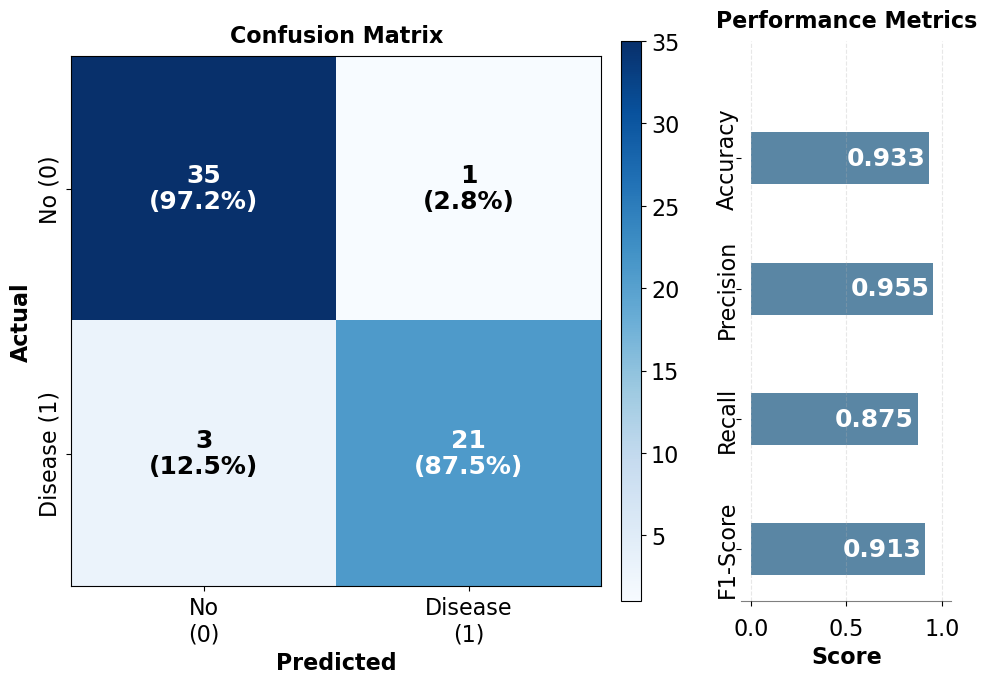

In [74]:
# Show SEL-NNML Evaluation Metrics
y_pred_stack = sel_nnml.predict(X_test)
evaluation_metrics_plot(y_test, y_pred_stack)

In [75]:
# Show SEL-NNM: all fold scores with mean and std 
sel_nnml_cv_scores = cross_val_score(sel_nnml, X_train, y_train, cv=CV_FOLDS, scoring='accuracy', n_jobs=N_JOBS)
print(f'SEL-NNML CV Accuracy Scores [Fold 1, Fold 2, ..., Fold n]: {sel_nnml_cv_scores}')
print(f'Mean: {sel_nnml_cv_scores.mean():.4f}')
print(f'Standard Deviation: {sel_nnml_cv_scores.std():.4f}')

SEL-NNML CV Accuracy Scores [Fold 1, Fold 2, ..., Fold n]: [0.85416667 0.79166667 0.72340426 0.74468085 0.85106383]
Mean: 0.7930
Standard Deviation: 0.0535


In [76]:
# Show SELL-NNML Training Time
Total_training_time = base_models_training_time + meta_model_training_time
print(f'Base Models Tuning & Training Time: {base_models_training_time:.2f} seconds')
print(f'Meta Model Tuning & Training Time: {meta_model_training_time:.2f} seconds')
print(f'Total SEL-NNML Tuning & Training Time: {Total_training_time:.2f} seconds')

Base Models Tuning & Training Time: 37.80 seconds
Meta Model Tuning & Training Time: 56.89 seconds
Total SEL-NNML Tuning & Training Time: 94.69 seconds


### **6.2 Multiple Model Evaluation**

The evaluation below compares all models (base models + SEL-NNML) for the selected sampler. To compare models across different samplers, change the `SELECTED_SAMPLER` variable in the cell above.

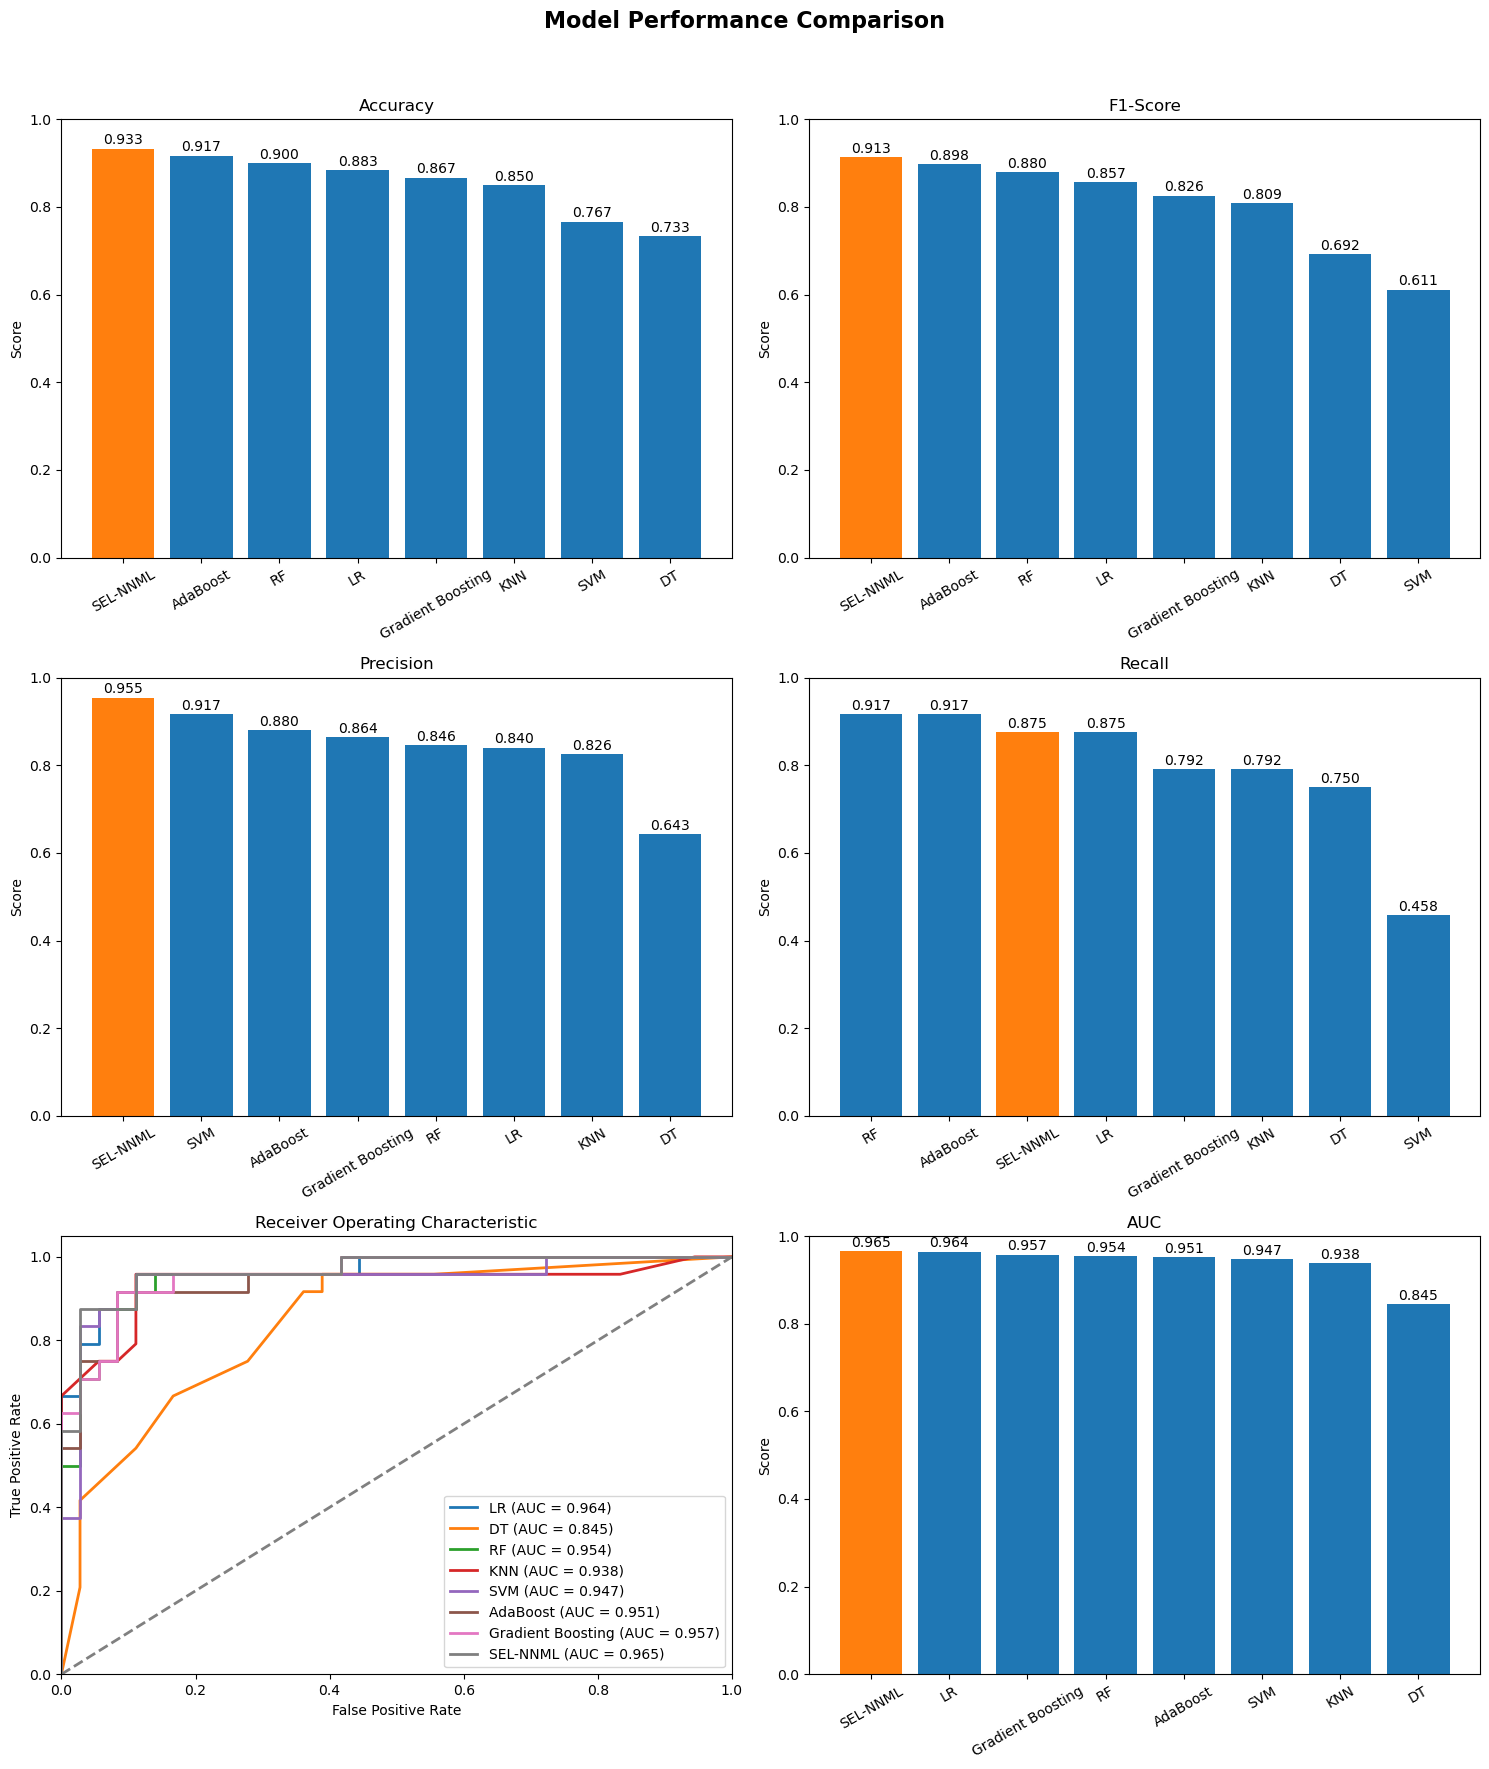

In [77]:
# Use the selected sampler's models for comparison
model_comparison_plot(selected_models, X_test, y_test)

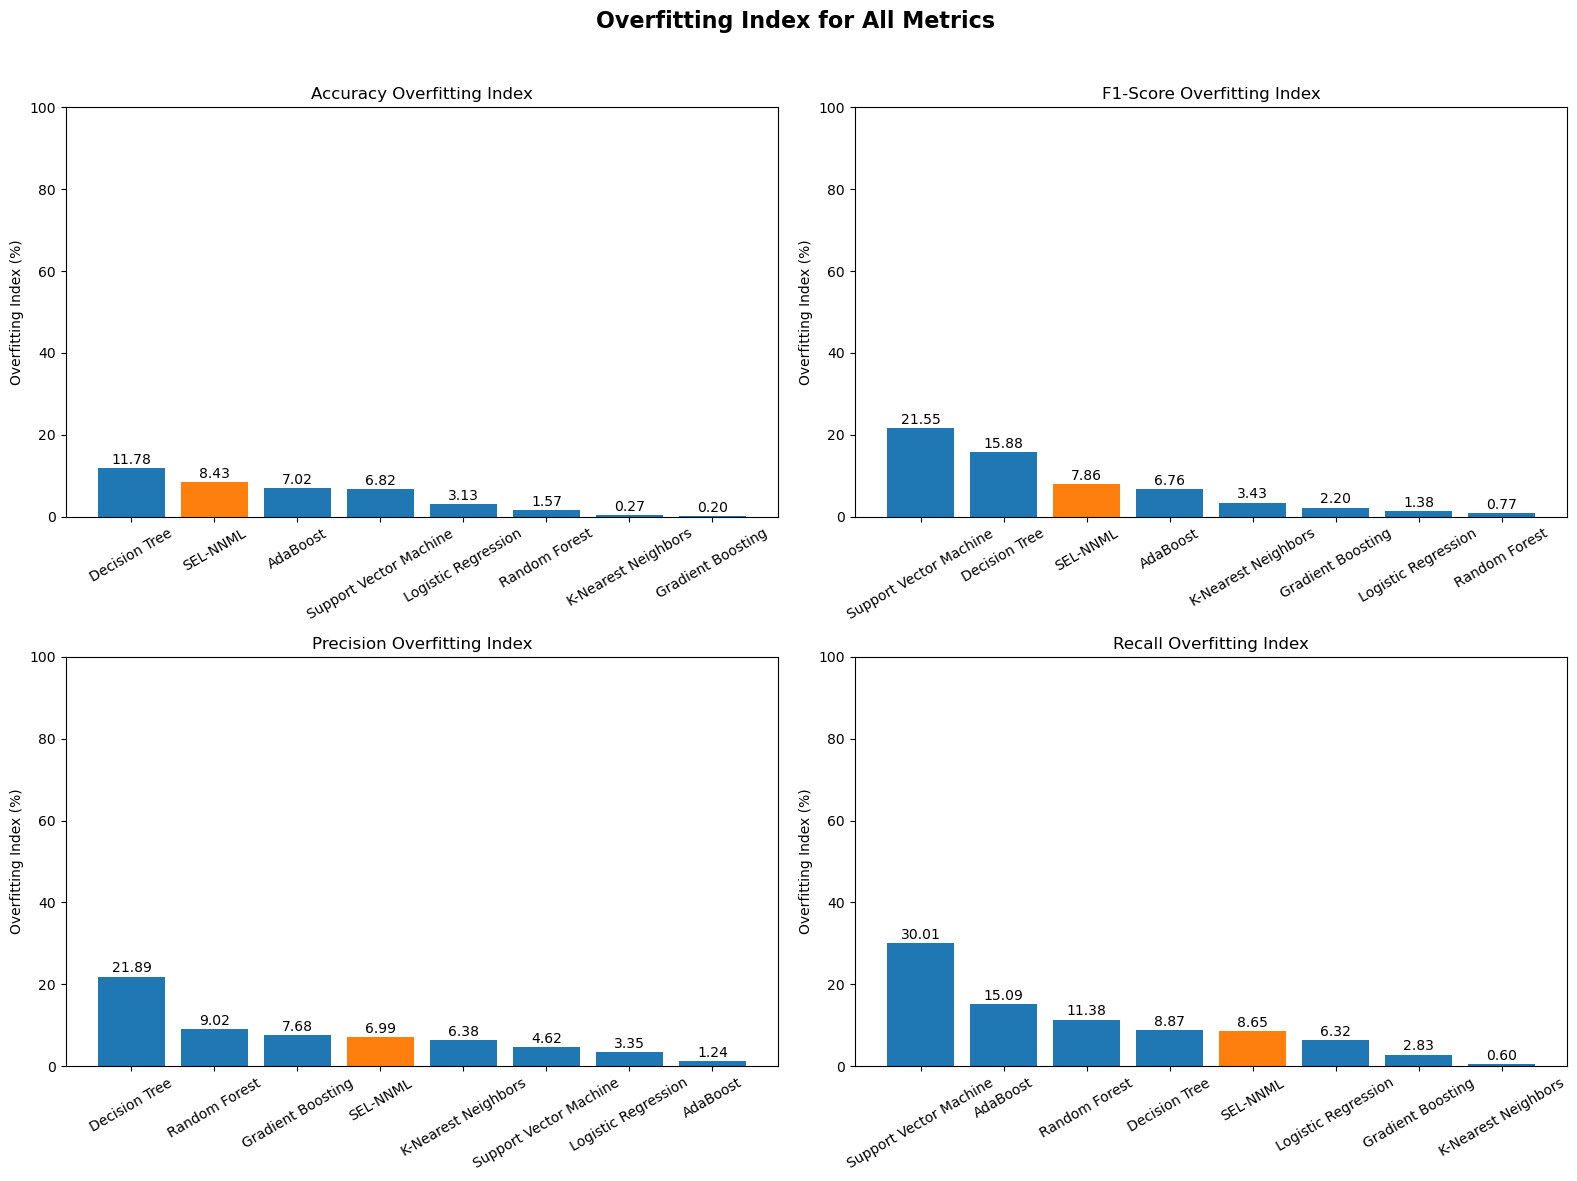

In [78]:
# Use the selected sampler's models for overfitting index comparison
overfitting_index_plot(selected_models, X_train, y_train, X_test, y_test)

In [79]:
# Save feature importance results for all samplers
import os

for sampler in ['TPE', 'GP', 'CMA-ES', 'QMC']:
    # Set the sampler
    temp_sampler = sampler
    temp_models = all_models[temp_sampler]
    temp_sel_nnml = temp_models['SEL-NNML']
    
    # Calculate permutation importance for this sampler
    print(f"Calculating feature importance for {temp_sampler}...")
    temp_perm_importance = permutation_importance(
        temp_sel_nnml, X_test, y_test,
        n_repeats=30, random_state=42, n_jobs=-1
    )
    
    # Create dataframe
    temp_importance_df = pd.DataFrame({
        'Feature': X_train.columns.tolist(),
        'Importance Mean': temp_perm_importance.importances_mean,
        'Importance Std': temp_perm_importance.importances_std
    }).sort_values('Importance Mean', ascending=False)
    
    # Save to CSV
    sampler_folder = temp_sampler.lower().replace("-", "")
    os.makedirs(f'../artifacts/ds2/models/{sampler_folder}', exist_ok=True)
    importance_save_path = f'../artifacts/ds2/models/{sampler_folder}/sel-nnml_feature_importance.csv'
    temp_importance_df.to_csv(importance_save_path, index=False)
    print(f"✓ Saved {temp_sampler} feature importance to: {importance_save_path}")

print("\nAll feature importance data saved successfully!")

Calculating feature importance for TPE...
✓ Saved TPE feature importance to: ../artifacts/ds2/models/tpe/sel-nnml_feature_importance.csv
Calculating feature importance for GP...
✓ Saved GP feature importance to: ../artifacts/ds2/models/gp/sel-nnml_feature_importance.csv
Calculating feature importance for CMA-ES...
✓ Saved CMA-ES feature importance to: ../artifacts/ds2/models/cmaes/sel-nnml_feature_importance.csv
Calculating feature importance for QMC...
✓ Saved QMC feature importance to: ../artifacts/ds2/models/qmc/sel-nnml_feature_importance.csv

All feature importance data saved successfully!


### **6.3 Save All Models Metrics (All Samplers)**

This section calculates and saves performance metrics for all models across all samplers. This data will be used for cross-sampler comparisons in the visualization notebook.

In [80]:
# Calculate and save metrics for ALL models from ALL samplers + BASELINE models
from sklearn.metrics import roc_curve, auc
import os

print("Calculating metrics for all models across all samplers + baseline models...")

all_metrics_data = []
all_roc_data = []

# Process baseline models first
print("\nProcessing BASELINE models...")
baseline_models_dict = {
    **{f"{name} (Default)": model for name, model in default_base_models.items()},
    'Stacking + Linear Regression': stacking_lr,
    'Stacking + Default MLP': stacking_mlp
}

for model_name, model in baseline_models_dict.items():
    # Predictions
    y_pred = model.predict(X_test)
    
    # Get probability predictions for AUC and ROC
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = model.decision_function(X_test)
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Store metrics
    all_metrics_data.append({
        'Sampler': 'Baseline',
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC': roc_auc
    })
    
    # Store ROC curve data
    for f, t in zip(fpr, tpr):
        all_roc_data.append({
            'Sampler': 'Baseline',
            'Model': model_name,
            'FPR': f,
            'TPR': t
        })
    
    print(f"  ✓ {model_name}: Acc={accuracy_score(y_test, y_pred):.4f}, AUC={roc_auc:.4f}")

# Process optimized models
for sampler in ['TPE', 'GP', 'CMA-ES', 'QMC']:
    print(f"\nProcessing {sampler} models...")
    models = all_models[sampler]
    
    for model_name, model in models.items():
        # Predictions
        y_pred = model.predict(X_test)
        
        # Get probability predictions for AUC and ROC
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_pred_proba = model.decision_function(X_test)
        
        # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Store metrics
        all_metrics_data.append({
            'Sampler': sampler,
            'Model': model_name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred),
            'AUC': roc_auc
        })
        
        # Store ROC curve data
        for f, t in zip(fpr, tpr):
            all_roc_data.append({
                'Sampler': sampler,
                'Model': model_name,
                'FPR': f,
                'TPR': t
            })
        
        print(f"  ✓ {model_name}: Acc={accuracy_score(y_test, y_pred):.4f}, AUC={roc_auc:.4f}")

# Create DataFrames
all_metrics_df = pd.DataFrame(all_metrics_data)
all_roc_df = pd.DataFrame(all_roc_data)

# Save to CSV files
os.makedirs('../artifacts/ds2/models', exist_ok=True)
all_metrics_df.to_csv('../artifacts/ds2/models/all_models_metrics.csv', index=False)
all_roc_df.to_csv('../artifacts/ds2/models/all_models_roc_data.csv', index=False)

print(f"\n✅ Saved metrics for {len(all_metrics_data)} model configurations")
print(f"   - Metrics: ../artifacts/ds2/models/all_models_metrics.csv")
print(f"   - ROC Data: ../artifacts/ds2/models/all_models_roc_data.csv")

# Display summary
print("\n" + "="*80)
print("SUMMARY: Top 5 Models by Accuracy")
print("="*80)
display(all_metrics_df.nlargest(5, 'Accuracy')[['Sampler', 'Model', 'Accuracy', 'F1-Score', 'AUC']])

Calculating metrics for all models across all samplers + baseline models...

Processing BASELINE models...
  ✓ Logistic Regression (Default): Acc=0.8833, AUC=0.9514
  ✓ Decision Tree (Default): Acc=0.8167, AUC=0.8333
  ✓ Random Forest (Default): Acc=0.8667, AUC=0.9572
  ✓ K-Nearest Neighbors (Default): Acc=0.8833, AUC=0.9456
  ✓ Support Vector Machine (Default): Acc=0.9000, AUC=0.9560
  ✓ AdaBoost (Default): Acc=0.8833, AUC=0.9086
  ✓ Gradient Boosting (Default): Acc=0.8333, AUC=0.9051
  ✓ Stacking + Linear Regression: Acc=0.8833, AUC=0.9641
  ✓ Stacking + Default MLP: Acc=0.8833, AUC=0.9618

Processing TPE models...
  ✓ Logistic Regression: Acc=0.8833, AUC=0.9641
  ✓ Decision Tree: Acc=0.7333, AUC=0.8449
  ✓ Random Forest: Acc=0.9000, AUC=0.9537
  ✓ K-Nearest Neighbors: Acc=0.8500, AUC=0.9381
  ✓ Support Vector Machine: Acc=0.7667, AUC=0.9468
  ✓ AdaBoost: Acc=0.9167, AUC=0.9514
  ✓ Gradient Boosting: Acc=0.8667, AUC=0.9572
  ✓ SEL-NNML: Acc=0.9333, AUC=0.9653

Processing GP models...

,Sampler,Model,Accuracy,F1-Score,AUC
16,TPE,SEL-NNML,0.933333,0.913043,0.965278
24,GP,SEL-NNML,0.933333,0.913043,0.957176
32,CMA-ES,SEL-NNML,0.933333,0.920000,0.964120
40,QMC,SEL-NNML,0.933333,0.920000,0.943287
14,TPE,AdaBoost,0.916667,0.897959,0.951389


---
# **SECTION 7: Statistical Significance Testing**

Perform paired t-tests to compare SEL-NNML (TPE) against all other 12 models using cross-validation.

## **7.1 Prepare All 13 Models for Statistical Testing**

In [81]:
# Collect all 13 models for paired t-test
models_for_ttest = {}

# Add 9 baseline models (7 base learners + 2 stacking)
models_for_ttest.update({
    f"{name} (Default)": model 
    for name, model in default_base_models.items()
})
models_for_ttest['Stacking + Linear Regression'] = stacking_lr
models_for_ttest['Stacking + Default MLP'] = stacking_mlp

# Add 4 optimized SEL-NNML models
for sampler in ['TPE', 'GP', 'CMA-ES', 'QMC']:
    sel_model = all_models[sampler]['SEL-NNML']
    models_for_ttest[f"SEL-NNML ({sampler})"] = sel_model

print("="*80)
print("MODELS PREPARED FOR PAIRED T-TEST")
print("="*80)
print(f"Total models: {len(models_for_ttest)}")
print("\nBaseline Models (9):")
for i, name in enumerate(list(models_for_ttest.keys())[:9], 1):
    print(f"  {i}. {name}")
print("\nOptimized SEL-NNML Models (4):")
for i, name in enumerate(list(models_for_ttest.keys())[9:], 10):
    print(f"  {i}. {name}")
print("="*80)

MODELS PREPARED FOR PAIRED T-TEST
Total models: 13

Baseline Models (9):
  1. Logistic Regression (Default)
  2. Decision Tree (Default)
  3. Random Forest (Default)
  4. K-Nearest Neighbors (Default)
  5. Support Vector Machine (Default)
  6. AdaBoost (Default)
  7. Gradient Boosting (Default)
  8. Stacking + Linear Regression
  9. Stacking + Default MLP

Optimized SEL-NNML Models (4):
  10. SEL-NNML (TPE)
  11. SEL-NNML (GP)
  12. SEL-NNML (CMA-ES)
  13. SEL-NNML (QMC)


## **7.2 Cross-Validation for All Models (10-Fold)**

Run 10-fold stratified cross-validation on all 13 models to generate paired samples for statistical testing.

In [82]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import time

# Configuration for statistical testing
N_FOLDS_TTEST = 10  # Use 10-fold CV for better statistical power
METRIC = 'accuracy'  # Primary metric for comparison

# Create StratifiedKFold to ensure all models are evaluated on the same folds
skf = StratifiedKFold(n_splits=N_FOLDS_TTEST, shuffle=True, random_state=RANDOM_STATE)

print("="*80)
print(f"RUNNING {N_FOLDS_TTEST}-FOLD CROSS-VALIDATION FOR ALL 13 MODELS")
print("="*80)
print(f"Metric: {METRIC}")
print(f"This will generate {N_FOLDS_TTEST} paired samples for each model...")
print("="*80)
print()

cv_scores = {}
cv_start_time = time.time()

for idx, (name, model) in enumerate(models_for_ttest.items(), 1):
    model_start = time.time()
    print(f"[{idx}/13] Evaluating {name}...", end=" ", flush=True)
    
    scores = cross_val_score(
        model, X_train, y_train, 
        cv=skf, 
        scoring=METRIC,
        n_jobs=N_JOBS
    )
    
    cv_scores[name] = scores
    model_time = time.time() - model_start
    
    print(f"Mean={scores.mean():.4f}, Std={scores.std(ddof=1):.4f} (Time: {model_time:.2f}s)")

total_cv_time = time.time() - cv_start_time

print()
print("="*80)
print(f"✓ Cross-validation completed in {total_cv_time:.2f} seconds ({total_cv_time/60:.2f} minutes)")
print("="*80)

RUNNING 10-FOLD CROSS-VALIDATION FOR ALL 13 MODELS
Metric: accuracy
This will generate 10 paired samples for each model...

[1/13] Evaluating Logistic Regression (Default)... Mean=0.8313, Std=0.0522 (Time: 0.02s)
[2/13] Evaluating Decision Tree (Default)... Mean=0.6841, Std=0.0750 (Time: 0.01s)
[3/13] Evaluating Random Forest (Default)... Mean=0.7763, Std=0.0632 (Time: 0.18s)
[4/13] Evaluating K-Nearest Neighbors (Default)... Mean=0.7937, Std=0.0711 (Time: 0.02s)
[5/13] Evaluating Support Vector Machine (Default)... Mean=0.8230, Std=0.0702 (Time: 0.02s)
[6/13] Evaluating AdaBoost (Default)... Mean=0.8149, Std=0.0626 (Time: 0.09s)
[7/13] Evaluating Gradient Boosting (Default)... Mean=0.7645, Std=0.0851 (Time: 0.12s)
[8/13] Evaluating Stacking + Linear Regression... Mean=0.8149, Std=0.0554 (Time: 2.02s)
[9/13] Evaluating Stacking + Default MLP... Mean=0.8065, Std=0.0585 (Time: 2.16s)
[10/13] Evaluating SEL-NNML (TPE)... Mean=0.8062, Std=0.0790 (Time: 0.70s)
[11/13] Evaluating SEL-NNML (G

## **7.3 Perform Paired t-tests**

Compare SEL-NNML (TPE) against all other 12 models using paired t-tests with Bonferroni correction.

In [83]:
from scipy import stats
import numpy as np

# Define the control/proposed method
CONTROL_MODEL = 'SEL-NNML (TPE)'
ALPHA = 0.05

if CONTROL_MODEL not in cv_scores:
    raise ValueError(f"Control model '{CONTROL_MODEL}' not found in cv_scores")

control_scores = cv_scores[CONTROL_MODEL]
n_comparisons = len(models_for_ttest) - 1  # Exclude comparison with itself

print("="*80)
print(f"PAIRED T-TEST: {CONTROL_MODEL} vs. ALL OTHER MODELS")
print("="*80)
print(f"Control Model: {CONTROL_MODEL}")
print(f"Control Mean Accuracy: {control_scores.mean():.4f} ± {control_scores.std(ddof=1):.4f}")
print(f"Number of Comparisons: {n_comparisons}")
print(f"Significance Level (α): {ALPHA}")
print(f"Multiple Testing Correction: Bonferroni (adjusted α = {ALPHA/n_comparisons:.4f})")
print("="*80)
print()

# Perform paired t-tests
results = []

for name, scores in cv_scores.items():
    if name == CONTROL_MODEL:
        continue  # Skip comparing with itself
    
    # Calculate differences (control - other)
    diff = control_scores - scores
    
    # Paired t-test
    t_stat, p_val = stats.ttest_rel(control_scores, scores)
    
    # Cohen's d for paired samples (effect size)
    d = diff.mean() / (diff.std(ddof=1) + 1e-12)
    
    # Bonferroni correction
    p_bonf = min(1.0, p_val * n_comparisons)
    
    # Significance
    is_significant = p_bonf < ALPHA
    
    results.append({
        'Model': name,
        'Control Mean': control_scores.mean(),
        'Other Mean': scores.mean(),
        'Mean Difference': diff.mean(),
        't-statistic': t_stat,
        'p-value': p_val,
        'p-value (Bonferroni)': p_bonf,
        "Cohen's d": d,
        'Significant (α=0.05)': is_significant
    })

# Create DataFrame and sort by p-value
results_df = pd.DataFrame(results).sort_values('p-value (Bonferroni)')

print(f"{'Model':<40} {'Mean Diff':<12} {'t-stat':<10} {'p-value':<12} {'p (Bonf.)':<12} {'Sig?':<8}")
print("-"*100)

for _, row in results_df.iterrows():
    sig_marker = "✓" if row['Significant (α=0.05)'] else "✗"
    print(f"{row['Model']:<40} {row['Mean Difference']:>11.4f} {row['t-statistic']:>10.3f} "
          f"{row['p-value']:>11.4f} {row['p-value (Bonferroni)']:>11.4f} {sig_marker:>8}")

print("="*100)

PAIRED T-TEST: SEL-NNML (TPE) vs. ALL OTHER MODELS
Control Model: SEL-NNML (TPE)
Control Mean Accuracy: 0.8062 ± 0.0790
Number of Comparisons: 12
Significance Level (α): 0.05
Multiple Testing Correction: Bonferroni (adjusted α = 0.0042)

Model                                    Mean Diff    t-stat     p-value      p (Bonf.)    Sig?    
----------------------------------------------------------------------------------------------------
Decision Tree (Default)                       0.1221      4.814      0.0010      0.0115        ✓
Logistic Regression (Default)                -0.0252     -1.414      0.1910      1.0000        ✗
Random Forest (Default)                       0.0299      1.231      0.2495      1.0000        ✗
K-Nearest Neighbors (Default)                 0.0125      0.989      0.3484      1.0000        ✗
Support Vector Machine (Default)             -0.0168     -1.510      0.1653      1.0000        ✗
AdaBoost (Default)                           -0.0087     -0.425      0.6811 

## **7.4 Summary and Interpretation**

In [84]:
# Summary statistics
sig_count = results_df['Significant (α=0.05)'].sum()
better_count = (results_df['Mean Difference'] > 0).sum()
worse_count = (results_df['Mean Difference'] < 0).sum()

sig_better = results_df[(results_df['Significant (α=0.05)']) & (results_df['Mean Difference'] > 0)]
sig_worse = results_df[(results_df['Significant (α=0.05)']) & (results_df['Mean Difference'] < 0)]

print()
print("="*80)
print("STATISTICAL SIGNIFICANCE TEST SUMMARY")
print("="*80)
print(f"Control Model: {CONTROL_MODEL}")
print(f"Control Mean Accuracy: {control_scores.mean():.4f} ± {control_scores.std(ddof=1):.4f}")
print()
print(f"Total Comparisons: {n_comparisons}")
print(f"Significance Threshold (Bonferroni-corrected): p < {ALPHA}")
print()
print("Results:")
print(f"  ✓ Significantly Better Than:  {len(sig_better)}/{n_comparisons} models")
print(f"  ✗ Significantly Worse Than:   {len(sig_worse)}/{n_comparisons} models")
print(f"  ≈ No Significant Difference:  {n_comparisons - sig_count}/{n_comparisons} models")
print()

if len(sig_better) > 0:
    print("Models Significantly Outperformed:")
    for _, row in sig_better.iterrows():
        print(f"  • {row['Model']:<45} (Δ = +{row['Mean Difference']:.4f}, p = {row['p-value (Bonferroni)']:.4f})")

if len(sig_worse) > 0:
    print()
    print("Models That Significantly Outperformed Control:")
    for _, row in sig_worse.iterrows():
        print(f"  • {row['Model']:<45} (Δ = {row['Mean Difference']:.4f}, p = {row['p-value (Bonferroni)']:.4f})")

print("="*80)
print()

# Display full results table
print("DETAILED RESULTS TABLE:")
print("="*80)
display(results_df)


STATISTICAL SIGNIFICANCE TEST SUMMARY
Control Model: SEL-NNML (TPE)
Control Mean Accuracy: 0.8062 ± 0.0790

Total Comparisons: 12
Significance Threshold (Bonferroni-corrected): p < 0.05

Results:
  ✓ Significantly Better Than:  1/12 models
  ✗ Significantly Worse Than:   0/12 models
  ≈ No Significant Difference:  11/12 models

Models Significantly Outperformed:
  • Decision Tree (Default)                       (Δ = +0.1221, p = 0.0115)

DETAILED RESULTS TABLE:


,Model,Control Mean,Other Mean,Mean Difference,t-statistic,p-value,p-value (Bonferroni),Cohen's d,Significant (α=0.05)
1,Decision Tree (Default),0.806159,0.684058,0.122101,4.814231,0.000955,0.011455,1.522394,True
0,Logistic Regression (Default),0.806159,0.831341,-0.025181,-1.414177,0.190958,1.000000,-0.447202,False
2,Random Forest (Default),0.806159,0.776268,0.029891,1.231035,0.249509,1.000000,0.389287,False
3,K-Nearest Neighbors (Default),0.806159,0.793659,0.012500,0.989208,0.348408,1.000000,0.312815,False
4,Support Vector Machine (Default),0.806159,0.823007,-0.016848,-1.509962,0.165334,1.000000,-0.477492,False
5,AdaBoost (Default),0.806159,0.814855,-0.008696,-0.424603,0.681096,1.000000,-0.134271,False
6,Gradient Boosting (Default),0.806159,0.764493,0.041667,1.288876,0.229583,1.000000,0.407578,False
7,Stacking + Linear Regression,0.806159,0.814855,-0.008696,-0.496210,0.631639,1.000000,-0.156915,False
8,Stacking + Default MLP,0.806159,0.806522,-0.000362,-0.021773,0.983104,1.000000,-0.006885,False
9,SEL-NNML (GP),0.806159,0.801993,0.004167,0.557086,0.591051,1.000000,0.176166,False


## **7.5 Save Results**

In [85]:
# Save paired t-test results
output_dir = '../artifacts/ds2/models'
os.makedirs(output_dir, exist_ok=True)

# Save main results
results_path = os.path.join(output_dir, 'paired_ttest_results.csv')
results_df.to_csv(results_path, index=False)
print(f"✓ Paired t-test results saved to: {results_path}")

# Save CV scores for reproducibility
cv_scores_data = []
for model_name, scores in cv_scores.items():
    for fold_idx, score in enumerate(scores, 1):
        cv_scores_data.append({
            'Model': model_name,
            'Fold': fold_idx,
            'Accuracy': score
        })

cv_scores_df = pd.DataFrame(cv_scores_data)
cv_scores_path = os.path.join(output_dir, 'cv_scores_for_ttest.csv')
cv_scores_df.to_csv(cv_scores_path, index=False)
print(f"✓ Cross-validation scores saved to: {cv_scores_path}")

# Save summary statistics
summary_data = {
    'Control_Model': CONTROL_MODEL,
    'Control_Mean_Accuracy': control_scores.mean(),
    'Control_Std_Accuracy': control_scores.std(ddof=1),
    'Total_Comparisons': n_comparisons,
    'Significantly_Better': len(sig_better),
    'Significantly_Worse': len(sig_worse),
    'No_Significant_Difference': n_comparisons - sig_count,
    'Significance_Level': ALPHA,
    'CV_Folds': N_FOLDS_TTEST,
    'Metric': METRIC
}

summary_df = pd.DataFrame([summary_data])
summary_path = os.path.join(output_dir, 'ttest_summary.csv')
summary_df.to_csv(summary_path, index=False)
print(f"✓ Summary statistics saved to: {summary_path}")

print()
print("="*80)
print("✅ STATISTICAL SIGNIFICANCE TESTING COMPLETE")
print("="*80)

✓ Paired t-test results saved to: ../artifacts/ds2/models/paired_ttest_results.csv
✓ Cross-validation scores saved to: ../artifacts/ds2/models/cv_scores_for_ttest.csv
✓ Summary statistics saved to: ../artifacts/ds2/models/ttest_summary.csv

✅ STATISTICAL SIGNIFICANCE TESTING COMPLETE


---
# **SECTION 8: McNemar's Test**

Perform McNemar's test to compare prediction disagreements between SEL-NNML (TPE) and other models on the test set. This test examines whether models make systematically different errors on specific instances.

## **8.1 Generate Predictions on Test Set**

Generate predictions from all 13 models on the test set for McNemar's test.

In [86]:
# Generate predictions from all 13 models on test set
test_predictions = {}

print("="*80)
print("GENERATING TEST SET PREDICTIONS FOR MCNEMAR'S TEST")
print("="*80)
print(f"Test set size: {len(y_test)}")
print()

for idx, (name, model) in enumerate(models_for_ttest.items(), 1):
    print(f"[{idx}/13] Predicting with {name}...", end=" ", flush=True)
    
    # All models (baseline and optimized) were trained on the same X_train
    # (which has both scaled numeric features and boolean features merged)
    # So they all need X_test (not X_test_scaled which only has numeric features)
    y_pred = model.predict(X_test)
    
    test_predictions[name] = y_pred
    accuracy = (y_pred == y_test).sum() / len(y_test)
    print(f"Accuracy: {accuracy:.4f}")

print()
print("="*80)
print(f"✓ Generated predictions for all {len(test_predictions)} models")
print("="*80)

GENERATING TEST SET PREDICTIONS FOR MCNEMAR'S TEST
Test set size: 60

[1/13] Predicting with Logistic Regression (Default)... Accuracy: 0.8833
[2/13] Predicting with Decision Tree (Default)... Accuracy: 0.8167
[3/13] Predicting with Random Forest (Default)... Accuracy: 0.8667
[4/13] Predicting with K-Nearest Neighbors (Default)... Accuracy: 0.8833
[5/13] Predicting with Support Vector Machine (Default)... Accuracy: 0.9000
[6/13] Predicting with AdaBoost (Default)... Accuracy: 0.8833
[7/13] Predicting with Gradient Boosting (Default)... Accuracy: 0.8333
[8/13] Predicting with Stacking + Linear Regression... Accuracy: 0.8833
[9/13] Predicting with Stacking + Default MLP... Accuracy: 0.8833
[10/13] Predicting with SEL-NNML (TPE)... Accuracy: 0.9333
[11/13] Predicting with SEL-NNML (GP)... Accuracy: 0.9333
[12/13] Predicting with SEL-NNML (CMA-ES)... Accuracy: 0.9333
[13/13] Predicting with SEL-NNML (QMC)... Accuracy: 0.9333

✓ Generated predictions for all 13 models


## **8.2 Perform McNemar's Tests**

Compare SEL-NNML (TPE) against all other 12 models using McNemar's test.

In [87]:
from scipy.stats import chi2

def mcnemar_test(y_true, y_pred_a, y_pred_b):
    """
    Perform McNemar's test for two classifiers.
    
    Returns:
        - contingency table (2x2)
        - chi-square statistic
        - p-value
    """
    # Create contingency table
    # both_correct: both A and B correct
    # a_correct_b_wrong: A correct, B wrong
    # a_wrong_b_correct: A wrong, B correct
    # both_wrong: both A and B wrong
    
    both_correct = ((y_pred_a == y_true) & (y_pred_b == y_true)).sum()
    a_correct_b_wrong = ((y_pred_a == y_true) & (y_pred_b != y_true)).sum()
    a_wrong_b_correct = ((y_pred_a != y_true) & (y_pred_b == y_true)).sum()
    both_wrong = ((y_pred_a != y_true) & (y_pred_b != y_true)).sum()
    
    # Contingency table
    table = np.array([[both_correct, a_correct_b_wrong],
                      [a_wrong_b_correct, both_wrong]])
    
    # McNemar's test statistic with continuity correction
    b = a_correct_b_wrong
    c = a_wrong_b_correct
    
    # Chi-square test statistic (with continuity correction)
    if b + c > 0:
        chi2_stat = (abs(b - c) - 1)**2 / (b + c)
    else:
        chi2_stat = 0.0
    
    # p-value from chi-square distribution (df=1)
    p_value = 1 - chi2.cdf(chi2_stat, df=1)
    
    return table, chi2_stat, p_value, b, c

# Control model
control_pred = test_predictions[CONTROL_MODEL]

print("="*80)
print(f"MCNEMAR'S TEST: {CONTROL_MODEL} vs. ALL OTHER MODELS")
print("="*80)
print(f"Control Model: {CONTROL_MODEL}")
print(f"Test Set Size: {len(y_test)}")
print(f"Significance Level: α = {ALPHA}")
print("="*80)
print()

mcnemar_results = []

for name, pred in test_predictions.items():
    if name == CONTROL_MODEL:
        continue
    
    table, chi2_stat, p_value, b, c = mcnemar_test(y_test.values, control_pred, pred)
    
    # Bonferroni correction
    p_bonf = min(1.0, p_value * n_comparisons)
    is_significant = p_bonf < ALPHA
    
    mcnemar_results.append({
        'Model': name,
        'Both Correct': table[0, 0],
        'Control Right, Other Wrong': b,
        'Control Wrong, Other Right': c,
        'Both Wrong': table[1, 1],
        'Chi-Square': chi2_stat,
        'p-value': p_value,
        'p-value (Bonferroni)': p_bonf,
        'Significant (α=0.05)': is_significant
    })

# Create DataFrame
mcnemar_df = pd.DataFrame(mcnemar_results).sort_values('p-value (Bonferroni)')

print(f"{'Model':<40} {'b (C✓O✗)':<12} {'c (C✗O✓)':<12} {'χ²':<10} {'p-value':<12} {'p (Bonf.)':<12} {'Sig?':<8}")
print("-"*110)

for _, row in mcnemar_df.iterrows():
    sig_marker = "✓" if row['Significant (α=0.05)'] else "✗"
    print(f"{row['Model']:<40} {row['Control Right, Other Wrong']:>11} {row['Control Wrong, Other Right']:>11} "
          f"{row['Chi-Square']:>10.3f} {row['p-value']:>11.4f} {row['p-value (Bonferroni)']:>11.4f} {sig_marker:>8}")

print("="*110)

MCNEMAR'S TEST: SEL-NNML (TPE) vs. ALL OTHER MODELS
Control Model: SEL-NNML (TPE)
Test Set Size: 60
Significance Level: α = 0.05

Model                                    b (C✓O✗)     c (C✗O✓)     χ²         p-value      p (Bonf.)    Sig?    
--------------------------------------------------------------------------------------------------------------
Logistic Regression (Default)                      4           1      0.800      0.3711      1.0000        ✗
Decision Tree (Default)                           10           3      2.769      0.0961      1.0000        ✗
Random Forest (Default)                            5           1      1.500      0.2207      1.0000        ✗
K-Nearest Neighbors (Default)                      5           2      0.571      0.4497      1.0000        ✗
Support Vector Machine (Default)                   3           1      0.250      0.6171      1.0000        ✗
AdaBoost (Default)                                 6           3      0.444      0.5050      1.0000  

## **8.3 Contingency Table Visualization**

Visualize the contingency tables for significant comparisons.

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get top 5 most significant comparisons (or all if fewer than 5)
sig_comparisons = mcnemar_df[mcnemar_df['Significant (α=0.05)']].head(5)

if len(sig_comparisons) > 0:
    n_plots = len(sig_comparisons)
    n_cols = min(3, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    if n_plots == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_rows > 1 else axes
    
    for idx, (_, row) in enumerate(sig_comparisons.iterrows()):
        ax = axes[idx]
        
        # Create contingency table
        table_data = np.array([
            [row['Both Correct'], row['Control Right, Other Wrong']],
            [row['Control Wrong, Other Right'], row['Both Wrong']]
        ])
        
        # Plot heatmap
        sns.heatmap(table_data, annot=True, fmt='d', cmap='Blues', 
                    cbar=True, ax=ax, annot_kws={'size': 14, 'weight': 'bold'},
                    xticklabels=['Other Correct', 'Other Wrong'],
                    yticklabels=['Control Correct', 'Control Wrong'])
        
        ax.set_title(f"{CONTROL_MODEL} vs. {row['Model']}\n"
                     f"χ²={row['Chi-Square']:.3f}, p={row['p-value (Bonferroni)']:.4f}",
                     fontsize=11, fontweight='bold')
        ax.set_xlabel('Other Model', fontsize=10, fontweight='bold')
        ax.set_ylabel('Control Model', fontsize=10, fontweight='bold')
    
    # Hide unused subplots
    for idx in range(n_plots, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Displayed contingency tables for {len(sig_comparisons)} significant comparison(s)")
else:
    print("\n⚠ No significant comparisons found (p < 0.05 after Bonferroni correction)")
    print("   Contingency table visualization skipped.")


⚠ No significant comparisons found (p < 0.05 after Bonferroni correction)
   Contingency table visualization skipped.


## **8.4 Summary and Interpretation**

In [89]:
# Summary statistics
sig_count_mcnemar = mcnemar_df['Significant (α=0.05)'].sum()

# Models where control is significantly better (b > c and significant)
control_better = mcnemar_df[
    (mcnemar_df['Significant (α=0.05)']) & 
    (mcnemar_df['Control Right, Other Wrong'] > mcnemar_df['Control Wrong, Other Right'])
]

# Models where other is significantly better (c > b and significant)
control_worse = mcnemar_df[
    (mcnemar_df['Significant (α=0.05)']) & 
    (mcnemar_df['Control Wrong, Other Right'] > mcnemar_df['Control Right, Other Wrong'])
]

print()
print("="*80)
print("MCNEMAR'S TEST SUMMARY")
print("="*80)
print(f"Control Model: {CONTROL_MODEL}")
print(f"Test Set Size: {len(y_test)}")
print(f"Total Comparisons: {n_comparisons}")
print(f"Significance Level: α = {ALPHA} (Bonferroni-corrected)")
print()
print("Results:")
print(f"  ✓ Significantly Different From:   {sig_count_mcnemar}/{n_comparisons} models")
print(f"    - Control Better:                {len(control_better)}")
print(f"    - Control Worse:                 {len(control_worse)}")
print(f"  ≈ No Significant Difference:       {n_comparisons - sig_count_mcnemar}/{n_comparisons} models")
print()

if len(control_better) > 0:
    print("Models Significantly Outperformed by Control:")
    for _, row in control_better.iterrows():
        b = row['Control Right, Other Wrong']
        c = row['Control Wrong, Other Right']
        print(f"  • {row['Model']:<45} (b={b}, c={c}, χ²={row['Chi-Square']:.3f}, p={row['p-value (Bonferroni)']:.4f})")

if len(control_worse) > 0:
    print()
    print("Models That Significantly Outperformed Control:")
    for _, row in control_worse.iterrows():
        b = row['Control Right, Other Wrong']
        c = row['Control Wrong, Other Right']
        print(f"  • {row['Model']:<45} (b={b}, c={c}, χ²={row['Chi-Square']:.3f}, p={row['p-value (Bonferroni)']:.4f})")

print()
print("Interpretation:")
print("  - 'b' (Control Right, Other Wrong): Instances where control is correct but other model is wrong")
print("  - 'c' (Control Wrong, Other Right): Instances where control is wrong but other model is correct")
print("  - If b >> c: Control makes fewer errors → control is better")
print("  - If c >> b: Other model makes fewer errors → other model is better")
print("  - If b ≈ c: Models make different but equal errors → no significant difference")
print("="*80)
print()

# Display full results table
print("DETAILED RESULTS TABLE:")
print("="*80)
display(mcnemar_df)


MCNEMAR'S TEST SUMMARY
Control Model: SEL-NNML (TPE)
Test Set Size: 60
Total Comparisons: 12
Significance Level: α = 0.05 (Bonferroni-corrected)

Results:
  ✓ Significantly Different From:   0/12 models
    - Control Better:                0
    - Control Worse:                 0
  ≈ No Significant Difference:       12/12 models


Interpretation:
  - 'b' (Control Right, Other Wrong): Instances where control is correct but other model is wrong
  - 'c' (Control Wrong, Other Right): Instances where control is wrong but other model is correct
  - If b >> c: Control makes fewer errors → control is better
  - If c >> b: Other model makes fewer errors → other model is better
  - If b ≈ c: Models make different but equal errors → no significant difference

DETAILED RESULTS TABLE:


,Model,Both Correct,"Control Right, Other Wrong","Control Wrong, Other Right",Both Wrong,Chi-Square,p-value,p-value (Bonferroni),Significant (α=0.05)
0,Logistic Regression (Default),52,4,1,3,0.800000,0.371093,1.0,False
1,Decision Tree (Default),46,10,3,1,2.769231,0.096092,1.0,False
2,Random Forest (Default),51,5,1,3,1.500000,0.220671,1.0,False
3,K-Nearest Neighbors (Default),51,5,2,2,0.571429,0.449692,1.0,False
4,Support Vector Machine (Default),53,3,1,3,0.250000,0.617075,1.0,False
5,AdaBoost (Default),50,6,3,1,0.444444,0.504985,1.0,False
6,Gradient Boosting (Default),48,8,2,2,2.500000,0.113846,1.0,False
7,Stacking + Linear Regression,52,4,1,3,0.800000,0.371093,1.0,False
8,Stacking + Default MLP,52,4,1,3,0.800000,0.371093,1.0,False
9,SEL-NNML (GP),56,0,0,4,0.000000,1.000000,1.0,False


## **8.5 Save Results**

In [90]:
# Save McNemar's test results
mcnemar_results_path = os.path.join(output_dir, 'mcnemar_test_results.csv')
mcnemar_df.to_csv(mcnemar_results_path, index=False)
print(f"✓ McNemar's test results saved to: {mcnemar_results_path}")

# Save test predictions for reproducibility
test_pred_data = []
for model_name, predictions in test_predictions.items():
    for idx, pred in enumerate(predictions):
        test_pred_data.append({
            'Model': model_name,
            'Instance_Index': idx,
            'Prediction': pred,
            'True_Label': y_test.iloc[idx]
        })

test_pred_df = pd.DataFrame(test_pred_data)
test_pred_path = os.path.join(output_dir, 'test_predictions_for_mcnemar.csv')
test_pred_df.to_csv(test_pred_path, index=False)
print(f"✓ Test predictions saved to: {test_pred_path}")

# Save McNemar summary statistics
mcnemar_summary = {
    'Control_Model': CONTROL_MODEL,
    'Test_Set_Size': len(y_test),
    'Total_Comparisons': n_comparisons,
    'Significant_Differences': sig_count_mcnemar,
    'Control_Better': len(control_better),
    'Control_Worse': len(control_worse),
    'No_Significant_Difference': n_comparisons - sig_count_mcnemar,
    'Significance_Level': ALPHA
}

mcnemar_summary_df = pd.DataFrame([mcnemar_summary])
mcnemar_summary_path = os.path.join(output_dir, 'mcnemar_summary.csv')
mcnemar_summary_df.to_csv(mcnemar_summary_path, index=False)
print(f"✓ McNemar summary statistics saved to: {mcnemar_summary_path}")

print()
print("="*80)
print("✅ MCNEMAR'S TEST COMPLETE")
print("="*80)

✓ McNemar's test results saved to: ../artifacts/ds2/models/mcnemar_test_results.csv
✓ Test predictions saved to: ../artifacts/ds2/models/test_predictions_for_mcnemar.csv
✓ McNemar summary statistics saved to: ../artifacts/ds2/models/mcnemar_summary.csv

✅ MCNEMAR'S TEST COMPLETE
